In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [ ]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(classifier.parameters(), lr = learning_rate)

    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    
    saved_dir= "./EEG/saved_models/Userfold/run2"
#     model= Multivariate_IEGradient(DEVICE, input_dim, resnet_classifier).to(DEVICE)
    model= EEGNet_Wrapper(DEVICE, classifier)
    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-Baseline-e{EPOCH}.pt"
           )
    )

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-Baseline-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6951048035247653


Iterations:   0%|                                   | 1/300 [00:01<07:55,  1.59s/it]

Epoch:  0
t_loss:  0.6951048035247653 , v_loss:  0.6990129748980204
t_acc:  0.5169623404917523 , v_acc:  0.4472049689440994
t_recall:  0.4886146223631298 , v_recall:  0.3682882882882883
t_prec:  0.49017547668864236 , v_prec:  0.3746140651801029
t_f:  0.4808872824787944 , v_f:  0.37112135176651306
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:57,  1.20s/it]

Epoch  1 , loss 0.6596706369343925
Epoch  2 , loss 0.6342019836107889


Iterations:   1%|▎                                  | 3/300 [00:03<06:30,  1.32s/it]

Epoch:  2
t_loss:  0.6342019836107889 , v_loss:  0.6984645128250122
t_acc:  0.5882352941176471 , v_acc:  0.5093167701863354
t_recall:  0.49067676809266964 , v_recall:  0.39684684684684685
t_prec:  0.48958944221601486 , v_prec:  0.3796763345943674
t_f:  0.4886346042685571 , v_f:  0.38665187828519065
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:34,  1.13s/it]

Epoch  3 , loss 0.6070840358734131
Epoch  4 , loss 0.585444452715855


Iterations:   2%|▌                                  | 5/300 [00:06<06:21,  1.29s/it]

Epoch:  4
t_loss:  0.585444452715855 , v_loss:  0.6917093594868978
t_acc:  0.6554621848739496 , v_acc:  0.6521739130434783
t_recall:  0.5119707388040241 , v_recall:  0.48945945945945946
t_prec:  0.5226271186440677 , v_prec:  0.4672818791946309
t_f:  0.49215434446295053 , v_f:  0.44069478908188586
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:37,  1.15s/it]

Epoch  5 , loss 0.5684442800634047
Epoch  6 , loss 0.5533267493341484


Iterations:   2%|▊                                  | 7/300 [00:08<06:10,  1.26s/it]

Epoch:  6
t_loss:  0.5533267493341484 , v_loss:  0.6837899486223856
t_acc:  0.6763149704326175 , v_acc:  0.6770186335403726
t_recall:  0.5062571197211128 , v_recall:  0.4964864864864865
t_prec:  0.5224868551285551 , v_prec:  0.46894904458598724
t_f:  0.46019889245720713 , v_f:  0.4215035931453841
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:35,  1.15s/it]

Epoch  7 , loss 0.5340229646832335
Epoch  8 , loss 0.5249442206878289


Iterations:   3%|█                                  | 9/300 [00:11<06:01,  1.24s/it]

Epoch:  8
t_loss:  0.5249442206878289 , v_loss:  0.6802067955334982
t_acc:  0.6856520385932151 , v_acc:  0.6894409937888198
t_recall:  0.5017547110251026 , v_recall:  0.5
t_prec:  0.5130821389834439 , v_prec:  0.3447204968944099
t_f:  0.43459590820644634 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:29,  1.14s/it]

Epoch  9 , loss 0.5118085858868617
Epoch  10 , loss 0.5001852126682506


Iterations:   4%|█▏                                | 11/300 [00:13<05:52,  1.22s/it]

Epoch:  10
t_loss:  0.5001852126682506 , v_loss:  0.6828505794207255
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5069646312842262 , v_recall:  0.5
t_prec:  0.5944022770398482 , v_prec:  0.3447204968944099
t_f:  0.43359689623486974 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:21,  1.11s/it]

Epoch  11 , loss 0.4964783238429649
Epoch  12 , loss 0.48149532255004435


Iterations:   4%|█▍                                | 13/300 [00:15<05:59,  1.25s/it]

Epoch:  12
t_loss:  0.48149532255004435 , v_loss:  0.6890733738740286
t_acc:  0.6940553999377529 , v_acc:  0.6894409937888198
t_recall:  0.5020443035368716 , v_recall:  0.5
t_prec:  0.5519460138104206 , v_prec:  0.3447204968944099
t_f:  0.4202793448364156 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:20,  1.12s/it]

Epoch  13 , loss 0.48147083439078986
Epoch  14 , loss 0.4760562812580782


Iterations:   5%|█▋                                | 15/300 [00:18<05:44,  1.21s/it]

Epoch:  14
t_loss:  0.4760562812580782 , v_loss:  0.6956628362337748
t_acc:  0.6937441643323996 , v_acc:  0.6894409937888198
t_recall:  0.499232785715266 , v_recall:  0.5
t_prec:  0.44764283484233536 , v_prec:  0.3447204968944099
t_f:  0.4115498523659419 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:20,  1.13s/it]

Epoch  15 , loss 0.46991054742944005
Epoch  16 , loss 0.4679807611540252


Iterations:   6%|█▉                                | 17/300 [00:20<06:01,  1.28s/it]

Epoch:  16
t_loss:  0.4679807611540252 , v_loss:  0.7032108207543691
t_acc:  0.6931216931216931 , v_acc:  0.6894409937888198
t_recall:  0.4990728922194315 , v_recall:  0.5
t_prec:  0.4547514848390122 , v_prec:  0.3447204968944099
t_f:  0.4122991291391122 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:21<05:22,  1.14s/it]

Epoch  17 , loss 0.46376680217537225
Epoch  18 , loss 0.4636137304352779


Iterations:   6%|██▏                               | 19/300 [00:22<05:43,  1.22s/it]

Epoch:  18
t_loss:  0.4636137304352779 , v_loss:  0.7089276810487112
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:24,  1.16s/it]

Epoch  19 , loss 0.46005940437316895
Epoch  20 , loss 0.45698617720136453


Iterations:   7%|██▍                               | 21/300 [00:25<05:44,  1.23s/it]

Epoch:  20
t_loss:  0.45698617720136453 , v_loss:  0.7137071788311005
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.4993288590604027 , v_recall:  0.5
t_prec:  0.34766355140186916 , v_prec:  0.3447204968944099
t_f:  0.40991735537190077 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:07,  1.11s/it]

Epoch  21 , loss 0.4658814347257801
Epoch  22 , loss 0.46128036812240003


Iterations:   8%|██▌                               | 23/300 [00:27<05:50,  1.26s/it]

Epoch:  22
t_loss:  0.46128036812240003 , v_loss:  0.7161617974440256
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:14,  1.14s/it]

Epoch  23 , loss 0.4586782180795483
Epoch  24 , loss 0.4539404879598057


Iterations:   8%|██▊                               | 25/300 [00:30<05:38,  1.23s/it]

Epoch:  24
t_loss:  0.4539404879598057 , v_loss:  0.7151073614756266
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:19,  1.17s/it]

Epoch  25 , loss 0.45350010605419383
Epoch  26 , loss 0.46444478397275885


Iterations:   9%|███                               | 27/300 [00:32<05:47,  1.27s/it]

Epoch:  26
t_loss:  0.46444478397275885 , v_loss:  0.7155022819836935
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.49955257270693515 , v_recall:  0.5
t_prec:  0.3477109934599813 , v_prec:  0.3447204968944099
t_f:  0.41002570694087404 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:11,  1.14s/it]

Epoch  27 , loss 0.4535006682078044
Epoch  28 , loss 0.4521501999275357


Iterations:  10%|███▎                              | 29/300 [00:34<05:36,  1.24s/it]

Epoch:  28
t_loss:  0.4521501999275357 , v_loss:  0.7143437365690867
t_acc:  0.6940553999377529 , v_acc:  0.6894409937888198
t_recall:  0.4988814317673378 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3447204968944099
t_f:  0.40970053279441476 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:07,  1.14s/it]

Epoch  29 , loss 0.45758192621025384
Epoch  30 , loss 0.4526831718052135


Iterations:  10%|███▌                              | 31/300 [00:37<05:41,  1.27s/it]

Epoch:  30
t_loss:  0.4526831718052135 , v_loss:  0.7089098940292994
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:04,  1.14s/it]

Epoch  31 , loss 0.452704554679347
Epoch  32 , loss 0.4496271353141934


Iterations:  11%|███▋                              | 33/300 [00:39<05:30,  1.24s/it]

Epoch:  32
t_loss:  0.4496271353141934 , v_loss:  0.7052672505378723
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5013100286847559 , v_recall:  0.5
t_prec:  0.7230835151137426 , v_prec:  0.3447204968944099
t_f:  0.4134150192068549 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:10,  1.17s/it]

Epoch  33 , loss 0.4492584420185463
Epoch  34 , loss 0.4477969963176578


Iterations:  12%|███▉                              | 35/300 [00:42<05:32,  1.26s/it]

Epoch:  34
t_loss:  0.4477969963176578 , v_loss:  0.7002509236335754
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:42<04:59,  1.14s/it]

Epoch  35 , loss 0.44702901968769
Epoch  36 , loss 0.4508014794658212


Iterations:  12%|████▏                             | 37/300 [00:44<05:23,  1.23s/it]

Epoch:  36
t_loss:  0.4508014794658212 , v_loss:  0.6969053596258163
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.49955257270693515 , v_recall:  0.5
t_prec:  0.3477109934599813 , v_prec:  0.3447204968944099
t_f:  0.41002570694087404 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:56,  1.13s/it]

Epoch  37 , loss 0.4469636000838934
Epoch  38 , loss 0.44900326518451467


Iterations:  13%|████▍                             | 39/300 [00:46<05:32,  1.28s/it]

Epoch:  38
t_loss:  0.44900326518451467 , v_loss:  0.6920211613178253
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:57,  1.14s/it]

Epoch  39 , loss 0.45138773964900597
Epoch  40 , loss 0.44229727925038803


Iterations:  14%|████▋                             | 41/300 [00:49<05:17,  1.23s/it]

Epoch:  40
t_loss:  0.44229727925038803 , v_loss:  0.6837899933258692
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5013100286847559 , v_recall:  0.5
t_prec:  0.7230835151137426 , v_prec:  0.3447204968944099
t_f:  0.4134150192068549 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:50,  1.13s/it]

Epoch  41 , loss 0.44147664425419825
Epoch  42 , loss 0.4437425580679202


Iterations:  14%|████▊                             | 43/300 [00:51<05:24,  1.26s/it]

Epoch:  42
t_loss:  0.4437425580679202 , v_loss:  0.6777543822924296
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5001914604520937 , v_recall:  0.5
t_prec:  0.5145131086142322 , v_prec:  0.3447204968944099
t_f:  0.4128574949243642 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:52,  1.14s/it]

Epoch  43 , loss 0.43905379608565687
Epoch  44 , loss 0.44341349893925236


Iterations:  15%|█████                             | 45/300 [00:53<05:12,  1.23s/it]

Epoch:  44
t_loss:  0.44341349893925236 , v_loss:  0.6721658656994501
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5013738488354538 , v_recall:  0.5
t_prec:  0.6338116032439176 , v_prec:  0.3447204968944099
t_f:  0.4142796235015772 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:48,  1.14s/it]

Epoch  45 , loss 0.4443367047637117
Epoch  46 , loss 0.44188687964981677


Iterations:  16%|█████▎                            | 47/300 [00:56<05:13,  1.24s/it]

Epoch:  46
t_loss:  0.44188687964981677 , v_loss:  0.668568288286527
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5024601638736773 , v_recall:  0.5
t_prec:  0.6399953139643861 , v_prec:  0.3447204968944099
t_f:  0.4172988159743127 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:42,  1.12s/it]

Epoch  47 , loss 0.44079233793651357
Epoch  48 , loss 0.4407027498179791


Iterations:  16%|█████▌                            | 49/300 [00:58<05:09,  1.23s/it]

Epoch:  48
t_loss:  0.4407027498179791 , v_loss:  0.6636166473229727
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5023325235722814 , v_recall:  0.5
t_prec:  0.7649672591206735 , v_prec:  0.3447204968944099
t_f:  0.4155921424153602 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:38,  1.11s/it]

Epoch  49 , loss 0.44391059641744574
Epoch  50 , loss 0.43624979316019546


Iterations:  17%|█████▊                            | 51/300 [01:01<05:05,  1.23s/it]

Epoch:  50
t_loss:  0.43624979316019546 , v_loss:  0.6542640080054601
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5016613826326841 , v_recall:  0.5
t_prec:  0.6259363295880149 , v_prec:  0.3447204968944099
t_f:  0.41525155202966746 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:43,  1.14s/it]

Epoch  51 , loss 0.4403422159307143
Epoch  52 , loss 0.4327641585293938


Iterations:  18%|██████                            | 53/300 [01:03<05:07,  1.24s/it]

Epoch:  52
t_loss:  0.4327641585293938 , v_loss:  0.6485442419846853
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5039939062049656 , v_recall:  0.5
t_prec:  0.6819887429643527 , v_prec:  0.3447204968944099
t_f:  0.42052512257253005 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:35,  1.12s/it]

Epoch  53 , loss 0.4364437308965945
Epoch  54 , loss 0.4434587248400146


Iterations:  18%|██████▏                           | 55/300 [01:05<04:55,  1.21s/it]

Epoch:  54
t_loss:  0.4434587248400146 , v_loss:  0.6455785731474558
t_acc:  0.6996576408341114 , v_acc:  0.6894409937888198
t_recall:  0.5069337505661465 , v_recall:  0.5
t_prec:  0.8159474671669793 , v_prec:  0.3447204968944099
t_f:  0.42528956144140956 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:37,  1.14s/it]

Epoch  55 , loss 0.4314935967033985
Epoch  56 , loss 0.43142717054077223


Iterations:  19%|██████▍                           | 57/300 [01:08<05:02,  1.24s/it]

Epoch:  56
t_loss:  0.43142717054077223 , v_loss:  0.6418919513622919
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5023002703778428 , v_recall:  0.5
t_prec:  0.5982952768220207 , v_prec:  0.3447204968944099
t_f:  0.4180261984276795 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:28,  1.11s/it]

Epoch  57 , loss 0.43527032581030156
Epoch  58 , loss 0.4305725150248584


Iterations:  20%|██████▋                           | 59/300 [01:10<04:54,  1.22s/it]

Epoch:  58
t_loss:  0.4305725150248584 , v_loss:  0.6380662818749746
t_acc:  0.6981014628073452 , v_acc:  0.6894409937888198
t_recall:  0.506390249927945 , v_recall:  0.5
t_prec:  0.6825023518344309 , v_prec:  0.3447204968944099
t_f:  0.426550659742462 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:26,  1.11s/it]

Epoch  59 , loss 0.4411211206632502
Epoch  60 , loss 0.4384758881494111


Iterations:  20%|██████▉                           | 61/300 [01:12<04:59,  1.25s/it]

Epoch:  60
t_loss:  0.4384758881494111 , v_loss:  0.633465309937795
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.5045051536487284 , v_recall:  0.51
t_prec:  0.6925144666875196 , v_prec:  0.846875
t_f:  0.4215965898483685 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:31,  1.14s/it]

Epoch  61 , loss 0.43680837575127096
Epoch  62 , loss 0.4415716815228556


Iterations:  21%|███████▏                          | 63/300 [01:15<04:52,  1.24s/it]

Epoch:  62
t_loss:  0.4415716815228556 , v_loss:  0.6329738050699234
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5040577263556635 , v_recall:  0.51
t_prec:  0.6542253521126761 , v_prec:  0.846875
t_f:  0.421357252213273 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:29,  1.14s/it]

Epoch  63 , loss 0.43335408030771744
Epoch  64 , loss 0.43382662534713745


Iterations:  22%|███████▎                          | 65/300 [01:17<04:46,  1.22s/it]

Epoch:  64
t_loss:  0.43382662534713745 , v_loss:  0.6282940953969955
t_acc:  0.6984126984126984 , v_acc:  0.6956521739130435
t_recall:  0.5060388959800167 , v_recall:  0.51
t_prec:  0.7175131002208087 , v_prec:  0.846875
t_f:  0.4247991718755456 , v_f:  0.42920193907821425
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:20,  1.11s/it]

Epoch  65 , loss 0.4300287979490617
Epoch  66 , loss 0.43711818550147263


Iterations:  22%|███████▌                          | 67/300 [01:20<04:53,  1.26s/it]

Epoch:  66
t_loss:  0.43711818550147263 , v_loss:  0.6240471651156744
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.5050802212431891 , v_recall:  0.51
t_prec:  0.6738881929220168 , v_prec:  0.846875
t_f:  0.4234903114999342 , v_f:  0.42920193907821425
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:26,  1.15s/it]

Epoch  67 , loss 0.42934436307233925
Epoch  68 , loss 0.43356010551546137


Iterations:  23%|███████▊                          | 69/300 [01:22<04:47,  1.24s/it]

Epoch:  68
t_loss:  0.43356010551546137 , v_loss:  0.6213999539613724
t_acc:  0.6981014628073452 , v_acc:  0.6956521739130435
t_recall:  0.5052401147390236 , v_recall:  0.51
t_prec:  0.7239208633093526 , v_prec:  0.846875
t_f:  0.42278672032193165 , v_f:  0.42920193907821425
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:26,  1.16s/it]

Epoch  69 , loss 0.43569814457612877
Epoch  70 , loss 0.4322692074027716


Iterations:  24%|████████                          | 71/300 [01:24<04:51,  1.27s/it]

Epoch:  70
t_loss:  0.4322692074027716 , v_loss:  0.620137686530749
t_acc:  0.6965452847805789 , v_acc:  0.6956521739130435
t_recall:  0.5052716816952828 , v_recall:  0.51
t_prec:  0.6247942297695374 , v_prec:  0.846875
t_f:  0.42592753108751746 , v_f:  0.42920193907821425
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:31,  1.19s/it]

Epoch  71 , loss 0.42805372850567686
Epoch  72 , loss 0.433277169863383


Iterations:  24%|████████▎                         | 73/300 [01:27<04:48,  1.27s/it]

Epoch:  72
t_loss:  0.433277169863383 , v_loss:  0.6182329654693604
t_acc:  0.6968565203859322 , v_acc:  0.7018633540372671
t_recall:  0.5063579967335062 , v_recall:  0.52
t_prec:  0.6285781692356087 , v_prec:  0.8490566037735849
t_f:  0.4288227271997208 , v_f:  0.44957264957264953
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:19,  1.15s/it]

Epoch  73 , loss 0.43956824260599475
Epoch  74 , loss 0.4274205436893538


Iterations:  25%|████████▌                         | 75/300 [01:29<04:45,  1.27s/it]

Epoch:  74
t_loss:  0.4274205436893538 , v_loss:  0.6151073674360911
t_acc:  0.6996576408341114 , v_acc:  0.7018633540372671
t_recall:  0.50980908853845 , v_recall:  0.52
t_prec:  0.6927627438640654 , v_prec:  0.8490566037735849
t_f:  0.4345547418019834 , v_f:  0.44957264957264953
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:16,  1.14s/it]

Epoch  75 , loss 0.42668719560492274
Epoch  76 , loss 0.4323026362587424


Iterations:  26%|████████▋                         | 77/300 [01:32<04:33,  1.22s/it]

Epoch:  76
t_loss:  0.4323026362587424 , v_loss:  0.6088313261667887
t_acc:  0.6993464052287581 , v_acc:  0.7018633540372671
t_recall:  0.5084352397029961 , v_recall:  0.52
t_prec:  0.7067503924646782 , v_prec:  0.8490566037735849
t_f:  0.43076632456185404 , v_f:  0.44957264957264953
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:22,  1.18s/it]

Epoch  77 , loss 0.4317174518809599
Epoch  78 , loss 0.4307674894145891


Iterations:  26%|████████▉                         | 79/300 [01:34<04:41,  1.27s/it]

Epoch:  78
t_loss:  0.4307674894145891 , v_loss:  0.6059171060721079
t_acc:  0.7005913476501712 , v_acc:  0.7018633540372671
t_recall:  0.5119178984641989 , v_recall:  0.52
t_prec:  0.695600756859035 , v_prec:  0.8490566037735849
t_f:  0.43945615982241953 , v_f:  0.44957264957264953
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:10,  1.14s/it]

Epoch  79 , loss 0.4318208203596227
Epoch  80 , loss 0.4288142750076219


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:28,  1.23s/it]

Epoch:  80
t_loss:  0.4288142750076219 , v_loss:  0.6051752716302872
t_acc:  0.6999688764394647 , v_acc:  0.7080745341614907
t_recall:  0.5106078697794431 , v_recall:  0.53
t_prec:  0.692184003315375 , v_prec:  0.8512658227848101
t_f:  0.43649628131049234 , v_f:  0.4692431787893666
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:11,  1.16s/it]

Epoch  81 , loss 0.42928314501164005
Epoch  82 , loss 0.4310789301114924


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:38,  1.28s/it]

Epoch:  82
t_loss:  0.4310789301114924 , v_loss:  0.6036899834871292
t_acc:  0.6999688764394647 , v_acc:  0.7080745341614907
t_recall:  0.5108954035766734 , v_recall:  0.53
t_prec:  0.687641821619918 , v_prec:  0.8512658227848101
t_f:  0.43739537438532455 , v_f:  0.4692431787893666
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:07,  1.15s/it]

Epoch  83 , loss 0.42930030998061686
Epoch  84 , loss 0.4261564968847761


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:27,  1.24s/it]

Epoch:  84
t_loss:  0.4261564968847761 , v_loss:  0.5992431590954462
t_acc:  0.7012138188608776 , v_acc:  0.7080745341614907
t_recall:  0.5129403933517245 , v_recall:  0.53
t_prec:  0.7028565076450846 , v_prec:  0.8512658227848101
t_f:  0.4415095870131714 , v_f:  0.4692431787893666
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<04:11,  1.18s/it]

Epoch  85 , loss 0.4256065709918153
Epoch  86 , loss 0.42654908229322996


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:30,  1.27s/it]

Epoch:  86
t_loss:  0.42654908229322996 , v_loss:  0.5996552258729935
t_acc:  0.7009025832555245 , v_acc:  0.7080745341614907
t_recall:  0.5127166797051921 , v_recall:  0.53
t_prec:  0.6949810606060607 , v_prec:  0.8512658227848101
t_f:  0.44137095552975625 , v_f:  0.4692431787893666
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:02,  1.14s/it]

Epoch  87 , loss 0.43640508838728365
Epoch  88 , loss 0.43178429323084216


Iterations:  30%|██████████                        | 89/300 [01:46<04:19,  1.23s/it]

Epoch:  88
t_loss:  0.43178429323084216 , v_loss:  0.5985773106416067
t_acc:  0.7009025832555245 , v_acc:  0.7080745341614907
t_recall:  0.5115665445162707 , v_recall:  0.53
t_prec:  0.7151482401797263 , v_prec:  0.8512658227848101
t_f:  0.4378003938337614 , v_f:  0.4692431787893666
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<04:00,  1.14s/it]

Epoch  89 , loss 0.424222647559409
Epoch  90 , loss 0.4305919438016181


Iterations:  30%|██████████▎                       | 91/300 [01:48<04:19,  1.24s/it]

Epoch:  90
t_loss:  0.4305919438016181 , v_loss:  0.5951660523811976
t_acc:  0.7018362900715842 , v_acc:  0.7080745341614907
t_recall:  0.5139628882392501 , v_recall:  0.53
t_prec:  0.7095008305761865 , v_prec:  0.8512658227848101
t_f:  0.4435556998565346 , v_f:  0.4692431787893666
////////


Iterations:  31%|██████████▍                       | 92/300 [01:49<03:52,  1.12s/it]

Epoch  91 , loss 0.42864860448182796
Epoch  92 , loss 0.4275576150884815


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:11,  1.22s/it]

Epoch:  92
t_loss:  0.4275576150884815 , v_loss:  0.5929732521375021
t_acc:  0.6999688764394647 , v_acc:  0.7080745341614907
t_recall:  0.5108954035766734 , v_recall:  0.53
t_prec:  0.687641821619918 , v_prec:  0.8512658227848101
t_f:  0.43739537438532455 , v_f:  0.4692431787893666
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<03:48,  1.11s/it]

Epoch  93 , loss 0.4242827296257019
Epoch  94 , loss 0.4269228262059829


Iterations:  32%|██████████▊                       | 95/300 [01:53<04:13,  1.24s/it]

Epoch:  94
t_loss:  0.4269228262059829 , v_loss:  0.591470350821813
t_acc:  0.7030812324929971 , v_acc:  0.7142857142857143
t_recall:  0.5160078780143011 , v_recall:  0.54
t_prec:  0.7212488144166931 , v_prec:  0.8535031847133758
t_f:  0.4476261563945718 , v_f:  0.488253178551686
////////


Iterations:  32%|██████████▉                       | 96/300 [01:54<03:50,  1.13s/it]

Epoch  95 , loss 0.4284732967030768
Epoch  96 , loss 0.4199546306741004


Iterations:  32%|██████████▉                       | 97/300 [01:55<04:09,  1.23s/it]

Epoch:  96
t_loss:  0.4199546306741004 , v_loss:  0.5918584714333216
t_acc:  0.7024587612822907 , v_acc:  0.7080745341614907
t_recall:  0.514410315532315 , v_recall:  0.53
t_prec:  0.7258993373303881 , v_prec:  0.8512658227848101
t_f:  0.4438366304006165 , v_f:  0.4692431787893666
////////


Iterations:  33%|███████████                       | 98/300 [01:56<03:54,  1.16s/it]

Epoch  97 , loss 0.4311507244904836
Epoch  98 , loss 0.42576746788679387


Iterations:  33%|███████████▏                      | 99/300 [01:58<04:11,  1.25s/it]

Epoch:  98
t_loss:  0.42576746788679387 , v_loss:  0.5912315199772517
t_acc:  0.7030812324929971 , v_acc:  0.7204968944099379
t_recall:  0.5160078780143011 , v_recall:  0.55
t_prec:  0.7212488144166931 , v_prec:  0.8557692307692308
t_f:  0.4476261563945718 , v_f:  0.5066394279877425
////////


Iterations:  33%|███████████                      | 100/300 [01:59<03:47,  1.14s/it]

Epoch  99 , loss 0.42237648952241036
Epoch  100 , loss 0.4208180711549871


Iterations:  34%|███████████                      | 101/300 [02:00<04:09,  1.25s/it]

Epoch:  100
t_loss:  0.4208180711549871 , v_loss:  0.5904422452052435
t_acc:  0.6987239340180517 , v_acc:  0.7142857142857143
t_recall:  0.5100005489905436 , v_recall:  0.54
t_prec:  0.6567708482744772 , v_prec:  0.8535031847133758
t_f:  0.4368555002382812 , v_f:  0.488253178551686
////////


Iterations:  34%|███████████▏                     | 102/300 [02:01<03:44,  1.13s/it]

Epoch  101 , loss 0.42195289567405103
Epoch  102 , loss 0.4265090659552929


Iterations:  34%|███████████▎                     | 103/300 [02:03<04:01,  1.23s/it]

Epoch:  102
t_loss:  0.4265090659552929 , v_loss:  0.5896319796641668
t_acc:  0.6996576408341114 , v_acc:  0.7080745341614907
t_recall:  0.510671689930141 , v_recall:  0.53
t_prec:  0.6793628702365209 , v_prec:  0.8512658227848101
t_f:  0.4372603899317808 , v_f:  0.4692431787893666
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:49,  1.17s/it]

Epoch  103 , loss 0.4222082682684356
Epoch  104 , loss 0.42445958361906166


Iterations:  35%|███████████▌                     | 105/300 [02:05<04:08,  1.27s/it]

Epoch:  104
t_loss:  0.42445958361906166 , v_loss:  0.5886485874652863
t_acc:  0.7002801120448179 , v_acc:  0.7080745341614907
t_recall:  0.5125567862093575 , v_recall:  0.53
t_prec:  0.6770363012461622 , v_prec:  0.8512658227848101
t_f:  0.4419755326322647 , v_f:  0.4692431787893666
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:40,  1.13s/it]

Epoch  105 , loss 0.4190403152914608
Epoch  106 , loss 0.42741285761197406


Iterations:  36%|███████████▊                     | 107/300 [02:07<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.42741285761197406 , v_loss:  0.5890257706244787
t_acc:  0.7021475256769374 , v_acc:  0.7080745341614907
t_recall:  0.5138990680885522 , v_recall:  0.53
t_prec:  0.722881666788937 , v_prec:  0.8512658227848101
t_f:  0.4428126820579124 , v_f:  0.4692431787893666
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:42,  1.16s/it]

Epoch  107 , loss 0.42591973613290224
Epoch  108 , loss 0.4205850818577935


Iterations:  36%|███████████▉                     | 109/300 [02:10<03:58,  1.25s/it]

Epoch:  108
t_loss:  0.4205850818577935 , v_loss:  0.5866886228322983
t_acc:  0.7002801120448179 , v_acc:  0.7080745341614907
t_recall:  0.5108315834259755 , v_recall:  0.53
t_prec:  0.7014772959357343 , v_prec:  0.8512658227848101
t_f:  0.43663036343591277 , v_f:  0.4692431787893666
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:32,  1.12s/it]

Epoch  109 , loss 0.4213847477062076
Epoch  110 , loss 0.41860335188753467


Iterations:  37%|████████████▏                    | 111/300 [02:12<03:56,  1.25s/it]

Epoch:  110
t_loss:  0.41860335188753467 , v_loss:  0.5851179212331772
t_acc:  0.7043261749144102 , v_acc:  0.7204968944099379
t_recall:  0.5189154691810434 , v_recall:  0.55
t_prec:  0.7185537583254044 , v_prec:  0.8557692307692308
t_f:  0.45423033845282385 , v_f:  0.5066394279877425
////////


Iterations:  37%|████████████▎                    | 112/300 [02:13<03:32,  1.13s/it]

Epoch  111 , loss 0.42269642914042754
Epoch  112 , loss 0.421670592883054


Iterations:  38%|████████████▍                    | 113/300 [02:15<03:53,  1.25s/it]

Epoch:  112
t_loss:  0.421670592883054 , v_loss:  0.5849439899126688
t_acc:  0.7015250544662309 , v_acc:  0.7204968944099379
t_recall:  0.5151768435788694 , v_recall:  0.55
t_prec:  0.6844106463878327 , v_prec:  0.8557692307692308
t_f:  0.44777043865379496 , v_f:  0.5066394279877425
////////


Iterations:  38%|████████████▌                    | 114/300 [02:15<03:31,  1.14s/it]

Epoch  113 , loss 0.41915520733478023
Epoch  114 , loss 0.4226112523499657


Iterations:  38%|████████████▋                    | 115/300 [02:17<03:47,  1.23s/it]

Epoch:  114
t_loss:  0.4226112523499657 , v_loss:  0.5814672162135442
t_acc:  0.6999688764394647 , v_acc:  0.7204968944099379
t_recall:  0.5131956739545162 , v_recall:  0.55
t_prec:  0.6631493506493507 , v_prec:  0.8557692307692308
t_f:  0.4444574381991517 , v_f:  0.5066394279877425
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:27,  1.13s/it]

Epoch  115 , loss 0.42617569659270493
Epoch  116 , loss 0.4203445607540654


Iterations:  39%|████████████▊                    | 117/300 [02:19<03:42,  1.22s/it]

Epoch:  116
t_loss:  0.4203445607540654 , v_loss:  0.582599326968193
t_acc:  0.7018362900715842 , v_acc:  0.7204968944099379
t_recall:  0.5162631586170928 , v_recall:  0.55
t_prec:  0.6819622034991452 , v_prec:  0.8557692307692308
t_f:  0.45048880287925963 , v_f:  0.5066394279877425
////////


Iterations:  39%|████████████▉                    | 118/300 [02:20<03:19,  1.10s/it]

Epoch  117 , loss 0.42425388506814543
Epoch  118 , loss 0.4281836806559095


Iterations:  40%|█████████████                    | 119/300 [02:22<03:45,  1.25s/it]

Epoch:  118
t_loss:  0.4281836806559095 , v_loss:  0.5820451527833939
t_acc:  0.7018362900715842 , v_acc:  0.7204968944099379
t_recall:  0.5151130234281714 , v_recall:  0.55
t_prec:  0.6936530547641659 , v_prec:  0.8557692307692308
t_f:  0.4470503401712498 , v_f:  0.5066394279877425
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:22<03:22,  1.13s/it]

Epoch  119 , loss 0.41794449500009123
Epoch  120 , loss 0.42294692350368873


Iterations:  40%|█████████████▎                   | 121/300 [02:24<03:37,  1.22s/it]

Epoch:  120
t_loss:  0.42294692350368873 , v_loss:  0.5790459314982096
t_acc:  0.7052598817304699 , v_acc:  0.7204968944099379
t_recall:  0.5187240087289496 , v_recall:  0.55
t_prec:  0.7537950664136622 , v_prec:  0.8557692307692308
t_f:  0.4521105829769373 , v_f:  0.5066394279877425
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:25<03:20,  1.13s/it]

Epoch  121 , loss 0.42370401761111093
Epoch  122 , loss 0.42696160779279824


Iterations:  41%|█████████████▌                   | 123/300 [02:26<03:37,  1.23s/it]

Epoch:  122
t_loss:  0.42696160779279824 , v_loss:  0.577282577753067
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5170303729018267 , v_recall:  0.55
t_prec:  0.7264710534640937 , v_prec:  0.8557692307692308
t_f:  0.44965058619473613 , v_f:  0.5066394279877425
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:27<03:17,  1.12s/it]

Epoch  123 , loss 0.4251458650710536
Epoch  124 , loss 0.42726164647177156


Iterations:  42%|█████████████▊                   | 125/300 [02:29<03:33,  1.22s/it]

Epoch:  124
t_loss:  0.42726164647177156 , v_loss:  0.5781767219305038
t_acc:  0.7043261749144102 , v_acc:  0.7204968944099379
t_recall:  0.5200656043699647 , v_recall:  0.55
t_prec:  0.7050874403815581 , v_prec:  0.8557692307692308
t_f:  0.45759913851315337 , v_f:  0.5066394279877425
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:29<03:13,  1.11s/it]

Epoch  125 , loss 0.42860275799152897
Epoch  126 , loss 0.42287514548675686


Iterations:  42%|█████████████▉                   | 127/300 [02:31<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.42287514548675686 , v_loss:  0.5783041665951411
t_acc:  0.7021475256769374 , v_acc:  0.7204968944099379
t_recall:  0.5156242708719342 , v_recall:  0.55
t_prec:  0.6966261730669584 , v_prec:  0.8557692307692308
t_f:  0.4480599335591349 , v_f:  0.5066394279877425
////////


Iterations:  43%|██████████████                   | 128/300 [02:32<03:09,  1.10s/it]

Epoch  127 , loss 0.4203890252347086
Epoch  128 , loss 0.4249292167962766


Iterations:  43%|██████████████▏                  | 129/300 [02:33<03:27,  1.21s/it]

Epoch:  128
t_loss:  0.4249292167962766 , v_loss:  0.5778764734665552
t_acc:  0.7015250544662309 , v_acc:  0.7204968944099379
t_recall:  0.514889309781639 , v_recall:  0.55
t_prec:  0.6873769359203178 , v_prec:  0.8557692307692308
t_f:  0.446906453796458 , v_f:  0.5066394279877425
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:34<03:08,  1.11s/it]

Epoch  129 , loss 0.4232493370187049
Epoch  130 , loss 0.4266958628215042


Iterations:  44%|██████████████▍                  | 131/300 [02:36<03:31,  1.25s/it]

Epoch:  130
t_loss:  0.4266958628215042 , v_loss:  0.5783264338970184
t_acc:  0.6999688764394647 , v_acc:  0.7204968944099379
t_recall:  0.5123330725628251 , v_recall:  0.55
t_prec:  0.6704584255453683 , v_prec:  0.8557692307692308
t_f:  0.4418360741764856 , v_f:  0.5066394279877425
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:37<03:09,  1.13s/it]

Epoch  131 , loss 0.4186406129715489
Epoch  132 , loss 0.4213001453409008


Iterations:  44%|██████████████▋                  | 133/300 [02:38<03:24,  1.23s/it]

Epoch:  132
t_loss:  0.4213001453409008 , v_loss:  0.5785660495360693
t_acc:  0.707749766573296 , v_acc:  0.7204968944099379
t_recall:  0.5233890558735126 , v_recall:  0.55
t_prec:  0.7576190476190476 , v_prec:  0.8557692307692308
t_f:  0.46180472494039637 , v_f:  0.5066394279877425
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:39<03:08,  1.14s/it]

Epoch  133 , loss 0.42481810847918194
Epoch  134 , loss 0.42011113114216747


Iterations:  45%|██████████████▊                  | 135/300 [02:40<03:20,  1.22s/it]

Epoch:  134
t_loss:  0.42011113114216747 , v_loss:  0.5772481461366018
t_acc:  0.7049486461251168 , v_acc:  0.7204968944099379
t_recall:  0.5185002950824172 , v_recall:  0.55
t_prec:  0.7460181782785389 , v_prec:  0.8557692307692308
t_f:  0.45196297868971613 , v_f:  0.5066394279877425
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:41<03:03,  1.12s/it]

Epoch  135 , loss 0.4203499438715916
Epoch  136 , loss 0.4199984634623808


Iterations:  46%|███████████████                  | 137/300 [02:43<03:24,  1.26s/it]

Epoch:  136
t_loss:  0.4199984634623808 , v_loss:  0.5749015261729559
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5170303729018267 , v_recall:  0.55
t_prec:  0.7264710534640937 , v_prec:  0.8557692307692308
t_f:  0.44965058619473613 , v_f:  0.5066394279877425
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:44<03:03,  1.13s/it]

Epoch  137 , loss 0.42382220193451525
Epoch  138 , loss 0.41888736568245233


Iterations:  46%|███████████████▎                 | 139/300 [02:45<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.41888736568245233 , v_loss:  0.5743558456500372
t_acc:  0.7030812324929971 , v_acc:  0.7204968944099379
t_recall:  0.5160078780143011 , v_recall:  0.55
t_prec:  0.7212488144166931 , v_prec:  0.8557692307692308
t_f:  0.4476261563945718 , v_f:  0.5066394279877425
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:46<02:59,  1.12s/it]

Epoch  139 , loss 0.4204086725618325
Epoch  140 , loss 0.41541016335580866


Iterations:  47%|███████████████▌                 | 141/300 [02:48<03:20,  1.26s/it]

Epoch:  140
t_loss:  0.41541016335580866 , v_loss:  0.5715532799561819
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5170303729018267 , v_recall:  0.55
t_prec:  0.7264710534640937 , v_prec:  0.8557692307692308
t_f:  0.44965058619473613 , v_f:  0.5066394279877425
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:48<02:59,  1.14s/it]

Epoch  141 , loss 0.4213601070291856
Epoch  142 , loss 0.42042718272583157


Iterations:  48%|███████████████▋                 | 143/300 [02:50<03:14,  1.24s/it]

Epoch:  142
t_loss:  0.42042718272583157 , v_loss:  0.5696615527073542
t_acc:  0.7024587612822907 , v_acc:  0.7204968944099379
t_recall:  0.5169981197073881 , v_recall:  0.55
t_prec:  0.6901853994123729 , v_prec:  0.8557692307692308
t_f:  0.451636007883687 , v_f:  0.5066394279877425
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:51<02:56,  1.13s/it]

Epoch  143 , loss 0.4168412434119804
Epoch  144 , loss 0.4218902675544514


Iterations:  48%|███████████████▉                 | 145/300 [02:52<03:12,  1.24s/it]

Epoch:  144
t_loss:  0.4218902675544514 , v_loss:  0.5701014349857966
t_acc:  0.704014939309057 , v_acc:  0.7204968944099379
t_recall:  0.5166790189538986 , v_recall:  0.55
t_prec:  0.7450067875431782 , v_prec:  0.8557692307692308
t_f:  0.4480583089852376 , v_f:  0.5066394279877425
////////


Iterations:  49%|████████████████                 | 146/300 [02:53<02:51,  1.11s/it]

Epoch  145 , loss 0.42215137797243457
Epoch  146 , loss 0.4176216978652805


Iterations:  49%|████████████████▏                | 147/300 [02:54<03:05,  1.21s/it]

Epoch:  146
t_loss:  0.4176216978652805 , v_loss:  0.5685304800669352
t_acc:  0.7009025832555245 , v_acc:  0.7204968944099379
t_recall:  0.5144418824885741 , v_recall:  0.55
t_prec:  0.6754802881729037 , v_prec:  0.8557692307692308
t_f:  0.4466187607364932 , v_f:  0.5066394279877425
////////


Iterations:  49%|████████████████▎                | 148/300 [02:55<02:50,  1.12s/it]

Epoch  147 , loss 0.4221092111924115
Epoch  148 , loss 0.4171043412358153


Iterations:  50%|████████████████▍                | 149/300 [02:57<03:10,  1.26s/it]

Epoch:  148
t_loss:  0.4171043412358153 , v_loss:  0.5684475402037302
t_acc:  0.704014939309057 , v_acc:  0.7204968944099379
t_recall:  0.5178291541428199 , v_recall:  0.55
t_prec:  0.7243738845068801 , v_prec:  0.8557692307692308
t_f:  0.45152037284716534 , v_f:  0.5066394279877425
////////


Iterations:  50%|████████████████▌                | 150/300 [02:58<02:49,  1.13s/it]

Epoch  149 , loss 0.42340024662952797
Epoch  150 , loss 0.4200703396516688


Iterations:  50%|████████████████▌                | 151/300 [02:59<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.4200703396516688 , v_loss:  0.5661355902751287
t_acc:  0.7061935885465297 , v_acc:  0.7267080745341615
t_recall:  0.520257751060238 , v_recall:  0.56
t_prec:  0.7595758151313707 , v_prec:  0.8580645161290323
t_f:  0.45513102413534423 , v_f:  0.5244360902255639
////////


Iterations:  51%|████████████████▋                | 152/300 [03:00<02:47,  1.13s/it]

Epoch  151 , loss 0.4282310733608171
Epoch  152 , loss 0.4215424370531942


Iterations:  51%|████████████████▊                | 153/300 [03:02<03:00,  1.23s/it]

Epoch:  152
t_loss:  0.4215424370531942 , v_loss:  0.562354326248169
t_acc:  0.7071272953625894 , v_acc:  0.7267080745341615
t_recall:  0.522366560985987 , v_recall:  0.56
t_prec:  0.7542725929932595 , v_prec:  0.8580645161290323
t_f:  0.45982083913917454 , v_f:  0.5244360902255639
////////


Iterations:  51%|████████████████▉                | 154/300 [03:02<02:40,  1.10s/it]

Epoch  153 , loss 0.415779498277926
Epoch  154 , loss 0.4171544114748637


Iterations:  52%|█████████████████                | 155/300 [03:04<02:57,  1.22s/it]

Epoch:  154
t_loss:  0.4171544114748637 , v_loss:  0.5617792208989462
t_acc:  0.706504824151883 , v_acc:  0.7329192546583851
t_recall:  0.5222066674901524 , v_recall:  0.5700000000000001
t_prec:  0.7372202130779005 , v_prec:  0.8603896103896104
t_f:  0.4603480756595147 , v_f:  0.5416749420721615
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:05<02:39,  1.11s/it]

Epoch  155 , loss 0.41482475750586567
Epoch  156 , loss 0.4132273647130704


Iterations:  52%|█████████████████▎               | 157/300 [03:06<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.4132273647130704 , v_loss:  0.56292425096035
t_acc:  0.7061935885465297 , v_acc:  0.7267080745341615
t_recall:  0.5228455552353111 , v_recall:  0.56
t_prec:  0.7208094555873925 , v_prec:  0.8580645161290323
t_f:  0.4626785714285714 , v_f:  0.5244360902255639
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:07<02:39,  1.12s/it]

Epoch  157 , loss 0.41521451052497416
Epoch  158 , loss 0.42079023812331406


Iterations:  53%|█████████████████▍               | 159/300 [03:09<02:52,  1.22s/it]

Epoch:  158
t_loss:  0.42079023812331406 , v_loss:  0.5625720918178558
t_acc:  0.702769996887644 , v_acc:  0.7329192546583851
t_recall:  0.5172218333539205 , v_recall:  0.5700000000000001
t_prec:  0.6957851377215611 , v_prec:  0.8603896103896104
t_f:  0.4517841672453898 , v_f:  0.5416749420721615
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:09<02:36,  1.12s/it]

Epoch  159 , loss 0.4178433003378849
Epoch  160 , loss 0.41437214203909334


Iterations:  54%|█████████████████▋               | 161/300 [03:11<02:49,  1.22s/it]

Epoch:  160
t_loss:  0.41437214203909334 , v_loss:  0.5604444146156311
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.5231015220762822 , v_recall:  0.58
t_prec:  0.7626279437463593 , v_prec:  0.8627450980392157
t_f:  0.460968935124001 , v_f:  0.5583855799373041
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:12<02:32,  1.11s/it]

Epoch  161 , loss 0.413225206674314
Epoch  162 , loss 0.41675260779904383


Iterations:  54%|█████████████████▉               | 163/300 [03:13<02:47,  1.22s/it]

Epoch:  162
t_loss:  0.41675260779904383 , v_loss:  0.5610361943642298
t_acc:  0.7043261749144102 , v_acc:  0.7453416149068323
t_recall:  0.5189154691810434 , v_recall:  0.59
t_prec:  0.7185537583254044 , v_prec:  0.8651315789473684
t_f:  0.45423033845282385 , v_f:  0.5745956048205194
////////


Iterations:  55%|██████████████████               | 164/300 [03:14<02:29,  1.10s/it]

Epoch  163 , loss 0.40980324967234744
Epoch  164 , loss 0.42119448909572527


Iterations:  55%|██████████████████▏              | 165/300 [03:16<02:41,  1.20s/it]

Epoch:  164
t_loss:  0.42119448909572527 , v_loss:  0.5582440396149954
t_acc:  0.7068160597572363 , v_acc:  0.7329192546583851
t_recall:  0.5235805163256063 , v_recall:  0.5754954954954955
t_prec:  0.7279130850047755 , v_prec:  0.8062865497076024
t_f:  0.4638169642857143 , v_f:  0.5538441709093253
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:17<02:32,  1.14s/it]

Epoch  165 , loss 0.4214927980712816
Epoch  166 , loss 0.4168936020019008


Iterations:  56%|██████████████████▎              | 167/300 [03:18<02:46,  1.25s/it]

Epoch:  166
t_loss:  0.4168936020019008 , v_loss:  0.5575319031874338
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.5154643773760997 , v_recall:  0.5654954954954955
t_prec:  0.6816498823124792 , v_prec:  0.7969771241830066
t_f:  0.44863093916265373 , v_f:  0.5373563218390804
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:19<02:27,  1.12s/it]

Epoch  167 , loss 0.41579388461860955
Epoch  168 , loss 0.4171264744272419


Iterations:  56%|██████████████████▌              | 169/300 [03:20<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.4171264744272419 , v_loss:  0.5586850841840109
t_acc:  0.7099284158107687 , v_acc:  0.7267080745341615
t_recall:  0.5281179231687734 , v_recall:  0.5654954954954955
t_prec:  0.7513433934486566 , v_prec:  0.7969771241830066
t_f:  0.4719337227018791 , v_f:  0.5373563218390804
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:21<02:29,  1.15s/it]

Epoch  169 , loss 0.4186088349304947
Epoch  170 , loss 0.4160112867168352


Iterations:  57%|██████████████████▊              | 171/300 [03:23<02:39,  1.23s/it]

Epoch:  170
t_loss:  0.4160112867168352 , v_loss:  0.5609219868977865
t_acc:  0.7055711173358232 , v_acc:  0.7329192546583851
t_recall:  0.5221105941450158 , v_recall:  0.5700000000000001
t_prec:  0.7137058261700095 , v_prec:  0.8603896103896104
t_f:  0.46154017857142854 , v_f:  0.5416749420721615
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:23<02:21,  1.11s/it]

Epoch  171 , loss 0.4218537135451448
Epoch  172 , loss 0.4206436247217889


Iterations:  58%|███████████████████              | 173/300 [03:25<02:34,  1.22s/it]

Epoch:  172
t_loss:  0.4206436247217889 , v_loss:  0.561004584034284
t_acc:  0.7061935885465297 , v_acc:  0.7329192546583851
t_recall:  0.5214078862491593 , v_recall:  0.5700000000000001
t_prec:  0.7395245748917394 , v_prec:  0.8603896103896104
t_f:  0.4585192379102517 , v_f:  0.5416749420721615
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:26<02:18,  1.10s/it]

Epoch  173 , loss 0.4149987720975689
Epoch  174 , loss 0.41955600474395005


Iterations:  58%|███████████████████▎             | 175/300 [03:27<02:30,  1.21s/it]

Epoch:  174
t_loss:  0.41955600474395005 , v_loss:  0.5594504078229269
t_acc:  0.7058823529411765 , v_acc:  0.7391304347826086
t_recall:  0.5234844429804697 , v_recall:  0.58
t_prec:  0.7073340172707665 , v_prec:  0.8627450980392157
t_f:  0.46497491732647195 , v_f:  0.5583855799373041
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:28<02:19,  1.12s/it]

Epoch  175 , loss 0.42659562417105135
Epoch  176 , loss 0.41684526263498795


Iterations:  59%|███████████████████▍             | 177/300 [03:30<02:28,  1.21s/it]

Epoch:  176
t_loss:  0.41684526263498795 , v_loss:  0.5624597618977228
t_acc:  0.7058823529411765 , v_acc:  0.7391304347826086
t_recall:  0.5208966388053966 , v_recall:  0.58
t_prec:  0.73756189148706 , v_prec:  0.8627450980392157
t_f:  0.45752464716952174 , v_f:  0.5583855799373041
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:30<02:15,  1.11s/it]

Epoch  177 , loss 0.4193756936811933
Epoch  178 , loss 0.41420837827757295


Iterations:  60%|███████████████████▋             | 179/300 [03:32<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.41420837827757295 , v_loss:  0.561276838183403
t_acc:  0.706504824151883 , v_acc:  0.7267080745341615
t_recall:  0.5224942012873828 , v_recall:  0.56
t_prec:  0.7332670721408849 , v_prec:  0.8580645161290323
t_f:  0.46118070937171285 , v_f:  0.5244360902255639
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:33<02:13,  1.11s/it]

Epoch  179 , loss 0.41866128234302297
Epoch  180 , loss 0.4114801877853917


Iterations:  60%|███████████████████▉             | 181/300 [03:34<02:29,  1.25s/it]

Epoch:  180
t_loss:  0.4114801877853917 , v_loss:  0.5611434181531271
t_acc:  0.7071272953625894 , v_acc:  0.7453416149068323
t_recall:  0.522366560985987 , v_recall:  0.59
t_prec:  0.7542725929932595 , v_prec:  0.8651315789473684
t_f:  0.45982083913917454 , v_f:  0.5745956048205194
////////


Iterations:  61%|████████████████████             | 182/300 [03:35<02:14,  1.14s/it]

Epoch  181 , loss 0.41536399196175966
Epoch  182 , loss 0.41116543669326633


Iterations:  61%|████████████████████▏            | 183/300 [03:37<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.41116543669326633 , v_loss:  0.557307148973147
t_acc:  0.7068160597572363 , v_acc:  0.7453416149068323
t_recall:  0.523292982528376 , v_recall:  0.59
t_prec:  0.7314190264078906 , v_prec:  0.8651315789473684
t_f:  0.46299349342387275 , v_f:  0.5745956048205194
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:38<02:11,  1.14s/it]

Epoch  183 , loss 0.4187479445747301
Epoch  184 , loss 0.4153071752950257


Iterations:  62%|████████████████████▎            | 185/300 [03:39<02:21,  1.23s/it]

Epoch:  184
t_loss:  0.4153071752950257 , v_loss:  0.5573412030935287
t_acc:  0.7055711173358232 , v_acc:  0.7453416149068323
t_recall:  0.5226856617394765 , v_recall:  0.59
t_prec:  0.7079886918443703 , v_prec:  0.8651315789473684
t_f:  0.46318425287632414 , v_f:  0.5745956048205194
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:40<02:09,  1.13s/it]

Epoch  185 , loss 0.41566333291577356
Epoch  186 , loss 0.4174451307923186


Iterations:  62%|████████████████████▌            | 187/300 [03:41<02:17,  1.21s/it]

Epoch:  186
t_loss:  0.4174451307923186 , v_loss:  0.5570515245199203
t_acc:  0.7046374105197635 , v_acc:  0.7453416149068323
t_recall:  0.5211519194081882 , v_recall:  0.59
t_prec:  0.7017036035249978 , v_prec:  0.8651315789473684
t_f:  0.46024614431438493 , v_f:  0.5745956048205194
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:42<02:06,  1.13s/it]

Epoch  187 , loss 0.4084806307858112
Epoch  188 , loss 0.4114995861754698


Iterations:  63%|████████████████████▊            | 189/300 [03:44<02:20,  1.27s/it]

Epoch:  188
t_loss:  0.4114995861754698 , v_loss:  0.5539773404598236
t_acc:  0.7030812324929971 , v_acc:  0.7453416149068323
t_recall:  0.5188832159866046 , v_recall:  0.59
t_prec:  0.6876073814826599 , v_prec:  0.8651315789473684
t_f:  0.45615264620634244 , v_f:  0.5745956048205194
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:45<02:04,  1.13s/it]

Epoch  189 , loss 0.41806134815309565
Epoch  190 , loss 0.41203124382916617


Iterations:  64%|█████████████████████            | 191/300 [03:46<02:13,  1.22s/it]

Epoch:  190
t_loss:  0.41203124382916617 , v_loss:  0.554122214516004
t_acc:  0.7061935885465297 , v_acc:  0.7453416149068323
t_recall:  0.5239956904242324 , v_recall:  0.59
t_prec:  0.7092662783274817 , v_prec:  0.8651315789473684
t_f:  0.46594677131725076 , v_f:  0.5745956048205194
////////


Iterations:  64%|█████████████████████            | 192/300 [03:47<02:04,  1.15s/it]

Epoch  191 , loss 0.41181686111524995
Epoch  192 , loss 0.41701934442800637


Iterations:  64%|█████████████████████▏           | 193/300 [03:49<02:16,  1.27s/it]

Epoch:  192
t_loss:  0.41701934442800637 , v_loss:  0.5550843278566996
t_acc:  0.7074385309679427 , v_acc:  0.7391304347826086
t_recall:  0.5246030112131319 , v_recall:  0.58
t_prec:  0.7315163203981299 , v_prec:  0.8627450980392157
t_f:  0.4657738074180571 , v_f:  0.5583855799373041
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:49<02:00,  1.14s/it]

Epoch  193 , loss 0.41305555607758315
Epoch  194 , loss 0.4177699585755666


Iterations:  65%|█████████████████████▍           | 195/300 [03:51<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.4177699585755666 , v_loss:  0.5575367361307144
t_acc:  0.7061935885465297 , v_acc:  0.7391304347826086
t_recall:  0.5234206228297718 , v_recall:  0.58
t_prec:  0.7147270271630624 , v_prec:  0.8627450980392157
t_f:  0.4643191698892706 , v_f:  0.5583855799373041
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:52<01:58,  1.14s/it]

Epoch  195 , loss 0.40775223368523167
Epoch  196 , loss 0.4087983831471088


Iterations:  66%|█████████████████████▋           | 197/300 [03:53<02:05,  1.21s/it]

Epoch:  196
t_loss:  0.4087983831471088 , v_loss:  0.5548165688912073
t_acc:  0.7074385309679427 , v_acc:  0.7453416149068323
t_recall:  0.5231653422269801 , v_recall:  0.59
t_prec:  0.7512479160050809 , v_prec:  0.8651315789473684
t_f:  0.4616486468757931 , v_f:  0.5745956048205194
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:54<01:52,  1.10s/it]

Epoch  197 , loss 0.4140457621976441
Epoch  198 , loss 0.416583869971481


Iterations:  66%|█████████████████████▉           | 199/300 [03:56<02:07,  1.26s/it]

Epoch:  198
t_loss:  0.416583869971481 , v_loss:  0.553357849518458
t_acc:  0.7071272953625894 , v_acc:  0.7453416149068323
t_recall:  0.5238042299721387 , v_recall:  0.59
t_prec:  0.7332415882948871 , v_prec:  0.8651315789473684
t_f:  0.46397527299572217 , v_f:  0.5745956048205194
////////


Iterations:  67%|██████████████████████           | 200/300 [03:57<01:53,  1.13s/it]

Epoch  199 , loss 0.4128832746954525
Epoch  200 , loss 0.4096091541589475


Iterations:  67%|██████████████████████           | 201/300 [03:58<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.4096091541589475 , v_loss:  0.5521893451611201
t_acc:  0.7033924680983504 , v_acc:  0.7453416149068323
t_recall:  0.5188193958359067 , v_recall:  0.59
t_prec:  0.695158979419495 , v_prec:  0.8651315789473684
t_f:  0.45546682505964187 , v_f:  0.5745956048205194
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:59<01:53,  1.16s/it]

Epoch  201 , loss 0.4174177348613739
Epoch  202 , loss 0.41444601615269977


Iterations:  68%|██████████████████████▎          | 203/300 [04:00<02:01,  1.25s/it]

Epoch:  202
t_loss:  0.41444601615269977 , v_loss:  0.5529226660728455
t_acc:  0.7046374105197635 , v_acc:  0.7453416149068323
t_recall:  0.5214394532054185 , v_recall:  0.59
t_prec:  0.6991204588910134 , v_prec:  0.8651315789473684
t_f:  0.46107078602890994 , v_f:  0.5745956048205194
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:01<01:47,  1.12s/it]

Epoch  203 , loss 0.4139770906345517
Epoch  204 , loss 0.4173937591851926


Iterations:  68%|██████████████████████▌          | 205/300 [04:03<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.4173937591851926 , v_loss:  0.5520198196172714
t_acc:  0.7086834733893558 , v_acc:  0.7453416149068323
t_recall:  0.526648000988183 , v_recall:  0.59
t_prec:  0.7382039013617961 , v_prec:  0.8651315789473684
t_f:  0.469667343829355 , v_f:  0.5745956048205194
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:04<01:47,  1.14s/it]

Epoch  205 , loss 0.4200597621646582
Epoch  206 , loss 0.41166357783710256


Iterations:  69%|██████████████████████▊          | 207/300 [04:05<01:56,  1.25s/it]

Epoch:  206
t_loss:  0.41166357783710256 , v_loss:  0.5514983236789703
t_acc:  0.7052598817304699 , v_acc:  0.7453416149068323
t_recall:  0.5221744142957138 , v_recall:  0.59
t_prec:  0.7059464627151051 , v_prec:  0.8651315789473684
t_f:  0.4622065694092495 , v_f:  0.5745956048205194
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:06<01:43,  1.12s/it]

Epoch  207 , loss 0.41475866062968386
Epoch  208 , loss 0.4142706002674851


Iterations:  70%|██████████████████████▉          | 209/300 [04:07<01:51,  1.23s/it]

Epoch:  208
t_loss:  0.4142706002674851 , v_loss:  0.5481404910484949
t_acc:  0.706504824151883 , v_acc:  0.7515527950310559
t_recall:  0.5213440660984614 , v_recall:  0.6
t_prec:  0.7507147232999796 , v_prec:  0.8675496688741722
t_f:  0.45783000587109746 , v_f:  0.5903307888040712
////////


Iterations:  70%|███████████████████████          | 210/300 [04:08<01:41,  1.12s/it]

Epoch  209 , loss 0.40951717601102944
Epoch  210 , loss 0.4124249412732966


Iterations:  70%|███████████████████████▏         | 211/300 [04:10<01:51,  1.25s/it]

Epoch:  210
t_loss:  0.4124249412732966 , v_loss:  0.5480305602153143
t_acc:  0.7033924680983504 , v_acc:  0.7515527950310559
t_recall:  0.5202570648220585 , v_recall:  0.6
t_prec:  0.683369086270872 , v_prec:  0.8675496688741722
t_f:  0.4596240473457157 , v_f:  0.5903307888040712
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:11<01:38,  1.12s/it]

Epoch  211 , loss 0.41273269232581644
Epoch  212 , loss 0.41023730121406854


Iterations:  71%|███████████████████████▍         | 213/300 [04:12<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.41023730121406854 , v_loss:  0.5471309373776118
t_acc:  0.7068160597572363 , v_acc:  0.7515527950310559
t_recall:  0.5227179149339153 , v_recall:  0.6
t_prec:  0.7390805095762198 , v_prec:  0.8675496688741722
t_f:  0.46133663937262137 , v_f:  0.5903307888040712
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:13<01:38,  1.14s/it]

Epoch  213 , loss 0.4153236594854617
Epoch  214 , loss 0.4139282475499546


Iterations:  72%|███████████████████████▋         | 215/300 [04:15<01:46,  1.25s/it]

Epoch:  214
t_loss:  0.4139282475499546 , v_loss:  0.5480800072352091
t_acc:  0.707749766573296 , v_acc:  0.7515527950310559
t_recall:  0.5288521980208891 , v_recall:  0.6
t_prec:  0.7006477640051922 , v_prec:  0.8675496688741722
t_f:  0.4770686376586317 , v_f:  0.5903307888040712
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:15<01:34,  1.13s/it]

Epoch  215 , loss 0.411591019116196
Epoch  216 , loss 0.416962195260852


Iterations:  72%|███████████████████████▊         | 217/300 [04:17<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.416962195260852 , v_loss:  0.546542818347613
t_acc:  0.7096171802054155 , v_acc:  0.7515527950310559
t_recall:  0.5290443447111624 , v_recall:  0.6
t_prec:  0.7334370242901582 , v_prec:  0.8675496688741722
t_f:  0.47495448347612257 , v_f:  0.5903307888040712
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:18<01:32,  1.13s/it]

Epoch  217 , loss 0.40983882897040425
Epoch  218 , loss 0.4087592614632027


Iterations:  73%|████████████████████████         | 219/300 [04:19<01:43,  1.27s/it]

Epoch:  218
t_loss:  0.4087592614632027 , v_loss:  0.5452353656291962
t_acc:  0.7068160597572363 , v_acc:  0.7515527950310559
t_recall:  0.5247306515145277 , v_recall:  0.6
t_prec:  0.7156758697733802 , v_prec:  0.8675496688741722
t_f:  0.4670782400220871 , v_f:  0.5903307888040712
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:20<01:31,  1.14s/it]

Epoch  219 , loss 0.4126284852916119
Epoch  220 , loss 0.40701123195536


Iterations:  74%|████████████████████████▎        | 221/300 [04:22<01:37,  1.23s/it]

Epoch:  220
t_loss:  0.40701123195536 , v_loss:  0.5448279082775116
t_acc:  0.7061935885465297 , v_acc:  0.7515527950310559
t_recall:  0.5237081566270021 , v_recall:  0.6
t_prec:  0.711924917188075 , v_prec:  0.8675496688741722
t_f:  0.46513458608430674 , v_f:  0.5903307888040712
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:23<01:29,  1.14s/it]

Epoch  221 , loss 0.4110524619326872
Epoch  222 , loss 0.41484281537579554


Iterations:  74%|████████████████████████▌        | 223/300 [04:24<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.41484281537579554 , v_loss:  0.5438058574994405
t_acc:  0.7083722377840025 , v_acc:  0.7515527950310559
t_recall:  0.5264242873416506 , v_recall:  0.6
t_prec:  0.7332886350601407 , v_prec:  0.8675496688741722
t_f:  0.46950423019566584 , v_f:  0.5903307888040712
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:25<01:24,  1.12s/it]

Epoch  223 , loss 0.4141325833750706
Epoch  224 , loss 0.41369181403926775


Iterations:  75%|████████████████████████▊        | 225/300 [04:26<01:31,  1.21s/it]

Epoch:  224
t_loss:  0.41369181403926775 , v_loss:  0.5441380689541498
t_acc:  0.7099284158107687 , v_acc:  0.7515527950310559
t_recall:  0.527830389371543 , v_recall:  0.6
t_prec:  0.7551570390752144 , v_prec:  0.8675496688741722
t_f:  0.4711286719669493 , v_f:  0.5903307888040712
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:27<01:23,  1.13s/it]

Epoch  225 , loss 0.41175198204377117
Epoch  226 , loss 0.40766262190014707


Iterations:  76%|████████████████████████▉        | 227/300 [04:29<01:33,  1.27s/it]

Epoch:  226
t_loss:  0.40766262190014707 , v_loss:  0.5425017873446146
t_acc:  0.710239651416122 , v_acc:  0.7515527950310559
t_recall:  0.5283416368153059 , v_recall:  0.6
t_prec:  0.7565514842300557 , v_prec:  0.8675496688741722
t_f:  0.4720986233776089 , v_f:  0.5903307888040712
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:30<01:21,  1.13s/it]

Epoch  227 , loss 0.40917029480139416
Epoch  228 , loss 0.4117009739081065


Iterations:  76%|█████████████████████████▏       | 229/300 [04:31<01:26,  1.21s/it]

Epoch:  228
t_loss:  0.4117009739081065 , v_loss:  0.5420385996500651
t_acc:  0.7043261749144102 , v_acc:  0.7453416149068323
t_recall:  0.5212157395588861 , v_recall:  0.5954954954954955
t_prec:  0.6945120212069862 , v_prec:  0.8212121212121212
t_f:  0.4609144188504311 , v_f:  0.5853903649268262
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:32<01:19,  1.14s/it]

Epoch  229 , loss 0.4136797627981971
Epoch  230 , loss 0.41073879833314936


Iterations:  77%|█████████████████████████▍       | 231/300 [04:34<01:25,  1.23s/it]

Epoch:  230
t_loss:  0.41073879833314936 , v_loss:  0.541348859667778
t_acc:  0.7083722377840025 , v_acc:  0.7453416149068323
t_recall:  0.5255616859499594 , v_recall:  0.5954954954954955
t_prec:  0.7437549079486956 , v_prec:  0.8212121212121212
t_f:  0.4670712720996615 , v_f:  0.5853903649268262
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:34<01:16,  1.12s/it]

Epoch  231 , loss 0.41259942452112836
Epoch  232 , loss 0.414365175892325


Iterations:  78%|█████████████████████████▋       | 233/300 [04:36<01:24,  1.27s/it]

Epoch:  232
t_loss:  0.414365175892325 , v_loss:  0.5405142903327942
t_acc:  0.707749766573296 , v_acc:  0.7515527950310559
t_recall:  0.525401792454125 , v_recall:  0.6
t_prec:  0.7299397031539889 , v_prec:  0.8675496688741722
t_f:  0.46756241391146597 , v_f:  0.5903307888040712
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:37<01:15,  1.14s/it]

Epoch  233 , loss 0.4036114411611183
Epoch  234 , loss 0.4190223123513016


Iterations:  78%|█████████████████████████▊       | 235/300 [04:38<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.4190223123513016 , v_loss:  0.5415077159802119
t_acc:  0.7068160597572363 , v_acc:  0.7515527950310559
t_recall:  0.5247306515145277 , v_recall:  0.6
t_prec:  0.7156758697733802 , v_prec:  0.8675496688741722
t_f:  0.4670782400220871 , v_f:  0.5903307888040712
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:39<01:14,  1.17s/it]

Epoch  235 , loss 0.41345518067771314
Epoch  236 , loss 0.4061378006841622


Iterations:  79%|██████████████████████████       | 237/300 [04:41<01:20,  1.28s/it]

Epoch:  236
t_loss:  0.4061378006841622 , v_loss:  0.5394474218289057
t_acc:  0.7096171802054155 , v_acc:  0.7515527950310559
t_recall:  0.5290443447111624 , v_recall:  0.6
t_prec:  0.7334370242901582 , v_prec:  0.8675496688741722
t_f:  0.47495448347612257 , v_f:  0.5903307888040712
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:42<01:11,  1.15s/it]

Epoch  237 , loss 0.41290464588240083
Epoch  238 , loss 0.40645356476306915


Iterations:  80%|██████████████████████████▎      | 239/300 [04:43<01:15,  1.23s/it]

Epoch:  238
t_loss:  0.40645356476306915 , v_loss:  0.5395324726899465
t_acc:  0.711484593837535 , v_acc:  0.7515527950310559
t_recall:  0.5315367617792783 , v_recall:  0.6
t_prec:  0.7479319224848581 , v_prec:  0.8675496688741722
t_f:  0.4791144818000113 , v_f:  0.5903307888040712
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:44<01:09,  1.16s/it]

Epoch  239 , loss 0.4150560311242646
Epoch  240 , loss 0.4131097337778877


Iterations:  80%|██████████████████████████▌      | 241/300 [04:46<01:15,  1.28s/it]

Epoch:  240
t_loss:  0.4131097337778877 , v_loss:  0.538925106326739
t_acc:  0.7037037037037037 , v_acc:  0.7639751552795031
t_recall:  0.5199057108741302 , v_recall:  0.62
t_prec:  0.6923949379178606 , v_prec:  0.8724832214765101
t_f:  0.4581249999999999 , v_f:  0.6204714640198511
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:46<01:06,  1.14s/it]

Epoch  241 , loss 0.4089940090974172
Epoch  242 , loss 0.41495347607369515


Iterations:  81%|██████████████████████████▋      | 243/300 [04:48<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.41495347607369515 , v_loss:  0.5374725659688314
t_acc:  0.708994708994709 , v_acc:  0.7515527950310559
t_recall:  0.5277343160264064 , v_recall:  0.6054954954954955
t_prec:  0.7333519381038531 , v_prec:  0.8274608501118568
t_f:  0.472239082333658 , v_f:  0.6004962779156328
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:49<01:03,  1.14s/it]

Epoch  243 , loss 0.405860081022861
Epoch  244 , loss 0.41143207631859124


Iterations:  82%|██████████████████████████▉      | 245/300 [04:50<01:08,  1.25s/it]

Epoch:  244
t_loss:  0.41143207631859124 , v_loss:  0.539331724246343
t_acc:  0.7133520074696545 , v_acc:  0.7515527950310559
t_recall:  0.534604246441855 , v_recall:  0.6
t_prec:  0.7553559974342527 , v_prec:  0.8675496688741722
t_f:  0.484802922958775 , v_f:  0.5903307888040712
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:51<01:01,  1.13s/it]

Epoch  245 , loss 0.4160155800043368
Epoch  246 , loss 0.4080004195372264


Iterations:  82%|███████████████████████████▏     | 247/300 [04:53<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.4080004195372264 , v_loss:  0.5414737264315287
t_acc:  0.708994708994709 , v_acc:  0.7515527950310559
t_recall:  0.5285969174180974 , v_recall:  0.6
t_prec:  0.7248198075069416 , v_prec:  0.8675496688741722
t_f:  0.4746192453969909 , v_f:  0.5903307888040712
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:54<00:58,  1.13s/it]

Epoch  247 , loss 0.4120686434063257
Epoch  248 , loss 0.4063649983967052


Iterations:  83%|███████████████████████████▍     | 249/300 [04:55<01:04,  1.27s/it]

Epoch:  248
t_loss:  0.4063649983967052 , v_loss:  0.5388014018535614
t_acc:  0.7068160597572363 , v_acc:  0.7639751552795031
t_recall:  0.5227179149339153 , v_recall:  0.62
t_prec:  0.7390805095762198 , v_prec:  0.8724832214765101
t_f:  0.46133663937262137 , v_f:  0.6204714640198511
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:56<00:56,  1.13s/it]

Epoch  249 , loss 0.4038649955216576
Epoch  250 , loss 0.4064263245638679


Iterations:  84%|███████████████████████████▌     | 251/300 [04:57<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.4064263245638679 , v_loss:  0.5361829896767935
t_acc:  0.712729536258948 , v_acc:  0.7577639751552795
t_recall:  0.5344443529460206 , v_recall:  0.6154954954954954
t_prec:  0.7442196531791907 , v_prec:  0.8331600831600832
t_f:  0.4852170842856629 , v_f:  0.6151866151866152
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:58<00:54,  1.14s/it]

Epoch  251 , loss 0.4117753675170973
Epoch  252 , loss 0.40996402385188085


Iterations:  84%|███████████████████████████▊     | 253/300 [05:00<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.40996402385188085 , v_loss:  0.5370174596707026
t_acc:  0.7099284158107687 , v_acc:  0.7639751552795031
t_recall:  0.5295555921549251 , v_recall:  0.62
t_prec:  0.7349218181818182 , v_prec:  0.8724832214765101
t_f:  0.4759114838565148 , v_f:  0.6204714640198511
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:01<00:51,  1.11s/it]

Epoch  253 , loss 0.4173789351594214
Epoch  254 , loss 0.4124026316053727


Iterations:  85%|████████████████████████████     | 255/300 [05:02<00:57,  1.27s/it]

Epoch:  254
t_loss:  0.4124026316053727 , v_loss:  0.5370747943719228
t_acc:  0.7099284158107687 , v_acc:  0.7577639751552795
t_recall:  0.5309932611410768 , v_recall:  0.61
t_prec:  0.721921577619812 , v_prec:  0.87
t_f:  0.4798116944029462 , v_f:  0.6056152251742981
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:03<00:50,  1.15s/it]

Epoch  255 , loss 0.40376201301228765
Epoch  256 , loss 0.41186463774419296


Iterations:  86%|████████████████████████████▎    | 257/300 [05:04<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.41186463774419296 , v_loss:  0.5381066252787908
t_acc:  0.7055711173358232 , v_acc:  0.7577639751552795
t_recall:  0.5241233307256282 , v_recall:  0.61
t_prec:  0.6960773012248904 , v_prec:  0.87
t_f:  0.4672377745931408 , v_f:  0.6056152251742981
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:06<00:48,  1.17s/it]

Epoch  257 , loss 0.4091116493823482
Epoch  258 , loss 0.41013557478493334


Iterations:  86%|████████████████████████████▍    | 259/300 [05:07<00:52,  1.27s/it]

Epoch:  258
t_loss:  0.41013557478493334 , v_loss:  0.5362632671991984
t_acc:  0.7099284158107687 , v_acc:  0.7701863354037267
t_recall:  0.5292680583576947 , v_recall:  0.63
t_prec:  0.7378942593019537 , v_prec:  0.875
t_f:  0.47512220499028257 , v_f:  0.6349206349206349
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:08<00:45,  1.14s/it]

Epoch  259 , loss 0.40928057712667126
Epoch  260 , loss 0.41356369327096376


Iterations:  87%|████████████████████████████▋    | 261/300 [05:09<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.41356369327096376 , v_loss:  0.5374264766772588
t_acc:  0.7105508870214753 , v_acc:  0.7577639751552795
t_recall:  0.5302905532452203 , v_recall:  0.61
t_prec:  0.7407636363636363 , v_prec:  0.87
t_f:  0.4770361373246339 , v_f:  0.6056152251742981
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:10<00:44,  1.16s/it]

Epoch  261 , loss 0.40562250450545667
Epoch  262 , loss 0.4084043759925693


Iterations:  88%|████████████████████████████▉    | 263/300 [05:12<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.4084043759925693 , v_loss:  0.5371000468730927
t_acc:  0.706504824151883 , v_acc:  0.7639751552795031
t_recall:  0.5247944716652255 , v_recall:  0.62
t_prec:  0.7086165749259017 , v_prec:  0.8724832214765101
t_f:  0.4677234808990797 , v_f:  0.6204714640198511
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:13<00:40,  1.13s/it]

Epoch  263 , loss 0.4106193143947452
Epoch  264 , loss 0.4074354174674726


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:14<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.4074354174674726 , v_loss:  0.535092681646347
t_acc:  0.7099284158107687 , v_acc:  0.7639751552795031
t_recall:  0.5295555921549251 , v_recall:  0.62
t_prec:  0.7349218181818182 , v_prec:  0.8724832214765101
t_f:  0.4759114838565148 , v_f:  0.6204714640198511
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:15<00:38,  1.13s/it]

Epoch  265 , loss 0.40162351318434175
Epoch  266 , loss 0.4108615237123826


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:17<00:41,  1.26s/it]

Epoch:  266
t_loss:  0.4108615237123826 , v_loss:  0.53290955722332
t_acc:  0.707749766573296 , v_acc:  0.7577639751552795
t_recall:  0.5274145290347374 , v_recall:  0.6154954954954954
t_prec:  0.7109224855861627 , v_prec:  0.8331600831600832
t_f:  0.4731621530487461 , v_f:  0.6151866151866152
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:17<00:36,  1.13s/it]

Epoch  267 , loss 0.4092517127008999
Epoch  268 , loss 0.4071972948663375


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:19<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.4071972948663375 , v_loss:  0.5315553595622381
t_acc:  0.7130407718643013 , v_acc:  0.7701863354037267
t_recall:  0.5332303976064012 , v_recall:  0.6354954954954954
t_prec:  0.7641309090909092 , v_prec:  0.84337899543379
t_f:  0.48153475119711014 , v_f:  0.64340017958695
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:20<00:34,  1.14s/it]

Epoch  269 , loss 0.4087807319912256
Epoch  270 , loss 0.40875530827279183


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:21<00:35,  1.23s/it]

Epoch:  270
t_loss:  0.40875530827279183 , v_loss:  0.5298805435498556
t_acc:  0.708994708994709 , v_acc:  0.7639751552795031
t_recall:  0.5288844512153278 , v_recall:  0.6254954954954954
t_prec:  0.7222318040703691 , v_prec:  0.83843537414966
t_f:  0.4754064037279847 , v_f:  0.6294815891472869
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:22<00:31,  1.11s/it]

Epoch  271 , loss 0.4052969354624842
Epoch  272 , loss 0.40723905288705636


Iterations:  91%|██████████████████████████████   | 273/300 [05:24<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.40723905288705636 , v_loss:  0.5303273598353068
t_acc:  0.708994708994709 , v_acc:  0.7701863354037267
t_recall:  0.5280218498236368 , v_recall:  0.63
t_prec:  0.7303708439897698 , v_prec:  0.875
t_f:  0.4730356021160984 , v_f:  0.6349206349206349
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:24<00:29,  1.13s/it]

Epoch  273 , loss 0.407108102943383
Epoch  274 , loss 0.40649180961590187


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:26<00:30,  1.23s/it]

Epoch:  274
t_loss:  0.40649180961590187 , v_loss:  0.528996616601944
t_acc:  0.7133520074696545 , v_acc:  0.7701863354037267
t_recall:  0.5343167126446247 , v_recall:  0.6354954954954954
t_prec:  0.7585142679900745 , v_prec:  0.84337899543379
t_f:  0.4840336134453782 , v_f:  0.64340017958695
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:27<00:26,  1.12s/it]

Epoch  275 , loss 0.4082786797308454
Epoch  276 , loss 0.40352051339897455


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:28<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.40352051339897455 , v_loss:  0.5271157075961431
t_acc:  0.711484593837535 , v_acc:  0.7763975155279503
t_recall:  0.5326868969681997 , v_recall:  0.6454954954954955
t_prec:  0.7363855326019348 , v_prec:  0.8480603448275862
t_f:  0.48221788581138925 , v_f:  0.6569602272727273
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:29<00:25,  1.14s/it]

Epoch  277 , loss 0.4103767941979801
Epoch  278 , loss 0.4052571362140132


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:31<00:25,  1.24s/it]

Epoch:  278
t_loss:  0.4052571362140132 , v_loss:  0.5276718884706497
t_acc:  0.7111733582321818 , v_acc:  0.7763975155279503
t_recall:  0.5301629129438246 , v_recall:  0.6454954954954955
t_prec:  0.7567986539015821 , v_prec:  0.8480603448275862
t_f:  0.47579378195345956 , v_f:  0.6569602272727273
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:31<00:22,  1.11s/it]

Epoch  279 , loss 0.4077876964036156
Epoch  280 , loss 0.41424859096022215


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:33<00:23,  1.24s/it]

Epoch:  280
t_loss:  0.41424859096022215 , v_loss:  0.5271839201450348
t_acc:  0.7108621226268285 , v_acc:  0.7763975155279503
t_recall:  0.5336771386612865 , v_recall:  0.6454954954954955
t_prec:  0.7175721767710206 , v_prec:  0.8480603448275862
t_f:  0.4856757818093345 , v_f:  0.6569602272727273
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:34<00:20,  1.12s/it]

Epoch  281 , loss 0.41055264776828243
Epoch  282 , loss 0.40469356845406923


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:35<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.40469356845406923 , v_loss:  0.5292012592156728
t_acc:  0.7099284158107687 , v_acc:  0.782608695652174
t_recall:  0.5301306597493858 , v_recall:  0.65
t_prec:  0.7293735982057032 , v_prec:  0.8801369863013699
t_f:  0.4774807535264844 , v_f:  0.662675845555223
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:36<00:18,  1.13s/it]

Epoch  283 , loss 0.4137544275498858
Epoch  284 , loss 0.4016917163834852


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:38<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.4016917163834852 , v_loss:  0.5265489717324575
t_acc:  0.7149081854964208 , v_acc:  0.7763975155279503
t_recall:  0.53802308505236 , v_recall:  0.6454954954954955
t_prec:  0.752357731476702 , v_prec:  0.8480603448275862
t_f:  0.4917550953869703 , v_f:  0.6569602272727273
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:39<00:16,  1.15s/it]

Epoch  285 , loss 0.4070034228703555
Epoch  286 , loss 0.40821559522666184


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:40<00:16,  1.23s/it]

Epoch:  286
t_loss:  0.40821559522666184 , v_loss:  0.5264388124148051
t_acc:  0.7117958294428882 , v_acc:  0.7763975155279503
t_recall:  0.53118540783135 , v_recall:  0.6454954954954955
t_prec:  0.7593480345158198 , v_prec:  0.8480603448275862
t_f:  0.47771394987297616 , v_f:  0.6569602272727273
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:41<00:13,  1.11s/it]

Epoch  287 , loss 0.40755095318251966
Epoch  288 , loss 0.39944667938877554


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:43<00:14,  1.28s/it]

Epoch:  288
t_loss:  0.39944667938877554 , v_loss:  0.5229967534542084
t_acc:  0.7149081854964208 , v_acc:  0.782608695652174
t_recall:  0.5362978822689779 , v_recall:  0.6554954954954955
t_prec:  0.7706166051585001 , v_prec:  0.8525326797385621
t_f:  0.48721767516545034 , v_f:  0.6701785191688616
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:43<00:11,  1.14s/it]

Epoch  289 , loss 0.4075770109307532
Epoch  290 , loss 0.4053363922764273


Iterations:  97%|████████████████████████████████ | 291/300 [05:45<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.4053363922764273 , v_loss:  0.5266544868548712
t_acc:  0.7093059446000622 , v_acc:  0.782608695652174
t_recall:  0.5319835028341637 , v_recall:  0.6554954954954955
t_prec:  0.7048179181437318 , v_prec:  0.8525326797385621
t_f:  0.4832861090295991 , v_f:  0.6701785191688616
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:46<00:09,  1.14s/it]

Epoch  291 , loss 0.4061558053773992
Epoch  292 , loss 0.4061729943051058


Iterations:  98%|████████████████████████████████▏| 293/300 [05:47<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.4061729943051058 , v_loss:  0.5241079479455948
t_acc:  0.7149081854964208 , v_acc:  0.782608695652174
t_recall:  0.5385981526468206 , v_recall:  0.6554954954954955
t_prec:  0.7471772185275247 , v_prec:  0.8525326797385621
t_f:  0.4932441925814912 , v_f:  0.6701785191688616
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:48<00:06,  1.14s/it]

Epoch  293 , loss 0.40492060955832987
Epoch  294 , loss 0.40238377335024816


Iterations:  98%|████████████████████████████████▍| 295/300 [05:50<00:06,  1.23s/it]

Epoch:  294
t_loss:  0.40238377335024816 , v_loss:  0.5265686511993408
t_acc:  0.7121070650482415 , v_acc:  0.782608695652174
t_recall:  0.5337093918557253 , v_recall:  0.6554954954954955
t_prec:  0.7390085829392188 , v_prec:  0.8525326797385621
t_f:  0.4841016283469536 , v_f:  0.6701785191688616
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:51<00:04,  1.14s/it]

Epoch  295 , loss 0.400682773660211
Epoch  296 , loss 0.4016759810494442


Iterations:  99%|████████████████████████████████▋| 297/300 [05:52<00:03,  1.24s/it]

Epoch:  296
t_loss:  0.4016759810494442 , v_loss:  0.5264558295408884
t_acc:  0.7167755991285403 , v_acc:  0.782608695652174
t_recall:  0.5402279683232456 , v_recall:  0.6554954954954955
t_prec:  0.7669914556904374 , v_prec:  0.8525326797385621
t_f:  0.4950842104826889 , v_f:  0.6701785191688616
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:53<00:02,  1.12s/it]

Epoch  297 , loss 0.41175256932483
Epoch  298 , loss 0.4065943570698009


Iterations: 100%|████████████████████████████████▉| 299/300 [05:54<00:01,  1.23s/it]

Epoch:  298
t_loss:  0.4065943570698009 , v_loss:  0.5230039159456888
t_acc:  0.7124183006535948 , v_acc:  0.782608695652174
t_recall:  0.5345081730967184 , v_recall:  0.6554954954954955
t_prec:  0.7377049180327868 , v_prec:  0.8525326797385621
t_f:  0.48580246913580244 , v_f:  0.6701785191688616
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:55<00:00,  1.19s/it]

Epoch  299 , loss 0.40749380985895794


110 16

c0_acc 0.990990990990991 , c1_acc 0.32 , b_acc 0.6554954954954955


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6898012278126735


Iterations:   0%|                                   | 1/300 [00:01<07:32,  1.51s/it]

Epoch:  0
t_loss:  0.6898012278126735 , v_loss:  0.6913708647092184
t_acc:  0.5258889582033687 , v_acc:  0.5714285714285714
t_recall:  0.4927623579169971 , v_recall:  0.549630844954881
t_prec:  0.49370502985847464 , v_prec:  0.543923333817337
t_f:  0.4863011388169257 , v_f:  0.5398660986001217
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:34,  1.12s/it]

Epoch  1 , loss 0.6619965422387216
Epoch  2 , loss 0.6354641692311156


Iterations:   1%|▎                                  | 3/300 [00:03<06:20,  1.28s/it]

Epoch:  2
t_loss:  0.6354641692311156 , v_loss:  0.6828028559684753
t_acc:  0.5913911416094823 , v_acc:  0.6190476190476191
t_recall:  0.5005624705490237 , v_recall:  0.5386382280557834
t_prec:  0.5006068728662108 , v_prec:  0.5425474254742547
t_f:  0.49978156400174756 , v_f:  0.539015606242497
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:33,  1.13s/it]

Epoch  3 , loss 0.6113034790637446
Epoch  4 , loss 0.5877010985916736


Iterations:   2%|▌                                  | 5/300 [00:06<06:07,  1.25s/it]

Epoch:  4
t_loss:  0.5877010985916736 , v_loss:  0.6672751704851786
t_acc:  0.6394260761072988 , v_acc:  0.6607142857142857
t_recall:  0.5108248571986805 , v_recall:  0.5283839212469237
t_prec:  0.5164287114696429 , v_prec:  0.5538605230386052
t_f:  0.4997656840513983 , v_f:  0.5108045977011495
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:34,  1.14s/it]

Epoch  5 , loss 0.5731906645438251
Epoch  6 , loss 0.5533712044650433


Iterations:   2%|▊                                  | 7/300 [00:08<06:01,  1.23s/it]

Epoch:  6
t_loss:  0.5533712044650433 , v_loss:  0.6525885065396627
t_acc:  0.6690580162195883 , v_acc:  0.6726190476190477
t_recall:  0.5147934121757519 , v_recall:  0.5014766201804758
t_prec:  0.5346514502804076 , v_prec:  0.5092592592592593
t_f:  0.48726461772448787 , v_f:  0.4346203267453956
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:23,  1.11s/it]

Epoch  7 , loss 0.5417526931154961
Epoch  8 , loss 0.5246661433986589


Iterations:   3%|█                                  | 9/300 [00:10<05:59,  1.24s/it]

Epoch:  8
t_loss:  0.5246661433986589 , v_loss:  0.6438626746336619
t_acc:  0.6781035558328135 , v_acc:  0.6845238095238095
t_recall:  0.5042590996333712 , v_recall:  0.5050861361771944
t_prec:  0.5174661827779611 , v_prec:  0.5933734939759037
t_f:  0.4532427742799068 , v_f:  0.4238757683597541
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:20,  1.11s/it]

Epoch  9 , loss 0.5133158921026716
Epoch  10 , loss 0.5046682749308792


Iterations:   4%|█▏                                | 11/300 [00:13<05:46,  1.20s/it]

Epoch:  10
t_loss:  0.5046682749308792 , v_loss:  0.6403177479902903
t_acc:  0.6896444167186525 , v_acc:  0.6785714285714286
t_recall:  0.509664287602432 , v_recall:  0.4956521739130435
t_prec:  0.5576918854834461 , v_prec:  0.3413173652694611
t_f:  0.4512981221662679 , v_f:  0.4042553191489362
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:25,  1.13s/it]

Epoch  11 , loss 0.49290350605459776
Epoch  12 , loss 0.490442390535392


Iterations:   4%|█▍                                | 13/300 [00:15<06:04,  1.27s/it]

Epoch:  12
t_loss:  0.490442390535392 , v_loss:  0.6405708193778992
t_acc:  0.6893325015595758 , v_acc:  0.6785714285714286
t_recall:  0.5007789998735763 , v_recall:  0.4956521739130435
t_prec:  0.5091262596069434 , v_prec:  0.3413173652694611
t_f:  0.42577576241914006 , v_f:  0.4042553191489362
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:24,  1.14s/it]

Epoch  13 , loss 0.48236822672918733
Epoch  14 , loss 0.4768766351774627


Iterations:   5%|█▋                                | 15/300 [00:17<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.4768766351774627 , v_loss:  0.6423399647076925
t_acc:  0.6940112289457268 , v_acc:  0.6845238095238095
t_recall:  0.5029858980105506 , v_recall:  0.5
t_prec:  0.5569137749737119 , v_prec:  0.34226190476190477
t_f:  0.4240202797921255 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:28,  1.16s/it]

Epoch  15 , loss 0.46816346049308777
Epoch  16 , loss 0.46914515191433476


Iterations:   6%|█▉                                | 17/300 [00:20<05:51,  1.24s/it]

Epoch:  16
t_loss:  0.46914515191433476 , v_loss:  0.6453304986159006
t_acc:  0.6927635683094199 , v_acc:  0.6845238095238095
t_recall:  0.5026668505556896 , v_recall:  0.5
t_prec:  0.5416954171698005 , v_prec:  0.34226190476190477
t_f:  0.42536093838794775 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:21<05:15,  1.12s/it]

Epoch  17 , loss 0.46407128958141103
Epoch  18 , loss 0.4607052236211066


Iterations:   6%|██▏                               | 19/300 [00:22<05:50,  1.25s/it]

Epoch:  18
t_loss:  0.4607052236211066 , v_loss:  0.6495775183041891
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.50105989035617 , v_recall:  0.5
t_prec:  0.5481667188968975 , v_prec:  0.34226190476190477
t_f:  0.41587248359657064 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:14,  1.12s/it]

Epoch  19 , loss 0.45327255188250076
Epoch  20 , loss 0.45693209182982353


Iterations:   7%|██▍                               | 21/300 [00:25<05:40,  1.22s/it]

Epoch:  20
t_loss:  0.45693209182982353 , v_loss:  0.6539073983828226
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.504873748692664 , v_recall:  0.5
t_prec:  0.6585034013605442 , v_prec:  0.34226190476190477
t_f:  0.42350272582204734 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:20,  1.15s/it]

Epoch  21 , loss 0.4581948308383717
Epoch  22 , loss 0.4583846815660888


Iterations:   8%|██▌                               | 23/300 [00:27<05:45,  1.25s/it]

Epoch:  22
t_loss:  0.4583846815660888 , v_loss:  0.6581394374370575
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5028870576607017 , v_recall:  0.5
t_prec:  0.5985561833019459 , v_prec:  0.34226190476190477
t_f:  0.4200557893770124 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:12,  1.13s/it]

Epoch  23 , loss 0.45534485753844767
Epoch  24 , loss 0.44987167914708454


Iterations:   8%|██▊                               | 25/300 [00:29<05:34,  1.22s/it]

Epoch:  24
t_loss:  0.44987167914708454 , v_loss:  0.6616692741711935
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5007065935707801 , v_recall:  0.5
t_prec:  0.5480913642052565 , v_prec:  0.34226190476190477
t_f:  0.4140480152349738 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:05,  1.12s/it]

Epoch  25 , loss 0.45278455287802455
Epoch  26 , loss 0.4447283581191418


Iterations:   9%|███                               | 27/300 [00:32<05:37,  1.24s/it]

Epoch:  26
t_loss:  0.4447283581191418 , v_loss:  0.6631602346897125
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5043609281798435 , v_recall:  0.5
t_prec:  0.6488700564971751 , v_prec:  0.34226190476190477
t_f:  0.4224350476770042 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:03,  1.11s/it]

Epoch  27 , loss 0.4468673333233478
Epoch  28 , loss 0.4447672635901208


Iterations:  10%|███▎                              | 29/300 [00:34<05:26,  1.20s/it]

Epoch:  28
t_loss:  0.4447672635901208 , v_loss:  0.6662500699361166
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.503494810881633 , v_recall:  0.5
t_prec:  0.6701127819548872 , v_prec:  0.34226190476190477
t_f:  0.41957400854354565 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:05,  1.13s/it]

Epoch  29 , loss 0.4435667378060958
Epoch  30 , loss 0.4468563508753683


Iterations:  10%|███▌                              | 31/300 [00:36<05:30,  1.23s/it]

Epoch:  30
t_loss:  0.4468563508753683 , v_loss:  0.6679164270559946
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5037189256283833 , v_recall:  0.5
t_prec:  0.6948854465296683 , v_prec:  0.34226190476190477
t_f:  0.4196919076110972 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:56,  1.11s/it]

Epoch  31 , loss 0.4444859302511402
Epoch  32 , loss 0.43791903701483037


Iterations:  11%|███▋                              | 33/300 [00:39<05:21,  1.20s/it]

Epoch:  32
t_loss:  0.43791903701483037 , v_loss:  0.6691032946109772
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5022450551092416 , v_recall:  0.5
t_prec:  0.6176491845142017 , v_prec:  0.34226190476190477
t_f:  0.4172988845496996 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:59,  1.13s/it]

Epoch  33 , loss 0.4372696204512727
Epoch  34 , loss 0.43604307081185134


Iterations:  12%|███▉                              | 35/300 [00:41<05:32,  1.25s/it]

Epoch:  34
t_loss:  0.43604307081185134 , v_loss:  0.669197678565979
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5022450551092416 , v_recall:  0.5
t_prec:  0.6176491845142017 , v_prec:  0.34226190476190477
t_f:  0.4172988845496996 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:42<04:58,  1.13s/it]

Epoch  35 , loss 0.4355143080739414
Epoch  36 , loss 0.43800388831718295


Iterations:  12%|████▏                             | 37/300 [00:43<05:19,  1.21s/it]

Epoch:  36
t_loss:  0.43800388831718295 , v_loss:  0.6697957416375478
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5037189256283833 , v_recall:  0.5
t_prec:  0.6948854465296683 , v_prec:  0.34226190476190477
t_f:  0.4196919076110972 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:51,  1.11s/it]

Epoch  37 , loss 0.43492083222258326
Epoch  38 , loss 0.43256959494422464


Iterations:  13%|████▍                             | 39/300 [00:46<05:31,  1.27s/it]

Epoch:  38
t_loss:  0.43256959494422464 , v_loss:  0.6713200906912485
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5032706961348826 , v_recall:  0.5
t_prec:  0.648636790974616 , v_prec:  0.34226190476190477
t_f:  0.4194560879916837 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:56,  1.14s/it]

Epoch  39 , loss 0.44239727422302844
Epoch  40 , loss 0.42634519613256644


Iterations:  14%|████▋                             | 41/300 [00:48<05:21,  1.24s/it]

Epoch:  40
t_loss:  0.42634519613256644 , v_loss:  0.6728513936201731
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5070845544713766 , v_recall:  0.5
t_prec:  0.7304029304029304 , v_prec:  0.34226190476190477
t_f:  0.42706868834273576 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:54,  1.14s/it]

Epoch  41 , loss 0.43065102369177577
Epoch  42 , loss 0.43327267380321727


Iterations:  14%|████▊                             | 43/300 [00:51<05:17,  1.24s/it]

Epoch:  42
t_loss:  0.43327267380321727 , v_loss:  0.6730950772762299
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5033352871542024 , v_recall:  0.5
t_prec:  0.6264289697476648 , v_prec:  0.34226190476190477
t_f:  0.42029378188377886 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:45,  1.12s/it]

Epoch  43 , loss 0.43430493859683766
Epoch  44 , loss 0.43134598404753444


Iterations:  15%|█████                             | 45/300 [00:53<05:09,  1.21s/it]

Epoch:  44
t_loss:  0.43134598404753444 , v_loss:  0.6755956610043844
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5054815019135951 , v_recall:  0.5
t_prec:  0.7491068630523348 , v_prec:  0.34226190476190477
t_f:  0.42303969238679684 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:39,  1.10s/it]

Epoch  45 , loss 0.42736571325975303
Epoch  46 , loss 0.4279198430332483


Iterations:  16%|█████▎                            | 47/300 [00:55<05:15,  1.25s/it]

Epoch:  46
t_loss:  0.4279198430332483 , v_loss:  0.6754283209641775
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5053865692054844 , v_recall:  0.5
t_prec:  0.6672710141617177 , v_prec:  0.34226190476190477
t_f:  0.42456844216861117 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:45,  1.13s/it]

Epoch  47 , loss 0.4248271970187916
Epoch  48 , loss 0.4413851067131641


Iterations:  16%|█████▌                            | 49/300 [00:58<05:04,  1.21s/it]

Epoch:  48
t_loss:  0.4413851067131641 , v_loss:  0.6756298442681631
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5058044570101944 , v_recall:  0.5
t_prec:  0.6325146935348447 , v_prec:  0.34226190476190477
t_f:  0.42712441123400935 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:42,  1.13s/it]

Epoch  49 , loss 0.4306679511187123
Epoch  50 , loss 0.42914404588587146


Iterations:  17%|█████▊                            | 51/300 [01:00<05:03,  1.22s/it]

Epoch:  50
t_loss:  0.42914404588587146 , v_loss:  0.675128291050593
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5087521980484777 , v_recall:  0.5
t_prec:  0.6998110831234257 , v_prec:  0.34226190476190477
t_f:  0.4318442925008764 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:36,  1.12s/it]

Epoch  51 , loss 0.42932728517289254
Epoch  52 , loss 0.43735550957567554


Iterations:  18%|██████                            | 53/300 [01:02<05:10,  1.26s/it]

Epoch:  52
t_loss:  0.43735550957567554 , v_loss:  0.6766688227653503
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5082393775356572 , v_recall:  0.5
t_prec:  0.6945285619701953 , v_prec:  0.34226190476190477
t_f:  0.4307930997901883 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:36,  1.12s/it]

Epoch  53 , loss 0.42843685781254487
Epoch  54 , loss 0.429060419400533


Iterations:  18%|██████▏                           | 55/300 [01:05<04:59,  1.22s/it]

Epoch:  54
t_loss:  0.429060419400533 , v_loss:  0.6761689782142639
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5051624544587341 , v_recall:  0.5
t_prec:  0.6533896105670067 , v_prec:  0.34226190476190477
t_f:  0.424445492388545 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:40,  1.15s/it]

Epoch  55 , loss 0.42952076886214463
Epoch  56 , loss 0.42940860168606626


Iterations:  19%|██████▍                           | 57/300 [01:07<05:08,  1.27s/it]

Epoch:  56
t_loss:  0.42940860168606626 , v_loss:  0.6768873731295267
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.508976312795228 , v_recall:  0.5
t_prec:  0.7119273224577514 , v_prec:  0.34226190476190477
t_f:  0.4319740269690469 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:38,  1.15s/it]

Epoch  57 , loss 0.4304870156680836
Epoch  58 , loss 0.44305705965733994


Iterations:  20%|██████▋                           | 59/300 [01:09<04:55,  1.23s/it]

Epoch:  58
t_loss:  0.44305705965733994 , v_loss:  0.67723015944163
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5103552506062591 , v_recall:  0.5
t_prec:  0.6973799509288467 , v_prec:  0.34226190476190477
t_f:  0.4357629856067611 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:30,  1.13s/it]

Epoch  59 , loss 0.42537931718078315
Epoch  60 , loss 0.42863185849844243


Iterations:  20%|██████▉                           | 61/300 [01:12<04:53,  1.23s/it]

Epoch:  60
t_loss:  0.42863185849844243 , v_loss:  0.6777659058570862
t_acc:  0.6986899563318777 , v_acc:  0.6904761904761905
t_recall:  0.5095233826385777 , v_recall:  0.5094339622641509
t_prec:  0.6523097736179223 , v_prec:  0.844311377245509
t_f:  0.4359963373405509 , v_f:  0.4263199369582348
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:24,  1.11s/it]

Epoch  61 , loss 0.429555298650966
Epoch  62 , loss 0.4257854077161527


Iterations:  21%|███████▏                          | 63/300 [01:14<04:48,  1.22s/it]

Epoch:  62
t_loss:  0.4257854077161527 , v_loss:  0.6779881517092387
t_acc:  0.6958827199001871 , v_acc:  0.6964285714285714
t_recall:  0.5054854095553334 , v_recall:  0.5188679245283019
t_prec:  0.5991161616161615 , v_prec:  0.8463855421686747
t_f:  0.42846167081140213 , v_f:  0.44561630540278224
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:25,  1.13s/it]

Epoch  63 , loss 0.4303789331632502
Epoch  64 , loss 0.4222155791871688


Iterations:  22%|███████▎                          | 65/300 [01:17<04:54,  1.25s/it]

Epoch:  64
t_loss:  0.4222155791871688 , v_loss:  0.6767371594905853
t_acc:  0.6999376169681847 , v_acc:  0.6964285714285714
t_recall:  0.510419841625579 , v_recall:  0.5188679245283019
t_prec:  0.6835069992632354 , v_prec:  0.8463855421686747
t_f:  0.4365339489459535 , v_f:  0.44561630540278224
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:22,  1.12s/it]

Epoch  65 , loss 0.424238711011176
Epoch  66 , loss 0.4325997426229365


Iterations:  22%|███████▌                          | 67/300 [01:19<04:38,  1.20s/it]

Epoch:  66
t_loss:  0.4325997426229365 , v_loss:  0.6784308552742004
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.5122470089301107 , v_recall:  0.5188679245283019
t_prec:  0.6914783508711402 , v_prec:  0.8463855421686747
t_f:  0.44052907605486485 , v_f:  0.44561630540278224
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:24,  1.14s/it]

Epoch  67 , loss 0.42792260325422476
Epoch  68 , loss 0.4352450779840058


Iterations:  23%|███████▊                          | 69/300 [01:21<04:43,  1.23s/it]

Epoch:  68
t_loss:  0.4352450779840058 , v_loss:  0.6784305622180303
t_acc:  0.6986899563318777 , v_acc:  0.6964285714285714
t_recall:  0.5077911480421565 , v_recall:  0.5188679245283019
t_prec:  0.6721869443738888 , v_prec:  0.8463855421686747
t_f:  0.4305355436746888 , v_f:  0.44561630540278224
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:12,  1.10s/it]

Epoch  69 , loss 0.4232719639937083
Epoch  70 , loss 0.42653753535420286


Iterations:  24%|████████                          | 71/300 [01:23<04:36,  1.21s/it]

Epoch:  70
t_loss:  0.42653753535420286 , v_loss:  0.6779833187659582
t_acc:  0.7036805988771054 , v_acc:  0.6964285714285714
t_recall:  0.5151301589490742 , v_recall:  0.5188679245283019
t_prec:  0.7536238585134667 , v_prec:  0.8463855421686747
t_f:  0.4444521459465454 , v_f:  0.44561630540278224
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:11,  1.10s/it]

Epoch  71 , loss 0.4233924448490143
Epoch  72 , loss 0.41667403894312244


Iterations:  24%|████████▎                         | 73/300 [01:26<04:40,  1.24s/it]

Epoch:  72
t_loss:  0.41667403894312244 , v_loss:  0.6783763815959295
t_acc:  0.7014971927635683 , v_acc:  0.6964285714285714
t_recall:  0.5132726499557517 , v_recall:  0.5188679245283019
t_prec:  0.698617226197028 , v_prec:  0.8463855421686747
t_f:  0.4425827788941957 , v_f:  0.44561630540278224
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:13,  1.12s/it]

Epoch  73 , loss 0.42213522745113746
Epoch  74 , loss 0.4241367035052356


Iterations:  25%|████████▌                         | 75/300 [01:28<04:32,  1.21s/it]

Epoch:  74
t_loss:  0.4241367035052356 , v_loss:  0.6792299598455429
t_acc:  0.7011852776044916 , v_acc:  0.6964285714285714
t_recall:  0.5136259467411417 , v_recall:  0.5188679245283019
t_prec:  0.6842049656629687 , v_prec:  0.8463855421686747
t_f:  0.44420412751563687 , v_f:  0.44561630540278224
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:15,  1.14s/it]

Epoch  75 , loss 0.43300650634017646
Epoch  76 , loss 0.4205135533622667


Iterations:  26%|████████▋                         | 77/300 [01:30<04:33,  1.23s/it]

Epoch:  76
t_loss:  0.4205135533622667 , v_loss:  0.6795147111018499
t_acc:  0.7014971927635683 , v_acc:  0.6964285714285714
t_recall:  0.5135613557218218 , v_recall:  0.5188679245283019
t_prec:  0.6946049715009499 , v_prec:  0.8463855421686747
t_f:  0.4434660808456893 , v_f:  0.44561630540278224
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:06,  1.11s/it]

Epoch  77 , loss 0.42749976469021217
Epoch  78 , loss 0.41839176883884505


Iterations:  26%|████████▉                         | 79/300 [01:33<04:35,  1.24s/it]

Epoch:  78
t_loss:  0.41839176883884505 , v_loss:  0.6801483879486719
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.5136905377604616 , v_recall:  0.5188679245283019
t_prec:  0.6749623989471705 , v_prec:  0.8463855421686747
t_f:  0.4449368824252718 , v_f:  0.44561630540278224
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:06,  1.12s/it]

Epoch  79 , loss 0.43239903800627766
Epoch  80 , loss 0.4200167474793453


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:24,  1.21s/it]

Epoch:  80
t_loss:  0.4200167474793453 , v_loss:  0.6805725594361623
t_acc:  0.7024329382407986 , v_acc:  0.6964285714285714
t_recall:  0.5139449941960027 , v_recall:  0.5188679245283019
t_prec:  0.7230256821239771 , v_prec:  0.8463855421686747
t_f:  0.4430025940195502 , v_f:  0.44561630540278224
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:08,  1.14s/it]

Epoch  81 , loss 0.4222308391449498
Epoch  82 , loss 0.42105835384013607


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:30,  1.25s/it]

Epoch:  82
t_loss:  0.42105835384013607 , v_loss:  0.6799811373154322
t_acc:  0.7011852776044916 , v_acc:  0.6964285714285714
t_recall:  0.5139146525072119 , v_recall:  0.5188679245283019
t_prec:  0.6811242961181025 , v_prec:  0.8463855421686747
t_f:  0.44507938205722675 , v_f:  0.44561630540278224
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:04,  1.13s/it]

Epoch  83 , loss 0.4180927241549772
Epoch  84 , loss 0.42156073275734396


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:21,  1.22s/it]

Epoch:  84
t_loss:  0.42156073275734396 , v_loss:  0.6803318162759145
t_acc:  0.7014971927635683 , v_acc:  0.6964285714285714
t_recall:  0.5150048845521727 , v_recall:  0.5188679245283019
t_prec:  0.6787615563247601 , v_prec:  0.8463855421686747
t_f:  0.44782900480463717 , v_f:  0.44561630540278224
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:56,  1.11s/it]

Epoch  85 , loss 0.41715867466786327
Epoch  86 , loss 0.43063441211102055


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:26,  1.25s/it]

Epoch:  86
t_loss:  0.43063441211102055 , v_loss:  0.6789665420850118
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.5131131262283212 , v_recall:  0.5188679245283019
t_prec:  0.6807604562737642 , v_prec:  0.8463855421686747
t_f:  0.4431845409228178 , v_f:  0.44561630540278224
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:58,  1.13s/it]

Epoch  87 , loss 0.4194315876446518
Epoch  88 , loss 0.41881028343649473


Iterations:  30%|██████████                        | 89/300 [01:45<04:13,  1.20s/it]

Epoch:  88
t_loss:  0.41881028343649473 , v_loss:  0.6805376956860224
t_acc:  0.7018091079226451 , v_acc:  0.6964285714285714
t_recall:  0.5143628820007126 , v_recall:  0.5188679245283019
t_prec:  0.6941673658369846 , v_prec:  0.8463855421686747
t_f:  0.4453644529279216 , v_f:  0.44561630540278224
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<04:00,  1.14s/it]

Epoch  89 , loss 0.4174856052679174
Epoch  90 , loss 0.4182852646883796


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:23,  1.26s/it]

Epoch:  90
t_loss:  0.4182852646883796 , v_loss:  0.6796161532402039
t_acc:  0.7024329382407986 , v_acc:  0.7023809523809523
t_recall:  0.5165433460906342 , v_recall:  0.5283018867924528
t_prec:  0.6875759076337669 , v_prec:  0.8484848484848485
t_f:  0.450847611003861 , v_f:  0.4642857142857143
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:55,  1.13s/it]

Epoch  91 , loss 0.41458458438807844
Epoch  92 , loss 0.42327333256310107


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:13,  1.22s/it]

Epoch:  92
t_loss:  0.42327333256310107 , v_loss:  0.6821147948503494
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5163495730326748 , v_recall:  0.5188679245283019
t_prec:  0.7168430808253256 , v_prec:  0.8463855421686747
t_f:  0.44870013805523834 , v_f:  0.44561630540278224
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:54,  1.14s/it]

Epoch  93 , loss 0.4100403753565807
Epoch  94 , loss 0.42152296328077127


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:17,  1.26s/it]

Epoch:  94
t_loss:  0.42152296328077127 , v_loss:  0.6833372463782629
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.5154227723568826 , v_recall:  0.5188679245283019
t_prec:  0.6618799459563791 , v_prec:  0.8463855421686747
t_f:  0.4501094664465355 , v_f:  0.44561630540278224
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:49,  1.12s/it]

Epoch  95 , loss 0.4185219874569014
Epoch  96 , loss 0.4114598915273068


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:06,  1.21s/it]

Epoch:  96
t_loss:  0.4114598915273068 , v_loss:  0.6858389576276144
t_acc:  0.7021210230817218 , v_acc:  0.6964285714285714
t_recall:  0.5168966428760243 , v_recall:  0.5188679245283019
t_prec:  0.6773499324454738 , v_prec:  0.8463855421686747
t_f:  0.4524030661693862 , v_f:  0.44561630540278224
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:48,  1.13s/it]

Epoch  97 , loss 0.414969820894447
Epoch  98 , loss 0.4165467982198678


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:08,  1.24s/it]

Epoch:  98
t_loss:  0.4165467982198678 , v_loss:  0.684655174612999
t_acc:  0.7039925140361821 , v_acc:  0.6964285714285714
t_recall:  0.5205509774850877 , v_recall:  0.5188679245283019
t_prec:  0.6879224819236589 , v_prec:  0.8463855421686747
t_f:  0.46001560766511346 , v_f:  0.44561630540278224
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:43,  1.12s/it]

Epoch  99 , loss 0.4123181037458719
Epoch  100 , loss 0.4240461120418474


Iterations:  34%|███████████                      | 101/300 [01:59<04:01,  1.21s/it]

Epoch:  100
t_loss:  0.4240461120418474 , v_loss:  0.6855284372965494
t_acc:  0.7002495321272614 , v_acc:  0.6964285714285714
t_recall:  0.5132423082669609 , v_recall:  0.5188679245283019
t_prec:  0.6632936507936508 , v_prec:  0.8463855421686747
t_f:  0.4446519537165199 , v_f:  0.44561630540278224
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:42,  1.12s/it]

Epoch  101 , loss 0.4179151391281801
Epoch  102 , loss 0.42120349407196045


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:05,  1.24s/it]

Epoch:  102
t_loss:  0.42120349407196045 , v_loss:  0.6865600893894831
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5157721615005344 , v_recall:  0.5188679245283019
t_prec:  0.7263299556681444 , v_prec:  0.8463855421686747
t_f:  0.44695532171813007 , v_f:  0.44561630540278224
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:38,  1.12s/it]

Epoch  103 , loss 0.4159352300213833
Epoch  104 , loss 0.4137079037872015


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:55,  1.21s/it]

Epoch:  104
t_loss:  0.4137079037872015 , v_loss:  0.6840449025233587
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5177931018630256 , v_recall:  0.5188679245283019
t_prec:  0.6985553640318477 , v_prec:  0.8463855421686747
t_f:  0.4530006503554529 , v_f:  0.44561630540278224
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:39,  1.13s/it]

Epoch  105 , loss 0.4198371744623371
Epoch  106 , loss 0.4167721668879191


Iterations:  36%|███████████▊                     | 107/300 [02:06<04:04,  1.27s/it]

Epoch:  106
t_loss:  0.4167721668879191 , v_loss:  0.6841792464256287
t_acc:  0.7074235807860262 , v_acc:  0.7083333333333334
t_recall:  0.5230162396993414 , v_recall:  0.5377358490566038
t_prec:  0.7452207773124678 , v_prec:  0.850609756097561
t_f:  0.461733919468469 , v_f:  0.48236181852480664
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:37,  1.13s/it]

Epoch  107 , loss 0.4169712960720062
Epoch  108 , loss 0.4185374548622206


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:53,  1.22s/it]

Epoch:  108
t_loss:  0.4185374548622206 , v_loss:  0.6857720911502838
t_acc:  0.7030567685589519 , v_acc:  0.7023809523809523
t_recall:  0.5175689871162753 , v_recall:  0.5283018867924528
t_prec:  0.6930038533602008 , v_prec:  0.8484848484848485
t_f:  0.45285120034878557 , v_f:  0.4642857142857143
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:36,  1.14s/it]

Epoch  109 , loss 0.4159208693925072
Epoch  110 , loss 0.40755794620981406


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:53,  1.23s/it]

Epoch:  110
t_loss:  0.40755794620981406 , v_loss:  0.6860083440939585
t_acc:  0.7058640049906425 , v_acc:  0.6904761904761905
t_recall:  0.5210295486673793 , v_recall:  0.5094339622641509
t_prec:  0.7274824952259706 , v_prec:  0.844311377245509
t_f:  0.4584446848365092 , v_f:  0.4263199369582348
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:28,  1.11s/it]

Epoch  111 , loss 0.4108037335031173
Epoch  112 , loss 0.4264959862419203


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:49,  1.23s/it]

Epoch:  112
t_loss:  0.4264959862419203 , v_loss:  0.6869391202926636
t_acc:  0.7043044291952589 , v_acc:  0.7023809523809523
t_recall:  0.5184654461032767 , v_recall:  0.5283018867924528
t_prec:  0.7163292455014999 , v_prec:  0.8484848484848485
t_f:  0.45344921965195256 , v_f:  0.4642857142857143
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:30,  1.13s/it]

Epoch  113 , loss 0.41168947196474265
Epoch  114 , loss 0.4114075288468716


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:55,  1.27s/it]

Epoch:  114
t_loss:  0.4114075288468716 , v_loss:  0.6880926738182703
t_acc:  0.7021210230817218 , v_acc:  0.6964285714285714
t_recall:  0.5160305255778138 , v_recall:  0.5188679245283019
t_prec:  0.6847319347319347 , v_prec:  0.8463855421686747
t_f:  0.4498431771034078 , v_f:  0.44561630540278224
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:29,  1.14s/it]

Epoch  115 , loss 0.41915547146516685
Epoch  116 , loss 0.4124086131067837


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:43,  1.22s/it]

Epoch:  116
t_loss:  0.4124086131067837 , v_loss:  0.689112201333046
t_acc:  0.7061759201497193 , v_acc:  0.6904761904761905
t_recall:  0.5232746037766208 , v_recall:  0.5094339622641509
t_prec:  0.7101310322786833 , v_prec:  0.844311377245509
t_f:  0.46440823449293456 , v_f:  0.4263199369582348
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:28,  1.15s/it]

Epoch  117 , loss 0.4103319948794795
Epoch  118 , loss 0.417994127554052


Iterations:  40%|█████████████                    | 119/300 [02:20<03:41,  1.22s/it]

Epoch:  118
t_loss:  0.417994127554052 , v_loss:  0.6874238600333532
t_acc:  0.7074235807860262 , v_acc:  0.7083333333333334
t_recall:  0.5250371800618326 , v_recall:  0.5377358490566038
t_prec:  0.7204624483368619 , v_prec:  0.850609756097561
t_f:  0.46749580155726633 , v_f:  0.48236181852480664
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:20,  1.11s/it]

Epoch  119 , loss 0.4094243879411735
Epoch  120 , loss 0.4099247335803275


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:43,  1.25s/it]

Epoch:  120
t_loss:  0.4099247335803275 , v_loss:  0.6879536112149557
t_acc:  0.7046163443543356 , v_acc:  0.7083333333333334
t_recall:  0.5209992069785885 , v_recall:  0.5377358490566038
t_prec:  0.6970850160505333 , v_prec:  0.850609756097561
t_f:  0.4603275950547008 , v_f:  0.48236181852480664
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:18,  1.11s/it]

Epoch  121 , loss 0.41152379734843386
Epoch  122 , loss 0.41711129744847614


Iterations:  41%|█████████████▌                   | 123/300 [02:25<03:33,  1.20s/it]

Epoch:  122
t_loss:  0.41711129744847614 , v_loss:  0.688112477461497
t_acc:  0.7061759201497193 , v_acc:  0.7083333333333334
t_recall:  0.523563309542691 , v_recall:  0.5377358490566038
t_prec:  0.7074844251577724 , v_prec:  0.850609756097561
t_f:  0.46522499474087947 , v_f:  0.48236181852480664
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:26<03:17,  1.12s/it]

Epoch  123 , loss 0.4119028098442975
Epoch  124 , loss 0.41167619064742444


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:43,  1.28s/it]

Epoch:  124
t_loss:  0.41167619064742444 , v_loss:  0.6880444834629694
t_acc:  0.706487835308796 , v_acc:  0.7083333333333334
t_recall:  0.5234987185233712 , v_recall:  0.5377358490566038
t_prec:  0.7148772490331259 , v_prec:  0.850609756097561
t_f:  0.4645676362622464 , v_f:  0.48236181852480664
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:18,  1.14s/it]

Epoch  125 , loss 0.41311860493585173
Epoch  126 , loss 0.4115646715257682


Iterations:  42%|█████████████▉                   | 127/300 [02:30<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.4115646715257682 , v_loss:  0.6898534099260966
t_acc:  0.7083593262632564 , v_acc:  0.7083333333333334
t_recall:  0.5254208185360135 , v_recall:  0.5377358490566038
t_prec:  0.738583410997204 , v_prec:  0.850609756097561
t_f:  0.4671661049378514 , v_f:  0.48236181852480664
////////


Iterations:  43%|██████████████                   | 128/300 [02:31<03:20,  1.16s/it]

Epoch  127 , loss 0.41934771631278245
Epoch  128 , loss 0.4094874964040868


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:33,  1.25s/it]

Epoch:  128
t_loss:  0.4094874964040868 , v_loss:  0.6895072857538859
t_acc:  0.7077354959451029 , v_acc:  0.7083333333333334
t_recall:  0.5275709409371444 , v_recall:  0.5377358490566038
t_prec:  0.7050162719466171 , v_prec:  0.850609756097561
t_f:  0.4740551226113147 , v_f:  0.48236181852480664
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:33<03:11,  1.13s/it]

Epoch  129 , loss 0.40891918773744623
Epoch  130 , loss 0.4103415424332899


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:27,  1.23s/it]

Epoch:  130
t_loss:  0.4103415424332899 , v_loss:  0.6913786580165228
t_acc:  0.7039925140361821 , v_acc:  0.7083333333333334
t_recall:  0.5214170947832983 , v_recall:  0.5377358490566038
t_prec:  0.6818611223884326 , v_prec:  0.850609756097561
t_f:  0.46247920801874837 , v_f:  0.48236181852480664
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:07,  1.12s/it]

Epoch  131 , loss 0.41114694698184145
Epoch  132 , loss 0.4188517676848991


Iterations:  44%|██████████████▋                  | 133/300 [02:37<03:25,  1.23s/it]

Epoch:  132
t_loss:  0.4188517676848991 , v_loss:  0.6908435225486755
t_acc:  0.7071116656269495 , v_acc:  0.7083333333333334
t_recall:  0.5225034191865209 , v_recall:  0.5377358490566038
t_prec:  0.7434257638446848 , v_prec:  0.850609756097561
t_f:  0.4607418441797265 , v_f:  0.48236181852480664
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:38<03:06,  1.12s/it]

Epoch  133 , loss 0.4074544889085433
Epoch  134 , loss 0.41010389783803153


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:19,  1.21s/it]

Epoch:  134
t_loss:  0.41010389783803153 , v_loss:  0.6908227900664011
t_acc:  0.7096069868995634 , v_acc:  0.7083333333333334
t_recall:  0.5271833948212254 , v_recall:  0.5377358490566038
t_prec:  0.7485707079199597 , v_prec:  0.850609756097561
t_f:  0.4702576720086625 , v_f:  0.48236181852480664
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:04,  1.12s/it]

Epoch  135 , loss 0.43336598487461314
Epoch  136 , loss 0.40583852079569127


Iterations:  46%|███████████████                  | 137/300 [02:41<03:17,  1.21s/it]

Epoch:  136
t_loss:  0.40583852079569127 , v_loss:  0.6891997257868449
t_acc:  0.7099189020586401 , v_acc:  0.7083333333333334
t_recall:  0.5276962153340459 , v_recall:  0.5377358490566038
t_prec:  0.7500508440105755 , v_prec:  0.850609756097561
t_f:  0.4712310595312412 , v_f:  0.48236181852480664
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<02:58,  1.10s/it]

Epoch  137 , loss 0.40786853228129594
Epoch  138 , loss 0.4122207632251814


Iterations:  46%|███████████████▎                 | 139/300 [02:44<03:17,  1.23s/it]

Epoch:  138
t_loss:  0.4122207632251814 , v_loss:  0.6884010334809622
t_acc:  0.7058640049906425 , v_acc:  0.7023809523809523
t_recall:  0.5221843717316599 , v_recall:  0.5333880229696473
t_prec:  0.7138552081117493 , v_prec:  0.7496932515337423
t_f:  0.4617812753965308 , v_f:  0.4790374596874225
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:45<03:00,  1.13s/it]

Epoch  139 , loss 0.4136776374835594
Epoch  140 , loss 0.4162135609224731


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:21,  1.27s/it]

Epoch:  140
t_loss:  0.4162135609224731 , v_loss:  0.6890342483917872
t_acc:  0.7058640049906425 , v_acc:  0.7083333333333334
t_recall:  0.5242053120941512 , v_recall:  0.5377358490566038
t_prec:  0.6962283840190817 , v_prec:  0.850609756097561
t_f:  0.46749354591379766 , v_f:  0.48236181852480664
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<02:59,  1.14s/it]

Epoch  141 , loss 0.4147292346346612
Epoch  142 , loss 0.4117705448001039


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:09,  1.21s/it]

Epoch:  142
t_loss:  0.4117705448001039 , v_loss:  0.6898719072341919
t_acc:  0.7089831565814099 , v_acc:  0.7083333333333334
t_recall:  0.5290448114562861 , v_recall:  0.5377358490566038
t_prec:  0.715975906579883 , v_prec:  0.850609756097561
t_f:  0.4763003515436037 , v_f:  0.48236181852480664
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:59,  1.15s/it]

Epoch  143 , loss 0.41714444698071945
Epoch  144 , loss 0.4064236584247327


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:11,  1.23s/it]

Epoch:  144
t_loss:  0.4064236584247327 , v_loss:  0.6892328908046087
t_acc:  0.7083593262632564 , v_acc:  0.7023809523809523
t_recall:  0.5291739934949258 , v_recall:  0.5333880229696473
t_prec:  0.704314230521571 , v_prec:  0.7496932515337423
t_f:  0.47752025133883247 , v_f:  0.4790374596874225
////////


Iterations:  49%|████████████████                 | 146/300 [02:52<02:53,  1.13s/it]

Epoch  145 , loss 0.40861693316814945
Epoch  146 , loss 0.40892831659784507


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:07,  1.22s/it]

Epoch:  146
t_loss:  0.40892831659784507 , v_loss:  0.6895504146814346
t_acc:  0.7077354959451029 , v_acc:  0.7083333333333334
t_recall:  0.5269935294050041 , v_recall:  0.5377358490566038
t_prec:  0.7093745542718586 , v_prec:  0.850609756097561
t_f:  0.47247467097955853 , v_f:  0.48236181852480664
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:47,  1.10s/it]

Epoch  147 , loss 0.4060748444468367
Epoch  148 , loss 0.4148843568914077


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:04,  1.22s/it]

Epoch:  148
t_loss:  0.4148843568914077 , v_loss:  0.6907254755496979
t_acc:  0.7071116656269495 , v_acc:  0.7023809523809523
t_recall:  0.5251017710811525 , v_recall:  0.5333880229696473
t_prec:  0.7131491833484276 , v_prec:  0.7496932515337423
t_f:  0.46814328380358766 , v_f:  0.4790374596874225
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:49,  1.13s/it]

Epoch  149 , loss 0.40857625329026986
Epoch  150 , loss 0.40793081183059543


Iterations:  50%|████████████████▌                | 151/300 [02:58<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.40793081183059543 , v_loss:  0.6922924965620041
t_acc:  0.7086712414223332 , v_acc:  0.7083333333333334
t_recall:  0.5262223448149043 , v_recall:  0.5377358490566038
t_prec:  0.7367442400999449 , v_prec:  0.850609756097561
t_f:  0.46895678451847234 , v_f:  0.48236181852480664
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:46,  1.12s/it]

Epoch  151 , loss 0.40906261170611663
Epoch  152 , loss 0.4103392882674348


Iterations:  51%|████████████████▊                | 153/300 [03:00<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.4103392882674348 , v_loss:  0.6913722306489944
t_acc:  0.7096069868995634 , v_acc:  0.7083333333333334
t_recall:  0.5283382178855061 , v_recall:  0.5377358490566038
t_prec:  0.7350523168908819 , v_prec:  0.850609756097561
t_f:  0.4734737891983651 , v_f:  0.48236181852480664
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:44,  1.12s/it]

Epoch  153 , loss 0.4100603011308932
Epoch  154 , loss 0.41585169235865277


Iterations:  52%|█████████████████                | 155/300 [03:03<03:03,  1.26s/it]

Epoch:  154
t_loss:  0.41585169235865277 , v_loss:  0.6912587483723959
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5253258858279028 , v_recall:  0.5333880229696473
t_prec:  0.7176375308641976 , v_prec:  0.7496932515337423
t_f:  0.46830586484712694 , v_f:  0.4790374596874225
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:42,  1.13s/it]

Epoch  155 , loss 0.40851285235554563
Epoch  156 , loss 0.413115440046086


Iterations:  52%|█████████████████▎               | 157/300 [03:05<02:53,  1.22s/it]

Epoch:  156
t_loss:  0.413115440046086 , v_loss:  0.6918112089236578
t_acc:  0.7043044291952589 , v_acc:  0.7023809523809523
t_recall:  0.522218621062189 , v_recall:  0.5333880229696473
t_prec:  0.682183312286786 , v_prec:  0.7496932515337423
t_f:  0.46426516625772063 , v_f:  0.4790374596874225
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:06<02:38,  1.12s/it]

Epoch  157 , loss 0.41906052301911745
Epoch  158 , loss 0.40793705570931527


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:55,  1.25s/it]

Epoch:  158
t_loss:  0.40793705570931527 , v_loss:  0.6913661807775497
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.5326003057155007 , v_recall:  0.5333880229696473
t_prec:  0.7584443699341069 , v_prec:  0.7496932515337423
t_f:  0.48070123973199375 , v_f:  0.4790374596874225
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:08<02:38,  1.13s/it]

Epoch  159 , loss 0.4069014910389395
Epoch  160 , loss 0.41673900099361644


Iterations:  54%|█████████████████▋               | 161/300 [03:10<02:48,  1.21s/it]

Epoch:  160
t_loss:  0.41673900099361644 , v_loss:  0.6922629773616791
t_acc:  0.7080474111041797 , v_acc:  0.7023809523809523
t_recall:  0.5269289383856842 , v_recall:  0.5333880229696473
t_prec:  0.7158682601629611 , v_prec:  0.7496932515337423
t_f:  0.4718453983842864 , v_f:  0.4790374596874225
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:35,  1.13s/it]

Epoch  161 , loss 0.407798426992753
Epoch  162 , loss 0.4098108299807006


Iterations:  54%|█████████████████▉               | 163/300 [03:12<02:46,  1.21s/it]

Epoch:  162
t_loss:  0.4098108299807006 , v_loss:  0.6925626347462336
t_acc:  0.7092950717404866 , v_acc:  0.7023809523809523
t_recall:  0.5304237492673172 , v_recall:  0.5333880229696473
t_prec:  0.7110250155450327 , v_prec:  0.7496932515337423
t_f:  0.47958316380843036 , v_f:  0.4790374596874225
////////


Iterations:  55%|██████████████████               | 164/300 [03:13<02:32,  1.12s/it]

Epoch  163 , loss 0.40543543299039203
Epoch  164 , loss 0.4132209040370642


Iterations:  55%|██████████████████▏              | 165/300 [03:14<02:48,  1.25s/it]

Epoch:  164
t_loss:  0.4132209040370642 , v_loss:  0.6920333256324133
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5310315024882483 , v_recall:  0.5333880229696473
t_prec:  0.7283933072797713 , v_prec:  0.7496932515337423
t_f:  0.4794962858252535 , v_f:  0.4790374596874225
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:29,  1.11s/it]

Epoch  165 , loss 0.40317649934806077
Epoch  166 , loss 0.4118052697649189


Iterations:  56%|██████████████████▎              | 167/300 [03:17<02:41,  1.22s/it]

Epoch:  166
t_loss:  0.4118052697649189 , v_loss:  0.6923654824495316
t_acc:  0.7092950717404866 , v_acc:  0.7023809523809523
t_recall:  0.5304237492673172 , v_recall:  0.5333880229696473
t_prec:  0.7110250155450327 , v_prec:  0.7496932515337423
t_f:  0.47958316380843036 , v_f:  0.4790374596874225
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:18<02:30,  1.14s/it]

Epoch  167 , loss 0.4037528920407389
Epoch  168 , loss 0.4121019051355474


Iterations:  56%|██████████████████▌              | 169/300 [03:19<02:41,  1.24s/it]

Epoch:  168
t_loss:  0.4121019051355474 , v_loss:  0.6933005849520365
t_acc:  0.7058640049906425 , v_acc:  0.7023809523809523
t_recall:  0.5265149582227125 , v_recall:  0.5333880229696473
t_prec:  0.6821684859510815 , v_prec:  0.7496932515337423
t_f:  0.47383121047653104 , v_f:  0.4790374596874225
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:20<02:24,  1.11s/it]

Epoch  169 , loss 0.40693698414400514
Epoch  170 , loss 0.4042410911882625


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:36,  1.21s/it]

Epoch:  170
t_loss:  0.4042410911882625 , v_loss:  0.692607988913854
t_acc:  0.7139737991266376 , v_acc:  0.7023809523809523
t_recall:  0.5355177050649933 , v_recall:  0.5333880229696473
t_prec:  0.75365416436845 , v_prec:  0.7496932515337423
t_f:  0.4868158778874333 , v_f:  0.4790374596874225
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:23,  1.12s/it]

Epoch  171 , loss 0.4039087073475707
Epoch  172 , loss 0.4075373095624587


Iterations:  58%|███████████████████              | 173/300 [03:24<02:37,  1.24s/it]

Epoch:  172
t_loss:  0.4075373095624587 , v_loss:  0.6922893623510996
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5368320518567045 , v_recall:  0.5333880229696473
t_prec:  0.7530510915706489 , v_prec:  0.7496932515337423
t_f:  0.48945446191519193 , v_f:  0.4790374596874225
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:25<02:20,  1.12s/it]

Epoch  173 , loss 0.399602659777099
Epoch  174 , loss 0.40611527129715563


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:32,  1.22s/it]

Epoch:  174
t_loss:  0.40611527129715563 , v_loss:  0.6926997651656469
t_acc:  0.7130380536494073 , v_acc:  0.7023809523809523
t_recall:  0.5336905377604615 , v_recall:  0.5333880229696473
t_prec:  0.7531337540456428 , v_prec:  0.7496932515337423
t_f:  0.48321054520173135 , v_f:  0.4790374596874225
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:27<02:19,  1.13s/it]

Epoch  175 , loss 0.40777364490078943
Epoch  176 , loss 0.42048083099664424


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:35,  1.26s/it]

Epoch:  176
t_loss:  0.42048083099664424 , v_loss:  0.6918958127498627
t_acc:  0.7052401746724891 , v_acc:  0.7023809523809523
t_recall:  0.5266441402613523 , v_recall:  0.5333880229696473
t_prec:  0.6732210745283695 , v_prec:  0.7496932515337423
t_f:  0.4750461204021897 , v_f:  0.4790374596874225
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:19,  1.14s/it]

Epoch  177 , loss 0.4072883462204653
Epoch  178 , loss 0.4080202807398403


Iterations:  60%|███████████████████▋             | 179/300 [03:31<02:29,  1.24s/it]

Epoch:  178
t_loss:  0.4080202807398403 , v_loss:  0.6920903772115707
t_acc:  0.7108546475358702 , v_acc:  0.7023809523809523
t_recall:  0.5335652633635601 , v_recall:  0.5333880229696473
t_prec:  0.7143880667136481 , v_prec:  0.7496932515337423
t_f:  0.4858014860388647 , v_f:  0.4790374596874225
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:32<02:20,  1.17s/it]

Epoch  179 , loss 0.4129694016540752
Epoch  180 , loss 0.40937378827263327


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:30,  1.27s/it]

Epoch:  180
t_loss:  0.40937378827263327 , v_loss:  0.6923891454935074
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5347504281166316 , v_recall:  0.5333880229696473
t_prec:  0.7259223393826364 , v_prec:  0.7496932515337423
t_f:  0.48726726892192707 , v_f:  0.4790374596874225
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:14,  1.14s/it]

Epoch  181 , loss 0.40332284219124737
Epoch  182 , loss 0.4048101551392499


Iterations:  61%|████████████████████▏            | 183/300 [03:36<02:24,  1.24s/it]

Epoch:  182
t_loss:  0.4048101551392499 , v_loss:  0.6934658239285151
t_acc:  0.7086712414223332 , v_acc:  0.7023809523809523
t_recall:  0.5317077543702375 , v_recall:  0.5333880229696473
t_prec:  0.6940317612141842 , v_prec:  0.7496932515337423
t_f:  0.48381066647359583 , v_f:  0.4790374596874225
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:11,  1.14s/it]

Epoch  183 , loss 0.40189895515932755
Epoch  184 , loss 0.40036555686417746


Iterations:  62%|████████████████████▎            | 185/300 [03:38<02:27,  1.28s/it]

Epoch:  184
t_loss:  0.40036555686417746 , v_loss:  0.694901371995608
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5330181935202105 , v_recall:  0.5333880229696473
t_prec:  0.7405613612004287 , v_prec:  0.7496932515337423
t_f:  0.4826872645082497 , v_f:  0.4790374596874225
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:39<02:10,  1.15s/it]

Epoch  185 , loss 0.40195658686114294
Epoch  186 , loss 0.4148516760152929


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:18,  1.22s/it]

Epoch:  186
t_loss:  0.4148516760152929 , v_loss:  0.6966889599959055
t_acc:  0.7117903930131004 , v_acc:  0.7023809523809523
t_recall:  0.5330827845395304 , v_recall:  0.5333880229696473
t_prec:  0.7339536335352235 , v_prec:  0.7496932515337423
t_f:  0.4832831328453525 , v_f:  0.4790374596874225
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:07,  1.14s/it]

Epoch  187 , loss 0.403331656666363
Epoch  188 , loss 0.40577782602871165


Iterations:  63%|████████████████████▊            | 189/300 [03:43<02:16,  1.23s/it]

Epoch:  188
t_loss:  0.40577782602871165 , v_loss:  0.6948489000399908
t_acc:  0.7142857142857143 , v_acc:  0.7023809523809523
t_recall:  0.5374740544081646 , v_recall:  0.5333880229696473
t_prec:  0.7414722148987034 , v_prec:  0.7496932515337423
t_f:  0.49152981394678813 , v_f:  0.4790374596874225
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:44<02:03,  1.12s/it]

Epoch  189 , loss 0.4007092702622507
Epoch  190 , loss 0.39824440374093895


Iterations:  64%|█████████████████████            | 191/300 [03:45<02:12,  1.21s/it]

Epoch:  190
t_loss:  0.39824440374093895 , v_loss:  0.6945714056491852
t_acc:  0.7130380536494073 , v_acc:  0.7023809523809523
t_recall:  0.5360001838890229 , v_recall:  0.5333880229696473
t_prec:  0.7319750098497214 , v_prec:  0.7496932515337423
t_f:  0.48930942012122824 , v_f:  0.4790374596874225
////////


Iterations:  64%|█████████████████████            | 192/300 [03:46<02:02,  1.13s/it]

Epoch  191 , loss 0.40718382947585163
Epoch  192 , loss 0.4045414959683138


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.4045414959683138 , v_loss:  0.6952672600746155
t_acc:  0.7099189020586401 , v_acc:  0.7023809523809523
t_recall:  0.5323155075911687 , v_recall:  0.5333880229696473
t_prec:  0.7082319972272664 , v_prec:  0.7496932515337423
t_f:  0.4837584355573285 , v_f:  0.4790374596874225
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:48<01:57,  1.11s/it]

Epoch  193 , loss 0.4144930938879649
Epoch  194 , loss 0.40383467078208923


Iterations:  65%|█████████████████████▍           | 195/300 [03:50<02:09,  1.23s/it]

Epoch:  194
t_loss:  0.40383467078208923 , v_loss:  0.69306747118632
t_acc:  0.7114784778540237 , v_acc:  0.7023809523809523
t_recall:  0.5325699640267099 , v_recall:  0.5333880229696473
t_prec:  0.7326025004596433 , v_prec:  0.7496932515337423
t_f:  0.482338808119821 , v_f:  0.4790374596874225
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:51<01:56,  1.12s/it]

Epoch  195 , loss 0.4024737678906497
Epoch  196 , loss 0.40201371148520826


Iterations:  66%|█████████████████████▋           | 197/300 [03:52<02:07,  1.24s/it]

Epoch:  196
t_loss:  0.40201371148520826 , v_loss:  0.6936930070320765
t_acc:  0.7111665626949469 , v_acc:  0.7023809523809523
t_recall:  0.5337893781103105 , v_recall:  0.5333880229696473
t_prec:  0.7177292022762484 , v_prec:  0.7496932515337423
t_f:  0.4859788293828884 , v_f:  0.4790374596874225
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:53<01:56,  1.14s/it]

Epoch  197 , loss 0.40440409382184345
Epoch  198 , loss 0.40350549887208376


Iterations:  66%|█████████████████████▉           | 199/300 [03:55<02:04,  1.24s/it]

Epoch:  198
t_loss:  0.40350549887208376 , v_loss:  0.696132610241572
t_acc:  0.7099189020586401 , v_acc:  0.7023809523809523
t_recall:  0.532604213357239 , v_recall:  0.5333880229696473
t_prec:  0.7064402043400428 , v_prec:  0.7496932515337423
t_f:  0.48451565654155676 , v_f:  0.4790374596874225
////////


Iterations:  67%|██████████████████████           | 200/300 [03:55<01:53,  1.13s/it]

Epoch  199 , loss 0.40447048024803983
Epoch  200 , loss 0.4004132125307532


Iterations:  67%|██████████████████████           | 201/300 [03:57<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.4004132125307532 , v_loss:  0.6963227788607279
t_acc:  0.7117903930131004 , v_acc:  0.7023809523809523
t_recall:  0.5351037249020216 , v_recall:  0.5333880229696473
t_prec:  0.7184736301497243 , v_prec:  0.7496932515337423
t_f:  0.4885907875546913 , v_f:  0.4790374596874225
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:58<01:49,  1.11s/it]

Epoch  201 , loss 0.40289507426467597
Epoch  202 , loss 0.40380536983994875


Iterations:  68%|██████████████████████▎          | 203/300 [03:59<01:59,  1.24s/it]

Epoch:  202
t_loss:  0.40380536983994875 , v_loss:  0.6975845843553543
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5299412704432875 , v_recall:  0.5333880229696473
t_prec:  0.7322386250178291 , v_prec:  0.7496932515337423
t_f:  0.4769786225613766 , v_f:  0.4790374596874225
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:00<01:47,  1.12s/it]

Epoch  203 , loss 0.41262511704482285
Epoch  204 , loss 0.40854283232314914


Iterations:  68%|██████████████████████▌          | 205/300 [04:02<01:56,  1.22s/it]

Epoch:  204
t_loss:  0.40854283232314914 , v_loss:  0.69515227774779
t_acc:  0.7089831565814099 , v_acc:  0.7023809523809523
t_recall:  0.5307770460527071 , v_recall:  0.5333880229696473
t_prec:  0.7037340231284236 , v_prec:  0.7496932515337423
t_f:  0.48094809980754194 , v_f:  0.4790374596874225
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:02<01:44,  1.11s/it]

Epoch  205 , loss 0.4044395357954736
Epoch  206 , loss 0.39939550558725995


Iterations:  69%|██████████████████████▊          | 207/300 [04:04<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.39939550558725995 , v_loss:  0.694612850745519
t_acc:  0.7114784778540237 , v_acc:  0.7023809523809523
t_recall:  0.5354570216874117 , v_recall:  0.5333880229696473
t_prec:  0.7116640686748046 , v_prec:  0.7496932515337423
t_f:  0.4899002643254249 , v_f:  0.4790374596874225
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:05<01:45,  1.15s/it]

Epoch  207 , loss 0.4058438054486817
Epoch  208 , loss 0.4032430613742155


Iterations:  70%|██████████████████████▉          | 209/300 [04:06<01:53,  1.25s/it]

Epoch:  208
t_loss:  0.4032430613742155 , v_loss:  0.694699560602506
t_acc:  0.7108546475358702 , v_acc:  0.7023809523809523
t_recall:  0.5344313806617706 , v_recall:  0.5333880229696473
t_prec:  0.7089498939850463 , v_prec:  0.7496932515337423
t_f:  0.48805271677463574 , v_f:  0.4790374596874225
////////


Iterations:  70%|███████████████████████          | 210/300 [04:07<01:40,  1.12s/it]

Epoch  209 , loss 0.41330789000380275
Epoch  210 , loss 0.39878656116186406


Iterations:  70%|███████████████████████▏         | 211/300 [04:09<01:47,  1.20s/it]

Epoch:  210
t_loss:  0.39878656116186406 , v_loss:  0.696346307794253
t_acc:  0.7080474111041797 , v_acc:  0.7023809523809523
t_recall:  0.5301047018124562 , v_recall:  0.5333880229696473
t_prec:  0.6939861896537934 , v_prec:  0.7496932515337423
t_f:  0.48042784481898876 , v_f:  0.4790374596874225
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:10<01:42,  1.16s/it]

Epoch  211 , loss 0.4008745399175906
Epoch  212 , loss 0.40161846081415814


Iterations:  71%|███████████████████████▍         | 213/300 [04:11<01:50,  1.27s/it]

Epoch:  212
t_loss:  0.40161846081415814 , v_loss:  0.6969299614429474
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5325396223379191 , v_recall:  0.5333880229696473
t_prec:  0.7115492671496545 , v_prec:  0.7496932515337423
t_f:  0.4839342284165441 , v_f:  0.4790374596874225
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:12<01:37,  1.14s/it]

Epoch  213 , loss 0.4029693691169514
Epoch  214 , loss 0.40997251897465947


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:47,  1.26s/it]

Epoch:  214
t_loss:  0.40997251897465947 , v_loss:  0.6967083017031351
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5324750313185993 , v_recall:  0.5333880229696473
t_prec:  0.7169515210147264 , v_prec:  0.7496932515337423
t_f:  0.4833486149315107 , v_f:  0.4790374596874225
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:14<01:36,  1.15s/it]

Epoch  215 , loss 0.4042380995610181
Epoch  216 , loss 0.40549807396589543


Iterations:  72%|███████████████████████▊         | 217/300 [04:16<01:44,  1.25s/it]

Epoch:  216
t_loss:  0.40549807396589543 , v_loss:  0.6966976324717203
t_acc:  0.7167810355583282 , v_acc:  0.7023809523809523
t_recall:  0.5412879127446586 , v_recall:  0.5333880229696473
t_prec:  0.7526563796716976 , v_prec:  0.7496932515337423
t_f:  0.4981799626959582 , v_f:  0.4790374596874225
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:17<01:34,  1.15s/it]

Epoch  217 , loss 0.4104699241180046
Epoch  218 , loss 0.4006050194011015


Iterations:  73%|████████████████████████         | 219/300 [04:18<01:40,  1.24s/it]

Epoch:  218
t_loss:  0.4006050194011015 , v_loss:  0.6949834078550339
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5388529922191957 , v_recall:  0.5333880229696473
t_prec:  0.7357828367369713 , v_prec:  0.7496932515337423
t_f:  0.4946798660720515 , v_f:  0.4790374596874225
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:19<01:29,  1.12s/it]

Epoch  219 , loss 0.40019287987082613
Epoch  220 , loss 0.40455999561384615


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:35,  1.20s/it]

Epoch:  220
t_loss:  0.40455999561384615 , v_loss:  0.6972019473711649
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5364826627130527 , v_recall:  0.5333880229696473
t_prec:  0.7142957442212141 , v_prec:  0.7496932515337423
t_f:  0.49174174677071814 , v_f:  0.4790374596874225
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:21<01:29,  1.14s/it]

Epoch  221 , loss 0.4010506270855081
Epoch  222 , loss 0.40932998645539376


Iterations:  74%|████████████████████████▌        | 223/300 [04:23<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.40932998645539376 , v_loss:  0.6974011609951655
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.537060074245193 , v_recall:  0.5333880229696473
t_prec:  0.7109386447844928 , v_prec:  0.7496932515337423
t_f:  0.49321038049922017 , v_f:  0.4790374596874225
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:24<01:25,  1.13s/it]

Epoch  223 , loss 0.4051157575027615
Epoch  224 , loss 0.4097675038319008


Iterations:  75%|████████████████████████▊        | 225/300 [04:25<01:32,  1.23s/it]

Epoch:  224
t_loss:  0.4097675038319008 , v_loss:  0.6974612673123678
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5310315024882483 , v_recall:  0.5333880229696473
t_prec:  0.7283933072797713 , v_prec:  0.7496932515337423
t_f:  0.4794962858252535 , v_f:  0.4790374596874225
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:26<01:23,  1.13s/it]

Epoch  225 , loss 0.40526700195144205
Epoch  226 , loss 0.40946968630248426


Iterations:  76%|████████████████████████▉        | 227/300 [04:28<01:31,  1.26s/it]

Epoch:  226
t_loss:  0.40946968630248426 , v_loss:  0.6977632194757462
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5310960935075681 , v_recall:  0.5333880229696473
t_prec:  0.72207666850524 , v_prec:  0.7496932515337423
t_f:  0.48010027323601484 , v_f:  0.4790374596874225
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:29<01:22,  1.14s/it]

Epoch  227 , loss 0.3986109191296147
Epoch  228 , loss 0.41142794840476093


Iterations:  76%|█████████████████████████▏       | 229/300 [04:30<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.41142794840476093 , v_loss:  0.6968851387500763
t_acc:  0.7164691203992514 , v_acc:  0.7023809523809523
t_recall:  0.5410637979979083 , v_recall:  0.5333880229696473
t_prec:  0.7491993081129338 , v_prec:  0.7496932515337423
t_f:  0.4979934407207593 , v_f:  0.4790374596874225
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:31<01:19,  1.14s/it]

Epoch  229 , loss 0.40150829857470943
Epoch  230 , loss 0.3951016769689672


Iterations:  77%|█████████████████████████▍       | 231/300 [04:32<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.3951016769689672 , v_loss:  0.6975113650163015
t_acc:  0.7155333749220212 , v_acc:  0.7023809523809523
t_recall:  0.5401027479915871 , v_recall:  0.5333880229696473
t_prec:  0.7413651418183629 , v_prec:  0.7496932515337423
t_f:  0.4967032967032966 , v_f:  0.4790374596874225
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:33<01:16,  1.13s/it]

Epoch  231 , loss 0.40467188229747847
Epoch  232 , loss 0.3962797101806192


Iterations:  78%|█████████████████████████▋       | 233/300 [04:35<01:23,  1.25s/it]

Epoch:  232
t_loss:  0.3962797101806192 , v_loss:  0.6962636311848959
t_acc:  0.7186525265127885 , v_acc:  0.7023809523809523
t_recall:  0.5460970704180027 , v_recall:  0.5333880229696473
t_prec:  0.7453371469676469 , v_prec:  0.7496932515337423
t_f:  0.5079301228961455 , v_f:  0.4790374596874225
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:36<01:14,  1.13s/it]

Epoch  233 , loss 0.40348651888323767
Epoch  234 , loss 0.40119920466460435


Iterations:  78%|█████████████████████████▊       | 235/300 [04:37<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.40119920466460435 , v_loss:  0.6981241355339686
t_acc:  0.715845290081098 , v_acc:  0.7023809523809523
t_recall:  0.5409042742704778 , v_recall:  0.5333880229696473
t_prec:  0.7402678764311947 , v_prec:  0.7496932515337423
t_f:  0.4983496547216948 , v_f:  0.4790374596874225
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:38<01:12,  1.13s/it]

Epoch  235 , loss 0.39695844287965815
Epoch  236 , loss 0.4007457179181716


Iterations:  79%|██████████████████████████       | 237/300 [04:40<01:17,  1.23s/it]

Epoch:  236
t_loss:  0.4007457179181716 , v_loss:  0.6995022396246592
t_acc:  0.7177167810355584 , v_acc:  0.7023809523809523
t_recall:  0.5419602569849096 , v_recall:  0.5333880229696473
t_prec:  0.7633928571428572 , v_prec:  0.7496932515337423
t_f:  0.49874012551235036 , v_f:  0.4790374596874225
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:40<01:10,  1.14s/it]

Epoch  237 , loss 0.3998023049504149
Epoch  238 , loss 0.402173344411102


Iterations:  80%|██████████████████████████▎      | 239/300 [04:42<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.402173344411102 , v_loss:  0.699675848086675
t_acc:  0.7164691203992514 , v_acc:  0.7023809523809523
t_recall:  0.5410637979979083 , v_recall:  0.5333880229696473
t_prec:  0.7491993081129338 , v_prec:  0.7496932515337423
t_f:  0.4979934407207593 , v_f:  0.4790374596874225
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:43<01:07,  1.12s/it]

Epoch  239 , loss 0.39721325244389327
Epoch  240 , loss 0.39968186558461655


Iterations:  80%|██████████████████████████▌      | 241/300 [04:44<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.39968186558461655 , v_loss:  0.6999463438987732
t_acc:  0.7149095446038678 , v_acc:  0.7023809523809523
t_recall:  0.5396545184980864 , v_recall:  0.5333880229696473
t_prec:  0.7348082089978849 , v_prec:  0.7496932515337423
t_f:  0.49633234855511243 , v_f:  0.4790374596874225
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:45<01:05,  1.13s/it]

Epoch  241 , loss 0.39367518588608386
Epoch  242 , loss 0.39961370708895666


Iterations:  81%|██████████████████████████▋      | 243/300 [04:47<01:10,  1.23s/it]

Epoch:  242
t_loss:  0.39961370708895666 , v_loss:  0.7014347414175669
t_acc:  0.7139737991266376 , v_acc:  0.7023809523809523
t_recall:  0.5360951165971336 , v_recall:  0.5333880229696473
t_prec:  0.7479880483121084 , v_prec:  0.7496932515337423
t_f:  0.48833851538385903 , v_f:  0.4790374596874225
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:48<01:04,  1.15s/it]

Epoch  243 , loss 0.4052537340743869
Epoch  244 , loss 0.39924102671006145


Iterations:  82%|██████████████████████████▉      | 245/300 [04:49<01:08,  1.25s/it]

Epoch:  244
t_loss:  0.39924102671006145 , v_loss:  0.701935331026713
t_acc:  0.7136618839675608 , v_acc:  0.7023809523809523
t_recall:  0.5367371191485938 , v_recall:  0.5333880229696473
t_prec:  0.7367236123742125 , v_prec:  0.7496932515337423
t_f:  0.49041961703400816 , v_f:  0.4790374596874225
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:50<01:01,  1.15s/it]

Epoch  245 , loss 0.39929134471743716
Epoch  246 , loss 0.39872483529296576


Iterations:  82%|███████████████████████████▏     | 247/300 [04:51<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.39872483529296576 , v_loss:  0.7024973581234614
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5388529922191957 , v_recall:  0.5333880229696473
t_prec:  0.7357828367369713 , v_prec:  0.7496932515337423
t_f:  0.4946798660720515 , v_f:  0.4790374596874225
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:52<00:59,  1.14s/it]

Epoch  247 , loss 0.3991764883200328
Epoch  248 , loss 0.39722517950862063


Iterations:  83%|███████████████████████████▍     | 249/300 [04:54<01:05,  1.29s/it]

Epoch:  248
t_loss:  0.39722517950862063 , v_loss:  0.7022190491358439
t_acc:  0.7167810355583282 , v_acc:  0.7023809523809523
t_recall:  0.5421540300428691 , v_recall:  0.5333880229696473
t_prec:  0.7456420697322421 , v_prec:  0.7496932515337423
t_f:  0.500363865043142 , v_f:  0.4790374596874225
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:55<00:57,  1.15s/it]

Epoch  249 , loss 0.39625419705521825
Epoch  250 , loss 0.3971579524816251


Iterations:  84%|███████████████████████████▌     | 251/300 [04:56<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.3971579524816251 , v_loss:  0.7041050891081492
t_acc:  0.7133499688084841 , v_acc:  0.7023809523809523
t_recall:  0.537379121700054 , v_recall:  0.5333880229696473
t_prec:  0.7268385224863296 , v_prec:  0.7496932515337423
t_f:  0.49247081630624634 , v_f:  0.4790374596874225
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:57<00:55,  1.15s/it]

Epoch  251 , loss 0.39493882305481853
Epoch  252 , loss 0.40194351240700366


Iterations:  84%|███████████████████████████▊     | 253/300 [04:59<01:00,  1.30s/it]

Epoch:  252
t_loss:  0.40194351240700366 , v_loss:  0.7042678942282995
t_acc:  0.7170929507174049 , v_acc:  0.7023809523809523
t_recall:  0.5420894390235492 , v_recall:  0.5333880229696473
t_prec:  0.7512569157811539 , v_prec:  0.7496932515337423
t_f:  0.4998265294520653 , v_f:  0.4790374596874225
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:00<00:53,  1.16s/it]

Epoch  253 , loss 0.3955096833261789
Epoch  254 , loss 0.40048495227215336


Iterations:  85%|████████████████████████████     | 255/300 [05:01<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.40048495227215336 , v_loss:  0.7047861119111379
t_acc:  0.7155333749220212 , v_acc:  0.7023809523809523
t_recall:  0.5409688652897976 , v_recall:  0.5333880229696473
t_prec:  0.7350062894076881 , v_prec:  0.7496932515337423
t_f:  0.49888838844088507 , v_f:  0.4790374596874225
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:02<00:52,  1.19s/it]

Epoch  255 , loss 0.39838581342323154
Epoch  256 , loss 0.3999670726411483


Iterations:  86%|████████████████████████████▎    | 257/300 [05:04<00:55,  1.28s/it]

Epoch:  256
t_loss:  0.3999670726411483 , v_loss:  0.7059494356314341
t_acc:  0.7130380536494073 , v_acc:  0.7023809523809523
t_recall:  0.5371550069533036 , v_recall:  0.5333880229696473
t_prec:  0.7236236659998396 , v_prec:  0.7496932515337423
t_f:  0.49228841334104495 , v_f:  0.4790374596874225
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:04<00:48,  1.14s/it]

Epoch  257 , loss 0.39826879197475956
Epoch  258 , loss 0.4087510196601643


Iterations:  86%|████████████████████████████▍    | 259/300 [05:06<00:51,  1.26s/it]

Epoch:  258
t_loss:  0.4087510196601643 , v_loss:  0.705064669251442
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5382755806870554 , v_recall:  0.5333880229696473
t_prec:  0.7402634130575307 , v_prec:  0.7496932515337423
t_f:  0.49320134236884045 , v_f:  0.4790374596874225
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:07<00:45,  1.13s/it]

Epoch  259 , loss 0.40096339524960983
Epoch  260 , loss 0.38951464406415526


Iterations:  87%|████████████████████████████▋    | 261/300 [05:08<00:47,  1.21s/it]

Epoch:  260
t_loss:  0.38951464406415526 , v_loss:  0.7045194705327352
t_acc:  0.7230193387398628 , v_acc:  0.7023809523809523
t_recall:  0.5506782057028583 , v_recall:  0.5333880229696473
t_prec:  0.7777206732622383 , v_prec:  0.7496932515337423
t_f:  0.5141787621637561 , v_f:  0.4790374596874225
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:09<00:44,  1.16s/it]

Epoch  261 , loss 0.39840636095579934
Epoch  262 , loss 0.399409004870583


Iterations:  88%|████████████████████████████▉    | 263/300 [05:11<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.399409004870583 , v_loss:  0.7053250769774119
t_acc:  0.7167810355583282 , v_acc:  0.7023809523809523
t_recall:  0.54359755887322 , v_recall:  0.5333880229696473
t_prec:  0.7354235710296034 , v_prec:  0.7496932515337423
t_f:  0.5039482410645698 , v_f:  0.4790374596874225
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:12<00:40,  1.13s/it]

Epoch  263 , loss 0.3989769401503544
Epoch  264 , loss 0.39804309460462306


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:13<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.39804309460462306 , v_loss:  0.7044678876797358
t_acc:  0.718028696194635 , v_acc:  0.7023809523809523
t_recall:  0.5459375466905723 , v_recall:  0.5333880229696473
t_prec:  0.7376591438282043 , v_prec:  0.7496932515337423
t_f:  0.5082421609881905 , v_f:  0.4790374596874225
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:14<00:39,  1.15s/it]

Epoch  265 , loss 0.401260891381432
Epoch  266 , loss 0.3951898602878346


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:15<00:41,  1.25s/it]

Epoch:  266
t_loss:  0.3951898602878346 , v_loss:  0.7063174347082773
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.538085715270834 , v_recall:  0.5333880229696473
t_prec:  0.713474025974026 , v_prec:  0.7496932515337423
t_f:  0.4950370343387868 , v_f:  0.4790374596874225
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:16<00:35,  1.12s/it]

Epoch  267 , loss 0.3990071453884536
Epoch  268 , loss 0.39786308244162916


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:18<00:38,  1.24s/it]

Epoch:  268
t_loss:  0.39786308244162916 , v_loss:  0.7064538846413294
t_acc:  0.7174048658764816 , v_acc:  0.7023809523809523
t_recall:  0.5454893171970715 , v_recall:  0.5333880229696473
t_prec:  0.7321052841456863 , v_prec:  0.7496932515337423
t_f:  0.5078533073352431 , v_f:  0.4790374596874225
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:19<00:33,  1.12s/it]

Epoch  269 , loss 0.39825921082029153
Epoch  270 , loss 0.3902368942896525


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:20<00:34,  1.20s/it]

Epoch:  270
t_loss:  0.3902368942896525 , v_loss:  0.7070123702287674
t_acc:  0.7167810355583282 , v_acc:  0.7023809523809523
t_recall:  0.5412879127446586 , v_recall:  0.5333880229696473
t_prec:  0.7526563796716976 , v_prec:  0.7496932515337423
t_f:  0.4981799626959582 , v_f:  0.4790374596874225
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:21<00:32,  1.16s/it]

Epoch  271 , loss 0.3981184538672952
Epoch  272 , loss 0.4026389081104129


Iterations:  91%|██████████████████████████████   | 273/300 [05:23<00:34,  1.26s/it]

Epoch:  272
t_loss:  0.4026389081104129 , v_loss:  0.7092192123333613
t_acc:  0.715845290081098 , v_acc:  0.7023809523809523
t_recall:  0.5417703915686883 , v_recall:  0.5333880229696473
t_prec:  0.7341269841269842 , v_prec:  0.7496932515337423
t_f:  0.5005198026955862 , v_f:  0.4790374596874225
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:23<00:29,  1.14s/it]

Epoch  273 , loss 0.40030545054697525
Epoch  274 , loss 0.4105151973518671


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:25<00:30,  1.22s/it]

Epoch:  274
t_loss:  0.4105151973518671 , v_loss:  0.7091183414061865
t_acc:  0.7183406113537117 , v_acc:  0.7023809523809523
t_recall:  0.5452955441391121 , v_recall:  0.5333880229696473
t_prec:  0.7463939181754526 , v_prec:  0.7496932515337423
t_f:  0.5063264006302612 , v_f:  0.4790374596874225
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:26<00:28,  1.17s/it]

Epoch  275 , loss 0.3963860086366242
Epoch  276 , loss 0.3970837733324836


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:27<00:29,  1.26s/it]

Epoch:  276
t_loss:  0.3970837733324836 , v_loss:  0.7063553879658381
t_acc:  0.7183406113537117 , v_acc:  0.7023809523809523
t_recall:  0.5452955441391121 , v_recall:  0.5333880229696473
t_prec:  0.7463939181754526 , v_prec:  0.7496932515337423
t_f:  0.5063264006302612 , v_f:  0.4790374596874225
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:28<00:24,  1.13s/it]

Epoch  277 , loss 0.40703414585076125
Epoch  278 , loss 0.39693407641322004


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:30<00:26,  1.24s/it]

Epoch:  278
t_loss:  0.39693407641322004 , v_loss:  0.7065666615962982
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.530522589617166 , v_recall:  0.5333880229696473
t_prec:  0.6837053454081619 , v_prec:  0.7496932515337423
t_f:  0.4823549257759784 , v_f:  0.4790374596874225
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:31<00:22,  1.13s/it]

Epoch  279 , loss 0.39960334435397504
Epoch  280 , loss 0.3913584120717703


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:32<00:23,  1.26s/it]

Epoch:  280
t_loss:  0.3913584120717703 , v_loss:  0.7068775941928228
t_acc:  0.7236431690580162 , v_acc:  0.7023809523809523
t_recall:  0.5528586697927801 , v_recall:  0.5333880229696473
t_prec:  0.769706764747967 , v_prec:  0.7496932515337423
t_f:  0.5187174727362311 , v_f:  0.4790374596874225
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:33<00:20,  1.14s/it]

Epoch  281 , loss 0.39890366266755495
Epoch  282 , loss 0.3961872359116872


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:34<00:20,  1.23s/it]

Epoch:  282
t_loss:  0.3961872359116872 , v_loss:  0.7079785267512003
t_acc:  0.7199001871490954 , v_acc:  0.7023809523809523
t_recall:  0.5493031755335656 , v_recall:  0.5333880229696473
t_prec:  0.7416282711306875 , v_prec:  0.7496932515337423
t_f:  0.5142620937263794 , v_f:  0.4790374596874225
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:35<00:18,  1.14s/it]

Epoch  283 , loss 0.39675944897474025
Epoch  284 , loss 0.40322160896132975


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:37<00:18,  1.22s/it]

Epoch:  284
t_loss:  0.40322160896132975 , v_loss:  0.7096947183211645
t_acc:  0.7152214597629445 , v_acc:  0.7023809523809523
t_recall:  0.5398786332448368 , v_recall:  0.5333880229696473
t_prec:  0.7380593000790374 , v_prec:  0.7496932515337423
t_f:  0.49651777440985184 , v_f:  0.4790374596874225
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:38<00:15,  1.11s/it]

Epoch  285 , loss 0.39394525044104634
Epoch  286 , loss 0.39271127096578184


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:39<00:16,  1.25s/it]

Epoch:  286
t_loss:  0.39271127096578184 , v_loss:  0.7075173556804657
t_acc:  0.7192763568309419 , v_acc:  0.7023809523809523
t_recall:  0.547411417209714 , v_recall:  0.5333880229696473
t_prec:  0.7452842529367135 , v_prec:  0.7496932515337423
t_f:  0.5104180806298357 , v_f:  0.4790374596874225
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:40<00:13,  1.15s/it]

Epoch  287 , loss 0.39585601523810743
Epoch  288 , loss 0.3928757724808712


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:42<00:14,  1.28s/it]

Epoch:  288
t_loss:  0.3928757724808712 , v_loss:  0.7075367073218027
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.5392405383351148 , v_recall:  0.5333880229696473
t_prec:  0.7073543415733832 , v_prec:  0.7496932515337423
t_f:  0.4979234069151527 , v_f:  0.4790374596874225
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:43<00:11,  1.15s/it]

Epoch  289 , loss 0.40318912442992716
Epoch  290 , loss 0.39606406349761814


Iterations:  97%|████████████████████████████████ | 291/300 [05:44<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.39606406349761814 , v_loss:  0.7084980805714926
t_acc:  0.7177167810355584 , v_acc:  0.7023809523809523
t_recall:  0.5451360204116815 , v_recall:  0.5333880229696473
t_prec:  0.7385071711753731 , v_prec:  0.7496932515337423
t_f:  0.5066456930056604 , v_f:  0.4790374596874225
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:45<00:09,  1.18s/it]

Epoch  291 , loss 0.40228057901064557
Epoch  292 , loss 0.3942735832111508


Iterations:  98%|████████████████████████████████▏| 293/300 [05:47<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.3942735832111508 , v_loss:  0.7051353106896082
t_acc:  0.7167810355583282 , v_acc:  0.7023809523809523
t_recall:  0.5427314415750095 , v_recall:  0.5333880229696473
t_prec:  0.7413515092502434 , v_prec:  0.7496932515337423
t_f:  0.5018058598028478 , v_f:  0.4790374596874225
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:47<00:06,  1.15s/it]

Epoch  293 , loss 0.3956748419532589
Epoch  294 , loss 0.40029096954009113


Iterations:  98%|████████████████████████████████▍| 295/300 [05:49<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.40029096954009113 , v_loss:  0.7084229489167532
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.5398179498672551 , v_recall:  0.5333880229696473
t_prec:  0.7045731534493509 , v_prec:  0.7496932515337423
t_f:  0.4993501799912408 , v_f:  0.4790374596874225
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:50<00:04,  1.10s/it]

Epoch  295 , loss 0.40228887165293975
Epoch  296 , loss 0.3996856113274892


Iterations:  99%|████████████████████████████████▋| 297/300 [05:51<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.3996856113274892 , v_loss:  0.7037170132001241
t_acc:  0.7220835932626326 , v_acc:  0.7023809523809523
t_recall:  0.5520268018250986 , v_recall:  0.5333880229696473
t_prec:  0.7533127406213627 , v_prec:  0.7496932515337423
t_f:  0.518387391714778 , v_f:  0.4790374596874225
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:52<00:02,  1.14s/it]

Epoch  297 , loss 0.3948473503776625
Epoch  298 , loss 0.4016057118481281


Iterations: 100%|████████████████████████████████▉| 299/300 [05:53<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.4016057118481281 , v_loss:  0.7062443196773529
t_acc:  0.7170929507174049 , v_acc:  0.7023809523809523
t_recall:  0.5443990851521107 , v_recall:  0.5333880229696473
t_prec:  0.7346130674751243 , v_prec:  0.7496932515337423
t_f:  0.5055554072443469 , v_f:  0.4790374596874225
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:54<00:00,  1.18s/it]

Epoch  299 , loss 0.39412514485564887


114 4

c0_acc 0.991304347826087 , c1_acc 0.07547169811320754 , b_acc 0.5333880229696473


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7127792274951935


Iterations:   0%|                                   | 1/300 [00:01<08:06,  1.63s/it]

Epoch:  0
t_loss:  0.7127792274951935 , v_loss:  0.6872552633285522
t_acc:  0.4781113195747342 , v_acc:  0.6363636363636364
t_recall:  0.45877642825011244 , v_recall:  0.5734008283479062
t_prec:  0.46489719300120375 , v_prec:  0.571900826446281
t_f:  0.44933988923580004 , v_f:  0.5725561627200971
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:47,  1.16s/it]

Epoch  1 , loss 0.6769976043701171
Epoch  2 , loss 0.655773059129715


Iterations:   1%|▎                                  | 3/300 [00:03<06:18,  1.28s/it]

Epoch:  2
t_loss:  0.655773059129715 , v_loss:  0.6755563020706177
t_acc:  0.5659787367104441 , v_acc:  0.7159090909090909
t_recall:  0.4836887089518669 , v_recall:  0.6195735542261083
t_prec:  0.48339497953346156 , v_prec:  0.6515652342990472
t_f:  0.48349251563896334 , v_f:  0.6268023748939779
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:41,  1.15s/it]

Epoch  3 , loss 0.6267493104934693
Epoch  4 , loss 0.6050724315643311


Iterations:   2%|▌                                  | 5/300 [00:06<06:07,  1.25s/it]

Epoch:  4
t_loss:  0.6050724315643311 , v_loss:  0.6571126580238342
t_acc:  0.6207004377736085 , v_acc:  0.7215909090909091
t_recall:  0.4847593342330184 , v_recall:  0.5699493787390704
t_prec:  0.47567124474140066 , v_prec:  0.678125
t_f:  0.46657805576628836 , v_f:  0.5583550980693399
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:22,  1.10s/it]

Epoch  5 , loss 0.5893193817138672
Epoch  6 , loss 0.5686533439159394


Iterations:   2%|▊                                  | 7/300 [00:08<06:13,  1.27s/it]

Epoch:  6
t_loss:  0.5686533439159394 , v_loss:  0.6396975715955099
t_acc:  0.6644777986241401 , v_acc:  0.6988636363636364
t_recall:  0.5067476383265858 , v_recall:  0.5053689216137445
t_prec:  0.5169231659338116 , v_prec:  0.6005747126436782
t_f:  0.4738308007922622 , v_f:  0.4289562289562289
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:30,  1.13s/it]

Epoch  7 , loss 0.5525499433279037
Epoch  8 , loss 0.5372104674577713


Iterations:   3%|█                                  | 9/300 [00:10<05:55,  1.22s/it]

Epoch:  8
t_loss:  0.5372104674577713 , v_loss:  0.6270908713340759
t_acc:  0.6794871794871795 , v_acc:  0.6988636363636364
t_recall:  0.5028609986504724 , v_recall:  0.5053689216137445
t_prec:  0.513737261852016 , v_prec:  0.6005747126436782
t_f:  0.44643987693147386 , v_f:  0.4289562289562289
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:35,  1.16s/it]

Epoch  9 , loss 0.5239399743080139
Epoch  10 , loss 0.5113703614473343


Iterations:   4%|█▏                                | 11/300 [00:13<06:00,  1.25s/it]

Epoch:  10
t_loss:  0.5113703614473343 , v_loss:  0.622108538945516
t_acc:  0.6873045653533458 , v_acc:  0.6988636363636364
t_recall:  0.5033018443544759 , v_recall:  0.5
t_prec:  0.5264412152650773 , v_prec:  0.3494318181818182
t_f:  0.4354519244416482 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:27,  1.14s/it]

Epoch  11 , loss 0.4995948648452759
Epoch  12 , loss 0.48791951656341553


Iterations:   4%|█▍                                | 13/300 [00:15<05:48,  1.21s/it]

Epoch:  12
t_loss:  0.48791951656341553 , v_loss:  0.620009183883667
t_acc:  0.691682301438399 , v_acc:  0.6988636363636364
t_recall:  0.5018443544759335 , v_recall:  0.5
t_prec:  0.5308837503959455 , v_prec:  0.3494318181818182
t_f:  0.423128091795217 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:17,  1.11s/it]

Epoch  13 , loss 0.48366719782352446
Epoch  14 , loss 0.48048598229885103


Iterations:   5%|█▋                                | 15/300 [00:18<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.48048598229885103 , v_loss:  0.6212406158447266
t_acc:  0.6910569105691057 , v_acc:  0.6988636363636364
t_recall:  0.49880341880341883 , v_recall:  0.5
t_prec:  0.4673053892215569 , v_prec:  0.3494318181818182
t_f:  0.4144507042253521 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:13,  1.10s/it]

Epoch  15 , loss 0.4758110409975052
Epoch  16 , loss 0.4711869639158249


Iterations:   6%|█▉                                | 17/300 [00:20<05:43,  1.21s/it]

Epoch:  16
t_loss:  0.4711869639158249 , v_loss:  0.6230543454488119
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5056050382366172 , v_recall:  0.5
t_prec:  0.6820900220333648 , v_prec:  0.3494318181818182
t_f:  0.42442659526996873 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:21<05:16,  1.12s/it]

Epoch  17 , loss 0.4673426282405853
Epoch  18 , loss 0.4657369190454483


Iterations:   6%|██▏                               | 19/300 [00:22<05:53,  1.26s/it]

Epoch:  18
t_loss:  0.4657369190454483 , v_loss:  0.6267770230770111
t_acc:  0.6929330831769857 , v_acc:  0.6988636363636364
t_recall:  0.49957714799820063 , v_recall:  0.5
t_prec:  0.48080427269871195 , v_prec:  0.3494318181818182
t_f:  0.41321539479142144 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:14,  1.12s/it]

Epoch  19 , loss 0.4622226059436798
Epoch  20 , loss 0.4594851326942444


Iterations:   7%|██▍                               | 21/300 [00:25<05:39,  1.22s/it]

Epoch:  20
t_loss:  0.4594851326942444 , v_loss:  0.6299870908260345
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5012145748987854 , v_recall:  0.5
t_prec:  0.5750919930399064 , v_prec:  0.3494318181818182
t_f:  0.4148676667429034 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:22,  1.16s/it]

Epoch  21 , loss 0.4567836534976959
Epoch  22 , loss 0.45183991849422456


Iterations:   8%|██▌                               | 23/300 [00:27<05:50,  1.27s/it]

Epoch:  22
t_loss:  0.45183991849422456 , v_loss:  0.6330790221691132
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5012775528565002 , v_recall:  0.5
t_prec:  0.5621186288585786 , v_prec:  0.3494318181818182
t_f:  0.41572088609997565 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:12,  1.13s/it]

Epoch  23 , loss 0.45078151285648344
Epoch  24 , loss 0.45410862743854524


Iterations:   8%|██▊                               | 25/300 [00:29<05:34,  1.22s/it]

Epoch:  24
t_loss:  0.45410862743854524 , v_loss:  0.6362457474072775
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5009266756635178 , v_recall:  0.5
t_prec:  0.5699801400648061 , v_prec:  0.3494318181818182
t_f:  0.4138950480413895 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:08,  1.13s/it]

Epoch  25 , loss 0.44830071687698364
Epoch  26 , loss 0.4461094319820404


Iterations:   9%|███                               | 27/300 [00:32<05:39,  1.24s/it]

Epoch:  26
t_loss:  0.4461094319820404 , v_loss:  0.6393657624721527
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5005757984705353 , v_recall:  0.5
t_prec:  0.597683155917345 , v_prec:  0.3494318181818182
t_f:  0.41204843904003646 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:03,  1.11s/it]

Epoch  27 , loss 0.4468269246816635
Epoch  28 , loss 0.44407816529273986


Iterations:  10%|███▎                              | 29/300 [00:34<05:27,  1.21s/it]

Epoch:  28
t_loss:  0.44407816529273986 , v_loss:  0.6420583029588064
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.50063877642825 , v_recall:  0.5
t_prec:  0.5619823611048932 , v_prec:  0.3494318181818182
t_f:  0.41291830714215316 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:05,  1.13s/it]

Epoch  29 , loss 0.44239581406116485
Epoch  30 , loss 0.4396507078409195


Iterations:  10%|███▌                              | 31/300 [00:36<05:32,  1.24s/it]

Epoch:  30
t_loss:  0.4396507078409195 , v_loss:  0.6437849700450897
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5016644174538911 , v_recall:  0.5
t_prec:  0.6256924845824188 , v_prec:  0.3494318181818182
t_f:  0.4150960827790096 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:57,  1.11s/it]

Epoch  31 , loss 0.44451208770275114
Epoch  32 , loss 0.44455358266830447


Iterations:  11%|███▋                              | 33/300 [00:39<05:28,  1.23s/it]

Epoch:  32
t_loss:  0.44455358266830447 , v_loss:  0.6463776230812073
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5020152946468736 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.3494318181818182
t_f:  0.41691695388687433 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:58,  1.12s/it]

Epoch  33 , loss 0.44138106882572176
Epoch  34 , loss 0.44665632128715516


Iterations:  12%|███▉                              | 35/300 [00:41<05:33,  1.26s/it]

Epoch:  34
t_loss:  0.44665632128715516 , v_loss:  0.6490767697493235
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5023031938821413 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.3494318181818182
t_f:  0.417878389315122 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:42<04:58,  1.13s/it]

Epoch  35 , loss 0.44034249722957614
Epoch  36 , loss 0.43759321749210356


Iterations:  12%|████▏                             | 37/300 [00:44<05:25,  1.24s/it]

Epoch:  36
t_loss:  0.43759321749210356 , v_loss:  0.6520896852016449
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5039406207827261 , v_recall:  0.5
t_prec:  0.7233992467043315 , v_prec:  0.3494318181818182
t_f:  0.4195456070345439 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:58,  1.14s/it]

Epoch  37 , loss 0.436345711350441
Epoch  38 , loss 0.4407310163974762


Iterations:  13%|████▍                             | 39/300 [00:46<05:21,  1.23s/it]

Epoch:  38
t_loss:  0.4407310163974762 , v_loss:  0.654194176197052
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.5019163292847503 , v_recall:  0.5
t_prec:  0.5622554970996897 , v_prec:  0.3494318181818182
t_f:  0.4184805890227577 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:49,  1.12s/it]

Epoch  39 , loss 0.4388178640604019
Epoch  40 , loss 0.43803911983966826


Iterations:  14%|████▋                             | 41/300 [00:48<05:14,  1.21s/it]

Epoch:  40
t_loss:  0.43803911983966826 , v_loss:  0.6554637849330902
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5031668915879441 , v_recall:  0.5
t_prec:  0.5982367758186398 , v_prec:  0.3494318181818182
t_f:  0.4207386003166009 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:47,  1.11s/it]

Epoch  41 , loss 0.44084580421447755
Epoch  42 , loss 0.4372077268362045


Iterations:  14%|████▊                             | 43/300 [00:51<05:22,  1.26s/it]

Epoch:  42
t_loss:  0.4372077268362045 , v_loss:  0.6577609876791636
t_acc:  0.6963727329580988 , v_acc:  0.7045454545454546
t_recall:  0.5040665766981556 , v_recall:  0.5094339622641509
t_prec:  0.6539832285115303 , v_prec:  0.8514285714285714
t_f:  0.4212200562180684 , v_f:  0.4312701963708675
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:50,  1.13s/it]

Epoch  43 , loss 0.42864527940750125
Epoch  44 , loss 0.43292513251304626


Iterations:  15%|█████                             | 45/300 [00:53<05:11,  1.22s/it]

Epoch:  44
t_loss:  0.43292513251304626 , v_loss:  0.6584037144978842
t_acc:  0.6954346466541589 , v_acc:  0.7045454545454546
t_recall:  0.5028160143949617 , v_recall:  0.5094339622641509
t_prec:  0.6128668380272575 , v_prec:  0.8514285714285714
t_f:  0.4189541498531554 , v_f:  0.4312701963708675
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:40,  1.10s/it]

Epoch  45 , loss 0.4316148167848587
Epoch  46 , loss 0.43474346995353697


Iterations:  16%|█████▎                            | 47/300 [00:55<05:01,  1.19s/it]

Epoch:  46
t_loss:  0.43474346995353697 , v_loss:  0.6618605256080627
t_acc:  0.6960600375234521 , v_acc:  0.7045454545454546
t_recall:  0.5047053531264057 , v_recall:  0.5094339622641509
t_prec:  0.6285660258430508 , v_prec:  0.8514285714285714
t_f:  0.42393328391401036 , v_f:  0.4312701963708675
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:42,  1.12s/it]

Epoch  47 , loss 0.4299394792318344
Epoch  48 , loss 0.4322771126031876


Iterations:  16%|█████▌                            | 49/300 [00:58<05:05,  1.22s/it]

Epoch:  48
t_loss:  0.4322771126031876 , v_loss:  0.6635151306788126
t_acc:  0.6979362101313321 , v_acc:  0.7045454545454546
t_recall:  0.5072064777327935 , v_recall:  0.5094339622641509
t_prec:  0.6824345632292652 , v_prec:  0.8514285714285714
t_f:  0.4284201341477224 , v_f:  0.4312701963708675
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:36,  1.10s/it]

Epoch  49 , loss 0.43045750379562375
Epoch  50 , loss 0.43108285069465635


Iterations:  17%|█████▊                            | 51/300 [01:00<05:02,  1.22s/it]

Epoch:  50
t_loss:  0.43108285069465635 , v_loss:  0.665848950544993
t_acc:  0.6979362101313321 , v_acc:  0.7045454545454546
t_recall:  0.5066306792622582 , v_recall:  0.5094339622641509
t_prec:  0.6968024649092777 , v_prec:  0.8514285714285714
t_f:  0.42655447983777856 , v_f:  0.4312701963708675
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:34,  1.11s/it]

Epoch  51 , loss 0.428489636182785
Epoch  52 , loss 0.4321881395578384


Iterations:  18%|██████                            | 53/300 [01:02<05:03,  1.23s/it]

Epoch:  52
t_loss:  0.4321881395578384 , v_loss:  0.6681484679381052
t_acc:  0.6991869918699187 , v_acc:  0.7045454545454546
t_recall:  0.5104093567251462 , v_recall:  0.5094339622641509
t_prec:  0.6831275720164609 , v_prec:  0.8514285714285714
t_f:  0.43626904496469715 , v_f:  0.4312701963708675
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:37,  1.13s/it]

Epoch  53 , loss 0.4250223958492279
Epoch  54 , loss 0.429053328037262


Iterations:  18%|██████▏                           | 55/300 [01:05<04:55,  1.20s/it]

Epoch:  54
t_loss:  0.429053328037262 , v_loss:  0.6694447696208954
t_acc:  0.7001250781738587 , v_acc:  0.7045454545454546
t_recall:  0.5113720197930725 , v_recall:  0.5094339622641509
t_prec:  0.7052631578947368 , v_prec:  0.8514285714285714
t_f:  0.4375767814253457 , v_f:  0.4312701963708675
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:33,  1.12s/it]

Epoch  55 , loss 0.4343486219644547
Epoch  56 , loss 0.42400428116321565


Iterations:  19%|██████▍                           | 57/300 [01:07<04:51,  1.20s/it]

Epoch:  56
t_loss:  0.42400428116321565 , v_loss:  0.6691136757532755
t_acc:  0.6957473420888055 , v_acc:  0.7045454545454546
t_recall:  0.5044804318488528 , v_recall:  0.5094339622641509
t_prec:  0.617749054224464 , v_prec:  0.8514285714285714
t_f:  0.4238099250147443 , v_f:  0.4312701963708675
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:23,  1.09s/it]

Epoch  57 , loss 0.4256925505399704
Epoch  58 , loss 0.4248812973499298


Iterations:  20%|██████▋                           | 59/300 [01:09<04:57,  1.24s/it]

Epoch:  58
t_loss:  0.4248812973499298 , v_loss:  0.6697571873664856
t_acc:  0.6973108192620388 , v_acc:  0.7045454545454546
t_recall:  0.5081961313540261 , v_recall:  0.5094339622641509
t_prec:  0.6441911997467553 , v_prec:  0.8514285714285714
t_f:  0.4327530514821485 , v_f:  0.4312701963708675
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:27,  1.11s/it]

Epoch  59 , loss 0.4279512393474579
Epoch  60 , loss 0.42948692619800566


Iterations:  20%|██████▉                           | 61/300 [01:11<04:48,  1.21s/it]

Epoch:  60
t_loss:  0.42948692619800566 , v_loss:  0.6704633831977844
t_acc:  0.6994996873045654 , v_acc:  0.6988636363636364
t_recall:  0.5112100764732344 , v_recall:  0.5053689216137445
t_prec:  0.6833016476552598 , v_prec:  0.6005747126436782
t_f:  0.4382030851980361 , v_f:  0.4289562289562289
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:26,  1.12s/it]

Epoch  61 , loss 0.4297564119100571
Epoch  62 , loss 0.42845178842544557


Iterations:  21%|███████▏                          | 63/300 [01:14<04:50,  1.23s/it]

Epoch:  62
t_loss:  0.42845178842544557 , v_loss:  0.6725793977578481
t_acc:  0.700750469043152 , v_acc:  0.6988636363636364
t_recall:  0.5132613585245165 , v_recall:  0.5053689216137445
t_prec:  0.698238523504745 , v_prec:  0.6005747126436782
t_f:  0.44231856592943536 , v_f:  0.4289562289562289
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:27,  1.13s/it]

Epoch  63 , loss 0.4259937334060669
Epoch  64 , loss 0.4264099609851837


Iterations:  22%|███████▎                          | 65/300 [01:16<04:47,  1.22s/it]

Epoch:  64
t_loss:  0.4264099609851837 , v_loss:  0.6744263072808584
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5076833108412055 , v_recall:  0.501303880963338
t_prec:  0.63868254497002 , v_prec:  0.5163776493256262
t_f:  0.4317120971857768 , v_f:  0.4266409266409266
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:20,  1.11s/it]

Epoch  65 , loss 0.4228211611509323
Epoch  66 , loss 0.42512527644634246


Iterations:  22%|███████▌                          | 67/300 [01:19<04:47,  1.23s/it]

Epoch:  66
t_loss:  0.42512527644634246 , v_loss:  0.6750764846801758
t_acc:  0.7038774233896186 , v_acc:  0.6931818181818182
t_recall:  0.5169500674763833 , v_recall:  0.501303880963338
t_prec:  0.7533794967998235 , v_prec:  0.5163776493256262
t_f:  0.44814595813497937 , v_f:  0.4266409266409266
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:17,  1.11s/it]

Epoch  67 , loss 0.4210906559228897
Epoch  68 , loss 0.4275442081689835


Iterations:  23%|███████▊                          | 69/300 [01:21<04:38,  1.20s/it]

Epoch:  68
t_loss:  0.4275442081689835 , v_loss:  0.6738500595092773
t_acc:  0.6985616010006254 , v_acc:  0.6875
t_recall:  0.5105353126405758 , v_recall:  0.4972388403129314
t_prec:  0.6609366740670262 , v_prec:  0.4738372093023256
t_f:  0.4377932422969188 , v_f:  0.424323520666072
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:20,  1.13s/it]

Epoch  69 , loss 0.42351133942604063
Epoch  70 , loss 0.4256204801797867


Iterations:  24%|████████                          | 71/300 [01:23<04:46,  1.25s/it]

Epoch:  70
t_loss:  0.4256204801797867 , v_loss:  0.6737337708473206
t_acc:  0.7023139462163852 , v_acc:  0.6704545454545454
t_recall:  0.516689158794422 , v_recall:  0.4850437183617119
t_prec:  0.7020392432849076 , v_prec:  0.41758241758241754
t_f:  0.4500199434646134 , v_f:  0.41735159817351597
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:16,  1.13s/it]

Epoch  71 , loss 0.4251748883724213
Epoch  72 , loss 0.4224641007184982


Iterations:  24%|████████▎                         | 73/300 [01:26<04:35,  1.22s/it]

Epoch:  72
t_loss:  0.4224641007184982 , v_loss:  0.6739486455917358
t_acc:  0.7038774233896186 , v_acc:  0.6761363636363636
t_recall:  0.5181016644174539 , v_recall:  0.4891087590121184
t_prec:  0.7310927339553295 , v_prec:  0.43039215686274507
t_f:  0.4516201753399595 , v_f:  0.4196795279689941
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:21,  1.16s/it]

Epoch  73 , loss 0.4244848531484604
Epoch  74 , loss 0.42107486426830293


Iterations:  25%|████████▌                         | 75/300 [01:28<04:41,  1.25s/it]

Epoch:  74
t_loss:  0.42107486426830293 , v_loss:  0.6738558709621429
t_acc:  0.7004377736085053 , v_acc:  0.6761363636363636
t_recall:  0.5144759334233019 , v_recall:  0.4891087590121184
t_prec:  0.6752458988924077 , v_prec:  0.43039215686274507
t_f:  0.44655368260409617 , v_f:  0.4196795279689941
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:12,  1.13s/it]

Epoch  75 , loss 0.42041496217250823
Epoch  76 , loss 0.4187116688489914


Iterations:  26%|████████▋                         | 77/300 [01:30<04:38,  1.25s/it]

Epoch:  76
t_loss:  0.4187116688489914 , v_loss:  0.6753502388795217
t_acc:  0.702626641651032 , v_acc:  0.6704545454545454
t_recall:  0.5166261808367072 , v_recall:  0.4850437183617119
t_prec:  0.71225614927905 , v_prec:  0.41758241758241754
t_f:  0.44930389308162777 , v_f:  0.41735159817351597
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:10,  1.13s/it]

Epoch  77 , loss 0.41911449253559113
Epoch  78 , loss 0.41790656447410585


Iterations:  26%|████████▉                         | 79/300 [01:33<04:25,  1.20s/it]

Epoch:  78
t_loss:  0.41790656447410585 , v_loss:  0.6737626691659292
t_acc:  0.7048155096935584 , v_acc:  0.6704545454545454
t_recall:  0.5213675213675214 , v_recall:  0.4850437183617119
t_prec:  0.7145080384064919 , v_prec:  0.41758241758241754
t_f:  0.4597013899627167 , v_f:  0.41735159817351597
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:09,  1.14s/it]

Epoch  79 , loss 0.42228585481643677
Epoch  80 , loss 0.4206578475236893


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:34,  1.25s/it]

Epoch:  80
t_loss:  0.4206578475236893 , v_loss:  0.6742835740248362
t_acc:  0.7032520325203252 , v_acc:  0.6704545454545454
t_recall:  0.5185155195681511 , v_recall:  0.4850437183617119
t_prec:  0.7064012096774194 , v_prec:  0.41758241758241754
t_f:  0.45388744823684524 , v_f:  0.41735159817351597
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:04,  1.12s/it]

Epoch  81 , loss 0.4196668845415115
Epoch  82 , loss 0.41808864891529085


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:24,  1.22s/it]

Epoch:  82
t_loss:  0.41808864891529085 , v_loss:  0.6755146682262421
t_acc:  0.6991869918699187 , v_acc:  0.6704545454545454
t_recall:  0.5121367521367521 , v_recall:  0.4850437183617119
t_prec:  0.6639002598179405 , v_prec:  0.41758241758241754
t_f:  0.4416173892210353 , v_f:  0.41735159817351597
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:11,  1.16s/it]

Epoch  83 , loss 0.4194148427248001
Epoch  84 , loss 0.42184912264347074


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:26,  1.24s/it]

Epoch:  84
t_loss:  0.42184912264347074 , v_loss:  0.675385445356369
t_acc:  0.7032520325203252 , v_acc:  0.6704545454545454
t_recall:  0.5190913180386865 , v_recall:  0.4850437183617119
t_prec:  0.7001770579356786 , v_prec:  0.41758241758241754
t_f:  0.45557950365544875 , v_f:  0.41735159817351597
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:59,  1.12s/it]

Epoch  85 , loss 0.41885324239730837
Epoch  86 , loss 0.4222232645750046


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:31,  1.28s/it]

Epoch:  86
t_loss:  0.4222232645750046 , v_loss:  0.6733923951784769
t_acc:  0.699812382739212 , v_acc:  0.6704545454545454
t_recall:  0.5125865946918579 , v_recall:  0.4850437183617119
t_prec:  0.6768005392058379 , v_prec:  0.41758241758241754
t_f:  0.44189780342516755 , v_f:  0.41735159817351597
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:03,  1.15s/it]

Epoch  87 , loss 0.4216900223493576
Epoch  88 , loss 0.4251873242855072


Iterations:  30%|██████████                        | 89/300 [01:45<04:17,  1.22s/it]

Epoch:  88
t_loss:  0.4251873242855072 , v_loss:  0.6732403238614401
t_acc:  0.700750469043152 , v_acc:  0.6704545454545454
t_recall:  0.5175798470535312 , v_recall:  0.4850437183617119
t_prec:  0.6605878485451296 , v_prec:  0.41758241758241754
t_f:  0.4551963963226256 , v_f:  0.41735159817351597
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<04:04,  1.16s/it]

Epoch  89 , loss 0.42275874972343447
Epoch  90 , loss 0.4174911552667618


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:26,  1.27s/it]

Epoch:  90
t_loss:  0.4174911552667618 , v_loss:  0.6726320286591848
t_acc:  0.7020012507817386 , v_acc:  0.6704545454545454
t_recall:  0.519919028340081 , v_recall:  0.4850437183617119
t_prec:  0.6689666238767651 , v_prec:  0.41758241758241754
t_f:  0.45994691425601547 , v_f:  0.41735159817351597
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:56,  1.14s/it]

Epoch  91 , loss 0.4205745655298233
Epoch  92 , loss 0.42110535979270936


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:14,  1.23s/it]

Epoch:  92
t_loss:  0.42110535979270936 , v_loss:  0.6718810896078745
t_acc:  0.7032520325203252 , v_acc:  0.6704545454545454
t_recall:  0.52110661268556 , v_recall:  0.4850437183617119
t_prec:  0.6833988133418858 , v_prec:  0.41758241758241754
t_f:  0.46139592582108724 , v_f:  0.41735159817351597
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<04:00,  1.17s/it]

Epoch  93 , loss 0.41915890216827395
Epoch  94 , loss 0.4169952619075775


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:19,  1.27s/it]

Epoch:  94
t_loss:  0.4169952619075775 , v_loss:  0.672483871380488
t_acc:  0.7041901188242652 , v_acc:  0.6704545454545454
t_recall:  0.5217813765182187 , v_recall:  0.4850437183617119
t_prec:  0.6964467765493079 , v_prec:  0.41758241758241754
t_f:  0.461869749094966 , v_f:  0.41735159817351597
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:53,  1.15s/it]

Epoch  95 , loss 0.4175913828611374
Epoch  96 , loss 0.41262920677661896


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:13,  1.25s/it]

Epoch:  96
t_loss:  0.41262920677661896 , v_loss:  0.6736441055933634
t_acc:  0.7085678549093183 , v_acc:  0.6704545454545454
t_recall:  0.5255060728744939 , v_recall:  0.4850437183617119
t_prec:  0.7635298435958184 , v_prec:  0.41758241758241754
t_f:  0.4657453806040939 , v_f:  0.41735159817351597
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:52,  1.15s/it]

Epoch  97 , loss 0.4198687183856964
Epoch  98 , loss 0.41841487884521483


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:12,  1.26s/it]

Epoch:  98
t_loss:  0.41841487884521483 , v_loss:  0.6733223100503286
t_acc:  0.7073170731707317 , v_acc:  0.6704545454545454
t_recall:  0.5251821862348178 , v_recall:  0.4850437183617119
t_prec:  0.7330259365994236 , v_prec:  0.41758241758241754
t_f:  0.46674362674362674 , v_f:  0.41735159817351597
////////


Iterations:  33%|███████████                      | 100/300 [01:58<03:44,  1.12s/it]

Epoch  99 , loss 0.4165206354856491
Epoch  100 , loss 0.41255747616291044


Iterations:  34%|███████████                      | 101/300 [01:59<04:04,  1.23s/it]

Epoch:  100
t_loss:  0.41255747616291044 , v_loss:  0.6743919452031454
t_acc:  0.7057535959974984 , v_acc:  0.6704545454545454
t_recall:  0.5231938821412506 , v_recall:  0.4850437183617119
t_prec:  0.7174576945703706 , v_prec:  0.41758241758241754
t_f:  0.4634843304594417 , v_f:  0.41735159817351597
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:43,  1.13s/it]

Epoch  101 , loss 0.4152736878395081
Epoch  102 , loss 0.4179646295309067


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:05,  1.25s/it]

Epoch:  102
t_loss:  0.4179646295309067 , v_loss:  0.6714936395486196
t_acc:  0.7048155096935584 , v_acc:  0.6647727272727273
t_recall:  0.521655420602789 , v_recall:  0.4809786777113054
t_prec:  0.7114094866609314 , v_prec:  0.40773809523809523
t_f:  0.4605328711066636 , v_f:  0.41501887217621547
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:40,  1.12s/it]

Epoch  103 , loss 0.41174331188201907
Epoch  104 , loss 0.4156483978033066


Iterations:  35%|███████████▌                     | 105/300 [02:04<03:58,  1.22s/it]

Epoch:  104
t_loss:  0.4156483978033066 , v_loss:  0.6725789209206899
t_acc:  0.7063789868667918 , v_acc:  0.6704545454545454
t_recall:  0.5256590193432299 , v_recall:  0.49041263997545637
t_prec:  0.7078002630477671 , v_prec:  0.458416500332668
t_f:  0.4694891823684929 , v_f:  0.43225806451612914
////////


Iterations:  35%|███████████▋                     | 106/300 [02:05<03:39,  1.13s/it]

Epoch  105 , loss 0.41316921889781955
Epoch  106 , loss 0.41655037105083464


Iterations:  36%|███████████▊                     | 107/300 [02:06<04:05,  1.27s/it]

Epoch:  106
t_loss:  0.41655037105083464 , v_loss:  0.6720844407876333
t_acc:  0.7054409005628518 , v_acc:  0.6704545454545454
t_recall:  0.524408457040036 , v_recall:  0.49041263997545637
t_prec:  0.6999338636836039 , v_prec:  0.458416500332668
t_f:  0.4673920115413991 , v_f:  0.43225806451612914
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:40,  1.15s/it]

Epoch  107 , loss 0.41816479086875913
Epoch  108 , loss 0.4100436967611313


Iterations:  36%|███████████▉                     | 109/300 [02:09<03:56,  1.24s/it]

Epoch:  108
t_loss:  0.4100436967611313 , v_loss:  0.6718989014625549
t_acc:  0.708880550343965 , v_acc:  0.6704545454545454
t_recall:  0.528897885739991 , v_recall:  0.49041263997545637
t_prec:  0.7288585209003215 , v_prec:  0.458416500332668
t_f:  0.4748017235555115 , v_f:  0.43225806451612914
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:35,  1.13s/it]

Epoch  109 , loss 0.41652634739875793
Epoch  110 , loss 0.4166470181941986


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:52,  1.23s/it]

Epoch:  110
t_loss:  0.4166470181941986 , v_loss:  0.672841489315033
t_acc:  0.7004377736085053 , v_acc:  0.6704545454545454
t_recall:  0.517642825011246 , v_recall:  0.4850437183617119
t_prec:  0.6551921461357706 , v_prec:  0.41758241758241754
t_f:  0.4558740055000757 , v_f:  0.41735159817351597
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:29,  1.11s/it]

Epoch  111 , loss 0.4175787341594696
Epoch  112 , loss 0.4168094384670258


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:50,  1.23s/it]

Epoch:  112
t_loss:  0.4168094384670258 , v_loss:  0.6705980400244395
t_acc:  0.7076297686053784 , v_acc:  0.6761363636363636
t_recall:  0.5256950067476384 , v_recall:  0.49447768062586284
t_prec:  0.7347179608213359 , v_prec:  0.4732142857142857
t_f:  0.46772061709681817 , v_f:  0.43484874091600473
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:27,  1.11s/it]

Epoch  113 , loss 0.4114200907945633
Epoch  114 , loss 0.41287472426891325


Iterations:  38%|████████████▋                    | 115/300 [02:16<03:47,  1.23s/it]

Epoch:  114
t_loss:  0.41287472426891325 , v_loss:  0.6695865392684937
t_acc:  0.7057535959974984 , v_acc:  0.6761363636363636
t_recall:  0.5237696806117859 , v_recall:  0.49447768062586284
t_prec:  0.711698717948718 , v_prec:  0.4732142857142857
t_f:  0.4651222437110516 , v_f:  0.43484874091600473
////////


Iterations:  39%|████████████▊                    | 116/300 [02:17<03:31,  1.15s/it]

Epoch  115 , loss 0.4155936259031296
Epoch  116 , loss 0.41580269277095794


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:45,  1.23s/it]

Epoch:  116
t_loss:  0.41580269277095794 , v_loss:  0.6701580981413523
t_acc:  0.7082551594746717 , v_acc:  0.6761363636363636
t_recall:  0.5290238416554206 , v_recall:  0.49447768062586284
t_prec:  0.7156003235358632 , v_prec:  0.4732142857142857
t_f:  0.47603810863098717 , v_f:  0.43484874091600473
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:22,  1.11s/it]

Epoch  117 , loss 0.4149818813800812
Epoch  118 , loss 0.4167124742269516


Iterations:  40%|█████████████                    | 119/300 [02:20<03:37,  1.20s/it]

Epoch:  118
t_loss:  0.4167124742269516 , v_loss:  0.667316605647405
t_acc:  0.7073170731707317 , v_acc:  0.6818181818181818
t_recall:  0.5263337831758884 , v_recall:  0.5039116428900138
t_prec:  0.7207604092130964 , v_prec:  0.5169660678642715
t_f:  0.46998266875652045 , v_f:  0.45183537263626244
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:19,  1.11s/it]

Epoch  119 , loss 0.41281640946865084
Epoch  120 , loss 0.41460389614105225


Iterations:  40%|█████████████▎                   | 121/300 [02:23<03:40,  1.23s/it]

Epoch:  120
t_loss:  0.41460389614105225 , v_loss:  0.667719155550003
t_acc:  0.7051282051282052 , v_acc:  0.6818181818181818
t_recall:  0.5250472334682861 , v_recall:  0.5039116428900138
t_prec:  0.6899829222542624 , v_prec:  0.5169660678642715
t_f:  0.46962870312447513 , v_f:  0.45183537263626244
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:18,  1.11s/it]

Epoch  121 , loss 0.4135340309143066
Epoch  122 , loss 0.4123564040660858


Iterations:  41%|█████████████▌                   | 123/300 [02:25<03:34,  1.21s/it]

Epoch:  122
t_loss:  0.4123564040660858 , v_loss:  0.6689024368921915
t_acc:  0.7095059412132583 , v_acc:  0.6761363636363636
t_recall:  0.5310751237067026 , v_recall:  0.49447768062586284
t_prec:  0.7217017774851877 , v_prec:  0.4732142857142857
t_f:  0.4798387626258868 , v_f:  0.43484874091600473
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:26<03:20,  1.14s/it]

Epoch  123 , loss 0.41386256337165833
Epoch  124 , loss 0.4121790051460266


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:38,  1.25s/it]

Epoch:  124
t_loss:  0.4121790051460266 , v_loss:  0.6677675843238831
t_acc:  0.7098186366479049 , v_acc:  0.6875
t_recall:  0.5295726495726496 , v_recall:  0.5133456051541647
t_prec:  0.7422346516505736 , v_prec:  0.5524096385542169
t_f:  0.4753076292042658 , v_f:  0.468336354149503
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:14,  1.12s/it]

Epoch  125 , loss 0.41360790193080904
Epoch  126 , loss 0.40933041036129


Iterations:  42%|█████████████▉                   | 127/300 [02:30<03:29,  1.21s/it]

Epoch:  126
t_loss:  0.40933041036129 , v_loss:  0.6661475201447805
t_acc:  0.7107567229518449 , v_acc:  0.6875
t_recall:  0.5322627080521818 , v_recall:  0.5133456051541647
t_prec:  0.7348182624113475 , v_prec:  0.5524096385542169
t_f:  0.4813061374784656 , v_f:  0.468336354149503
////////


Iterations:  43%|██████████████                   | 128/300 [02:31<03:16,  1.14s/it]

Epoch  127 , loss 0.406920382976532
Epoch  128 , loss 0.4095942670106888


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:32,  1.24s/it]

Epoch:  128
t_loss:  0.4095942670106888 , v_loss:  0.6651716430981954
t_acc:  0.7051282051282052 , v_acc:  0.6875
t_recall:  0.5233198380566801 , v_recall:  0.5133456051541647
t_prec:  0.7026298909557409 , v_prec:  0.5524096385542169
t_f:  0.4648012202837568 , v_f:  0.468336354149503
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:33<03:10,  1.12s/it]

Epoch  129 , loss 0.4109537410736084
Epoch  130 , loss 0.41149371325969697


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:24,  1.21s/it]

Epoch:  130
t_loss:  0.41149371325969697 , v_loss:  0.6649967034657797
t_acc:  0.7054409005628518 , v_acc:  0.6875
t_recall:  0.526135852451642 , v_recall:  0.5133456051541647
t_prec:  0.6883246840892695 , v_prec:  0.5524096385542169
t_f:  0.47216701055204824 , v_f:  0.468336354149503
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:05,  1.10s/it]

Epoch  131 , loss 0.40980000913143155
Epoch  132 , loss 0.4110046339035034


Iterations:  44%|██████████████▋                  | 133/300 [02:37<03:28,  1.25s/it]

Epoch:  132
t_loss:  0.4110046339035034 , v_loss:  0.6658401191234589
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5347008547008547 , v_recall:  0.5133456051541647
t_prec:  0.7551401869158878 , v_prec:  0.5524096385542169
t_f:  0.48484703850972655 , v_f:  0.468336354149503
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:38<03:05,  1.12s/it]

Epoch  133 , loss 0.40977963149547575
Epoch  134 , loss 0.4136278694868088


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:20,  1.21s/it]

Epoch:  134
t_loss:  0.4136278694868088 , v_loss:  0.6659014920393626
t_acc:  0.706066291432145 , v_acc:  0.6875
t_recall:  0.52629779577148 , v_recall:  0.5133456051541647
t_prec:  0.6973871487195471 , v_prec:  0.5524096385542169
t_f:  0.47171188041974554 , v_f:  0.468336354149503
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:06,  1.13s/it]

Epoch  135 , loss 0.409622962474823
Epoch  136 , loss 0.4131646031141281


Iterations:  46%|███████████████                  | 137/300 [02:41<03:22,  1.24s/it]

Epoch:  136
t_loss:  0.4131646031141281 , v_loss:  0.6652694046497345
t_acc:  0.7116948092557849 , v_acc:  0.6875
t_recall:  0.5349527665317139 , v_recall:  0.5133456051541647
t_prec:  0.7290566220289838 , v_prec:  0.5524096385542169
t_f:  0.48718517750690987 , v_f:  0.468336354149503
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:00,  1.11s/it]

Epoch  137 , loss 0.41052019655704497
Epoch  138 , loss 0.40871282935142517


Iterations:  46%|███████████████▎                 | 139/300 [02:44<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.40871282935142517 , v_loss:  0.663264532883962
t_acc:  0.7104440275171983 , v_acc:  0.6875
t_recall:  0.5343409806567702 , v_recall:  0.5133456051541647
t_prec:  0.7135124281063094 , v_prec:  0.5524096385542169
t_f:  0.48722170198147086 , v_f:  0.468336354149503
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:45<03:03,  1.15s/it]

Epoch  139 , loss 0.4091012758016586
Epoch  140 , loss 0.4087568885087967


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:17,  1.25s/it]

Epoch:  140
t_loss:  0.4087568885087967 , v_loss:  0.662693997224172
t_acc:  0.7098186366479049 , v_acc:  0.6875
t_recall:  0.5313000449842555 , v_recall:  0.5133456051541647
t_prec:  0.7255358264876313 , v_prec:  0.5524096385542169
t_f:  0.48001166219989466 , v_f:  0.468336354149503
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<02:57,  1.12s/it]

Epoch  141 , loss 0.4090209186077118
Epoch  142 , loss 0.409569810628891


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:11,  1.22s/it]

Epoch:  142
t_loss:  0.409569810628891 , v_loss:  0.6625497341156006
t_acc:  0.7057535959974984 , v_acc:  0.6875
t_recall:  0.5269365721997301 , v_recall:  0.5133456051541647
t_prec:  0.6884538411878631 , v_prec:  0.5524096385542169
t_f:  0.47390235267894215 , v_f:  0.468336354149503
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:52,  1.11s/it]

Epoch  143 , loss 0.4075071042776108
Epoch  144 , loss 0.4060619854927063


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:11,  1.23s/it]

Epoch:  144
t_loss:  0.4060619854927063 , v_loss:  0.6639294823010763
t_acc:  0.7076297686053784 , v_acc:  0.6875
t_recall:  0.5288618983355825 , v_recall:  0.5133456051541647
t_prec:  0.7059117840684661 , v_prec:  0.5524096385542169
t_f:  0.47647927131884193 , v_f:  0.468336354149503
////////


Iterations:  49%|████████████████                 | 146/300 [02:52<02:51,  1.12s/it]

Epoch  145 , loss 0.4098670434951782
Epoch  146 , loss 0.406251944899559


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:04,  1.21s/it]

Epoch:  146
t_loss:  0.406251944899559 , v_loss:  0.6620640456676483
t_acc:  0.7107567229518449 , v_acc:  0.6875
t_recall:  0.532838506522717 , v_recall:  0.5133456051541647
t_prec:  0.729744996772111 , v_prec:  0.5524096385542169
t_f:  0.48284768993413546 , v_f:  0.468336354149503
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:51,  1.13s/it]

Epoch  147 , loss 0.40683225631713865
Epoch  148 , loss 0.41440498232841494


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:03,  1.21s/it]

Epoch:  148
t_loss:  0.41440498232841494 , v_loss:  0.6628592610359192
t_acc:  0.7095059412132583 , v_acc:  0.6875
t_recall:  0.5322267206477733 , v_recall:  0.5133456051541647
t_prec:  0.7131154043301032 , v_prec:  0.5524096385542169
t_f:  0.4829111054448557 , v_f:  0.468336354149503
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:43,  1.09s/it]

Epoch  149 , loss 0.41134231388568876
Epoch  150 , loss 0.4113474261760712


Iterations:  50%|████████████████▌                | 151/300 [02:58<03:04,  1.24s/it]

Epoch:  150
t_loss:  0.4113474261760712 , v_loss:  0.6609726448853811
t_acc:  0.707004377736085 , v_acc:  0.6875
t_recall:  0.5272604588394062 , v_recall:  0.5133456051541647
t_prec:  0.7067702063327641 , v_prec:  0.5524096385542169
t_f:  0.4730032818956874 , v_f:  0.468336354149503
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:44,  1.11s/it]

Epoch  151 , loss 0.4084263151884079
Epoch  152 , loss 0.4098067933320999


Iterations:  51%|████████████████▊                | 153/300 [03:00<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.4098067933320999 , v_loss:  0.6631856064001719
t_acc:  0.7073170731707317 , v_acc:  0.6875
t_recall:  0.5266216824111561 , v_recall:  0.5133456051541647
t_prec:  0.7180627728123051 , v_prec:  0.5524096385542169
t_f:  0.47078441911119906 , v_f:  0.468336354149503
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:45,  1.13s/it]

Epoch  153 , loss 0.40538648903369906
Epoch  154 , loss 0.4103867602348328


Iterations:  52%|█████████████████                | 155/300 [03:03<03:02,  1.26s/it]

Epoch:  154
t_loss:  0.4103867602348328 , v_loss:  0.6617976129055023
t_acc:  0.7148217636022514 , v_acc:  0.6875
t_recall:  0.5397930724246514 , v_recall:  0.5133456051541647
t_prec:  0.743265311878605 , v_prec:  0.5524096385542169
t_f:  0.4957109313672941 , v_f:  0.468336354149503
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:42,  1.13s/it]

Epoch  155 , loss 0.40398996710777285
Epoch  156 , loss 0.4086385118961334


Iterations:  52%|█████████████████▎               | 157/300 [03:05<02:53,  1.22s/it]

Epoch:  156
t_loss:  0.4086385118961334 , v_loss:  0.6599075396855673
t_acc:  0.7126328955597249 , v_acc:  0.6875
t_recall:  0.5356275303643725 , v_recall:  0.5133456051541647
t_prec:  0.7399806076276665 , v_prec:  0.5524096385542169
t_f:  0.4877218106958585 , v_f:  0.468336354149503
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:06<02:41,  1.14s/it]

Epoch  157 , loss 0.4051368165016174
Epoch  158 , loss 0.40721229612827303


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.40721229612827303 , v_loss:  0.6597587764263153
t_acc:  0.717010631644778 , v_acc:  0.6875
t_recall:  0.5422312190733244 , v_recall:  0.5133456051541647
t_prec:  0.7603505358727558 , v_prec:  0.5524096385542169
t_f:  0.49921643071342436 , v_f:  0.468336354149503
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:08<02:33,  1.10s/it]

Epoch  159 , loss 0.40435589671134947
Epoch  160 , loss 0.4052591097354889


Iterations:  54%|█████████████████▋               | 161/300 [03:10<02:49,  1.22s/it]

Epoch:  160
t_loss:  0.4052591097354889 , v_loss:  0.6589515705903372
t_acc:  0.7132582864290181 , v_acc:  0.6818181818181818
t_recall:  0.5366531713900135 , v_recall:  0.5092805645037582
t_prec:  0.7423875369181576 , v_prec:  0.5333333333333333
t_f:  0.48959040225288775 , v_f:  0.4652777777777778
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:31,  1.09s/it]

Epoch  161 , loss 0.4027019327878952
Epoch  162 , loss 0.4101806277036667


Iterations:  54%|█████████████████▉               | 163/300 [03:12<02:41,  1.18s/it]

Epoch:  162
t_loss:  0.4101806277036667 , v_loss:  0.6619116564591726
t_acc:  0.7120075046904315 , v_acc:  0.6875
t_recall:  0.5371929824561403 , v_recall:  0.5133456051541647
t_prec:  0.7182504873294346 , v_prec:  0.5524096385542169
t_f:  0.4925816529835415 , v_f:  0.468336354149503
////////


Iterations:  55%|██████████████████               | 164/300 [03:13<02:32,  1.12s/it]

Epoch  163 , loss 0.40616387844085694
Epoch  164 , loss 0.4120989662408829


Iterations:  55%|██████████████████▏              | 165/300 [03:14<02:46,  1.23s/it]

Epoch:  164
t_loss:  0.4120989662408829 , v_loss:  0.6617957750956217
t_acc:  0.7073170731707317 , v_acc:  0.6875
t_recall:  0.5300764732343679 , v_recall:  0.5133456051541647
t_prec:  0.6936094635893568 , v_prec:  0.5524096385542169
t_f:  0.48016327301827233 , v_f:  0.468336354149503
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:28,  1.11s/it]

Epoch  165 , loss 0.4064962857961655
Epoch  166 , loss 0.40702419191598893


Iterations:  56%|██████████████████▎              | 167/300 [03:16<02:38,  1.19s/it]

Epoch:  166
t_loss:  0.40702419191598893 , v_loss:  0.6600732704003652
t_acc:  0.7154471544715447 , v_acc:  0.6818181818181818
t_recall:  0.5408187134502924 , v_recall:  0.5092805645037582
t_prec:  0.7454289732770745 , v_prec:  0.5333333333333333
t_f:  0.4975490196078431 , v_f:  0.4652777777777778
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:17<02:28,  1.13s/it]

Epoch  167 , loss 0.40587617456912994
Epoch  168 , loss 0.40603617191314695


Iterations:  56%|██████████████████▌              | 169/300 [03:19<02:41,  1.23s/it]

Epoch:  168
t_loss:  0.40603617191314695 , v_loss:  0.6604494353135427
t_acc:  0.7141963727329581 , v_acc:  0.6875
t_recall:  0.5384795321637427 , v_recall:  0.5133456051541647
t_prec:  0.7433964576821719 , v_prec:  0.5524096385542169
t_f:  0.4931256567926668 , v_f:  0.468336354149503
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:20<02:24,  1.11s/it]

Epoch  169 , loss 0.40275434851646424
Epoch  170 , loss 0.4003110033273697


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:35,  1.20s/it]

Epoch:  170
t_loss:  0.4003110033273697 , v_loss:  0.6583559612433115
t_acc:  0.7148217636022514 , v_acc:  0.6818181818181818
t_recall:  0.5397930724246514 , v_recall:  0.5092805645037582
t_prec:  0.743265311878605 , v_prec:  0.5333333333333333
t_f:  0.4957109313672941 , v_f:  0.4652777777777778
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:21,  1.10s/it]

Epoch  171 , loss 0.40625028669834135
Epoch  172 , loss 0.40775587916374206


Iterations:  58%|███████████████████              | 173/300 [03:24<02:36,  1.23s/it]

Epoch:  172
t_loss:  0.40775587916374206 , v_loss:  0.6608324547608694
t_acc:  0.7151344590368981 , v_acc:  0.6818181818181818
t_recall:  0.5411695906432749 , v_recall:  0.5092805645037582
t_prec:  0.7377795305804856 , v_prec:  0.5333333333333333
t_f:  0.4988170486063743 , v_f:  0.4652777777777778
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:20,  1.12s/it]

Epoch  173 , loss 0.40166716814041137
Epoch  174 , loss 0.40674233257770537


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:30,  1.21s/it]

Epoch:  174
t_loss:  0.40674233257770537 , v_loss:  0.6596729755401611
t_acc:  0.7120075046904315 , v_acc:  0.6818181818181818
t_recall:  0.5380566801619433 , v_recall:  0.5092805645037582
t_prec:  0.7130998883928572 , v_prec:  0.5333333333333333
t_f:  0.49477503068289713 , v_f:  0.4652777777777778
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:27<02:21,  1.14s/it]

Epoch  175 , loss 0.40249779462814333
Epoch  176 , loss 0.4027677071094513


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:30,  1.22s/it]

Epoch:  176
t_loss:  0.4027677071094513 , v_loss:  0.6582785844802856
t_acc:  0.708880550343965 , v_acc:  0.6818181818181818
t_recall:  0.5326405757984705 , v_recall:  0.5092805645037582
t_prec:  0.7012253396136255 , v_prec:  0.5333333333333333
t_f:  0.4848292784466277 , v_f:  0.4652777777777778
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:14,  1.10s/it]

Epoch  177 , loss 0.40264863848686216
Epoch  178 , loss 0.40501292169094083


Iterations:  60%|███████████████████▋             | 179/300 [03:31<02:33,  1.27s/it]

Epoch:  178
t_loss:  0.40501292169094083 , v_loss:  0.6582543104887009
t_acc:  0.7154471544715447 , v_acc:  0.6818181818181818
t_recall:  0.542834008097166 , v_recall:  0.5092805645037582
t_prec:  0.7310722116995249 , v_prec:  0.5333333333333333
t_f:  0.5025962527816994 , v_f:  0.4652777777777778
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:15,  1.13s/it]

Epoch  179 , loss 0.40585156381130216
Epoch  180 , loss 0.4069587647914886


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:23,  1.21s/it]

Epoch:  180
t_loss:  0.4069587647914886 , v_loss:  0.6563466837008795
t_acc:  0.7123202001250781 , v_acc:  0.6818181818181818
t_recall:  0.5374179037336932 , v_recall:  0.5092805645037582
t_prec:  0.7213435552850564 , v_prec:  0.5333333333333333
t_f:  0.4927649667573962 , v_f:  0.4652777777777778
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:17,  1.16s/it]

Epoch  181 , loss 0.4059208208322525
Epoch  182 , loss 0.40618766367435455


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:26,  1.25s/it]

Epoch:  182
t_loss:  0.40618766367435455 , v_loss:  0.6580648322900137
t_acc:  0.7145090681676047 , v_acc:  0.6818181818181818
t_recall:  0.5387044534412956 , v_recall:  0.5092805645037582
t_prec:  0.7469647903909562 , v_prec:  0.5333333333333333
t_f:  0.4933089917717076 , v_f:  0.4652777777777778
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:12,  1.14s/it]

Epoch  183 , loss 0.40412561178207396
Epoch  184 , loss 0.40509771287441254


Iterations:  62%|████████████████████▎            | 185/300 [03:38<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.40509771287441254 , v_loss:  0.6571280161539713
t_acc:  0.7173233270794246 , v_acc:  0.6818181818181818
t_recall:  0.5447593342330185 , v_recall:  0.5092805645037582
t_prec:  0.7450423211863573 , v_prec:  0.5333333333333333
t_f:  0.5051677675901278 , v_f:  0.4652777777777778
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:39<02:07,  1.12s/it]

Epoch  185 , loss 0.405521833896637
Epoch  186 , loss 0.40688483834266664


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.40688483834266664 , v_loss:  0.6560780505339304
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5395951417004048 , v_recall:  0.5187145267679092
t_prec:  0.7167701016163132 , v_prec:  0.5619918699186992
t_f:  0.49750443655723153 , v_f:  0.4811042615920665
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:04,  1.11s/it]

Epoch  187 , loss 0.40757469594478607
Epoch  188 , loss 0.401099790930748


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.401099790930748 , v_loss:  0.6581564942995707
t_acc:  0.7132582864290181 , v_acc:  0.6818181818181818
t_recall:  0.5389563652721547 , v_recall:  0.5092805645037582
t_prec:  0.7249968023193843 , v_prec:  0.5333333333333333
t_f:  0.49551617296602124 , v_f:  0.4652777777777778
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<02:03,  1.12s/it]

Epoch  189 , loss 0.4053497940301895
Epoch  190 , loss 0.40055947184562685


Iterations:  64%|█████████████████████            | 191/300 [03:45<02:16,  1.25s/it]

Epoch:  190
t_loss:  0.40055947184562685 , v_loss:  0.6568313042322794
t_acc:  0.7104440275171983 , v_acc:  0.6875
t_recall:  0.5343409806567702 , v_recall:  0.5187145267679092
t_prec:  0.7135124281063094 , v_prec:  0.5619918699186992
t_f:  0.48722170198147086 , v_f:  0.4811042615920665
////////


Iterations:  64%|█████████████████████            | 192/300 [03:46<02:00,  1.12s/it]

Epoch  191 , loss 0.40130948662757876
Epoch  192 , loss 0.4042815101146698


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<02:08,  1.20s/it]

Epoch:  192
t_loss:  0.4042815101146698 , v_loss:  0.655504842599233
t_acc:  0.7116948092557849 , v_acc:  0.6875
t_recall:  0.5363922627080522 , v_recall:  0.5187145267679092
t_prec:  0.7188142378015796 , v_prec:  0.5619918699186992
t_f:  0.49092329239388066 , v_f:  0.4811042615920665
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:48<01:59,  1.13s/it]

Epoch  193 , loss 0.4045767956972122
Epoch  194 , loss 0.40620064079761503


Iterations:  65%|█████████████████████▍           | 195/300 [03:49<02:08,  1.22s/it]

Epoch:  194
t_loss:  0.40620064079761503 , v_loss:  0.6550269822279612
t_acc:  0.7185741088180112 , v_acc:  0.6875
t_recall:  0.5473864147548358 , v_recall:  0.5187145267679092
t_prec:  0.7449142377496978 , v_prec:  0.5619918699186992
t_f:  0.5101609855189277 , v_f:  0.4811042615920665
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:50<01:54,  1.10s/it]

Epoch  195 , loss 0.39885434627532956
Epoch  196 , loss 0.40004534006118775


Iterations:  66%|█████████████████████▋           | 197/300 [03:52<02:05,  1.21s/it]

Epoch:  196
t_loss:  0.40004534006118775 , v_loss:  0.6575675209363302
t_acc:  0.7116948092557849 , v_acc:  0.6875
t_recall:  0.5358164642375168 , v_recall:  0.5187145267679092
t_prec:  0.7226861347370233 , v_prec:  0.5619918699186992
t_f:  0.4894367270269072 , v_f:  0.4811042615920665
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:51,  1.10s/it]

Epoch  197 , loss 0.40368028700351716
Epoch  198 , loss 0.3966310238838196


Iterations:  66%|█████████████████████▉           | 199/300 [03:54<02:02,  1.21s/it]

Epoch:  198
t_loss:  0.3966310238838196 , v_loss:  0.6582362751166025
t_acc:  0.7141963727329581 , v_acc:  0.6875
t_recall:  0.5396311291048133 , v_recall:  0.5187145267679092
t_prec:  0.7344357684613306 , v_prec:  0.5619918699186992
t_f:  0.4960730213220219 , v_f:  0.4811042615920665
////////


Iterations:  67%|██████████████████████           | 200/300 [03:55<01:52,  1.12s/it]

Epoch  199 , loss 0.40160745084285737
Epoch  200 , loss 0.4046333658695221


Iterations:  67%|██████████████████████           | 201/300 [03:56<02:00,  1.22s/it]

Epoch:  200
t_loss:  0.4046333658695221 , v_loss:  0.6568671266237894
t_acc:  0.7176360225140713 , v_acc:  0.6875
t_recall:  0.5458479532163742 , v_recall:  0.5187145267679092
t_prec:  0.742030708078407 , v_prec:  0.5619918699186992
t_f:  0.5074783188872173 , v_f:  0.4811042615920665
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:57<01:48,  1.10s/it]

Epoch  201 , loss 0.40246666491031646
Epoch  202 , loss 0.40533880531787875


Iterations:  68%|██████████████████████▎          | 203/300 [03:59<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.40533880531787875 , v_loss:  0.6538981199264526
t_acc:  0.7145090681676047 , v_acc:  0.6875
t_recall:  0.5398560503823662 , v_recall:  0.5187145267679092
t_prec:  0.7376871010345587 , v_prec:  0.5619918699186992
t_f:  0.4962588284454293 , v_f:  0.4811042615920665
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:59<01:47,  1.12s/it]

Epoch  203 , loss 0.40526005148887634
Epoch  204 , loss 0.40123083353042605


Iterations:  68%|██████████████████████▌          | 205/300 [04:01<01:55,  1.22s/it]

Epoch:  204
t_loss:  0.40123083353042605 , v_loss:  0.655536820491155
t_acc:  0.7185741088180112 , v_acc:  0.6875
t_recall:  0.5456590193432299 , v_recall:  0.5187145267679092
t_prec:  0.757630979498861 , v_prec:  0.5619918699186992
t_f:  0.5059393023894534 , v_f:  0.4811042615920665
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:02<01:42,  1.09s/it]

Epoch  205 , loss 0.39974725127220156
Epoch  206 , loss 0.4027859210968018


Iterations:  69%|██████████████████████▊          | 207/300 [04:03<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.4027859210968018 , v_loss:  0.6547686258951823
t_acc:  0.7185741088180112 , v_acc:  0.6818181818181818
t_recall:  0.5479622132253711 , v_recall:  0.5092805645037582
t_prec:  0.7411730315494958 , v_prec:  0.5333333333333333
t_f:  0.5115469208211143 , v_f:  0.4652777777777778
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:04<01:41,  1.10s/it]

Epoch  207 , loss 0.4049321848154068
Epoch  208 , loss 0.4034088784456253


Iterations:  70%|██████████████████████▉          | 209/300 [04:05<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.4034088784456253 , v_loss:  0.6533466080824534
t_acc:  0.7182614133833646 , v_acc:  0.6818181818181818
t_recall:  0.5465856950067476 , v_recall:  0.5092805645037582
t_prec:  0.7459252367405791 , v_prec:  0.5333333333333333
t_f:  0.5085691753237904 , v_f:  0.4652777777777778
////////


Iterations:  70%|███████████████████████          | 210/300 [04:06<01:41,  1.13s/it]

Epoch  209 , loss 0.40173559546470644
Epoch  210 , loss 0.4010872656106949


Iterations:  70%|███████████████████████▏         | 211/300 [04:08<01:49,  1.24s/it]

Epoch:  210
t_loss:  0.4010872656106949 , v_loss:  0.6541557113329569
t_acc:  0.7163852407754847 , v_acc:  0.6875
t_recall:  0.5437966711650922 , v_recall:  0.5187145267679092
t_prec:  0.7380052151238592 , v_prec:  0.5619918699186992
t_f:  0.5038811744694098 , v_f:  0.4811042615920665
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:09<01:37,  1.10s/it]

Epoch  211 , loss 0.4014343798160553
Epoch  212 , loss 0.4006781953573227


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.4006781953573227 , v_loss:  0.654279480377833
t_acc:  0.7145090681676047 , v_acc:  0.6875
t_recall:  0.5404318488529015 , v_recall:  0.5187145267679092
t_prec:  0.7335186211601186 , v_prec:  0.5619918699186992
t_f:  0.49771675672625665 , v_f:  0.4811042615920665
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:37,  1.13s/it]

Epoch  213 , loss 0.40426050186157225
Epoch  214 , loss 0.403222918510437


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:45,  1.25s/it]

Epoch:  214
t_loss:  0.403222918510437 , v_loss:  0.654009222984314
t_acc:  0.7182614133833646 , v_acc:  0.6875
t_recall:  0.5465856950067476 , v_recall:  0.5187145267679092
t_prec:  0.7459252367405791 , v_prec:  0.5619918699186992
t_f:  0.5085691753237904 , v_f:  0.4811042615920665
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:13<01:33,  1.12s/it]

Epoch  215 , loss 0.40198430240154265
Epoch  216 , loss 0.40045337200164793


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:40,  1.22s/it]

Epoch:  216
t_loss:  0.40045337200164793 , v_loss:  0.6538285911083221
t_acc:  0.7182614133833646 , v_acc:  0.6875
t_recall:  0.5465856950067476 , v_recall:  0.5187145267679092
t_prec:  0.7459252367405791 , v_prec:  0.5619918699186992
t_f:  0.5085691753237904 , v_f:  0.4811042615920665
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:31,  1.11s/it]

Epoch  217 , loss 0.4011062574386597
Epoch  218 , loss 0.3944765615463257


Iterations:  73%|████████████████████████         | 219/300 [04:17<01:39,  1.22s/it]

Epoch:  218
t_loss:  0.3944765615463257 , v_loss:  0.6543729901313782
t_acc:  0.7223264540337712 , v_acc:  0.6875
t_recall:  0.5506612685560054 , v_recall:  0.5187145267679092
t_prec:  0.7773534292664075 , v_prec:  0.5619918699186992
t_f:  0.5139258601991521 , v_f:  0.4811042615920665
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:18<01:28,  1.11s/it]

Epoch  219 , loss 0.4021682721376419
Epoch  220 , loss 0.4026786184310913


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.4026786184310913 , v_loss:  0.6535821557044983
t_acc:  0.7213883677298312 , v_acc:  0.6875
t_recall:  0.5520017993702204 , v_recall:  0.5187145267679092
t_prec:  0.7529443975654859 , v_prec:  0.5619918699186992
t_f:  0.5181319996110446 , v_f:  0.4811042615920665
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:20<01:26,  1.12s/it]

Epoch  221 , loss 0.4009044754505158
Epoch  222 , loss 0.3989734774827957


Iterations:  74%|████████████████████████▌        | 223/300 [04:22<01:32,  1.21s/it]

Epoch:  222
t_loss:  0.3989734774827957 , v_loss:  0.6553681989510854
t_acc:  0.7213883677298312 , v_acc:  0.6818181818181818
t_recall:  0.5525775978407557 , v_recall:  0.5092805645037582
t_prec:  0.7492519685039369 , v_prec:  0.5333333333333333
t_f:  0.5194809334092202 , v_f:  0.4652777777777778
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:23<01:22,  1.09s/it]

Epoch  223 , loss 0.39828077554702757
Epoch  224 , loss 0.39711434841156007


Iterations:  75%|████████████████████████▊        | 225/300 [04:24<01:32,  1.23s/it]

Epoch:  224
t_loss:  0.39711434841156007 , v_loss:  0.6548890570799509
t_acc:  0.7201375859912446 , v_acc:  0.6875
t_recall:  0.551102114260009 , v_recall:  0.5187145267679092
t_prec:  0.7422572178477691 , v_prec:  0.5619918699186992
t_f:  0.5173237209890597 , v_f:  0.4811042615920665
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:25<01:22,  1.11s/it]

Epoch  225 , loss 0.4063248187303543
Epoch  226 , loss 0.4041443693637848


Iterations:  76%|████████████████████████▉        | 227/300 [04:27<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.4041443693637848 , v_loss:  0.6557509303092957
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5401709401709401 , v_recall:  0.5187145267679092
t_prec:  0.7135865765555814 , v_prec:  0.5619918699186992
t_f:  0.49893976963030523 , v_f:  0.4811042615920665
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:27<01:21,  1.13s/it]

Epoch  227 , loss 0.4043311357498169
Epoch  228 , loss 0.3998352262377739


Iterations:  76%|█████████████████████████▏       | 229/300 [04:29<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.3998352262377739 , v_loss:  0.6566704412301382
t_acc:  0.7141963727329581 , v_acc:  0.6875
t_recall:  0.5410706252811516 , v_recall:  0.5187145267679092
t_prec:  0.7248478786363257 , v_prec:  0.5619918699186992
t_f:  0.4996939597094876 , v_f:  0.4811042615920665
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:30<01:19,  1.14s/it]

Epoch  229 , loss 0.39751364529132843
Epoch  230 , loss 0.39897054314613345


Iterations:  77%|█████████████████████████▍       | 231/300 [04:31<01:23,  1.22s/it]

Epoch:  230
t_loss:  0.39897054314613345 , v_loss:  0.6558532317479452
t_acc:  0.717010631644778 , v_acc:  0.6875
t_recall:  0.5465497076023391 , v_recall:  0.5187145267679092
t_prec:  0.7294190678891073 , v_prec:  0.5619918699186992
t_f:  0.5098716113885895 , v_f:  0.4811042615920665
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:32<01:14,  1.10s/it]

Epoch  231 , loss 0.39613704323768617
Epoch  232 , loss 0.39934795737266543


Iterations:  78%|█████████████████████████▋       | 233/300 [04:34<01:24,  1.25s/it]

Epoch:  232
t_loss:  0.39934795737266543 , v_loss:  0.6569485068321228
t_acc:  0.717948717948718 , v_acc:  0.6875
t_recall:  0.5460728744939272 , v_recall:  0.5187145267679092
t_prec:  0.7449668216217542 , v_prec:  0.5619918699186992
t_f:  0.5076728455408882 , v_f:  0.4811042615920665
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:35<01:14,  1.13s/it]

Epoch  233 , loss 0.4007994967699051
Epoch  234 , loss 0.3997802531719208


Iterations:  78%|█████████████████████████▊       | 235/300 [04:36<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.3997802531719208 , v_loss:  0.6547817488511404
t_acc:  0.7157598499061913 , v_acc:  0.6875
t_recall:  0.5444984255510571 , v_recall:  0.5187145267679092
t_prec:  0.725280295244324 , v_prec:  0.5619918699186992
t_f:  0.506313436016925 , v_f:  0.4811042615920665
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:37<01:12,  1.14s/it]

Epoch  235 , loss 0.39784599363803863
Epoch  236 , loss 0.39886383652687074


Iterations:  79%|██████████████████████████       | 237/300 [04:39<01:20,  1.28s/it]

Epoch:  236
t_loss:  0.39886383652687074 , v_loss:  0.6539827088514963
t_acc:  0.7166979362101313 , v_acc:  0.6875
t_recall:  0.5451731893837157 , v_recall:  0.5187145267679092
t_prec:  0.73347529670424 , v_prec:  0.5619918699186992
t_f:  0.506895392089054 , v_f:  0.4811042615920665
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:39<01:10,  1.14s/it]

Epoch  237 , loss 0.40364765644073486
Epoch  238 , loss 0.397847917675972


Iterations:  80%|██████████████████████████▎      | 239/300 [04:41<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.397847917675972 , v_loss:  0.6572107573350271
t_acc:  0.7182614133833646 , v_acc:  0.6875
t_recall:  0.5474493927125506 , v_recall:  0.5187145267679092
t_prec:  0.7402200317667944 , v_prec:  0.5619918699186992
t_f:  0.5106583122676012 , v_f:  0.4811042615920665
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:42<01:08,  1.14s/it]

Epoch  239 , loss 0.40207012474536896
Epoch  240 , loss 0.39933767914772034


Iterations:  80%|██████████████████████████▌      | 241/300 [04:43<01:13,  1.25s/it]

Epoch:  240
t_loss:  0.39933767914772034 , v_loss:  0.6563679476579031
t_acc:  0.7135709818636647 , v_acc:  0.6875
t_recall:  0.5417723796671166 , v_recall:  0.5187145267679092
t_prec:  0.7129310608394619 , v_prec:  0.5619918699186992
t_f:  0.5021593610493822 , v_f:  0.4811042615920665
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:44<01:05,  1.13s/it]

Epoch  241 , loss 0.39824742257595064
Epoch  242 , loss 0.4020109170675278


Iterations:  81%|██████████████████████████▋      | 243/300 [04:46<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.4020109170675278 , v_loss:  0.6597845057646433
t_acc:  0.7213883677298312 , v_acc:  0.6818181818181818
t_recall:  0.5528654970760234 , v_recall:  0.5092805645037582
t_prec:  0.7474815979541762 , v_prec:  0.5333333333333333
t_f:  0.5201516024400138 , v_f:  0.4652777777777778
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:46<01:03,  1.14s/it]

Epoch  243 , loss 0.39991590797901155
Epoch  244 , loss 0.3985025978088379


Iterations:  82%|██████████████████████████▉      | 245/300 [04:48<01:09,  1.27s/it]

Epoch:  244
t_loss:  0.3985025978088379 , v_loss:  0.65749791264534
t_acc:  0.7198248905565978 , v_acc:  0.6875
t_recall:  0.5488618983355825 , v_recall:  0.5187145267679092
t_prec:  0.7525401984466695 , v_prec:  0.5619918699186992
t_f:  0.5123380478055104 , v_f:  0.4811042615920665
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:49<01:02,  1.15s/it]

Epoch  245 , loss 0.4021031802892685
Epoch  246 , loss 0.39897686898708346


Iterations:  82%|███████████████████████████▏     | 247/300 [04:50<01:06,  1.26s/it]

Epoch:  246
t_loss:  0.39897686898708346 , v_loss:  0.6559047301610311
t_acc:  0.7207629768605378 , v_acc:  0.6875
t_recall:  0.5498245614035088 , v_recall:  0.5187145267679092
t_prec:  0.7593244515311024 , v_prec:  0.5619918699186992
t_f:  0.5136254211986951 , v_f:  0.4811042615920665
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:51<01:01,  1.19s/it]

Epoch  247 , loss 0.3967642468214035
Epoch  248 , loss 0.4012778198719025


Iterations:  83%|███████████████████████████▍     | 249/300 [04:53<01:04,  1.27s/it]

Epoch:  248
t_loss:  0.4012778198719025 , v_loss:  0.6581986546516418
t_acc:  0.7151344590368981 , v_acc:  0.6875
t_recall:  0.5423211875843454 , v_recall:  0.5187145267679092
t_prec:  0.7299869621903521 , v_prec:  0.5619918699186992
t_f:  0.5016932193402782 , v_f:  0.4811042615920665
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:54<00:56,  1.13s/it]

Epoch  249 , loss 0.4020678675174713
Epoch  250 , loss 0.3946264535188675


Iterations:  84%|███████████████████████████▌     | 251/300 [04:55<01:01,  1.25s/it]

Epoch:  250
t_loss:  0.3946264535188675 , v_loss:  0.656169593334198
t_acc:  0.717010631644778 , v_acc:  0.6875
t_recall:  0.5451102114260009 , v_recall:  0.5187145267679092
t_prec:  0.7381361794162347 , v_prec:  0.5619918699186992
t_f:  0.5063874624506441 , v_f:  0.4811042615920665
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:56<00:54,  1.13s/it]

Epoch  251 , loss 0.4022328007221222
Epoch  252 , loss 0.3979716891050339


Iterations:  84%|███████████████████████████▊     | 253/300 [04:58<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.3979716891050339 , v_loss:  0.6573144296805064
t_acc:  0.7195121951219512 , v_acc:  0.6875
t_recall:  0.548349077822762 , v_recall:  0.5187145267679092
t_prec:  0.7516449264225612 , v_prec:  0.5619918699186992
t_f:  0.511446811663191 , v_f:  0.4811042615920665
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:59<00:52,  1.15s/it]

Epoch  253 , loss 0.40045142829418184
Epoch  254 , loss 0.4042325508594513


Iterations:  85%|████████████████████████████     | 255/300 [05:00<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.4042325508594513 , v_loss:  0.6563333570957184
t_acc:  0.7113821138211383 , v_acc:  0.6875
t_recall:  0.5401979307242465 , v_recall:  0.5187145267679092
t_prec:  0.6955286450385105 , v_prec:  0.5619918699186992
t_f:  0.5008258536935962 , v_f:  0.4811042615920665
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:01<00:50,  1.16s/it]

Epoch  255 , loss 0.39799719661474225
Epoch  256 , loss 0.400627835392952


Iterations:  86%|████████████████████████████▎    | 257/300 [05:02<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.400627835392952 , v_loss:  0.6602447926998138
t_acc:  0.7213883677298312 , v_acc:  0.6818181818181818
t_recall:  0.552289698605488 , v_recall:  0.5092805645037582
t_prec:  0.7510722197607443 , v_prec:  0.5333333333333333
t_f:  0.5188077369228714 , v_f:  0.4652777777777778
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:03<00:47,  1.13s/it]

Epoch  257 , loss 0.40195883452892306
Epoch  258 , loss 0.40204822182655336


Iterations:  86%|████████████████████████████▍    | 259/300 [05:05<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.40204822182655336 , v_loss:  0.6608962913354238
t_acc:  0.7188868042526579 , v_acc:  0.6818181818181818
t_recall:  0.5484750337381916 , v_recall:  0.5092805645037582
t_prec:  0.7421143352260158 , v_prec:  0.5333333333333333
t_f:  0.5124341086954051 , v_f:  0.4652777777777778
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:06<00:45,  1.13s/it]

Epoch  259 , loss 0.3984365385770798
Epoch  260 , loss 0.39473550200462343


Iterations:  87%|████████████████████████████▋    | 261/300 [05:07<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.39473550200462343 , v_loss:  0.6588156620661417
t_acc:  0.723264540337711 , v_acc:  0.6875
t_recall:  0.5553666216824111 , v_recall:  0.5187145267679092
t_prec:  0.7559922009659198 , v_prec:  0.5619918699186992
t_f:  0.5240465602714093 , v_f:  0.4811042615920665
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:08<00:42,  1.12s/it]

Epoch  261 , loss 0.3946477347612381
Epoch  262 , loss 0.40229934334754947


Iterations:  88%|████████████████████████████▉    | 263/300 [05:09<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.40229934334754947 , v_loss:  0.6579394539197286
t_acc:  0.7198248905565978 , v_acc:  0.6875
t_recall:  0.5505892937471885 , v_recall:  0.5187145267679092
t_prec:  0.7413565015265209 , v_prec:  0.5619918699186992
t_f:  0.5164462493047268 , v_f:  0.4811042615920665
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:10<00:40,  1.13s/it]

Epoch  263 , loss 0.39696743309497834
Epoch  264 , loss 0.3964845287799835


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:12<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.3964845287799835 , v_loss:  0.6593818664550781
t_acc:  0.7182614133833646 , v_acc:  0.6875
t_recall:  0.5471614934772829 , v_recall:  0.5187145267679092
t_prec:  0.7420645069622052 , v_prec:  0.5619918699186992
t_f:  0.5099645764040994 , v_f:  0.4811042615920665
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:13<00:37,  1.11s/it]

Epoch  265 , loss 0.3977993285655975
Epoch  266 , loss 0.3974893695116043


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:14<00:40,  1.23s/it]

Epoch:  266
t_loss:  0.3974893695116043 , v_loss:  0.6564222574234009
t_acc:  0.7195121951219512 , v_acc:  0.6875
t_recall:  0.549212775528565 , v_recall:  0.5187145267679092
t_prec:  0.7457990745520242 , v_prec:  0.5619918699186992
t_f:  0.5135187936593753 , v_f:  0.4811042615920665
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:15<00:35,  1.10s/it]

Epoch  267 , loss 0.3982531088590622
Epoch  268 , loss 0.3978956812620163


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:16<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.3978956812620163 , v_loss:  0.6570855478445689
t_acc:  0.7220137585991244 , v_acc:  0.6875
t_recall:  0.5527395411605938 , v_recall:  0.5187145267679092
t_prec:  0.7565328820984218 , v_prec:  0.5619918699186992
t_f:  0.5192136337308851 , v_f:  0.4811042615920665
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:17<00:32,  1.10s/it]

Epoch  269 , loss 0.4006824469566345
Epoch  270 , loss 0.39380173206329344


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:19<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.39380173206329344 , v_loss:  0.6589763363202413
t_acc:  0.7223264540337712 , v_acc:  0.6875
t_recall:  0.5529644624381467 , v_recall:  0.5187145267679092
t_prec:  0.7593187029151655 , v_prec:  0.5619918699186992
t_f:  0.5194167659482292 , v_f:  0.4811042615920665
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:20<00:31,  1.13s/it]

Epoch  271 , loss 0.3975852543115616
Epoch  272 , loss 0.397541316151619


Iterations:  91%|██████████████████████████████   | 273/300 [05:21<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.397541316151619 , v_loss:  0.6583169301350912
t_acc:  0.7135709818636647 , v_acc:  0.6875
t_recall:  0.5409086819613135 , v_recall:  0.5187145267679092
t_prec:  0.7175091071888531 , v_prec:  0.5619918699186992
t_f:  0.5000314041191282 , v_f:  0.4811042615920665
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:22<00:28,  1.10s/it]

Epoch  273 , loss 0.3968259018659592
Epoch  274 , loss 0.39634225249290467


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:23<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.39634225249290467 , v_loss:  0.6566437681516012
t_acc:  0.7238899312070044 , v_acc:  0.6875
t_recall:  0.5569680611785874 , v_recall:  0.5187145267679092
t_prec:  0.7540199144173798 , v_prec:  0.5619918699186992
t_f:  0.5270938089021786 , v_f:  0.4811042615920665
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:24<00:27,  1.13s/it]

Epoch  275 , loss 0.4014622801542282
Epoch  276 , loss 0.3995558702945709


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:26<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.3995558702945709 , v_loss:  0.6565148532390594
t_acc:  0.716072545340838 , v_acc:  0.6875
t_recall:  0.5444354475933423 , v_recall:  0.5187145267679092
t_prec:  0.7296623163557542 , v_prec:  0.5619918699186992
t_f:  0.5058068609457628 , v_f:  0.4811042615920665
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:27<00:24,  1.11s/it]

Epoch  277 , loss 0.39368631422519684
Epoch  278 , loss 0.4009138000011444


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:28<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.4009138000011444 , v_loss:  0.6569011608759562
t_acc:  0.7163852407754847 , v_acc:  0.6875
t_recall:  0.5449482681061628 , v_recall:  0.5187145267679092
t_prec:  0.7307047456663824 , v_prec:  0.5619918699186992
t_f:  0.5067012994434164 , v_f:  0.4811042615920665
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:29<00:21,  1.09s/it]

Epoch  279 , loss 0.3960308343172073
Epoch  280 , loss 0.3958775168657303


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:30<00:22,  1.19s/it]

Epoch:  280
t_loss:  0.3958775168657303 , v_loss:  0.6565441389878591
t_acc:  0.7195121951219512 , v_acc:  0.6875
t_recall:  0.549212775528565 , v_recall:  0.5187145267679092
t_prec:  0.7457990745520242 , v_prec:  0.5619918699186992
t_f:  0.5135187936593753 , v_f:  0.4811042615920665
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:31<00:20,  1.15s/it]

Epoch  281 , loss 0.4004099661111832
Epoch  282 , loss 0.39475209802389144


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:33<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.39475209802389144 , v_loss:  0.6565929253896078
t_acc:  0.723264540337711 , v_acc:  0.6875
t_recall:  0.5553666216824111 , v_recall:  0.5187145267679092
t_prec:  0.7559922009659198 , v_prec:  0.5619918699186992
t_f:  0.5240465602714093 , v_f:  0.4811042615920665
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:34<00:17,  1.12s/it]

Epoch  283 , loss 0.39875478386878965
Epoch  284 , loss 0.3956285601854324


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:35<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.3956285601854324 , v_loss:  0.6573556661605835
t_acc:  0.7207629768605378 , v_acc:  0.6875
t_recall:  0.5506882591093117 , v_recall:  0.5187145267679092
t_prec:  0.753168553204041 , v_prec:  0.5619918699186992
t_f:  0.5156881635873157 , v_f:  0.4811042615920665
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:36<00:16,  1.16s/it]

Epoch  285 , loss 0.3985402137041092
Epoch  286 , loss 0.3975343543291092


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:38<00:16,  1.25s/it]

Epoch:  286
t_loss:  0.3975343543291092 , v_loss:  0.6588047643502554
t_acc:  0.7151344590368981 , v_acc:  0.6875
t_recall:  0.5457759784075573 , v_recall:  0.5187145267679092
t_prec:  0.7116490605321091 , v_prec:  0.5619918699186992
t_f:  0.5100637473528293 , v_f:  0.4811042615920665
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:38<00:13,  1.13s/it]

Epoch  287 , loss 0.3969340658187866
Epoch  288 , loss 0.39488628327846526


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:40<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.39488628327846526 , v_loss:  0.6604459087053934
t_acc:  0.7238899312070044 , v_acc:  0.6875
t_recall:  0.5549527665317139 , v_recall:  0.5187145267679092
t_prec:  0.7672983356972298 , v_prec:  0.5619918699186992
t_f:  0.5224585360904068 , v_f:  0.4811042615920665
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:41<00:11,  1.11s/it]

Epoch  289 , loss 0.39617446780204774
Epoch  290 , loss 0.394272665977478


Iterations:  97%|████████████████████████████████ | 291/300 [05:42<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.394272665977478 , v_loss:  0.6589645644028982
t_acc:  0.7254534083802376 , v_acc:  0.6875
t_recall:  0.5575168690958164 , v_recall:  0.5187145267679092
t_prec:  0.7709504734871124 , v_prec:  0.5619918699186992
t_f:  0.5268226261455135 , v_f:  0.4811042615920665
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:43<00:09,  1.14s/it]

Epoch  291 , loss 0.39441740870475767
Epoch  292 , loss 0.39609551429748535


Iterations:  98%|████████████████████████████████▏| 293/300 [05:45<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.39609551429748535 , v_loss:  0.6573431591192881
t_acc:  0.7198248905565978 , v_acc:  0.6875
t_recall:  0.5520287899235268 , v_recall:  0.5187145267679092
t_prec:  0.733378035227576 , v_prec:  0.5619918699186992
t_f:  0.5197995410842237 , v_f:  0.4811042615920665
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:45<00:06,  1.13s/it]

Epoch  293 , loss 0.39899584382772446
Epoch  294 , loss 0.39234486401081087


Iterations:  98%|████████████████████████████████▍| 295/300 [05:47<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.39234486401081087 , v_loss:  0.6576873560746511
t_acc:  0.7248280175109444 , v_acc:  0.6875
t_recall:  0.5553396311291048 , v_recall:  0.5187145267679092
t_prec:  0.7782696149054489 , v_prec:  0.5619918699186992
t_f:  0.5224014336917562 , v_f:  0.4811042615920665
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:48<00:04,  1.15s/it]

Epoch  295 , loss 0.39604576528072355
Epoch  296 , loss 0.3994061452150345


Iterations:  99%|████████████████████████████████▋| 297/300 [05:49<00:03,  1.25s/it]

Epoch:  296
t_loss:  0.3994061452150345 , v_loss:  0.657260904709498
t_acc:  0.716072545340838 , v_acc:  0.6875
t_recall:  0.5461628430049483 , v_recall:  0.5187145267679092
t_prec:  0.7202383441815008 , v_prec:  0.5619918699186992
t_f:  0.5099700830007723 , v_f:  0.4811042615920665
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:50<00:02,  1.13s/it]

Epoch  297 , loss 0.39728539556264875
Epoch  298 , loss 0.3945892983675003


Iterations: 100%|████████████████████████████████▉| 299/300 [05:52<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.3945892983675003 , v_loss:  0.6568596561749777
t_acc:  0.7217010631644778 , v_acc:  0.6875
t_recall:  0.5536662168241115 , v_recall:  0.5187145267679092
t_prec:  0.746610412050926 , v_prec:  0.5619918699186992
t_f:  0.5216903226240132 , v_f:  0.4811042615920665
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:53<00:00,  1.18s/it]

Epoch  299 , loss 0.3978827852010727


116 5

c0_acc 0.943089430894309 , c1_acc 0.09433962264150944 , b_acc 0.5187145267679092


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7750208282470703


Iterations:   0%|                                   | 1/300 [00:01<07:24,  1.49s/it]

Epoch:  0
t_loss:  0.7750208282470703 , v_loss:  0.6905176838239034
t_acc:  0.42077188578600566 , v_acc:  0.5989304812834224
t_recall:  0.4649411513344295 , v_recall:  0.4888222464558343
t_prec:  0.46822684753719235 , v_prec:  0.48675710594315247
t_f:  0.41807400285661156 , v_f:  0.4848484848484848
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:32,  1.12s/it]

Epoch  1 , loss 0.7296726787090302
Epoch  2 , loss 0.7041794288158417


Iterations:   1%|▎                                  | 3/300 [00:03<06:15,  1.27s/it]

Epoch:  2
t_loss:  0.7041794288158417 , v_loss:  0.6797672510147095
t_acc:  0.4960778161280201 , v_acc:  0.6577540106951871
t_recall:  0.46917737275775906 , v_recall:  0.46946564885496184
t_prec:  0.47352252324143157 , v_prec:  0.3435754189944134
t_f:  0.46191800810751715 , v_f:  0.3967741935483871
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:36,  1.14s/it]

Epoch  3 , loss 0.6685575473308564
Epoch  4 , loss 0.6497630226612091


Iterations:   2%|▌                                  | 5/300 [00:06<06:24,  1.30s/it]

Epoch:  4
t_loss:  0.6497630226612091 , v_loss:  0.6666203538576762
t_acc:  0.5748352682773769 , v_acc:  0.6951871657754011
t_recall:  0.4862887718418193 , v_recall:  0.4961832061068702
t_prec:  0.4855301210724965 , v_prec:  0.34946236559139787
t_f:  0.4855013799557628 , v_f:  0.4100946372239748
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:36,  1.14s/it]

Epoch  5 , loss 0.6207270586490631
Epoch  6 , loss 0.6034965491294861


Iterations:   2%|▊                                  | 7/300 [00:08<06:00,  1.23s/it]

Epoch:  6
t_loss:  0.6034965491294861 , v_loss:  0.6510267456372579
t_acc:  0.6297458424850957 , v_acc:  0.6951871657754011
t_recall:  0.49288381684920435 , v_recall:  0.4961832061068702
t_prec:  0.48828895350437074 , v_prec:  0.34946236559139787
t_f:  0.4748127533304434 , v_f:  0.4100946372239748
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:41,  1.17s/it]

Epoch  7 , loss 0.5814797723293305
Epoch  8 , loss 0.5673272097110749


Iterations:   3%|█                                  | 9/300 [00:11<06:03,  1.25s/it]

Epoch:  8
t_loss:  0.5673272097110749 , v_loss:  0.6377135316530863
t_acc:  0.6557891433950424 , v_acc:  0.6951871657754011
t_recall:  0.4989182435507994 , v_recall:  0.4961832061068702
t_prec:  0.49741096222383785 , v_prec:  0.34946236559139787
t_f:  0.4653702614856336 , v_f:  0.4100946372239748
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:25,  1.12s/it]

Epoch  9 , loss 0.5505255365371704
Epoch  10 , loss 0.5363112914562226


Iterations:   4%|█▏                                | 11/300 [00:13<05:56,  1.23s/it]

Epoch:  10
t_loss:  0.5363112914562226 , v_loss:  0.6281423469384512
t_acc:  0.6815186695952307 , v_acc:  0.6951871657754011
t_recall:  0.5119436780648218 , v_recall:  0.4961832061068702
t_prec:  0.5445009189363182 , v_prec:  0.34946236559139787
t_f:  0.4669501531271809 , v_f:  0.4100946372239748
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:22,  1.12s/it]

Epoch  11 , loss 0.5236880737543106
Epoch  12 , loss 0.5141703289747238


Iterations:   4%|█▍                                | 13/300 [00:15<05:57,  1.24s/it]

Epoch:  12
t_loss:  0.5141703289747238 , v_loss:  0.6212787528832754
t_acc:  0.6871666143708817 , v_acc:  0.6951871657754011
t_recall:  0.5038827578519076 , v_recall:  0.4961832061068702
t_prec:  0.5296713944969759 , v_prec:  0.34946236559139787
t_f:  0.4371824182154116 , v_f:  0.4100946372239748
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:26,  1.14s/it]

Epoch  13 , loss 0.5017379331588745
Epoch  14 , loss 0.4928177547454834


Iterations:   5%|█▋                                | 15/300 [00:18<05:48,  1.22s/it]

Epoch:  14
t_loss:  0.4928177547454834 , v_loss:  0.6173940698305765
t_acc:  0.6915594603074993 , v_acc:  0.6951871657754011
t_recall:  0.5079090377058775 , v_recall:  0.4961832061068702
t_prec:  0.5660942740032294 , v_prec:  0.34946236559139787
t_f:  0.44171863542036993 , v_f:  0.4100946372239748
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:21,  1.13s/it]

Epoch  15 , loss 0.48164759755134584
Epoch  16 , loss 0.479922913312912


Iterations:   6%|█▉                                | 17/300 [00:20<05:46,  1.23s/it]

Epoch:  16
t_loss:  0.479922913312912 , v_loss:  0.6157243351141611
t_acc:  0.6953247568245999 , v_acc:  0.6951871657754011
t_recall:  0.5071538054231809 , v_recall:  0.4961832061068702
t_prec:  0.6043637349234313 , v_prec:  0.34946236559139787
t_f:  0.43288957061398325 , v_f:  0.4100946372239748
////////


Iterations:   6%|██                                | 18/300 [00:21<05:15,  1.12s/it]

Epoch  17 , loss 0.47449504971504214
Epoch  18 , loss 0.47067135393619536


Iterations:   6%|██▏                               | 19/300 [00:22<05:57,  1.27s/it]

Epoch:  18
t_loss:  0.47067135393619536 , v_loss:  0.6154091656208038
t_acc:  0.693755883275808 , v_acc:  0.6951871657754011
t_recall:  0.5031384406729278 , v_recall:  0.4961832061068702
t_prec:  0.5669274960380348 , v_prec:  0.34946236559139787
t_f:  0.42306899033289563 , v_f:  0.4100946372239748
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:17,  1.13s/it]

Epoch  19 , loss 0.46717464327812197
Epoch  20 , loss 0.4682583498954773


Iterations:   7%|██▍                               | 21/300 [00:25<05:39,  1.22s/it]

Epoch:  20
t_loss:  0.4682583498954773 , v_loss:  0.615934838851293
t_acc:  0.6928145591465328 , v_acc:  0.6951871657754011
t_recall:  0.5018839004542541 , v_recall:  0.4961832061068702
t_prec:  0.5414571323439225 , v_prec:  0.34946236559139787
t_f:  0.4208265169117484 , v_f:  0.4100946372239748
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:10,  1.12s/it]

Epoch  21 , loss 0.4610068392753601
Epoch  22 , loss 0.45652166426181795


Iterations:   8%|██▌                               | 23/300 [00:27<05:45,  1.25s/it]

Epoch:  22
t_loss:  0.45652166426181795 , v_loss:  0.617030014594396
t_acc:  0.6975211797929087 , v_acc:  0.6951871657754011
t_recall:  0.5067132532582745 , v_recall:  0.4961832061068702
t_prec:  0.6758632857177622 , v_prec:  0.34946236559139787
t_f:  0.4273763300410344 , v_f:  0.4100946372239748
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:16,  1.15s/it]

Epoch  23 , loss 0.45769173324108126
Epoch  24 , loss 0.4530872130393982


Iterations:   8%|██▊                               | 25/300 [00:29<05:38,  1.23s/it]

Epoch:  24
t_loss:  0.4530872130393982 , v_loss:  0.6185905734697977
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5040783007738112 , v_recall:  0.5
t_prec:  0.6539304372216963 , v_prec:  0.3502673796791444
t_f:  0.4212151229981839 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:06,  1.12s/it]

Epoch  25 , loss 0.4535978919267654
Epoch  26 , loss 0.4457040542364121


Iterations:   9%|███                               | 27/300 [00:32<05:29,  1.21s/it]

Epoch:  26
t_loss:  0.4457040542364121 , v_loss:  0.6197106639544169
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5032383022601232 , v_recall:  0.5
t_prec:  0.5881973434535104 , v_prec:  0.3502673796791444
t_f:  0.42155814663630103 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:06,  1.13s/it]

Epoch  27 , loss 0.4542474585771561
Epoch  28 , loss 0.4474186342954636


Iterations:  10%|███▎                              | 29/300 [00:34<05:39,  1.25s/it]

Epoch:  28
t_loss:  0.4474186342954636 , v_loss:  0.6211345195770264
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5020206876050869 , v_recall:  0.5
t_prec:  0.5979357075323037 , v_prec:  0.3502673796791444
t_f:  0.41689894604643174 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:04,  1.13s/it]

Epoch  29 , loss 0.4470299786329269
Epoch  30 , loss 0.4467056131362915


Iterations:  10%|███▌                              | 31/300 [00:36<05:27,  1.22s/it]

Epoch:  30
t_loss:  0.4467056131362915 , v_loss:  0.621207982301712
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5022464212393984 , v_recall:  0.5
t_prec:  0.6172143861179777 , v_prec:  0.3502673796791444
t_f:  0.41701567302448206 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:04,  1.14s/it]

Epoch  31 , loss 0.44430114805698395
Epoch  32 , loss 0.44413886725902557


Iterations:  11%|███▋                              | 33/300 [00:39<05:32,  1.25s/it]

Epoch:  32
t_loss:  0.44413886725902557 , v_loss:  0.6202181577682495
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5017320179472173 , v_recall:  0.5
t_prec:  0.5978740157480316 , v_prec:  0.3502673796791444
t_f:  0.41593058509434816 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:58,  1.12s/it]

Epoch  33 , loss 0.4451876652240753
Epoch  34 , loss 0.44813984632492065


Iterations:  12%|███▉                              | 35/300 [00:41<05:22,  1.22s/it]

Epoch:  34
t_loss:  0.44813984632492065 , v_loss:  0.6213384568691254
t_acc:  0.693755883275808 , v_acc:  0.7005347593582888
t_recall:  0.5005404137521018 , v_recall:  0.5
t_prec:  0.526191976948359 , v_prec:  0.3502673796791444
t_f:  0.4144993532318081 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:42<05:07,  1.16s/it]

Epoch  35 , loss 0.4403881537914276
Epoch  36 , loss 0.4407649743556976


Iterations:  12%|████▏                             | 37/300 [00:44<05:36,  1.28s/it]

Epoch:  36
t_loss:  0.4407649743556976 , v_loss:  0.621619294087092
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5048184377003038 , v_recall:  0.5
t_prec:  0.6818659934784895 , v_prec:  0.3502673796791444
t_f:  0.42241095952091495 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:02,  1.15s/it]

Epoch  37 , loss 0.4345349448919296
Epoch  38 , loss 0.438364115357399


Iterations:  13%|████▍                             | 39/300 [00:46<05:31,  1.27s/it]

Epoch:  38
t_loss:  0.438364115357399 , v_loss:  0.621580183506012
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5023093572629564 , v_recall:  0.5
t_prec:  0.5979974771365499 , v_prec:  0.3502673796791444
t_f:  0.41786322614786275 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:58,  1.15s/it]

Epoch  39 , loss 0.4403997814655304
Epoch  40 , loss 0.44168918013572694


Iterations:  14%|████▋                             | 41/300 [00:49<05:33,  1.29s/it]

Epoch:  40
t_loss:  0.44168918013572694 , v_loss:  0.6216484606266022
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5023093572629564 , v_recall:  0.5
t_prec:  0.5979974771365499 , v_prec:  0.3502673796791444
t_f:  0.41786322614786275 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:57,  1.15s/it]

Epoch  41 , loss 0.43672901213169096
Epoch  42 , loss 0.44228594183921816


Iterations:  14%|████▊                             | 43/300 [00:51<05:23,  1.26s/it]

Epoch:  42
t_loss:  0.44228594183921816 , v_loss:  0.6224845995505651
t_acc:  0.6928145591465328 , v_acc:  0.7005347593582888
t_recall:  0.5004405521649063 , v_recall:  0.5
t_prec:  0.5142661612971152 , v_prec:  0.3502673796791444
t_f:  0.416081123897762 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:01,  1.18s/it]

Epoch  43 , loss 0.4358145743608475
Epoch  44 , loss 0.43887865006923676


Iterations:  15%|█████                             | 45/300 [00:53<05:19,  1.25s/it]

Epoch:  44
t_loss:  0.43887865006923676 , v_loss:  0.6217349668343862
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5052959154288474 , v_recall:  0.5
t_prec:  0.6245004476862266 , v_prec:  0.3502673796791444
t_f:  0.42581092832349116 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:49,  1.14s/it]

Epoch  45 , loss 0.4375597161054611
Epoch  46 , loss 0.4404781138896942


Iterations:  16%|█████▎                            | 47/300 [00:56<05:19,  1.26s/it]

Epoch:  46
t_loss:  0.4404781138896942 , v_loss:  0.6210715075333914
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5038525671394997 , v_recall:  0.5
t_prec:  0.6378007044125465 , v_prec:  0.3502673796791444
t_f:  0.42109432599132485 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:45,  1.13s/it]

Epoch  47 , loss 0.43676449477672574
Epoch  48 , loss 0.43421732366085053


Iterations:  16%|█████▌                            | 49/300 [00:58<05:07,  1.22s/it]

Epoch:  48
t_loss:  0.43421732366085053 , v_loss:  0.6198756247758865
t_acc:  0.6918732350172576 , v_acc:  0.7005347593582888
t_recall:  0.5000520209198414 , v_recall:  0.5
t_prec:  0.5013627625142969 , v_prec:  0.3502673796791444
t_f:  0.41668418682603303 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:52,  1.17s/it]

Epoch  49 , loss 0.43791230142116544
Epoch  50 , loss 0.4370313590764999


Iterations:  17%|█████▊                            | 51/300 [01:01<05:15,  1.27s/it]

Epoch:  50
t_loss:  0.4370313590764999 , v_loss:  0.6193154702583948
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.5077420598426368 , v_recall:  0.5
t_prec:  0.688446841224619 , v_prec:  0.3502673796791444
t_f:  0.42949497580945295 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:40,  1.13s/it]

Epoch  51 , loss 0.4420584177970886
Epoch  52 , loss 0.43307466208934786


Iterations:  18%|██████                            | 53/300 [01:03<05:00,  1.22s/it]

Epoch:  52
t_loss:  0.43307466208934786 , v_loss:  0.6185929576555887
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5036897695287462 , v_recall:  0.5
t_prec:  0.6091628648381245 , v_prec:  0.3502673796791444
t_f:  0.42180188916323574 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:46,  1.17s/it]

Epoch  53 , loss 0.4357478469610214
Epoch  54 , loss 0.4356536990404129


Iterations:  18%|██████▏                           | 55/300 [01:05<05:08,  1.26s/it]

Epoch:  54
t_loss:  0.4356536990404129 , v_loss:  0.6179288476705551
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5082195375711804 , v_recall:  0.5
t_prec:  0.6441411722542599 , v_prec:  0.3502673796791444
t_f:  0.4327814513961932 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:34,  1.12s/it]

Epoch  55 , loss 0.43421863317489623
Epoch  56 , loss 0.4319322687387466


Iterations:  19%|██████▍                           | 57/300 [01:08<05:05,  1.26s/it]

Epoch:  56
t_loss:  0.4319322687387466 , v_loss:  0.6168999324242274
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.505521649063159 , v_recall:  0.5
t_prec:  0.6344005788450233 , v_prec:  0.3502673796791444
t_f:  0.4259367324153331 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:34,  1.13s/it]

Epoch  57 , loss 0.43545478105545044
Epoch  58 , loss 0.43318074107170107


Iterations:  20%|██████▋                           | 59/300 [01:10<04:55,  1.23s/it]

Epoch:  58
t_loss:  0.43318074107170107 , v_loss:  0.6167045334974924
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5072276565504557 , v_recall:  0.5
t_prec:  0.6823839662447257 , v_prec:  0.3502673796791444
t_f:  0.42843662266918076 , v_f:  0.41194968553459116
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:41,  1.17s/it]

Epoch  59 , loss 0.42979739934206007
Epoch  60 , loss 0.43253410041332246


Iterations:  20%|██████▉                           | 61/300 [01:13<05:05,  1.28s/it]

Epoch:  60
t_loss:  0.43253410041332246 , v_loss:  0.6163412481546402
t_acc:  0.6984625039221839 , v_acc:  0.7005347593582888
t_recall:  0.5079677934769482 , v_recall:  0.5
t_prec:  0.7010607126113455 , v_prec:  0.3502673796791444
t_f:  0.42962367018180975 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:30,  1.14s/it]

Epoch  61 , loss 0.43292910516262056
Epoch  62 , loss 0.43351994931697846


Iterations:  21%|███████▏                          | 63/300 [01:15<04:50,  1.22s/it]

Epoch:  62
t_loss:  0.43351994931697846 , v_loss:  0.616425891717275
t_acc:  0.6965798556636336 , v_acc:  0.7058823529411765
t_recall:  0.5057473826974704 , v_recall:  0.5089285714285714
t_prec:  0.6450304735114862 , v_prec:  0.8521505376344086
t_f:  0.42606252764392305 , v_f:  0.4307930710055897
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:36,  1.17s/it]

Epoch  63 , loss 0.43175754010677336
Epoch  64 , loss 0.4327136939764023


Iterations:  22%|███████▎                          | 65/300 [01:17<04:56,  1.26s/it]

Epoch:  64
t_loss:  0.4327136939764023 , v_loss:  0.6158777177333832
t_acc:  0.6978349545026671 , v_acc:  0.7058823529411765
t_recall:  0.5092483441555425 , v_recall:  0.5089285714285714
t_prec:  0.6543694664537236 , v_prec:  0.8521505376344086
t_f:  0.43486383781959326 , v_f:  0.4307930710055897
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:26,  1.14s/it]

Epoch  65 , loss 0.4288447743654251
Epoch  66 , loss 0.43239925503730775


Iterations:  22%|███████▌                          | 67/300 [01:20<04:55,  1.27s/it]

Epoch:  66
t_loss:  0.43239925503730775 , v_loss:  0.6150404413541158
t_acc:  0.6968936303733919 , v_acc:  0.7058823529411765
t_recall:  0.5077051342789993 , v_recall:  0.5089285714285714
t_prec:  0.6386321472146546 , v_prec:  0.8521505376344086
t_f:  0.43173743548851534 , v_f:  0.4307930710055897
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:24,  1.14s/it]

Epoch  67 , loss 0.432544572353363
Epoch  68 , loss 0.42512171328067777


Iterations:  23%|███████▊                          | 69/300 [01:22<04:42,  1.22s/it]

Epoch:  68
t_loss:  0.42512171328067777 , v_loss:  0.6150955160458883
t_acc:  0.6990900533417007 , v_acc:  0.7058823529411765
t_recall:  0.5095739393770494 , v_recall:  0.5089285714285714
t_prec:  0.6980409676985454 , v_prec:  0.8521505376344086
t_f:  0.43357657605064637 , v_f:  0.4307930710055897
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:26,  1.16s/it]

Epoch  69 , loss 0.42865216493606567
Epoch  70 , loss 0.4297719842195511


Iterations:  24%|████████                          | 71/300 [01:25<04:53,  1.28s/it]

Epoch:  70
t_loss:  0.4297719842195511 , v_loss:  0.614456777771314
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.5111171492535926 , v_recall:  0.5089285714285714
t_prec:  0.7110000352621743 , v_prec:  0.8521505376344086
t_f:  0.4367142620497075 , v_f:  0.4307930710055897
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:20,  1.14s/it]

Epoch  71 , loss 0.42666361153125765
Epoch  72 , loss 0.4284850198030472


Iterations:  24%|████████▎                         | 73/300 [01:27<04:39,  1.23s/it]

Epoch:  72
t_loss:  0.4284850198030472 , v_loss:  0.6134505718946457
t_acc:  0.6959523062441167 , v_acc:  0.7058823529411765
t_recall:  0.5061619244024561 , v_recall:  0.5089285714285714
t_prec:  0.6202547135605512 , v_prec:  0.8521505376344086
t_f:  0.4285940284969995 , v_f:  0.4307930710055897
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:21,  1.16s/it]

Epoch  73 , loss 0.4235314667224884
Epoch  74 , loss 0.42623336672782897


Iterations:  25%|████████▌                         | 75/300 [01:29<04:40,  1.25s/it]

Epoch:  74
t_loss:  0.42623336672782897 , v_loss:  0.612618699669838
t_acc:  0.6990900533417007 , v_acc:  0.7058823529411765
t_recall:  0.5113059573242669 , v_recall:  0.5089285714285714
t_prec:  0.6721585684984794 , v_prec:  0.8521505376344086
t_f:  0.43900618732985947 , v_f:  0.4307930710055897
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:11,  1.12s/it]

Epoch  75 , loss 0.4279065072536469
Epoch  76 , loss 0.42302347302436827


Iterations:  26%|████████▋                         | 77/300 [01:32<04:34,  1.23s/it]

Epoch:  76
t_loss:  0.42302347302436827 , v_loss:  0.6140598754088084
t_acc:  0.7003451521807342 , v_acc:  0.7058823529411765
t_recall:  0.5124975615193824 , v_recall:  0.5089285714285714
t_prec:  0.699028048996982 , v_prec:  0.8521505376344086
t_f:  0.4404542057603939 , v_f:  0.4307930710055897
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:05,  1.11s/it]

Epoch  77 , loss 0.42916913628578185
Epoch  78 , loss 0.42986776292324064


Iterations:  26%|████████▉                         | 79/300 [01:34<04:27,  1.21s/it]

Epoch:  78
t_loss:  0.42986776292324064 , v_loss:  0.6136051714420319
t_acc:  0.6997176027612174 , v_acc:  0.7058823529411765
t_recall:  0.5117574245928899 , v_recall:  0.5089285714285714
t_prec:  0.6872411089413575 , v_prec:  0.8521505376344086
t_f:  0.43928238210753606 , v_f:  0.4307930710055897
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:13,  1.15s/it]

Epoch  79 , loss 0.42702057600021365
Epoch  80 , loss 0.42431760132312774


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:34,  1.25s/it]

Epoch:  80
t_loss:  0.42431760132312774 , v_loss:  0.6130450367927551
t_acc:  0.700972701600251 , v_acc:  0.7058823529411765
t_recall:  0.5143923770773533 , v_recall:  0.5089285714285714
t_prec:  0.6937431222488996 , v_prec:  0.8521505376344086
t_f:  0.445164322799495 , v_f:  0.4307930710055897
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:07,  1.13s/it]

Epoch  81 , loss 0.4233714973926544
Epoch  82 , loss 0.4257849210500717


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:29,  1.24s/it]

Epoch:  82
t_loss:  0.4257849210500717 , v_loss:  0.6123418758312861
t_acc:  0.6975211797929087 , v_acc:  0.7058823529411765
t_recall:  0.5095999498369701 , v_recall:  0.5089285714285714
t_prec:  0.6430484614426312 , v_prec:  0.8521505376344086
t_f:  0.43653006158013125 , v_f:  0.4307930710055897
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:08,  1.15s/it]

Epoch  83 , loss 0.42657152235507967
Epoch  84 , loss 0.4250224483013153


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:29,  1.25s/it]

Epoch:  84
t_loss:  0.4250224483013153 , v_loss:  0.6121130138635635
t_acc:  0.7006589268904926 , v_acc:  0.7058823529411765
t_recall:  0.5138779737851722 , v_recall:  0.5089285714285714
t_prec:  0.69049410264584 , v_prec:  0.8521505376344086
t_f:  0.4441425412231359 , v_f:  0.4307930710055897
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<04:02,  1.13s/it]

Epoch  85 , loss 0.4258467298746109
Epoch  86 , loss 0.42108101487159727


Iterations:  29%|█████████▊                        | 87/300 [01:43<04:19,  1.22s/it]

Epoch:  86
t_loss:  0.42108101487159727 , v_loss:  0.6112060894568762
t_acc:  0.7016002510197679 , v_acc:  0.7058823529411765
t_recall:  0.515709853319585 , v_recall:  0.5089285714285714
t_prec:  0.696348542900267 , v_prec:  0.8521505376344086
t_f:  0.448072602660648 , v_f:  0.4307930710055897
////////


Iterations:  29%|█████████▉                        | 88/300 [01:44<04:01,  1.14s/it]

Epoch  87 , loss 0.425363695025444
Epoch  88 , loss 0.4261449444293976


Iterations:  30%|██████████                        | 89/300 [01:46<04:24,  1.25s/it]

Epoch:  88
t_loss:  0.4261449444293976 , v_loss:  0.6115804761648178
t_acc:  0.6994038280514591 , v_acc:  0.7058823529411765
t_recall:  0.5132637089057958 , v_recall:  0.5089285714285714
t_prec:  0.6628672947939955 , v_prec:  0.8521505376344086
t_f:  0.4444469918961921 , v_f:  0.4307930710055897
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<03:56,  1.13s/it]

Epoch  89 , loss 0.42358664870262147
Epoch  90 , loss 0.4200357753038406


Iterations:  30%|██████████▎                       | 91/300 [01:48<04:16,  1.23s/it]

Epoch:  90
t_loss:  0.4200357753038406 , v_loss:  0.6105021039644877
t_acc:  0.7019140257295262 , v_acc:  0.7058823529411765
t_recall:  0.5156469172960269 , v_recall:  0.5089285714285714
t_prec:  0.706646423751687 , v_prec:  0.8521505376344086
t_f:  0.447347765771028 , v_f:  0.4307930710055897
////////


Iterations:  31%|██████████▍                       | 92/300 [01:49<03:49,  1.10s/it]

Epoch  91 , loss 0.4210985881090164
Epoch  92 , loss 0.4205909550189972


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:11,  1.22s/it]

Epoch:  92
t_loss:  0.4205909550189972 , v_loss:  0.6110483855009079
t_acc:  0.6994038280514591 , v_acc:  0.7058823529411765
t_recall:  0.5135523785636652 , v_recall:  0.5089285714285714
t_prec:  0.6607762753330909 , v_prec:  0.8521505376344086
t_f:  0.44531822277774546 , v_f:  0.4307930710055897
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<03:55,  1.14s/it]

Epoch  93 , loss 0.42145670354366305
Epoch  94 , loss 0.42132398664951326


Iterations:  32%|██████████▊                       | 95/300 [01:53<04:13,  1.24s/it]

Epoch:  94
t_loss:  0.42132398664951326 , v_loss:  0.6111603230237961
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.519536409999164 , v_recall:  0.5089285714285714
t_prec:  0.720579906233284 , v_prec:  0.8521505376344086
t_f:  0.4552830910599895 , v_f:  0.4307930710055897
////////


Iterations:  32%|██████████▉                       | 96/300 [01:54<03:47,  1.11s/it]

Epoch  95 , loss 0.4191428744792938
Epoch  96 , loss 0.42330819487571714


Iterations:  32%|██████████▉                       | 97/300 [01:55<04:04,  1.21s/it]

Epoch:  96
t_loss:  0.42330819487571714 , v_loss:  0.6093570490678152
t_acc:  0.6984625039221839 , v_acc:  0.7112299465240641
t_recall:  0.5134525169764699 , v_recall:  0.5178571428571429
t_prec:  0.6427240920514463 , v_prec:  0.854054054054054
t_f:  0.44661231276207347 , v_f:  0.44903972064600617
////////


Iterations:  33%|███████████                       | 98/300 [01:56<03:55,  1.17s/it]

Epoch  97 , loss 0.4216762012243271
Epoch  98 , loss 0.41999082028865814


Iterations:  33%|███████████▏                      | 99/300 [01:58<04:12,  1.26s/it]

Epoch:  98
t_loss:  0.41999082028865814 , v_loss:  0.6106531222661337
t_acc:  0.7050517728271102 , v_acc:  0.7112299465240641
t_recall:  0.5196362715863594 , v_recall:  0.5178571428571429
t_prec:  0.7498876949084419 , v_prec:  0.854054054054054
t_f:  0.45402701051640154 , v_f:  0.44903972064600617
////////


Iterations:  33%|███████████                      | 100/300 [01:59<03:45,  1.13s/it]

Epoch  99 , loss 0.4170370984077454
Epoch  100 , loss 0.4233090877532959


Iterations:  34%|███████████                      | 101/300 [02:00<04:11,  1.26s/it]

Epoch:  100
t_loss:  0.4233090877532959 , v_loss:  0.6105793317159017
t_acc:  0.7016002510197679 , v_acc:  0.7058823529411765
t_recall:  0.5171532016089327 , v_recall:  0.5140403489640131
t_prec:  0.6819863992509732 , v_prec:  0.6865942028985508
t_f:  0.4523707694450904 , v_f:  0.4465967177831585
////////


Iterations:  34%|███████████▏                     | 102/300 [02:01<03:43,  1.13s/it]

Epoch  101 , loss 0.42010811030864714
Epoch  102 , loss 0.4199653548002243


Iterations:  34%|███████████▎                     | 103/300 [02:02<03:59,  1.21s/it]

Epoch:  102
t_loss:  0.4199653548002243 , v_loss:  0.6095778346061707
t_acc:  0.7028553498588014 , v_acc:  0.7058823529411765
t_recall:  0.5177674664883093 , v_recall:  0.5140403489640131
t_prec:  0.707274914387273 , v_prec:  0.6865942028985508
t_f:  0.4521165232826365 , v_f:  0.4465967177831585
////////


Iterations:  35%|███████████▍                     | 104/300 [02:03<03:45,  1.15s/it]

Epoch  103 , loss 0.4213268560171127
Epoch  104 , loss 0.41578725934028626


Iterations:  35%|███████████▌                     | 105/300 [02:05<04:04,  1.25s/it]

Epoch:  104
t_loss:  0.41578725934028626 , v_loss:  0.6094886114199957
t_acc:  0.7016002510197679 , v_acc:  0.7058823529411765
t_recall:  0.5159985229774545 , v_recall:  0.5140403489640131
t_prec:  0.6930637296115689 , v_prec:  0.6865942028985508
t_f:  0.4489392282370652 , v_f:  0.4465967177831585
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:37,  1.12s/it]

Epoch  105 , loss 0.42178281903266907
Epoch  106 , loss 0.4167037785053253


Iterations:  36%|███████████▊                     | 107/300 [02:07<03:53,  1.21s/it]

Epoch:  106
t_loss:  0.4167037785053253 , v_loss:  0.6091891378164291
t_acc:  0.7022278004392846 , v_acc:  0.6951871657754011
t_recall:  0.5167386599039471 , v_recall:  0.5064067611777535
t_prec:  0.701995403845076 , v_prec:  0.5516483516483517
t_f:  0.4500981362744216 , v_f:  0.44173257214686007
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:36,  1.13s/it]

Epoch  107 , loss 0.4173556500673294
Epoch  108 , loss 0.4152896344661713


Iterations:  36%|███████████▉                     | 109/300 [02:10<04:01,  1.27s/it]

Epoch:  108
t_loss:  0.4152896344661713 , v_loss:  0.6091338197390238
t_acc:  0.7041104486978349 , v_acc:  0.6951871657754011
t_recall:  0.5201137493149031 , v_recall:  0.5064067611777535
t_prec:  0.7133962450105948 , v_prec:  0.5516483516483517
t_f:  0.456977534791504 , v_f:  0.44173257214686007
////////


Iterations:  37%|████████████                     | 110/300 [02:10<03:35,  1.13s/it]

Epoch  109 , loss 0.4181463128328323
Epoch  110 , loss 0.41958320438861846


Iterations:  37%|████████████▏                    | 111/300 [02:12<03:53,  1.24s/it]

Epoch:  110
t_loss:  0.41958320438861846 , v_loss:  0.6088035454352697
t_acc:  0.7019140257295262 , v_acc:  0.6951871657754011
t_recall:  0.5185336138747224 , v_recall:  0.5064067611777535
t_prec:  0.6779137685036561 , v_prec:  0.5516483516483517
t_f:  0.45590095821382615 , v_f:  0.44173257214686007
////////


Iterations:  37%|████████████▎                    | 112/300 [02:13<03:37,  1.16s/it]

Epoch  111 , loss 0.4201291394233704
Epoch  112 , loss 0.4203127193450928


Iterations:  38%|████████████▍                    | 113/300 [02:14<03:58,  1.28s/it]

Epoch:  112
t_loss:  0.4203127193450928 , v_loss:  0.6087980518738428
t_acc:  0.7047379981173517 , v_acc:  0.6951871657754011
t_recall:  0.522008564872874 , v_recall:  0.5064067611777535
t_prec:  0.7084444092520741 , v_prec:  0.5516483516483517
t_f:  0.46147027953034814 , v_f:  0.44173257214686007
////////


Iterations:  38%|████████████▌                    | 114/300 [02:15<03:33,  1.15s/it]

Epoch  113 , loss 0.4186131691932678
Epoch  114 , loss 0.4151770865917206


Iterations:  38%|████████████▋                    | 115/300 [02:17<03:50,  1.25s/it]

Epoch:  114
t_loss:  0.4151770865917206 , v_loss:  0.6090761969486872
t_acc:  0.7047379981173517 , v_acc:  0.6951871657754011
t_recall:  0.5205652165835261 , v_recall:  0.5064067611777535
t_prec:  0.7249684978558217 , v_prec:  0.5516483516483517
t_f:  0.4572855109562033 , v_f:  0.44173257214686007
////////


Iterations:  39%|████████████▊                    | 116/300 [02:18<03:32,  1.15s/it]

Epoch  115 , loss 0.42022048473358153
Epoch  116 , loss 0.4165551179647446


Iterations:  39%|████████████▊                    | 117/300 [02:19<03:52,  1.27s/it]

Epoch:  116
t_loss:  0.4165551179647446 , v_loss:  0.6085329900185267
t_acc:  0.7028553498588014 , v_acc:  0.6951871657754011
t_recall:  0.5197881540933962 , v_recall:  0.5064067611777535
t_prec:  0.6874147684781939 , v_prec:  0.5516483516483517
t_f:  0.45803650873032903 , v_f:  0.44173257214686007
////////


Iterations:  39%|████████████▉                    | 118/300 [02:20<03:27,  1.14s/it]

Epoch  117 , loss 0.4156258046627045
Epoch  118 , loss 0.4136685985326767


Iterations:  40%|█████████████                    | 119/300 [02:22<03:47,  1.26s/it]

Epoch:  118
t_loss:  0.4136685985326767 , v_loss:  0.6081661532322565
t_acc:  0.7056793222466269 , v_acc:  0.7005347593582888
t_recall:  0.5241291140651562 , v_recall:  0.5153353326063249
t_prec:  0.7090018506598005 , v_prec:  0.6035911602209945
t_f:  0.46605774437981096 , v_f:  0.4586435070306038
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:23<03:28,  1.16s/it]

Epoch  119 , loss 0.41346646428108214
Epoch  120 , loss 0.4193102061748505


Iterations:  40%|█████████████▎                   | 121/300 [02:24<03:51,  1.29s/it]

Epoch:  120
t_loss:  0.4193102061748505 , v_loss:  0.6087350298961004
t_acc:  0.7056793222466269 , v_acc:  0.7058823529411765
t_recall:  0.5229744354336779 , v_recall:  0.5191521264994547
t_prec:  0.7205435170322811 , v_prec:  0.6543956043956044
t_f:  0.4627737882153357 , v_f:  0.46132090294872474
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:25<03:26,  1.16s/it]

Epoch  121 , loss 0.41722032308578494
Epoch  122 , loss 0.4175704109668732


Iterations:  41%|█████████████▌                   | 123/300 [02:26<03:41,  1.25s/it]

Epoch:  122
t_loss:  0.4175704109668732 , v_loss:  0.6078176200389862
t_acc:  0.7041104486978349 , v_acc:  0.7005347593582888
t_recall:  0.52213443691999 , v_recall:  0.5153353326063249
t_prec:  0.6940887542153364 , v_prec:  0.6035911602209945
t_f:  0.46280176881718793 , v_f:  0.4586435070306038
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:28<03:31,  1.20s/it]

Epoch  123 , loss 0.4179458379745483
Epoch  124 , loss 0.4137612581253052


Iterations:  42%|█████████████▊                   | 125/300 [02:29<03:46,  1.29s/it]

Epoch:  124
t_loss:  0.4137612581253052 , v_loss:  0.608625074227651
t_acc:  0.7047379981173517 , v_acc:  0.7005347593582888
t_recall:  0.5228745738464826 , v_recall:  0.5153353326063249
t_prec:  0.7005787433002624 , v_prec:  0.6035911602209945
t_f:  0.46394110758958 , v_f:  0.4586435070306038
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:30<03:22,  1.16s/it]

Epoch  125 , loss 0.41752802312374115
Epoch  126 , loss 0.41779695332050326


Iterations:  42%|█████████████▉                   | 127/300 [02:32<03:44,  1.30s/it]

Epoch:  126
t_loss:  0.41779695332050326 , v_loss:  0.6091228773196539
t_acc:  0.7012864763100094 , v_acc:  0.7058823529411765
t_recall:  0.5189481555797081 , v_recall:  0.5191521264994547
t_prec:  0.6641253620856131 , v_prec:  0.6543956043956044
t_f:  0.4580884569824947 , v_f:  0.46132090294872474
////////


Iterations:  43%|██████████████                   | 128/300 [02:32<03:21,  1.17s/it]

Epoch  127 , loss 0.4157644838094711
Epoch  128 , loss 0.4159394210577011


Iterations:  43%|██████████████▏                  | 129/300 [02:34<03:38,  1.28s/it]

Epoch:  128
t_loss:  0.4159394210577011 , v_loss:  0.6094389855861664
t_acc:  0.7072481957954189 , v_acc:  0.7005347593582888
t_recall:  0.5264124608681919 , v_recall:  0.5153353326063249
t_prec:  0.7207237454974538 , v_prec:  0.6035911602209945
t_f:  0.47011544948850986 , v_f:  0.4586435070306038
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:35<03:29,  1.23s/it]

Epoch  129 , loss 0.41671492874622346
Epoch  130 , loss 0.4132933849096298


Iterations:  44%|██████████████▍                  | 131/300 [02:37<03:42,  1.31s/it]

Epoch:  130
t_loss:  0.4132933849096298 , v_loss:  0.6084753076235453
t_acc:  0.7031691245685597 , v_acc:  0.7005347593582888
t_recall:  0.5205912270434467 , v_recall:  0.5153353326063249
t_prec:  0.6875031721057707 , v_prec:  0.6035911602209945
t_f:  0.4598545089192295 , v_f:  0.4586435070306038
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:37<03:16,  1.17s/it]

Epoch  131 , loss 0.41525609135627745
Epoch  132 , loss 0.41659626066684724


Iterations:  44%|██████████████▋                  | 133/300 [02:39<03:31,  1.27s/it]

Epoch:  132
t_loss:  0.41659626066684724 , v_loss:  0.6073887348175049
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.517467881726723 , v_recall:  0.5191521264994547
t_prec:  0.6513035082072739 , v_prec:  0.6543956043956044
t_f:  0.45581151772611855 , v_f:  0.46132090294872474
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:40<03:17,  1.19s/it]

Epoch  133 , loss 0.41108048260211943
Epoch  134 , loss 0.4106466442346573


Iterations:  45%|██████████████▊                  | 135/300 [02:41<03:34,  1.30s/it]

Epoch:  134
t_loss:  0.4106466442346573 , v_loss:  0.6072035183509191
t_acc:  0.7091308440539692 , v_acc:  0.7005347593582888
t_recall:  0.527766862674061 , v_recall:  0.5153353326063249
t_prec:  0.7496408735958575 , v_prec:  0.6035911602209945
t_f:  0.47110836611662343 , v_f:  0.4586435070306038
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:42<03:12,  1.17s/it]

Epoch  135 , loss 0.41301201820373534
Epoch  136 , loss 0.410790393948555


Iterations:  46%|███████████████                  | 137/300 [02:44<03:30,  1.29s/it]

Epoch:  136
t_loss:  0.410790393948555 , v_loss:  0.6075820773839951
t_acc:  0.7034828992783182 , v_acc:  0.7005347593582888
t_recall:  0.5205282910198887 , v_recall:  0.5153353326063249
t_prec:  0.6944246487361541 , v_prec:  0.6035911602209945
t_f:  0.459181098997002 , v_f:  0.4586435070306038
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:45<03:10,  1.17s/it]

Epoch  137 , loss 0.4154344588518143
Epoch  138 , loss 0.4103635674715042


Iterations:  46%|███████████████▎                 | 139/300 [02:46<03:30,  1.31s/it]

Epoch:  138
t_loss:  0.4103635674715042 , v_loss:  0.6074339747428894
t_acc:  0.7103859428930028 , v_acc:  0.7058823529411765
t_recall:  0.5321338331057418 , v_recall:  0.5242639040348964
t_prec:  0.7308194041303839 , v_prec:  0.6412698412698412
t_f:  0.4812947172875546 , v_f:  0.4750676261930281
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:47<03:11,  1.20s/it]

Epoch  139 , loss 0.41073634624481203
Epoch  140 , loss 0.41795783102512357


Iterations:  47%|███████████████▌                 | 141/300 [02:49<03:22,  1.28s/it]

Epoch:  140
t_loss:  0.41795783102512357 , v_loss:  0.6085890730222067
t_acc:  0.7047379981173517 , v_acc:  0.7005347593582888
t_recall:  0.5266272793987867 , v_recall:  0.5153353326063249
t_prec:  0.67715150953308 , v_prec:  0.6035911602209945
t_f:  0.47431448469719456 , v_f:  0.4586435070306038
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:50<03:06,  1.18s/it]

Epoch  141 , loss 0.4130294638872147
Epoch  142 , loss 0.414374794960022


Iterations:  48%|███████████████▋                 | 143/300 [02:51<03:21,  1.28s/it]

Epoch:  142
t_loss:  0.414374794960022 , v_loss:  0.60716712474823
t_acc:  0.7034828992783182 , v_acc:  0.7058823529411765
t_recall:  0.5208169606777583 , v_recall:  0.5242639040348964
t_prec:  0.6920244215938304 , v_prec:  0.6412698412698412
t_f:  0.46001152156151054 , v_f:  0.4750676261930281
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:52<03:02,  1.17s/it]

Epoch  143 , loss 0.412192645072937
Epoch  144 , loss 0.41377503395080567


Iterations:  48%|███████████████▉                 | 145/300 [02:54<03:26,  1.33s/it]

Epoch:  144
t_loss:  0.41377503395080567 , v_loss:  0.6074935098489126
t_acc:  0.709758393473486 , v_acc:  0.7058823529411765
t_recall:  0.5319710354949884 , v_recall:  0.5242639040348964
t_prec:  0.7208408462362763 , v_prec:  0.6412698412698412
t_f:  0.48171782812611796 , v_f:  0.4750676261930281
////////


Iterations:  49%|████████████████                 | 146/300 [02:55<03:03,  1.19s/it]

Epoch  145 , loss 0.4128715664148331
Epoch  146 , loss 0.41500462234020236


Iterations:  49%|████████████████▏                | 147/300 [02:56<03:17,  1.29s/it]

Epoch:  146
t_loss:  0.41500462234020236 , v_loss:  0.608055536945661
t_acc:  0.7085032946344525 , v_acc:  0.7058823529411765
t_recall:  0.5290474133526554 , v_recall:  0.5242639040348964
t_prec:  0.7219755373825141 , v_prec:  0.6412698412698412
t_f:  0.47556917404425003 , v_f:  0.4750676261930281
////////


Iterations:  49%|████████████████▎                | 148/300 [02:57<03:02,  1.20s/it]

Epoch  147 , loss 0.41169272691011427
Epoch  148 , loss 0.40990485310554503


Iterations:  50%|████████████████▍                | 149/300 [02:59<03:22,  1.34s/it]

Epoch:  148
t_loss:  0.40990485310554503 , v_loss:  0.6082801719506582
t_acc:  0.7091308440539692 , v_acc:  0.7005347593582888
t_recall:  0.527766862674061 , v_recall:  0.5204471101417666
t_prec:  0.7496408735958575 , v_prec:  0.6047486033519553
t_f:  0.47110836611662343 , v_f:  0.47217741935483865
////////


Iterations:  50%|████████████████▌                | 150/300 [03:00<03:01,  1.21s/it]

Epoch  149 , loss 0.41207856476306914
Epoch  150 , loss 0.412576966881752


Iterations:  50%|████████████████▌                | 151/300 [03:01<03:11,  1.28s/it]

Epoch:  150
t_loss:  0.412576966881752 , v_loss:  0.6080539524555206
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.5280186067682933 , v_recall:  0.5204471101417666
t_prec:  0.7187837749617368 , v_prec:  0.6047486033519553
t_f:  0.4736476762047388 , v_f:  0.47217741935483865
////////


Iterations:  51%|████████████████▋                | 152/300 [03:02<02:51,  1.16s/it]

Epoch  151 , loss 0.41076301693916323
Epoch  152 , loss 0.41423424541950227


Iterations:  51%|████████████████▊                | 153/300 [03:04<03:07,  1.28s/it]

Epoch:  152
t_loss:  0.41423424541950227 , v_loss:  0.6070975313584009
t_acc:  0.7091308440539692 , v_acc:  0.7058823529411765
t_recall:  0.5286328716476697 , v_recall:  0.5242639040348964
t_prec:  0.7392792820767606 , v_prec:  0.6412698412698412
t_f:  0.47352306717668663 , v_f:  0.4750676261930281
////////


Iterations:  51%|████████████████▉                | 154/300 [03:05<02:53,  1.19s/it]

Epoch  153 , loss 0.40844556093215945
Epoch  154 , loss 0.4119634622335434


Iterations:  52%|█████████████████                | 155/300 [03:06<03:11,  1.32s/it]

Epoch:  154
t_loss:  0.4119634622335434 , v_loss:  0.6069955776135126
t_acc:  0.7135236899905868 , v_acc:  0.7005347593582888
t_recall:  0.5355458480803351 , v_recall:  0.5204471101417666
t_prec:  0.7605348267175053 , v_prec:  0.6047486033519553
t_f:  0.48614648227686064 , v_f:  0.47217741935483865
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:07<02:51,  1.19s/it]

Epoch  155 , loss 0.4038817638158798
Epoch  156 , loss 0.4135756003856659


Iterations:  52%|█████████████████▎               | 157/300 [03:09<03:07,  1.31s/it]

Epoch:  156
t_loss:  0.4135756003856659 , v_loss:  0.605826402703921
t_acc:  0.7094446187637277 , v_acc:  0.7005347593582888
t_recall:  0.5305906232291986 , v_recall:  0.5204471101417666
t_prec:  0.7265272991174305 , v_prec:  0.6047486033519553
t_f:  0.47843921384550353 , v_f:  0.47217741935483865
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:10<02:47,  1.18s/it]

Epoch  157 , loss 0.4101142019033432
Epoch  158 , loss 0.40587565064430237


Iterations:  53%|█████████████████▍               | 159/300 [03:11<03:02,  1.29s/it]

Epoch:  158
t_loss:  0.40587565064430237 , v_loss:  0.6053938219944636
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.5315564937900027 , v_recall:  0.5331924754634678
t_prec:  0.7361160345031312 , v_prec:  0.6700418994413408
t_f:  0.4797388083129277 , v_f:  0.4910282258064516
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:12<02:51,  1.22s/it]

Epoch  159 , loss 0.4066084849834442
Epoch  160 , loss 0.41149279713630676


Iterations:  54%|█████████████████▋               | 161/300 [03:14<03:02,  1.31s/it]

Epoch:  160
t_loss:  0.41149279713630676 , v_loss:  0.6053878913323084
t_acc:  0.7091308440539692 , v_acc:  0.7112299465240641
t_recall:  0.5312308985684958 , v_recall:  0.5331924754634678
t_prec:  0.7157283291517745 , v_prec:  0.6700418994413408
t_f:  0.4805972180247692 , v_f:  0.4910282258064516
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:15<02:41,  1.17s/it]

Epoch  161 , loss 0.4110161626338959
Epoch  162 , loss 0.4047196269035339


Iterations:  54%|█████████████████▉               | 163/300 [03:16<02:53,  1.26s/it]

Epoch:  162
t_loss:  0.4047196269035339 , v_loss:  0.6049993187189102
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.5319710354949884 , v_recall:  0.5331924754634678
t_prec:  0.7208408462362763 , v_prec:  0.6700418994413408
t_f:  0.48171782812611796 , v_f:  0.4910282258064516
////////


Iterations:  55%|██████████████████               | 164/300 [03:17<02:41,  1.19s/it]

Epoch  163 , loss 0.40867195308208465
Epoch  164 , loss 0.40795695304870605


Iterations:  55%|██████████████████▏              | 165/300 [03:19<02:54,  1.29s/it]

Epoch:  164
t_loss:  0.40795695304870605 , v_loss:  0.6059040029843649
t_acc:  0.7069344210856605 , v_acc:  0.7165775401069518
t_recall:  0.5282074148389674 , v_recall:  0.5370092693565975
t_prec:  0.7006131037717773 , v_prec:  0.7154761904761905
t_f:  0.4755046447047546 , v_f:  0.4941560761496453
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:20<02:35,  1.16s/it]

Epoch  165 , loss 0.40992339730262756
Epoch  166 , loss 0.407559956908226


Iterations:  56%|██████████████████▎              | 167/300 [03:21<02:53,  1.30s/it]

Epoch:  166
t_loss:  0.407559956908226 , v_loss:  0.6059775600830714
t_acc:  0.7094446187637277 , v_acc:  0.7112299465240641
t_recall:  0.5317453018606768 , v_recall:  0.5331924754634678
t_prec:  0.7172021482823274 , v_prec:  0.6700418994413408
t_f:  0.48154281297213725 , v_f:  0.4910282258064516
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:22<02:39,  1.21s/it]

Epoch  167 , loss 0.40982883632183076
Epoch  168 , loss 0.4081497550010681


Iterations:  56%|██████████████████▌              | 169/300 [03:24<02:52,  1.31s/it]

Epoch:  168
t_loss:  0.4081497550010681 , v_loss:  0.6066609670718511
t_acc:  0.71289614057107 , v_acc:  0.7112299465240641
t_recall:  0.5353830504695817 , v_recall:  0.5331924754634678
t_prec:  0.7491855079290313 , v_prec:  0.6700418994413408
t_f:  0.4865572100988236 , v_f:  0.4910282258064516
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:25<02:32,  1.18s/it]

Epoch  169 , loss 0.40865699350833895
Epoch  170 , loss 0.4069892770051956


Iterations:  57%|██████████████████▊              | 171/300 [03:26<02:44,  1.28s/it]

Epoch:  170
t_loss:  0.4069892770051956 , v_loss:  0.6063143908977509
t_acc:  0.7125823658613116 , v_acc:  0.7112299465240641
t_recall:  0.5340026382037919 , v_recall:  0.5331924754634678
t_prec:  0.7571012151436398 , v_prec:  0.6700418994413408
t_f:  0.48329651813148694 , v_f:  0.4910282258064516
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:27<02:34,  1.20s/it]

Epoch  171 , loss 0.4105234271287918
Epoch  172 , loss 0.40577036142349243


Iterations:  58%|███████████████████              | 173/300 [03:29<02:44,  1.29s/it]

Epoch:  172
t_loss:  0.40577036142349243 , v_loss:  0.606051449974378
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.5410045611199361 , v_recall:  0.5331924754634678
t_prec:  0.7398706662319313 , v_prec:  0.6700418994413408
t_f:  0.49829679345014444 , v_f:  0.4910282258064516
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:30<02:29,  1.18s/it]

Epoch  173 , loss 0.4072543197870255
Epoch  174 , loss 0.4067304754257202


Iterations:  58%|███████████████████▎             | 175/300 [03:31<02:43,  1.31s/it]

Epoch:  174
t_loss:  0.4067304754257202 , v_loss:  0.6064074536164602
t_acc:  0.7119548164417948 , v_acc:  0.7058823529411765
t_recall:  0.5347058495666471 , v_recall:  0.529375681570338
t_prec:  0.7374582896367623 , v_prec:  0.6345193508114857
t_f:  0.4860219247391167 , v_f:  0.4879263131690316
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:32<02:27,  1.19s/it]

Epoch  175 , loss 0.40837952852249143
Epoch  176 , loss 0.40781590700149534


Iterations:  59%|███████████████████▍             | 177/300 [03:34<02:41,  1.31s/it]

Epoch:  176
t_loss:  0.40781590700149534 , v_loss:  0.6065124422311783
t_acc:  0.7075619705051773 , v_acc:  0.7058823529411765
t_recall:  0.5289475517654599 , v_recall:  0.529375681570338
t_prec:  0.7058770092692306 , v_prec:  0.6345193508114857
t_f:  0.4766277610972498 , v_f:  0.4879263131690316
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:35<02:24,  1.19s/it]

Epoch  177 , loss 0.40820308566093444
Epoch  178 , loss 0.41105124533176424


Iterations:  60%|███████████████████▋             | 179/300 [03:36<02:35,  1.28s/it]

Epoch:  178
t_loss:  0.41105124533176424 , v_loss:  0.6062185366948446
t_acc:  0.7094446187637277 , v_acc:  0.7058823529411765
t_recall:  0.5317453018606768 , v_recall:  0.529375681570338
t_prec:  0.7172021482823274 , v_prec:  0.6345193508114857
t_f:  0.48154281297213725 , v_f:  0.4879263131690316
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:37<02:27,  1.23s/it]

Epoch  179 , loss 0.4108950263261795
Epoch  180 , loss 0.40384573221206665


Iterations:  60%|███████████████████▉             | 181/300 [03:39<02:35,  1.31s/it]

Epoch:  180
t_loss:  0.40384573221206665 , v_loss:  0.6056808729966482
t_acc:  0.7125823658613116 , v_acc:  0.7058823529411765
t_recall:  0.5348686471774007 , v_recall:  0.529375681570338
t_prec:  0.7479882532488553 , v_prec:  0.6345193508114857
t_f:  0.48561269223721115 , v_f:  0.4879263131690316
////////


Iterations:  61%|████████████████████             | 182/300 [03:40<02:17,  1.17s/it]

Epoch  181 , loss 0.41055430233478546
Epoch  182 , loss 0.40567765235900877


Iterations:  61%|████████████████████▏            | 183/300 [03:41<02:32,  1.30s/it]

Epoch:  182
t_loss:  0.40567765235900877 , v_loss:  0.6062825620174408
t_acc:  0.711327267022278 , v_acc:  0.7112299465240641
t_recall:  0.536275069903111 , v_recall:  0.5331924754634678
t_prec:  0.715659879273876 , v_prec:  0.6700418994413408
t_f:  0.49092639021036333 , v_f:  0.4910282258064516
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:42<02:16,  1.17s/it]

Epoch  183 , loss 0.4101879233121872
Epoch  184 , loss 0.40376462996006013


Iterations:  62%|████████████████████▎            | 185/300 [03:43<02:24,  1.26s/it]

Epoch:  184
t_loss:  0.40376462996006013 , v_loss:  0.6059711625178655
t_acc:  0.7154063382491371 , v_acc:  0.7112299465240641
t_recall:  0.5400756161227693 , v_recall:  0.5331924754634678
t_prec:  0.7527032884640167 , v_prec:  0.6700418994413408
t_f:  0.4955441852948778 , v_f:  0.4910282258064516
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:45<02:18,  1.21s/it]

Epoch  185 , loss 0.4068788468837738
Epoch  186 , loss 0.41124977588653566


Iterations:  62%|████████████████████▌            | 187/300 [03:46<02:30,  1.34s/it]

Epoch:  186
t_loss:  0.41124977588653566 , v_loss:  0.6065463721752167
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.529976358349822 , v_recall:  0.5331924754634678
t_prec:  0.7090654356980888 , v_prec:  0.6700418994413408
t_f:  0.4785285896057247 , v_f:  0.4910282258064516
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:47<02:12,  1.19s/it]

Epoch  187 , loss 0.41203988909721373
Epoch  188 , loss 0.40531973481178285


Iterations:  63%|████████████████████▊            | 189/300 [03:49<02:20,  1.27s/it]

Epoch:  188
t_loss:  0.40531973481178285 , v_loss:  0.6062285453081131
t_acc:  0.7154063382491371 , v_acc:  0.7058823529411765
t_recall:  0.5415189644121172 , v_recall:  0.529375681570338
t_prec:  0.7409511410134075 , v_prec:  0.6345193508114857
t_f:  0.49921302922160665 , v_f:  0.4879263131690316
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:49<02:07,  1.16s/it]

Epoch  189 , loss 0.4081069129705429
Epoch  190 , loss 0.4047416007518768


Iterations:  64%|█████████████████████            | 191/300 [03:51<02:18,  1.27s/it]

Epoch:  190
t_loss:  0.4047416007518768 , v_loss:  0.6062892427047094
t_acc:  0.7116410417320364 , v_acc:  0.7058823529411765
t_recall:  0.5344801159323356 , v_recall:  0.529375681570338
t_prec:  0.733699142457784 , v_prec:  0.6345193508114857
t_f:  0.4858436651057461 , v_f:  0.4879263131690316
////////


Iterations:  64%|█████████████████████            | 192/300 [03:52<02:07,  1.18s/it]

Epoch  191 , loss 0.40904814839363096
Epoch  192 , loss 0.4087662625312805


Iterations:  64%|█████████████████████▏           | 193/300 [03:53<02:18,  1.30s/it]

Epoch:  192
t_loss:  0.4087662625312805 , v_loss:  0.6054277916749319
t_acc:  0.711327267022278 , v_acc:  0.7112299465240641
t_recall:  0.5348317216137632 , v_recall:  0.5331924754634678
t_prec:  0.7255181456220754 , v_prec:  0.6700418994413408
t_f:  0.48718325427807857 , v_f:  0.4910282258064516
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:54<02:04,  1.17s/it]

Epoch  193 , loss 0.4077815645933151
Epoch  194 , loss 0.4072489559650421


Iterations:  65%|█████████████████████▍           | 195/300 [03:56<02:15,  1.29s/it]

Epoch:  194
t_loss:  0.4072489559650421 , v_loss:  0.6057453999916712
t_acc:  0.7116410417320364 , v_acc:  0.7112299465240641
t_recall:  0.5344801159323356 , v_recall:  0.5331924754634678
t_prec:  0.733699142457784 , v_prec:  0.6700418994413408
t_f:  0.4858436651057461 , v_f:  0.4910282258064516
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:57<02:04,  1.19s/it]

Epoch  195 , loss 0.4056667882204056
Epoch  196 , loss 0.4041035640239716


Iterations:  66%|█████████████████████▋           | 197/300 [03:59<02:19,  1.35s/it]

Epoch:  196
t_loss:  0.4041035640239716 , v_loss:  0.6057644784450531
t_acc:  0.7163476623784123 , v_acc:  0.7058823529411765
t_recall:  0.5404641473678343 , v_recall:  0.529375681570338
t_prec:  0.7667551579063401 , v_prec:  0.6345193508114857
t_f:  0.4953575772522686 , v_f:  0.4879263131690316
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:00<02:04,  1.22s/it]

Epoch  197 , loss 0.4050430142879486
Epoch  198 , loss 0.4092176604270935


Iterations:  66%|█████████████████████▉           | 199/300 [04:01<02:11,  1.30s/it]

Epoch:  198
t_loss:  0.4092176604270935 , v_loss:  0.6048353066047033
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5324854387871694 , v_recall:  0.529375681570338
t_prec:  0.7222661836209363 , v_prec:  0.6345193508114857
t_f:  0.4826625909138822 , v_f:  0.4879263131690316
////////


Iterations:  67%|██████████████████████           | 200/300 [04:02<02:00,  1.20s/it]

Epoch  199 , loss 0.4049537003040314
Epoch  200 , loss 0.4047977930307388


Iterations:  67%|██████████████████████           | 201/300 [04:04<02:11,  1.32s/it]

Epoch:  200
t_loss:  0.4047977930307388 , v_loss:  0.6054772684971491
t_acc:  0.7154063382491371 , v_acc:  0.7058823529411765
t_recall:  0.5397869464648998 , v_recall:  0.529375681570338
t_prec:  0.7553203855714721 , v_prec:  0.6345193508114857
t_f:  0.49480183713570697 , v_f:  0.4879263131690316
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:04<01:56,  1.19s/it]

Epoch  201 , loss 0.4050313127040863
Epoch  202 , loss 0.4064825600385666


Iterations:  68%|██████████████████████▎          | 203/300 [04:06<02:06,  1.30s/it]

Epoch:  202
t_loss:  0.4064825600385666 , v_loss:  0.6046701321999232
t_acc:  0.7132099152808283 , v_acc:  0.7112299465240641
t_recall:  0.5376294717089801 , v_recall:  0.5331924754634678
t_prec:  0.735236643437863 , v_prec:  0.6700418994413408
t_f:  0.4920238701441834 , v_f:  0.4910282258064516
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:07<01:53,  1.18s/it]

Epoch  203 , loss 0.4115405112504959
Epoch  204 , loss 0.40293921053409576


Iterations:  68%|██████████████████████▌          | 205/300 [04:09<02:04,  1.31s/it]

Epoch:  204
t_loss:  0.40293921053409576 , v_loss:  0.6053053090969721
t_acc:  0.7116410417320364 , v_acc:  0.7112299465240641
t_recall:  0.538810160800379 , v_recall:  0.5331924754634678
t_prec:  0.705714433431319 , v_prec:  0.6700418994413408
t_f:  0.49695469702837997 , v_f:  0.4910282258064516
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:09<01:52,  1.20s/it]

Epoch  205 , loss 0.4026393574476242
Epoch  206 , loss 0.40520321905612944


Iterations:  69%|██████████████████████▊          | 207/300 [04:11<02:00,  1.30s/it]

Epoch:  206
t_loss:  0.40520321905612944 , v_loss:  0.6047045489152273
t_acc:  0.7138374647003451 , v_acc:  0.7058823529411765
t_recall:  0.5395242872669509 , v_recall:  0.529375681570338
t_prec:  0.7312112813824585 , v_prec:  0.6345193508114857
t_f:  0.4960866471657839 , v_f:  0.4879263131690316
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:12<01:49,  1.19s/it]

Epoch  207 , loss 0.40561702370643615
Epoch  208 , loss 0.40501678466796875


Iterations:  70%|██████████████████████▉          | 209/300 [04:13<01:56,  1.28s/it]

Epoch:  208
t_loss:  0.40501678466796875 , v_loss:  0.6039892981449763
t_acc:  0.7119548164417948 , v_acc:  0.7165775401069518
t_recall:  0.5375925461453427 , v_recall:  0.5370092693565975
t_prec:  0.7164469285695183 , v_prec:  0.7154761904761905
t_f:  0.4935069386737577 , v_f:  0.4941560761496453
////////


Iterations:  70%|███████████████████████          | 210/300 [04:14<01:45,  1.17s/it]

Epoch  209 , loss 0.400390664935112
Epoch  210 , loss 0.4094391465187073


Iterations:  70%|███████████████████████▏         | 211/300 [04:16<01:57,  1.32s/it]

Epoch:  210
t_loss:  0.4094391465187073 , v_loss:  0.6040251553058624
t_acc:  0.7125823658613116 , v_acc:  0.7112299465240641
t_recall:  0.539198692045444 , v_recall:  0.5383042529989095
t_prec:  0.715537144491664 , v_prec:  0.6587570621468927
t_f:  0.4967952563174407 , v_f:  0.5032467532467533
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:17<01:43,  1.18s/it]

Epoch  211 , loss 0.4064999783039093
Epoch  212 , loss 0.4037732154130936


Iterations:  71%|███████████████████████▍         | 213/300 [04:18<01:51,  1.29s/it]

Epoch:  212
t_loss:  0.4037732154130936 , v_loss:  0.6045101284980774
t_acc:  0.7182303106369626 , v_acc:  0.7112299465240641
t_recall:  0.5461485940417468 , v_recall:  0.5383042529989095
t_prec:  0.7500113233184872 , v_prec:  0.6587570621468927
t_f:  0.507392064090948 , v_f:  0.5032467532467533
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:19<01:42,  1.20s/it]

Epoch  213 , loss 0.4064821583032608
Epoch  214 , loss 0.40187323808670045


Iterations:  72%|███████████████████████▋         | 215/300 [04:21<01:50,  1.30s/it]

Epoch:  214
t_loss:  0.40187323808670045 , v_loss:  0.6038877268632253
t_acc:  0.7163476623784123 , v_acc:  0.7058823529411765
t_recall:  0.5430621742886603 , v_recall:  0.529375681570338
t_prec:  0.7440997124893368 , v_prec:  0.6345193508114857
t_f:  0.5019527414443096 , v_f:  0.4879263131690316
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:22<01:39,  1.19s/it]

Epoch  215 , loss 0.4009636861085892
Epoch  216 , loss 0.4060781735181809


Iterations:  72%|███████████████████████▊         | 217/300 [04:23<01:49,  1.32s/it]

Epoch:  216
t_loss:  0.4060781735181809 , v_loss:  0.6040416012207667
t_acc:  0.7138374647003451 , v_acc:  0.7165775401069518
t_recall:  0.5406789658984291 , v_recall:  0.5472328244274809
t_prec:  0.7236765487087283 , v_prec:  0.6789772727272727
t_f:  0.4989926569448753 , v_f:  0.5181583936992561
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:24<01:37,  1.19s/it]

Epoch  217 , loss 0.40513685703277585
Epoch  218 , loss 0.4077048718929291


Iterations:  73%|████████████████████████         | 219/300 [04:26<01:48,  1.33s/it]

Epoch:  218
t_loss:  0.4077048718929291 , v_loss:  0.6046413878599802
t_acc:  0.7147787888296203 , v_acc:  0.7112299465240641
t_recall:  0.5410674971434941 , v_recall:  0.5331924754634678
t_prec:  0.7346088327071261 , v_prec:  0.6700418994413408
t_f:  0.498835655362291 , v_f:  0.4910282258064516
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:27<01:36,  1.21s/it]

Epoch  219 , loss 0.40326393365859986
Epoch  220 , loss 0.4003559046983719


Iterations:  74%|████████████████████████▎        | 221/300 [04:28<01:41,  1.29s/it]

Epoch:  220
t_loss:  0.4003559046983719 , v_loss:  0.6044983764489492
t_acc:  0.7197991841857546 , v_acc:  0.7058823529411765
t_recall:  0.547565931871174 , v_recall:  0.529375681570338
t_prec:  0.7635183469713345 , v_prec:  0.6345193508114857
t_f:  0.5090770152961115 , v_f:  0.4879263131690316
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:30<01:35,  1.23s/it]

Epoch  221 , loss 0.4021992194652557
Epoch  222 , loss 0.40552340805530546


Iterations:  74%|████████████████████████▌        | 223/300 [04:31<01:43,  1.35s/it]

Epoch:  222
t_loss:  0.40552340805530546 , v_loss:  0.6052745133638382
t_acc:  0.7116410417320364 , v_acc:  0.7165775401069518
t_recall:  0.5373668125110312 , v_recall:  0.5370092693565975
t_prec:  0.7134677025621431 , v_prec:  0.7154761904761905
t_f:  0.4933222962353635 , v_f:  0.4941560761496453
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:32<01:32,  1.21s/it]

Epoch  223 , loss 0.40520854949951174
Epoch  224 , loss 0.40192151606082915


Iterations:  75%|████████████████████████▊        | 225/300 [04:34<01:37,  1.30s/it]

Epoch:  224
t_loss:  0.40192151606082915 , v_loss:  0.6047044545412064
t_acc:  0.7085032946344525 , v_acc:  0.7219251336898396
t_recall:  0.5328001189049596 , v_recall:  0.545937840785169
t_prec:  0.6966034689161725 , v_prec:  0.7353351955307262
t_f:  0.4855716362037855 , v_f:  0.5098790322580644
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:34<01:27,  1.19s/it]

Epoch  225 , loss 0.40225350618362427
Epoch  226 , loss 0.40147721230983735


Iterations:  76%|████████████████████████▉        | 227/300 [04:36<01:36,  1.32s/it]

Epoch:  226
t_loss:  0.40147721230983735 , v_loss:  0.6057014664014181
t_acc:  0.711327267022278 , v_acc:  0.7165775401069518
t_recall:  0.5354090609295024 , v_recall:  0.5421210468920392
t_prec:  0.721355981416957 , v_prec:  0.6928838951310861
t_f:  0.4886892347184342 , v_f:  0.5065471745083395
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:37<01:26,  1.20s/it]

Epoch  227 , loss 0.4059230887889862
Epoch  228 , loss 0.40522924542427063


Iterations:  76%|█████████████████████████▏       | 229/300 [04:39<01:34,  1.32s/it]

Epoch:  228
t_loss:  0.40522924542427063 , v_loss:  0.6047795514265696
t_acc:  0.7125823658613116 , v_acc:  0.7165775401069518
t_recall:  0.5368893347824876 , v_recall:  0.5421210468920392
t_prec:  0.730609756097561 , v_prec:  0.6928838951310861
t_f:  0.490912325002267 , v_f:  0.5065471745083395
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:40<01:24,  1.20s/it]

Epoch  229 , loss 0.40788506269454955
Epoch  230 , loss 0.40095902383327486


Iterations:  77%|█████████████████████████▍       | 231/300 [04:41<01:28,  1.29s/it]

Epoch:  230
t_loss:  0.40095902383327486 , v_loss:  0.6047323296467463
t_acc:  0.7182303106369626 , v_acc:  0.7219251336898396
t_recall:  0.5452825850681381 , v_recall:  0.545937840785169
t_prec:  0.7566862026476256 , v_prec:  0.7353351955307262
t_f:  0.505258364841803 , v_f:  0.5098790322580644
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:42<01:19,  1.17s/it]

Epoch  231 , loss 0.4090972852706909
Epoch  232 , loss 0.40422938227653504


Iterations:  78%|█████████████████████████▋       | 233/300 [04:43<01:24,  1.27s/it]

Epoch:  232
t_loss:  0.40422938227653504 , v_loss:  0.6044106831153234
t_acc:  0.7169752117979291 , v_acc:  0.7165775401069518
t_recall:  0.5452456595045008 , v_recall:  0.5472328244274809
t_prec:  0.7381142111258316 , v_prec:  0.6789772727272727
t_f:  0.5066129938033862 , v_f:  0.5181583936992561
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:45<01:19,  1.21s/it]

Epoch  233 , loss 0.40777980506420136
Epoch  234 , loss 0.4009586679935455


Iterations:  78%|█████████████████████████▊       | 235/300 [04:46<01:25,  1.32s/it]

Epoch:  234
t_loss:  0.4009586679935455 , v_loss:  0.6039171119530996
t_acc:  0.7176027612174459 , v_acc:  0.7219251336898396
t_recall:  0.5436764391680369 , v_recall:  0.545937840785169
t_prec:  0.7596619558073905 , v_prec:  0.7353351955307262
t_f:  0.5019932078144859 , v_f:  0.5098790322580644
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:47<01:15,  1.18s/it]

Epoch  235 , loss 0.4022355967760086
Epoch  236 , loss 0.39940823674201964


Iterations:  79%|██████████████████████████       | 237/300 [04:48<01:21,  1.29s/it]

Epoch:  236
t_loss:  0.39940823674201964 , v_loss:  0.6036412169535955
t_acc:  0.7169752117979291 , v_acc:  0.7219251336898396
t_recall:  0.5440909808730225 , v_recall:  0.5510496183206106
t_prec:  0.7461250862100257 , v_prec:  0.7115819209039548
t_f:  0.5037717622916296 , v_f:  0.5216450216450216
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:49<01:13,  1.18s/it]

Epoch  237 , loss 0.40563905000686645
Epoch  238 , loss 0.4019253784418106


Iterations:  80%|██████████████████████████▎      | 239/300 [04:51<01:20,  1.32s/it]

Epoch:  238
t_loss:  0.4019253784418106 , v_loss:  0.6039246420065562
t_acc:  0.7179165359272043 , v_acc:  0.7219251336898396
t_recall:  0.5473662086967831 , v_recall:  0.545937840785169
t_prec:  0.7374431296945652 , v_prec:  0.7353351955307262
t_f:  0.5106965374222119 , v_f:  0.5098790322580644
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:52<01:12,  1.21s/it]

Epoch  239 , loss 0.40622528791427615
Epoch  240 , loss 0.4067160427570343


Iterations:  80%|██████████████████████████▌      | 241/300 [04:54<01:16,  1.29s/it]

Epoch:  240
t_loss:  0.4067160427570343 , v_loss:  0.6041883726914724
t_acc:  0.7154063382491371 , v_acc:  0.7219251336898396
t_recall:  0.5415189644121172 , v_recall:  0.5510496183206106
t_prec:  0.7409511410134075 , v_prec:  0.7115819209039548
t_f:  0.49921302922160665 , v_f:  0.5216450216450216
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:54<01:08,  1.19s/it]

Epoch  241 , loss 0.4084020096063614
Epoch  242 , loss 0.4041420263051987


Iterations:  81%|██████████████████████████▋      | 243/300 [04:56<01:12,  1.28s/it]

Epoch:  242
t_loss:  0.4041420263051987 , v_loss:  0.6040918429692587
t_acc:  0.7179165359272043 , v_acc:  0.7219251336898396
t_recall:  0.5453455210916962 , v_recall:  0.5510496183206106
t_prec:  0.7512171272708559 , v_prec:  0.7115819209039548
t_f:  0.5057785405948536 , v_f:  0.5216450216450216
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:57<01:06,  1.18s/it]

Epoch  243 , loss 0.3998181265592575
Epoch  244 , loss 0.40507278323173523


Iterations:  82%|██████████████████████████▉      | 245/300 [04:59<01:12,  1.32s/it]

Epoch:  244
t_loss:  0.40507278323173523 , v_loss:  0.6039127757151922
t_acc:  0.7085032946344525 , v_acc:  0.7219251336898396
t_recall:  0.5330887885628292 , v_recall:  0.5510496183206106
t_prec:  0.6951275294994139 , v_prec:  0.7115819209039548
t_f:  0.4863202847172667 , v_f:  0.5216450216450216
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:59<01:04,  1.19s/it]

Epoch  245 , loss 0.39766132831573486
Epoch  246 , loss 0.4029464560747147


Iterations:  82%|███████████████████████████▏     | 247/300 [05:01<01:10,  1.32s/it]

Epoch:  246
t_loss:  0.4029464560747147 , v_loss:  0.6035306106011072
t_acc:  0.7157201129588955 , v_acc:  0.7219251336898396
t_recall:  0.543476715993646 , v_recall:  0.5510496183206106
t_prec:  0.7321194762684125 , v_prec:  0.7115819209039548
t_f:  0.5037156587740286 , v_f:  0.5216450216450216
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:02<01:02,  1.20s/it]

Epoch  247 , loss 0.40397485613822937
Epoch  248 , loss 0.4006341463327408


Iterations:  83%|███████████████████████████▍     | 249/300 [05:03<01:05,  1.29s/it]

Epoch:  248
t_loss:  0.4006341463327408 , v_loss:  0.603693296511968
t_acc:  0.7182303106369626 , v_acc:  0.7219251336898396
t_recall:  0.5481692816468337 , v_recall:  0.5510496183206106
t_prec:  0.7366713678022418 , v_prec:  0.7115819209039548
t_f:  0.5122765650839615 , v_f:  0.5216450216450216
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:04<00:59,  1.19s/it]

Epoch  249 , loss 0.39999765932559966
Epoch  250 , loss 0.40139967799186704


Iterations:  84%|███████████████████████████▌     | 251/300 [05:06<01:02,  1.28s/it]

Epoch:  250
t_loss:  0.40139967799186704 , v_loss:  0.6043296506007513
t_acc:  0.7163476623784123 , v_acc:  0.7219251336898396
t_recall:  0.5445055225780081 , v_recall:  0.5510496183206106
t_prec:  0.734219094504549 , v_prec:  0.7115819209039548
t_f:  0.5055190093107108 , v_f:  0.5216450216450216
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:07<00:56,  1.18s/it]

Epoch  251 , loss 0.4027597266435623
Epoch  252 , loss 0.4004783320426941


Iterations:  84%|███████████████████████████▊     | 253/300 [05:09<01:02,  1.34s/it]

Epoch:  252
t_loss:  0.4004783320426941 , v_loss:  0.6045777251323065
t_acc:  0.7169752117979291 , v_acc:  0.7219251336898396
t_recall:  0.5452456595045008 , v_recall:  0.5510496183206106
t_prec:  0.7381142111258316 , v_prec:  0.7115819209039548
t_f:  0.5066129938033862 , v_f:  0.5216450216450216
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:09<00:54,  1.20s/it]

Epoch  253 , loss 0.39920115113258364
Epoch  254 , loss 0.405372206568718


Iterations:  85%|████████████████████████████     | 255/300 [05:11<00:58,  1.29s/it]

Epoch:  254
t_loss:  0.405372206568718 , v_loss:  0.6038854916890463
t_acc:  0.7116410417320364 , v_acc:  0.7219251336898396
t_recall:  0.5379441518267704 , v_recall:  0.5510496183206106
t_prec:  0.7102130616025938 , v_prec:  0.7115819209039548
t_f:  0.49478362492399375 , v_f:  0.5216450216450216
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:12<00:54,  1.23s/it]

Epoch  255 , loss 0.3994501060247421
Epoch  256 , loss 0.4021283954381943


Iterations:  86%|████████████████████████████▎    | 257/300 [05:14<00:57,  1.33s/it]

Epoch:  256
t_loss:  0.4021283954381943 , v_loss:  0.6051688392957052
t_acc:  0.7166614370881706 , v_acc:  0.7165775401069518
t_recall:  0.5461746045016674 , v_recall:  0.5472328244274809
t_prec:  0.7283823272653759 , v_prec:  0.6789772727272727
t_f:  0.5092144408432437 , v_f:  0.5181583936992561
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:14<00:50,  1.20s/it]

Epoch  257 , loss 0.40295096933841706
Epoch  258 , loss 0.40019864559173585


Iterations:  86%|████████████████████████████▍    | 259/300 [05:16<00:53,  1.31s/it]

Epoch:  258
t_loss:  0.40019864559173585 , v_loss:  0.6038489043712616
t_acc:  0.7197991841857546 , v_acc:  0.7272727272727273
t_recall:  0.5501639587919999 , v_recall:  0.5548664122137404
t_prec:  0.7448525244281212 , v_prec:  0.7512484394506866
t_f:  0.5153342033276516 , v_f:  0.5251680358476476
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:17<00:47,  1.18s/it]

Epoch  259 , loss 0.39986945152282716
Epoch  260 , loss 0.4002368104457855


Iterations:  87%|████████████████████████████▋    | 261/300 [05:19<00:50,  1.30s/it]

Epoch:  260
t_loss:  0.4002368104457855 , v_loss:  0.6032447864611944
t_acc:  0.7132099152808283 , v_acc:  0.7219251336898396
t_recall:  0.5408048379455452 , v_recall:  0.5510496183206106
t_prec:  0.7147435113981354 , v_prec:  0.7115819209039548
t_f:  0.5000490868473337 , v_f:  0.5216450216450216
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:19<00:44,  1.18s/it]

Epoch  261 , loss 0.3989647299051285
Epoch  262 , loss 0.40016481578350066


Iterations:  88%|████████████████████████████▉    | 263/300 [05:21<00:48,  1.30s/it]

Epoch:  262
t_loss:  0.40016481578350066 , v_loss:  0.6030481259028116
t_acc:  0.7176027612174459 , v_acc:  0.7112299465240641
t_recall:  0.5445424481416455 , v_recall:  0.5434160305343512
t_prec:  0.752490705928196 , v_prec:  0.6516666666666666
t_f:  0.5041564903759719 , v_f:  0.5147058823529412
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:22<00:43,  1.20s/it]

Epoch  263 , loss 0.39866181433200837
Epoch  264 , loss 0.4017108649015427


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:23<00:45,  1.29s/it]

Epoch:  264
t_loss:  0.4017108649015427 , v_loss:  0.6033517718315125
t_acc:  0.716033887668654 , v_acc:  0.7165775401069518
t_recall:  0.5425477709964793 , v_recall:  0.5472328244274809
t_prec:  0.7430652847651191 , v_prec:  0.6789772727272727
t_f:  0.501040999013062 , v_f:  0.5181583936992561
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:24<00:39,  1.16s/it]

Epoch  265 , loss 0.40452985525131224
Epoch  266 , loss 0.39849124193191526


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:26<00:41,  1.25s/it]

Epoch:  266
t_loss:  0.39849124193191526 , v_loss:  0.6032558232545853
t_acc:  0.7163476623784123 , v_acc:  0.7219251336898396
t_recall:  0.543928183262269 , v_recall:  0.5510496183206106
t_prec:  0.7379821846455801 , v_prec:  0.7115819209039548
t_f:  0.5041006970358763 , v_f:  0.5216450216450216
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:27<00:38,  1.19s/it]

Epoch  267 , loss 0.39890367329120635
Epoch  268 , loss 0.39954400062561035


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:28<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.39954400062561035 , v_loss:  0.6035594989856085
t_acc:  0.7182303106369626 , v_acc:  0.7165775401069518
t_recall:  0.5475919423310945 , v_recall:  0.5472328244274809
t_prec:  0.7401999624923812 , v_prec:  0.6789772727272727
t_f:  0.5108942492528211 , v_f:  0.5181583936992561
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:29<00:35,  1.18s/it]

Epoch  269 , loss 0.3975939029455185
Epoch  270 , loss 0.4035703653097153


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:31<00:38,  1.32s/it]

Epoch:  270
t_loss:  0.4035703653097153 , v_loss:  0.6047692795594534
t_acc:  0.7172889865076875 , v_acc:  0.7165775401069518
t_recall:  0.5463374021124209 , v_recall:  0.5472328244274809
t_prec:  0.7354734322777998 , v_prec:  0.6789772727272727
t_f:  0.5089118830180566 , v_f:  0.5181583936992561
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:32<00:32,  1.17s/it]

Epoch  271 , loss 0.3990443009138107
Epoch  272 , loss 0.4018715649843216


Iterations:  91%|██████████████████████████████   | 273/300 [05:33<00:34,  1.28s/it]

Epoch:  272
t_loss:  0.4018715649843216 , v_loss:  0.6041277547677358
t_acc:  0.7169752117979291 , v_acc:  0.7165775401069518
t_recall:  0.5461116684781094 , v_recall:  0.5472328244274809
t_prec:  0.7327289136855923 , v_prec:  0.6789772727272727
t_f:  0.5087156044833461 , v_f:  0.5181583936992561
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:34<00:30,  1.18s/it]

Epoch  273 , loss 0.40052322268486024
Epoch  274 , loss 0.4052425444126129


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:36<00:33,  1.33s/it]

Epoch:  274
t_loss:  0.4052425444126129 , v_loss:  0.6044900665680567
t_acc:  0.7122685911515532 , v_acc:  0.7112299465240641
t_recall:  0.541859654989828 , v_recall:  0.5434160305343512
t_prec:  0.6990955724138541 , v_prec:  0.6516666666666666
t_f:  0.5037067302605894 , v_f:  0.5147058823529412
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:37<00:28,  1.19s/it]

Epoch  275 , loss 0.4008627092838287
Epoch  276 , loss 0.3976487359404564


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:38<00:29,  1.29s/it]

Epoch:  276
t_loss:  0.3976487359404564 , v_loss:  0.6044328361749649
t_acc:  0.71289614057107 , v_acc:  0.7112299465240641
t_recall:  0.5420224526005816 , v_recall:  0.5434160305343512
t_prec:  0.7051134689065723 , v_prec:  0.6516666666666666
t_f:  0.5033939485384112 , v_f:  0.5147058823529412
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:39<00:26,  1.22s/it]

Epoch  277 , loss 0.40111043214797976
Epoch  278 , loss 0.39823613107204436


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:41<00:27,  1.33s/it]

Epoch:  278
t_loss:  0.39823613107204436 , v_loss:  0.6037359038988749
t_acc:  0.7122685911515532 , v_acc:  0.7272727272727273
t_recall:  0.5386842887532629 , v_recall:  0.5548664122137404
t_prec:  0.71431346816942 , v_prec:  0.7512484394506866
t_f:  0.4958831164910798 , v_f:  0.5251680358476476
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:42<00:23,  1.20s/it]

Epoch  279 , loss 0.39945411384105683
Epoch  280 , loss 0.399273721575737


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:43<00:24,  1.29s/it]

Epoch:  280
t_loss:  0.399273721575737 , v_loss:  0.6050074597199758
t_acc:  0.7229369312833386 , v_acc:  0.7165775401069518
t_recall:  0.5561740006874193 , v_recall:  0.5472328244274809
t_prec:  0.7482450234612653 , v_prec:  0.6789772727272727
t_f:  0.5260869177152848 , v_f:  0.5181583936992561
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:44<00:21,  1.19s/it]

Epoch  281 , loss 0.3994874507188797
Epoch  282 , loss 0.4029528623819351


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:46<00:22,  1.32s/it]

Epoch:  282
t_loss:  0.4029528623819351 , v_loss:  0.6045478334029516
t_acc:  0.7163476623784123 , v_acc:  0.7165775401069518
t_recall:  0.5433508439465299 , v_recall:  0.5472328244274809
t_prec:  0.7419934869297823 , v_prec:  0.6789772727272727
t_f:  0.5026714779508128 , v_f:  0.5181583936992561
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:47<00:18,  1.18s/it]

Epoch  283 , loss 0.3968810957670212
Epoch  284 , loss 0.3966205954551697


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:48<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.3966205954551697 , v_loss:  0.6041904240846634
t_acc:  0.7197991841857546 , v_acc:  0.7219251336898396
t_recall:  0.548143271186913 , v_recall:  0.5510496183206106
t_prec:  0.7589112645377882 , v_prec:  0.7115819209039548
t_f:  0.5104861390254721 , v_f:  0.5216450216450216
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:49<00:16,  1.17s/it]

Epoch  285 , loss 0.3996998697519302
Epoch  286 , loss 0.3991109097003937


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:51<00:16,  1.29s/it]

Epoch:  286
t_loss:  0.3991109097003937 , v_loss:  0.6050009826819102
t_acc:  0.7210542830247882 , v_acc:  0.7219251336898396
t_recall:  0.5539535899079415 , v_recall:  0.5510496183206106
t_prec:  0.7384325493753925 , v_prec:  0.7115819209039548
t_f:  0.5228666702705416 , v_f:  0.5216450216450216
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:52<00:14,  1.17s/it]

Epoch  287 , loss 0.3967918747663498
Epoch  288 , loss 0.39921430468559266


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:53<00:14,  1.30s/it]

Epoch:  288
t_loss:  0.39921430468559266 , v_loss:  0.6048756390810013
t_acc:  0.7191716347662378 , v_acc:  0.7272727272727273
t_recall:  0.5505785004969855 , v_recall:  0.5548664122137404
t_prec:  0.7345842973533074 , v_prec:  0.7512484394506866
t_f:  0.5169678880633348 , v_f:  0.5251680358476476
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:54<00:11,  1.20s/it]

Epoch  289 , loss 0.39859832525253297
Epoch  290 , loss 0.3936158680915833


Iterations:  97%|████████████████████████████████ | 291/300 [05:56<00:11,  1.33s/it]

Epoch:  290
t_loss:  0.3936158680915833 , v_loss:  0.6048561483621597
t_acc:  0.7210542830247882 , v_acc:  0.7219251336898396
t_recall:  0.5502008843556373 , v_recall:  0.5510496183206106
t_prec:  0.7623210038347653 , v_prec:  0.7115819209039548
t_f:  0.514070925153274 , v_f:  0.5216450216450216
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:57<00:09,  1.19s/it]

Epoch  291 , loss 0.3981564259529114
Epoch  292 , loss 0.3946016073226929


Iterations:  98%|████████████████████████████████▏| 293/300 [05:58<00:08,  1.28s/it]

Epoch:  292
t_loss:  0.3946016073226929 , v_loss:  0.6043975402911504
t_acc:  0.7229369312833386 , v_acc:  0.7165775401069518
t_recall:  0.5541533130823324 , v_recall:  0.5472328244274809
t_prec:  0.7609000179018977 , v_prec:  0.6789772727272727
t_f:  0.5214360722032466 , v_f:  0.5181583936992561
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:59<00:07,  1.22s/it]

Epoch  293 , loss 0.4009769719839096
Epoch  294 , loss 0.3997512489557266


Iterations:  98%|████████████████████████████████▍| 295/300 [06:01<00:06,  1.31s/it]

Epoch:  294
t_loss:  0.3997512489557266 , v_loss:  0.6043989012638727
t_acc:  0.7176027612174459 , v_acc:  0.7165775401069518
t_recall:  0.5465631357467324 , v_recall:  0.5472328244274809
t_prec:  0.7382570194076461 , v_prec:  0.6789772727272727
t_f:  0.5091082724061448 , v_f:  0.5181583936992561
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:02<00:04,  1.18s/it]

Epoch  295 , loss 0.3914975720643997
Epoch  296 , loss 0.40286366939544677


Iterations:  99%|████████████████████████████████▋| 297/300 [06:03<00:03,  1.27s/it]

Epoch:  296
t_loss:  0.40286366939544677 , v_loss:  0.6051065921783447
t_acc:  0.7169752117979291 , v_acc:  0.7165775401069518
t_recall:  0.5472663471095877 , v_recall:  0.5472328244274809
t_prec:  0.7262557473564384 , v_prec:  0.6789772727272727
t_f:  0.5114820680841807 , v_f:  0.5181583936992561
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:04<00:02,  1.17s/it]

Epoch  297 , loss 0.3956196081638336
Epoch  298 , loss 0.3995780497789383


Iterations: 100%|████████████████████████████████▉| 299/300 [06:06<00:01,  1.32s/it]

Epoch:  298
t_loss:  0.3995780497789383 , v_loss:  0.604865183432897
t_acc:  0.7226231565735801 , v_acc:  0.7165775401069518
t_recall:  0.5524842311586731 , v_recall:  0.5472328244274809
t_prec:  0.7685544321968238 , v_prec:  0.6789772727272727
t_f:  0.5178352364522577 , v_f:  0.5181583936992561
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:07<00:00,  1.22s/it]

Epoch  299 , loss 0.40253310680389404


127 7

c0_acc 0.9694656488549618 , c1_acc 0.125 , b_acc 0.5472328244274809


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6464651226997375


Iterations:   0%|                                   | 1/300 [00:01<07:21,  1.48s/it]

Epoch:  0
t_loss:  0.6464651226997375 , v_loss:  0.6929115653038025
t_acc:  0.5785536159600998 , v_acc:  0.5240963855421686
t_recall:  0.49881609813256494 , v_recall:  0.47854526425955
t_prec:  0.49879489185279724 , v_prec:  0.4813636363636363
t_f:  0.49875370744299236 , v_f:  0.47449408936084947
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:02,  1.22s/it]

Epoch  1 , loss 0.6219699359407612
Epoch  2 , loss 0.5996160063089109


Iterations:   1%|▎                                  | 3/300 [00:04<06:53,  1.39s/it]

Epoch:  2
t_loss:  0.5996160063089109 , v_loss:  0.6880399982134501
t_acc:  0.6461970074812967 , v_acc:  0.5903614457831325
t_recall:  0.5119778699481393 , v_recall:  0.4840397697540555
t_prec:  0.5198253055181369 , v_prec:  0.4821463414634146
t_f:  0.4975214038620587 , v_f:  0.48172635445362716
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:53,  1.19s/it]

Epoch  3 , loss 0.5853544123032514
Epoch  4 , loss 0.5636299334320367


Iterations:   2%|▌                                  | 5/300 [00:06<06:21,  1.29s/it]

Epoch:  4
t_loss:  0.5636299334320367 , v_loss:  0.6782492200533549
t_acc:  0.6730049875311721 , v_acc:  0.6867469879518072
t_recall:  0.5140844683164765 , v_recall:  0.5346241060526775
t_prec:  0.5377329535688855 , v_prec:  0.5710705334765485
t_f:  0.48106968489542495 , v_f:  0.5191622103386809
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:49,  1.19s/it]

Epoch  5 , loss 0.5478674284383362
Epoch  6 , loss 0.541304968735751


Iterations:   2%|▊                                  | 7/300 [00:09<06:23,  1.31s/it]

Epoch:  6
t_loss:  0.541304968735751 , v_loss:  0.6686851978302002
t_acc:  0.6773690773067331 , v_acc:  0.6987951807228916
t_recall:  0.49918109826316764 , v_recall:  0.5016570730856444
t_prec:  0.49578199499598735 , v_prec:  0.5194274028629857
t_f:  0.43904552521945067 , v_f:  0.4299450549450549
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:36,  1.15s/it]

Epoch  7 , loss 0.5255741786723044
Epoch  8 , loss 0.5161285932157554


Iterations:   3%|█                                  | 9/300 [00:11<06:19,  1.30s/it]

Epoch:  8
t_loss:  0.5161285932157554 , v_loss:  0.6642258365948995
t_acc:  0.6923316708229427 , v_acc:  0.7048192771084337
t_recall:  0.5042200705621094 , v_recall:  0.5
t_prec:  0.5583217226092464 , v_prec:  0.35240963855421686
t_f:  0.42879873315578326 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:39,  1.17s/it]

Epoch  9 , loss 0.5074461178452361
Epoch  10 , loss 0.49866416056950885


Iterations:   4%|█▏                                | 11/300 [00:13<06:07,  1.27s/it]

Epoch:  10
t_loss:  0.49866416056950885 , v_loss:  0.6645115415255228
t_acc:  0.6904613466334164 , v_acc:  0.7048192771084337
t_recall:  0.5005829003968947 , v_recall:  0.5
t_prec:  0.5100378787878788 , v_prec:  0.35240963855421686
t_f:  0.42076205241053666 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:48,  1.21s/it]

Epoch  11 , loss 0.4915533708591087
Epoch  12 , loss 0.485686939721014


Iterations:   4%|█▍                                | 13/300 [00:16<06:23,  1.34s/it]

Epoch:  12
t_loss:  0.485686939721014 , v_loss:  0.665821890036265
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5015562340785018 , v_recall:  0.5
t_prec:  0.5664943609022557 , v_prec:  0.35240963855421686
t_f:  0.41655371489433896 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:47,  1.21s/it]

Epoch  13 , loss 0.48541418769780326
Epoch  14 , loss 0.47335706388249116


Iterations:   5%|█▋                                | 15/300 [00:18<06:06,  1.29s/it]

Epoch:  14
t_loss:  0.47335706388249116 , v_loss:  0.6694438060124716
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5007590994555472 , v_recall:  0.5
t_prec:  0.5398820272059709 , v_prec:  0.35240963855421686
t_f:  0.4145167237605862 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:37,  1.19s/it]

Epoch  15 , loss 0.47763965235036965
Epoch  16 , loss 0.4627580490766787


Iterations:   6%|█▉                                | 17/300 [00:21<06:10,  1.31s/it]

Epoch:  16
t_loss:  0.4627580490766787 , v_loss:  0.6720547378063202
t_acc:  0.6932668329177057 , v_acc:  0.7048192771084337
t_recall:  0.4991648302096379 , v_recall:  0.5
t_prec:  0.4186638104163878 , v_prec:  0.35240963855421686
t_f:  0.4104064639763317 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:22<05:34,  1.19s/it]

Epoch  17 , loss 0.46478339679100933
Epoch  18 , loss 0.46966665340404884


Iterations:   6%|██▏                               | 19/300 [00:23<06:07,  1.31s/it]

Epoch:  18
t_loss:  0.46966665340404884 , v_loss:  0.6751354932785034
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5018185850826073 , v_recall:  0.5
t_prec:  0.7477989384951609 , v_prec:  0.35240963855421686
t_f:  0.4142270435959146 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:33,  1.19s/it]

Epoch  19 , loss 0.45977625601431904
Epoch  20 , loss 0.45760806810622123


Iterations:   7%|██▍                               | 21/300 [00:26<05:55,  1.27s/it]

Epoch:  20
t_loss:  0.45760806810622123 , v_loss:  0.6784371435642242
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.501307859852781 , v_recall:  0.5
t_prec:  0.7226903870162298 , v_prec:  0.35240963855421686
t_f:  0.41313839036864314 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:27,  1.18s/it]

Epoch  21 , loss 0.45819255534340353
Epoch  22 , loss 0.46001365254907045


Iterations:   8%|██▌                               | 23/300 [00:28<05:52,  1.27s/it]

Epoch:  22
t_loss:  0.46001365254907045 , v_loss:  0.6853254040082296
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5005728187862566 , v_recall:  0.5
t_prec:  0.5975343320848938 , v_prec:  0.35240963855421686
t_f:  0.41193703599887577 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:24,  1.18s/it]

Epoch  23 , loss 0.4557192062630373
Epoch  24 , loss 0.4516914405074774


Iterations:   8%|██▊                               | 25/300 [00:31<06:00,  1.31s/it]

Epoch:  24
t_loss:  0.4516914405074774 , v_loss:  0.687995990117391
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5007971346229546 , v_recall:  0.5
t_prec:  0.6809152366094644 , v_prec:  0.35240963855421686
t_f:  0.4120477014677893 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:34,  1.22s/it]

Epoch  25 , loss 0.45621228802437874
Epoch  26 , loss 0.4455817908632989


Iterations:   9%|███                               | 27/300 [00:33<05:52,  1.29s/it]

Epoch:  26
t_loss:  0.4455817908632989 , v_loss:  0.6900821526845297
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5013699534092112 , v_recall:  0.5
t_prec:  0.6334181282634891 , v_prec:  0.35240963855421686
t_f:  0.4140015465130613 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:17,  1.17s/it]

Epoch  27 , loss 0.4436132399474873
Epoch  28 , loss 0.4404044624637155


Iterations:  10%|███▎                              | 29/300 [00:36<05:56,  1.32s/it]

Epoch:  28
t_loss:  0.4404044624637155 , v_loss:  0.694743682940801
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5004105965059887 , v_recall:  0.5
t_prec:  0.5349999999999999 , v_prec:  0.35240963855421686
t_f:  0.41269138326705446 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:20,  1.19s/it]

Epoch  29 , loss 0.44331718075509163
Epoch  30 , loss 0.4461419979731242


Iterations:  10%|███▌                              | 31/300 [00:38<05:46,  1.29s/it]

Epoch:  30
t_loss:  0.4461419979731242 , v_loss:  0.696489950021108
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5003485029495585 , v_recall:  0.5
t_prec:  0.5474867311895099 , v_prec:  0.35240963855421686
t_f:  0.4118263347581929 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:24,  1.21s/it]

Epoch  31 , loss 0.44585853522899105
Epoch  32 , loss 0.4413187743401995


Iterations:  11%|███▋                              | 33/300 [00:41<05:52,  1.32s/it]

Epoch:  32
t_loss:  0.4413187743401995 , v_loss:  0.6984850466251373
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5024534974252941 , v_recall:  0.5
t_prec:  0.639601585314977 , v_prec:  0.35240963855421686
t_f:  0.41701748920003534 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:19,  1.20s/it]

Epoch  33 , loss 0.44220927649853276
Epoch  34 , loss 0.4464379332813562


Iterations:  12%|███▉                              | 35/300 [00:43<05:39,  1.28s/it]

Epoch:  34
t_loss:  0.4464379332813562 , v_loss:  0.7034331858158112
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5042099889514713 , v_recall:  0.5059305773591488
t_prec:  0.7054521871365954 , v_prec:  0.6036585365853658
t_f:  0.4203600011067701 , v_f:  0.43241923103761076
////////


Iterations:  12%|████                              | 36/300 [00:44<05:16,  1.20s/it]

Epoch  35 , loss 0.43510736028353375
Epoch  36 , loss 0.43749632730203514


Iterations:  12%|████▏                             | 37/300 [00:46<05:50,  1.33s/it]

Epoch:  36
t_loss:  0.43749632730203514 , v_loss:  0.7032429575920105
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5034749478849468 , v_recall:  0.5059305773591488
t_prec:  0.6695813579032114 , v_prec:  0.6036585365853658
t_f:  0.4191685519826318 , v_f:  0.43241923103761076
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:10,  1.18s/it]

Epoch  37 , loss 0.44121335534488454
Epoch  38 , loss 0.43605174153458837


Iterations:  13%|████▍                             | 39/300 [00:48<05:39,  1.30s/it]

Epoch:  38
t_loss:  0.43605174153458837 , v_loss:  0.7054719030857086
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.49996196483259253 , v_recall:  0.5059305773591488
t_prec:  0.4974046278924328 , v_prec:  0.6036585365853658
t_f:  0.41246767696923387 , v_f:  0.43241923103761076
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:12,  1.20s/it]

Epoch  39 , loss 0.4420994818210602
Epoch  40 , loss 0.4319100169574513


Iterations:  14%|████▋                             | 41/300 [00:51<05:53,  1.37s/it]

Epoch:  40
t_loss:  0.4319100169574513 , v_loss:  0.7101862132549286
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5047207141812976 , v_recall:  0.5059305773591488
t_prec:  0.7150850819500991 , v_prec:  0.6036585365853658
t_f:  0.4214315772911167 , v_f:  0.43241923103761076
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:13,  1.22s/it]

Epoch  41 , loss 0.43591365568778095
Epoch  42 , loss 0.4342155550040451


Iterations:  14%|████▊                             | 43/300 [00:53<05:32,  1.29s/it]

Epoch:  42
t_loss:  0.4342155550040451 , v_loss:  0.7093227008978525
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5033748191611092 , v_recall:  0.5059305773591488
t_prec:  0.6100378023816995 , v_prec:  0.6036585365853658
t_f:  0.42071196454948306 , v_f:  0.43241923103761076
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:08,  1.21s/it]

Epoch  43 , loss 0.43797605119499505
Epoch  44 , loss 0.43589728544740114


Iterations:  15%|█████                             | 45/300 [00:56<05:27,  1.28s/it]

Epoch:  44
t_loss:  0.43589728544740114 , v_loss:  0.7121759454409281
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.50462058545746 , v_recall:  0.5059305773591488
t_prec:  0.643853792158877 , v_prec:  0.6036585365853658
t_f:  0.42295931215598814 , v_f:  0.43241923103761076
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:03,  1.20s/it]

Epoch  45 , loss 0.4375561616000007
Epoch  46 , loss 0.43498722829070746


Iterations:  16%|█████▎                            | 47/300 [00:59<05:47,  1.37s/it]

Epoch:  46
t_loss:  0.43498722829070746 , v_loss:  0.713089108467102
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5071742116065917 , v_recall:  0.5059305773591488
t_prec:  0.682280205386147 , v_prec:  0.6036585365853658
t_f:  0.428243845613932 , v_f:  0.43241923103761076
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:08,  1.22s/it]

Epoch  47 , loss 0.4308224787899092
Epoch  48 , loss 0.431222608276442


Iterations:  16%|█████▌                            | 49/300 [01:01<05:26,  1.30s/it]

Epoch:  48
t_loss:  0.431222608276442 , v_loss:  0.7123731076717377
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5083578843465123 , v_recall:  0.5059305773591488
t_prec:  0.7291988689915174 , v_prec:  0.6036585365853658
t_f:  0.42967818305492 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<05:11,  1.25s/it]

Epoch  49 , loss 0.42989576739423413
Epoch  50 , loss 0.4332465056110831


Iterations:  17%|█████▊                            | 51/300 [01:04<05:35,  1.35s/it]

Epoch:  50
t_loss:  0.4332465056110831 , v_loss:  0.7123006880283356
t_acc:  0.7007481296758105 , v_acc:  0.7048192771084337
t_recall:  0.511995054511727 , v_recall:  0.5059305773591488
t_prec:  0.7356985277565171 , v_prec:  0.6036585365853658
t_f:  0.43777123966797304 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<05:06,  1.23s/it]

Epoch  51 , loss 0.4257735119146459
Epoch  52 , loss 0.42826559087809396


Iterations:  18%|██████                            | 53/300 [01:06<05:24,  1.31s/it]

Epoch:  52
t_loss:  0.42826559087809396 , v_loss:  0.7125682334105173
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5065012640964975 , v_recall:  0.5059305773591488
t_prec:  0.6488042794210195 , v_prec:  0.6036585365853658
t_f:  0.42786348790238693 , v_f:  0.43241923103761076
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:53,  1.19s/it]

Epoch  53 , loss 0.4288739532816644
Epoch  54 , loss 0.42915428210707274


Iterations:  18%|██████▏                           | 55/300 [01:09<05:24,  1.32s/it]

Epoch:  54
t_loss:  0.42915428210707274 , v_loss:  0.7133966286977133
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.5076228432799879 , v_recall:  0.5059305773591488
t_prec:  0.7090417844800503 , v_prec:  0.6036585365853658
t_f:  0.4284973925436465 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:48,  1.18s/it]

Epoch  55 , loss 0.4374578869810291
Epoch  56 , loss 0.43204956194933725


Iterations:  19%|██████▍                           | 57/300 [01:11<05:14,  1.30s/it]

Epoch:  56
t_loss:  0.43204956194933725 , v_loss:  0.7144183417161306
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5065012640964975 , v_recall:  0.5059305773591488
t_prec:  0.6488042794210195 , v_prec:  0.6036585365853658
t_f:  0.42786348790238693 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▌                           | 58/300 [01:12<04:50,  1.20s/it]

Epoch  57 , loss 0.42334674853904575
Epoch  58 , loss 0.43225226332159605


Iterations:  20%|██████▋                           | 59/300 [01:14<05:10,  1.29s/it]

Epoch:  58
t_loss:  0.43225226332159605 , v_loss:  0.7172197699546814
t_acc:  0.6982543640897756 , v_acc:  0.7108433734939759
t_recall:  0.508768480852501 , v_recall:  0.5161346589918019
t_prec:  0.6826246719160105 , v_prec:  0.689161554192229
t_f:  0.43217584398030445 , v_f:  0.45274725274725275
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:41,  1.17s/it]

Epoch  59 , loss 0.42939815684860827
Epoch  60 , loss 0.4333122974517299


Iterations:  20%|██████▉                           | 61/300 [01:16<04:58,  1.25s/it]

Epoch:  60
t_loss:  0.4333122974517299 , v_loss:  0.7183241645495096
t_acc:  0.6979426433915212 , v_acc:  0.7108433734939759
t_recall:  0.5079713462295464 , v_recall:  0.5161346589918019
t_prec:  0.6824522760646108 , v_prec:  0.689161554192229
t_f:  0.43021553933958157 , v_f:  0.45274725274725275
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:42,  1.19s/it]

Epoch  61 , loss 0.4316069460382648
Epoch  62 , loss 0.4254368444283803


Iterations:  21%|███████▏                          | 63/300 [01:19<05:18,  1.34s/it]

Epoch:  62
t_loss:  0.4254368444283803 , v_loss:  0.7203050255775452
t_acc:  0.6988778054862843 , v_acc:  0.7108433734939759
t_recall:  0.5103627500984103 , v_recall:  0.5161346589918019
t_prec:  0.6829704428315977 , v_prec:  0.689161554192229
t_f:  0.43606269075863796 , v_f:  0.45274725274725275
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:45,  1.21s/it]

Epoch  63 , loss 0.42851166690097137
Epoch  64 , loss 0.43017878427225


Iterations:  22%|███████▎                          | 65/300 [01:21<05:03,  1.29s/it]

Epoch:  64
t_loss:  0.43017878427225 , v_loss:  0.7198376059532166
t_acc:  0.6998129675810474 , v_acc:  0.7168674698795181
t_recall:  0.5118949257878893 , v_recall:  0.526338740624455
t_prec:  0.6952065096411275 , v_prec:  0.7330246913580247
t_f:  0.4391542210429906 , v_f:  0.47237438290390205
////////


Iterations:  22%|███████▍                          | 66/300 [01:22<04:46,  1.22s/it]

Epoch  65 , loss 0.4310283836196451
Epoch  66 , loss 0.42397793134053546


Iterations:  22%|███████▌                          | 67/300 [01:24<05:09,  1.33s/it]

Epoch:  66
t_loss:  0.42397793134053546 , v_loss:  0.7174843649069468
t_acc:  0.6982543640897756 , v_acc:  0.7168674698795181
t_recall:  0.5099141184250141 , v_recall:  0.526338740624455
t_prec:  0.6666153241892381 , v_prec:  0.7330246913580247
t_f:  0.43579412491460634 , v_f:  0.47237438290390205
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:38,  1.20s/it]

Epoch  67 , loss 0.41896167251409266
Epoch  68 , loss 0.4280533136106005


Iterations:  23%|███████▊                          | 69/300 [01:26<04:58,  1.29s/it]

Epoch:  68
t_loss:  0.4280533136106005 , v_loss:  0.7207905451456705
t_acc:  0.6963840399002493 , v_acc:  0.7168674698795181
t_recall:  0.5074225858323126 , v_recall:  0.526338740624455
t_prec:  0.6310572776334846 , v_prec:  0.7330246913580247
t_f:  0.43139240248334715 , v_f:  0.47237438290390205
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:32,  1.18s/it]

Epoch  69 , loss 0.42349064759179655
Epoch  70 , loss 0.418418510871775


Iterations:  24%|████████                          | 71/300 [01:29<05:08,  1.35s/it]

Epoch:  70
t_loss:  0.418418510871775 , v_loss:  0.7218389759461085
t_acc:  0.7004364089775561 , v_acc:  0.7168674698795181
t_recall:  0.5152076513925683 , v_recall:  0.526338740624455
t_prec:  0.6756988564167725 , v_prec:  0.7330246913580247
t_f:  0.4481739945724697 , v_f:  0.47237438290390205
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:37,  1.22s/it]

Epoch  71 , loss 0.42472530580034445
Epoch  72 , loss 0.4299983843868854


Iterations:  24%|████████▎                         | 73/300 [01:31<04:52,  1.29s/it]

Epoch:  72
t_loss:  0.4299983843868854 , v_loss:  0.722520649433136
t_acc:  0.69856608478803 , v_acc:  0.7168674698795181
t_recall:  0.5092792060823274 , v_recall:  0.526338740624455
t_prec:  0.6876366803810372 , v_prec:  0.7330246913580247
t_f:  0.43321751525924596 , v_f:  0.47237438290390205
////////


Iterations:  25%|████████▍                         | 74/300 [01:32<04:37,  1.23s/it]

Epoch  73 , loss 0.42180803067543926
Epoch  74 , loss 0.42280221511335936


Iterations:  25%|████████▌                         | 75/300 [01:34<04:56,  1.32s/it]

Epoch:  74
t_loss:  0.42280221511335936 , v_loss:  0.7251754502455393
t_acc:  0.7001246882793017 , v_acc:  0.7168674698795181
t_recall:  0.5118328322314591 , v_recall:  0.526338740624455
t_prec:  0.7089270254306543 , v_prec:  0.7330246913580247
t_f:  0.4383978348962834 , v_f:  0.47237438290390205
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:21,  1.17s/it]

Epoch  75 , loss 0.42058997469789844
Epoch  76 , loss 0.43760767345334967


Iterations:  26%|████████▋                         | 77/300 [01:36<04:37,  1.24s/it]

Epoch:  76
t_loss:  0.43760767345334967 , v_loss:  0.7264875868956248
t_acc:  0.6982543640897756 , v_acc:  0.7168674698795181
t_recall:  0.5104869372112707 , v_recall:  0.526338740624455
t_prec:  0.6607791477851548 , v_prec:  0.7330246913580247
t_f:  0.43758113872403565 , v_f:  0.47237438290390205
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:19,  1.17s/it]

Epoch  77 , loss 0.4232617949738222
Epoch  78 , loss 0.4244212473140043


Iterations:  26%|████████▉                         | 79/300 [01:39<04:41,  1.27s/it]

Epoch:  78
t_loss:  0.4244212473140043 , v_loss:  0.7270673662424088
t_acc:  0.6973192019950125 , v_acc:  0.7168674698795181
t_recall:  0.5101003990943047 , v_recall:  0.526338740624455
t_prec:  0.6395883470550981 , v_prec:  0.7330246913580247
t_f:  0.4380583281603501 , v_f:  0.47237438290390205
////////


Iterations:  27%|█████████                         | 80/300 [01:39<04:11,  1.14s/it]

Epoch  79 , loss 0.4169783159798267
Epoch  80 , loss 0.41480499622868555


Iterations:  27%|█████████▏                        | 81/300 [01:41<04:31,  1.24s/it]

Epoch:  80
t_loss:  0.41480499622868555 , v_loss:  0.7294896046320597
t_acc:  0.7010598503740648 , v_acc:  0.7108433734939759
t_recall:  0.5165155112453492 , v_recall:  0.5220652363509506
t_prec:  0.6791110050890585 , v_prec:  0.6571428571428571
t_f:  0.4510259475353401 , v_f:  0.469224620303757
////////


Iterations:  27%|█████████▎                        | 82/300 [01:42<04:07,  1.14s/it]

Epoch  81 , loss 0.42091523023212657
Epoch  82 , loss 0.42793923557973373


Iterations:  28%|█████████▍                        | 83/300 [01:43<04:35,  1.27s/it]

Epoch:  82
t_loss:  0.42793923557973373 , v_loss:  0.7295971860488256
t_acc:  0.7010598503740648 , v_acc:  0.7108433734939759
t_recall:  0.5156562830659644 , v_recall:  0.5220652363509506
t_prec:  0.6870005473453749 , v_prec:  0.6571428571428571
t_f:  0.44846552264126555 , v_f:  0.469224620303757
////////


Iterations:  28%|█████████▌                        | 84/300 [01:44<04:07,  1.15s/it]

Epoch  83 , loss 0.42122504465720234
Epoch  84 , loss 0.4196909774167865


Iterations:  28%|█████████▋                        | 85/300 [01:46<04:24,  1.23s/it]

Epoch:  84
t_loss:  0.4196909774167865 , v_loss:  0.7314159770806631
t_acc:  0.6988778054862843 , v_acc:  0.7108433734939759
t_recall:  0.5123676158503082 , v_recall:  0.5220652363509506
t_prec:  0.6613999940196753 , v_prec:  0.6571428571428571
t_f:  0.4422664915857493 , v_f:  0.469224620303757
////////


Iterations:  29%|█████████▋                        | 86/300 [01:47<04:05,  1.15s/it]

Epoch  85 , loss 0.42600273735382976
Epoch  86 , loss 0.42508936220524357


Iterations:  29%|█████████▊                        | 87/300 [01:48<04:23,  1.24s/it]

Epoch:  86
t_loss:  0.42508936220524357 , v_loss:  0.730035255352656
t_acc:  0.7007481296758105 , v_acc:  0.7168674698795181
t_recall:  0.5160047860155229 , v_recall:  0.526338740624455
t_prec:  0.6762712292124057 , v_prec:  0.7330246913580247
t_f:  0.45002846577000083 , v_f:  0.47237438290390205
////////


Iterations:  29%|█████████▉                        | 88/300 [01:49<03:56,  1.12s/it]

Epoch  87 , loss 0.4172146977747188
Epoch  88 , loss 0.4273712547386394


Iterations:  30%|██████████                        | 89/300 [01:50<04:25,  1.26s/it]

Epoch:  88
t_loss:  0.4273712547386394 , v_loss:  0.7315492331981659
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5142482944893458 , v_recall:  0.526338740624455
t_prec:  0.6619679424067678 , v_prec:  0.7330246913580247
t_f:  0.44688072344322344 , v_f:  0.47237438290390205
////////


Iterations:  30%|██████████▏                       | 90/300 [01:51<04:00,  1.15s/it]

Epoch  89 , loss 0.42145227100334914
Epoch  90 , loss 0.42012706340528


Iterations:  30%|██████████▎                       | 91/300 [01:53<04:24,  1.26s/it]

Epoch:  90
t_loss:  0.42012706340528 , v_loss:  0.7322283039490382
t_acc:  0.702930174563591 , v_acc:  0.7168674698795181
t_recall:  0.5175749968724094 , v_recall:  0.526338740624455
t_prec:  0.7172770123277737 , v_prec:  0.7330246913580247
t_f:  0.45106121287370937 , v_f:  0.47237438290390205
////////


Iterations:  31%|██████████▍                       | 92/300 [01:54<04:00,  1.16s/it]

Epoch  91 , loss 0.4149469861797258
Epoch  92 , loss 0.4219694494032392


Iterations:  31%|██████████▌                       | 93/300 [01:55<04:22,  1.27s/it]

Epoch:  92
t_loss:  0.4219694494032392 , v_loss:  0.7310828616221746
t_acc:  0.7035536159600998 , v_acc:  0.7108433734939759
t_recall:  0.519455675511447 , v_recall:  0.5220652363509506
t_prec:  0.7109971374045801 , v_prec:  0.6571428571428571
t_f:  0.45560550167477426 , v_f:  0.469224620303757
////////


Iterations:  31%|██████████▋                       | 94/300 [01:56<04:03,  1.18s/it]

Epoch  93 , loss 0.4205976187014112
Epoch  94 , loss 0.4247296329806833


Iterations:  32%|██████████▊                       | 95/300 [01:58<04:22,  1.28s/it]

Epoch:  94
t_loss:  0.4247296329806833 , v_loss:  0.7298984179894129
t_acc:  0.7013715710723192 , v_acc:  0.7168674698795181
t_recall:  0.5164534176889191 , v_recall:  0.5322693179836037
t_prec:  0.6870347507644543 , v_prec:  0.6927083333333333
t_f:  0.45032337454212457 , v_f:  0.48788972760091887
////////


Iterations:  32%|██████████▉                       | 96/300 [01:59<03:53,  1.15s/it]

Epoch  95 , loss 0.41862992971551183
Epoch  96 , loss 0.41214612038696513


Iterations:  32%|██████████▉                       | 97/300 [02:00<04:15,  1.26s/it]

Epoch:  96
t_loss:  0.41214612038696513 , v_loss:  0.7301679402589798
t_acc:  0.7013715710723192 , v_acc:  0.7108433734939759
t_recall:  0.5167398270820474 , v_recall:  0.5220652363509506
t_prec:  0.6843667196608373 , v_prec:  0.6571428571428571
t_f:  0.45117423979964666 , v_f:  0.469224620303757
////////


Iterations:  33%|███████████                       | 98/300 [02:01<03:52,  1.15s/it]

Epoch  97 , loss 0.4267784871307074
Epoch  98 , loss 0.41545217528062706


Iterations:  33%|███████████▏                      | 99/300 [02:03<04:20,  1.29s/it]

Epoch:  98
t_loss:  0.41545217528062706 , v_loss:  0.7326395809650421
t_acc:  0.7038653366583542 , v_acc:  0.7108433734939759
t_recall:  0.5188207631687602 , v_recall:  0.5279958137100994
t_prec:  0.7286687044491584 , v_prec:  0.6442048517520216
t_f:  0.4532158286805127 , v_f:  0.484472049689441
////////


Iterations:  33%|███████████                      | 100/300 [02:03<03:49,  1.15s/it]

Epoch  99 , loss 0.4321694058530471
Epoch  100 , loss 0.4188484140470916


Iterations:  34%|███████████                      | 101/300 [02:05<04:01,  1.22s/it]

Epoch:  100
t_loss:  0.4188484140470916 , v_loss:  0.7331869204839071
t_acc:  0.7035536159600998 , v_acc:  0.7048192771084337
t_recall:  0.5197420849045753 , v_recall:  0.5237223094365951
t_prec:  0.7077474297397913 , v_prec:  0.6075949367088608
t_f:  0.45644507674120893 , v_f:  0.48108452950558217
////////


Iterations:  34%|███████████▏                     | 102/300 [02:06<03:47,  1.15s/it]

Epoch  101 , loss 0.41578947270617767
Epoch  102 , loss 0.41580878052057


Iterations:  34%|███████████▎                     | 103/300 [02:07<04:02,  1.23s/it]

Epoch:  102
t_loss:  0.41580878052057 , v_loss:  0.7310868899027506
t_acc:  0.7016832917705735 , v_acc:  0.7108433734939759
t_recall:  0.5163913241324889 , v_recall:  0.5279958137100994
t_prec:  0.6957799671592775 , v_prec:  0.6442048517520216
t_f:  0.449615750956925 , v_f:  0.484472049689441
////////


Iterations:  35%|███████████▍                     | 104/300 [02:08<03:41,  1.13s/it]

Epoch  103 , loss 0.418903179028455
Epoch  104 , loss 0.4190390349603167


Iterations:  35%|███████████▌                     | 105/300 [02:10<04:01,  1.24s/it]

Epoch:  104
t_loss:  0.4190390349603167 , v_loss:  0.7303609351317087
t_acc:  0.7048004987531172 , v_acc:  0.7168674698795181
t_recall:  0.5214985764307524 , v_recall:  0.5322693179836037
t_prec:  0.719717122517797 , v_prec:  0.6927083333333333
t_f:  0.4595640223341646 , v_f:  0.48788972760091887
////////


Iterations:  35%|███████████▋                     | 106/300 [02:10<03:38,  1.13s/it]

Epoch  105 , loss 0.4210403018137988
Epoch  106 , loss 0.4169349705471712


Iterations:  36%|███████████▊                     | 107/300 [02:12<03:57,  1.23s/it]

Epoch:  106
t_loss:  0.4169349705471712 , v_loss:  0.7350315302610397
t_acc:  0.7066708229426434 , v_acc:  0.7108433734939759
t_recall:  0.5245629278097105 , v_recall:  0.5279958137100994
t_prec:  0.7311224753790165 , v_prec:  0.6442048517520216
t_f:  0.46545063879888904 , v_f:  0.484472049689441
////////


Iterations:  36%|███████████▉                     | 108/300 [02:13<03:39,  1.14s/it]

Epoch  107 , loss 0.41501452350148965
Epoch  108 , loss 0.4170493471856211


Iterations:  36%|███████████▉                     | 109/300 [02:14<03:57,  1.24s/it]

Epoch:  108
t_loss:  0.4170493471856211 , v_loss:  0.736717959245046
t_acc:  0.7038653366583542 , v_acc:  0.7108433734939759
t_recall:  0.5222576758862996 , v_recall:  0.5339263910692482
t_prec:  0.6917607299229728 , v_prec:  0.6376503892427459
t_f:  0.46320120619442845 , v_f:  0.49861565567581173
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:36,  1.14s/it]

Epoch  109 , loss 0.4116357044846404
Epoch  110 , loss 0.4212147418190451


Iterations:  37%|████████████▏                    | 111/300 [02:17<03:52,  1.23s/it]

Epoch:  110
t_loss:  0.4212147418190451 , v_loss:  0.737243706981341
t_acc:  0.7032418952618454 , v_acc:  0.7048192771084337
t_recall:  0.5215226348197752 , v_recall:  0.5237223094365951
t_prec:  0.6854279927513058 , v_prec:  0.6075949367088608
t_f:  0.4620711034706272 , v_f:  0.48108452950558217
////////


Iterations:  37%|████████████▎                    | 112/300 [02:18<03:35,  1.15s/it]

Epoch  111 , loss 0.4195464533918044
Epoch  112 , loss 0.41787953879318984


Iterations:  38%|████████████▍                    | 113/300 [02:19<03:58,  1.27s/it]

Epoch:  112
t_loss:  0.41787953879318984 , v_loss:  0.7348430554072062
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5263434777249104 , v_recall:  0.5237223094365951
t_prec:  0.7070906477515482 , v_prec:  0.6075949367088608
t_f:  0.4709184573882497 , v_f:  0.48108452950558217
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:32,  1.14s/it]

Epoch  113 , loss 0.4182450490839341
Epoch  114 , loss 0.4168214669414595


Iterations:  38%|████████████▋                    | 115/300 [02:22<03:51,  1.25s/it]

Epoch:  114
t_loss:  0.4168214669414595 , v_loss:  0.7320884515841802
t_acc:  0.7069825436408977 , v_acc:  0.7048192771084337
t_recall:  0.5253600624326651 , v_recall:  0.5237223094365951
t_prec:  0.7295457656364714 , v_prec:  0.6075949367088608
t_f:  0.4672376752600633 , v_f:  0.48108452950558217
////////


Iterations:  39%|████████████▊                    | 116/300 [02:22<03:28,  1.13s/it]

Epoch  115 , loss 0.41530580263511807
Epoch  116 , loss 0.41709642842704175


Iterations:  39%|████████████▊                    | 117/300 [02:24<03:51,  1.27s/it]

Epoch:  116
t_loss:  0.41709642842704175 , v_loss:  0.7325242261091868
t_acc:  0.7104114713216958 , v_acc:  0.6987951807228916
t_recall:  0.5306916305676267 , v_recall:  0.5135182278039421
t_prec:  0.7494487731478032 , v_prec:  0.5696316262353998
t_f:  0.4770435608104492 , v_f:  0.462991718426501
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:31,  1.16s/it]

Epoch  117 , loss 0.419581845110538
Epoch  118 , loss 0.4103275204406065


Iterations:  40%|█████████████                    | 119/300 [02:26<03:42,  1.23s/it]

Epoch:  118
t_loss:  0.4103275204406065 , v_loss:  0.7313540428876877
t_acc:  0.7013715710723192 , v_acc:  0.6987951807228916
t_recall:  0.5193175116202019 , v_recall:  0.5135182278039421
t_prec:  0.6664297812363051 , v_prec:  0.5696316262353998
t_f:  0.45868079529922356 , v_f:  0.462991718426501
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:27<03:18,  1.11s/it]

Epoch  119 , loss 0.41466232491474525
Epoch  120 , loss 0.42368756322299733


Iterations:  40%|█████████████▎                   | 121/300 [02:29<03:35,  1.21s/it]

Epoch:  120
t_loss:  0.42368756322299733 , v_loss:  0.7349066237608591
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5233792550697899 , v_recall:  0.5135182278039421
t_prec:  0.7143325267190965 , v_prec:  0.5696316262353998
t_f:  0.4639961597318177 , v_f:  0.462991718426501
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:30<03:23,  1.14s/it]

Epoch  121 , loss 0.4177747152599634
Epoch  122 , loss 0.41211873789628345


Iterations:  41%|█████████████▌                   | 123/300 [02:31<03:40,  1.25s/it]

Epoch:  122
t_loss:  0.41211873789628345 , v_loss:  0.7335192759831747
t_acc:  0.7076059850374065 , v_acc:  0.6987951807228916
t_recall:  0.5266679222854461 , v_recall:  0.5135182278039421
t_prec:  0.7297571529529743 , v_prec:  0.5696316262353998
t_f:  0.4699818225372356 , v_f:  0.462991718426501
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:32<03:17,  1.12s/it]

Epoch  123 , loss 0.4217502118325701
Epoch  124 , loss 0.4160075491549922


Iterations:  42%|█████████████▊                   | 125/300 [02:33<03:39,  1.26s/it]

Epoch:  124
t_loss:  0.4160075491549922 , v_loss:  0.7340410451094309
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5254842495455256 , v_recall:  0.5177917320774463
t_prec:  0.7144057831325301 , v_prec:  0.60625
t_f:  0.4685255651300364 , v_f:  0.46609780111585164
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:34<03:16,  1.13s/it]

Epoch  125 , loss 0.41996391497406305
Epoch  126 , loss 0.4178907348244798


Iterations:  42%|█████████████▉                   | 127/300 [02:36<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.4178907348244798 , v_loss:  0.7354510923226675
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5203389620798546 , v_recall:  0.5135182278039421
t_prec:  0.6711171084337348 , v_prec:  0.5696316262353998
t_f:  0.4606267943357906 , v_f:  0.462991718426501
////////


Iterations:  43%|██████████████                   | 128/300 [02:37<03:15,  1.14s/it]

Epoch  127 , loss 0.41244078149982527
Epoch  128 , loss 0.4150857697514927


Iterations:  43%|██████████████▏                  | 129/300 [02:38<03:29,  1.23s/it]

Epoch:  128
t_loss:  0.4150857697514927 , v_loss:  0.7318937927484512
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5251978401523972 , v_recall:  0.5135182278039421
t_prec:  0.7170916786096404 , v_prec:  0.5696316262353998
t_f:  0.4677216170896332 , v_f:  0.462991718426501
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:39<03:12,  1.13s/it]

Epoch  129 , loss 0.41835973484843386
Epoch  130 , loss 0.4121856157686196


Iterations:  44%|██████████████▍                  | 131/300 [02:40<03:26,  1.22s/it]

Epoch:  130
t_loss:  0.4121856157686196 , v_loss:  0.7369998743136724
t_acc:  0.7072942643391521 , v_acc:  0.6987951807228916
t_recall:  0.5264436064487481 , v_recall:  0.5135182278039421
t_prec:  0.7251182060764945 , v_prec:  0.5696316262353998
t_f:  0.46981786116897273 , v_f:  0.462991718426501
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:41<03:07,  1.12s/it]

Epoch  131 , loss 0.41172684086304084
Epoch  132 , loss 0.41510281492682066


Iterations:  44%|██████████████▋                  | 133/300 [02:43<03:28,  1.25s/it]

Epoch:  132
t_loss:  0.41510281492682066 , v_loss:  0.7330586761236191
t_acc:  0.702930174563591 , v_acc:  0.7048192771084337
t_recall:  0.5218711377693337 , v_recall:  0.5177917320774463
t_prec:  0.6777594863161659 , v_prec:  0.60625
t_f:  0.4635333836946804 , v_f:  0.46609780111585164
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:44<03:05,  1.12s/it]

Epoch  133 , loss 0.41387391850060107
Epoch  134 , loss 0.4194041169157215


Iterations:  45%|██████████████▊                  | 135/300 [02:45<03:20,  1.21s/it]

Epoch:  134
t_loss:  0.4194041169157215 , v_loss:  0.734221801161766
t_acc:  0.7066708229426434 , v_acc:  0.6987951807228916
t_recall:  0.5257085653822237 , v_recall:  0.5135182278039421
t_prec:  0.718860696284506 , v_prec:  0.5696316262353998
t_f:  0.4686886127369577 , v_f:  0.462991718426501
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:46<03:05,  1.13s/it]

Epoch  135 , loss 0.4268427461970086
Epoch  136 , loss 0.41335979396221684


Iterations:  46%|███████████████                  | 137/300 [02:48<03:29,  1.28s/it]

Epoch:  136
t_loss:  0.41335979396221684 , v_loss:  0.732624277472496
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5285486009244837 , v_recall:  0.5237223094365951
t_prec:  0.7244255037086937 , v_prec:  0.6075949367088608
t_f:  0.4742884035195348 , v_f:  0.48108452950558217
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:49<03:05,  1.15s/it]

Epoch  137 , loss 0.41618124059602324
Epoch  138 , loss 0.41180238770503624


Iterations:  46%|███████████████▎                 | 139/300 [02:50<03:18,  1.23s/it]

Epoch:  138
t_loss:  0.41180238770503624 , v_loss:  0.7351580212513605
t_acc:  0.7100997506234414 , v_acc:  0.6987951807228916
t_recall:  0.5316129523034419 , v_recall:  0.5135182278039421
t_prec:  0.7332679594907603 , v_prec:  0.5696316262353998
t_f:  0.47999305597677516 , v_f:  0.462991718426501
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:51<03:08,  1.18s/it]

Epoch  139 , loss 0.4134676076617895
Epoch  140 , loss 0.4180416686862123


Iterations:  47%|███████████████▌                 | 141/300 [02:53<03:23,  1.28s/it]

Epoch:  140
t_loss:  0.4180416686862123 , v_loss:  0.7327175488074621
t_acc:  0.7076059850374065 , v_acc:  0.6987951807228916
t_recall:  0.5280999692510876 , v_recall:  0.5135182278039421
t_prec:  0.7161824380303687 , v_prec:  0.5696316262353998
t_f:  0.47395309970595534 , v_f:  0.462991718426501
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:53<03:00,  1.14s/it]

Epoch  141 , loss 0.41593226439812603
Epoch  142 , loss 0.40981025263374926


Iterations:  48%|███████████████▋                 | 143/300 [02:55<03:15,  1.25s/it]

Epoch:  142
t_loss:  0.40981025263374926 , v_loss:  0.7330569277207056
t_acc:  0.7091645885286783 , v_acc:  0.6927710843373494
t_recall:  0.5326584611521172 , v_recall:  0.503314146171289
t_prec:  0.7091290568695345 , v_prec:  0.5197916666666667
t_f:  0.4840526017207417 , v_f:  0.4443058746307844
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:56<02:57,  1.14s/it]

Epoch  143 , loss 0.40547408689470854
Epoch  144 , loss 0.41825412652071786


Iterations:  48%|███████████████▉                 | 145/300 [02:57<03:14,  1.25s/it]

Epoch:  144
t_loss:  0.41825412652071786 , v_loss:  0.7340753823518753
t_acc:  0.7060473815461347 , v_acc:  0.6927710843373494
t_recall:  0.5252599337088275 , v_recall:  0.503314146171289
t_prec:  0.7100557892811414 , v_prec:  0.5197916666666667
t_f:  0.4683625766861462 , v_f:  0.4443058746307844
////////


Iterations:  49%|████████████████                 | 146/300 [02:58<02:55,  1.14s/it]

Epoch  145 , loss 0.40994273973446266
Epoch  146 , loss 0.4167313347844517


Iterations:  49%|████████████████▏                | 147/300 [03:00<03:07,  1.22s/it]

Epoch:  146
t_loss:  0.4167313347844517 , v_loss:  0.7333844403425852
t_acc:  0.7113466334164589 , v_acc:  0.7048192771084337
t_recall:  0.532510215650234 , v_recall:  0.5118611547182975
t_prec:  0.7501119349050052 , v_prec:  0.6049382716049383
t_f:  0.4806829107971372 , v_f:  0.4499222289849191
////////


Iterations:  49%|████████████████▎                | 148/300 [03:00<02:52,  1.13s/it]

Epoch  147 , loss 0.41431955671777915
Epoch  148 , loss 0.41295524613530027


Iterations:  50%|████████████████▍                | 149/300 [03:02<03:03,  1.22s/it]

Epoch:  148
t_loss:  0.41295524613530027 , v_loss:  0.7361588776111603
t_acc:  0.7060473815461347 , v_acc:  0.7048192771084337
t_recall:  0.5249735243156992 , v_recall:  0.5118611547182975
t_prec:  0.7126031864925175 , v_prec:  0.6049382716049383
t_f:  0.4675593643049429 , v_f:  0.4499222289849191
////////


Iterations:  50%|████████████████▌                | 150/300 [03:03<02:46,  1.11s/it]

Epoch  149 , loss 0.41955962835573685
Epoch  150 , loss 0.4064258962285285


Iterations:  50%|████████████████▌                | 151/300 [03:04<03:05,  1.24s/it]

Epoch:  150
t_loss:  0.4064258962285285 , v_loss:  0.7369853357474009
t_acc:  0.7100997506234414 , v_acc:  0.7048192771084337
t_recall:  0.5318993616965701 , v_recall:  0.5118611547182975
t_prec:  0.7306763164958395 , v_prec:  0.6049382716049383
t_f:  0.4807652144856105 , v_f:  0.4499222289849191
////////


Iterations:  51%|████████████████▋                | 152/300 [03:05<02:46,  1.13s/it]

Epoch  151 , loss 0.41675228464837166
Epoch  152 , loss 0.40419771244712904


Iterations:  51%|████████████████▊                | 153/300 [03:07<02:59,  1.22s/it]

Epoch:  152
t_loss:  0.40419771244712904 , v_loss:  0.734664261341095
t_acc:  0.7066708229426434 , v_acc:  0.7048192771084337
t_recall:  0.5282862499203782 , v_recall:  0.5118611547182975
t_prec:  0.6986036036036036 , v_prec:  0.6049382716049383
t_f:  0.4757899588148069 , v_f:  0.4499222289849191
////////


Iterations:  51%|████████████████▉                | 154/300 [03:08<02:45,  1.14s/it]

Epoch  153 , loss 0.405721317319309
Epoch  154 , loss 0.4055711019272898


Iterations:  52%|█████████████████                | 155/300 [03:09<02:59,  1.24s/it]

Epoch:  154
t_loss:  0.4055711019272898 , v_loss:  0.7324060350656509
t_acc:  0.7113466334164589 , v_acc:  0.7048192771084337
t_recall:  0.5339422626158755 , v_recall:  0.5118611547182975
t_prec:  0.7360320196808867 , v_prec:  0.6049382716049383
t_f:  0.4845271808540174 , v_f:  0.4499222289849191
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:10<02:42,  1.13s/it]

Epoch  155 , loss 0.4121868622069265
Epoch  156 , loss 0.4131258989081663


Iterations:  52%|█████████████████▎               | 157/300 [03:11<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.4131258989081663 , v_loss:  0.7360283434391022
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5286727880373441 , v_recall:  0.5118611547182975
t_prec:  0.7115728608382504 , v_prec:  0.6049382716049383
t_f:  0.47551987796367207 , v_f:  0.4499222289849191
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:12<02:38,  1.12s/it]

Epoch  157 , loss 0.40630148906333774
Epoch  158 , loss 0.41077470604111166


Iterations:  53%|█████████████████▍               | 159/300 [03:14<02:55,  1.24s/it]

Epoch:  158
t_loss:  0.41077470604111166 , v_loss:  0.7364438225825628
t_acc:  0.7119700748129676 , v_acc:  0.7048192771084337
t_recall:  0.5349637130755283 , v_recall:  0.5177917320774463
t_prec:  0.738567609399184 , v_prec:  0.60625
t_f:  0.48639876577350194 , v_f:  0.46609780111585164
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:15<02:36,  1.12s/it]

Epoch  159 , loss 0.40979456843114365
Epoch  160 , loss 0.41121535207711013


Iterations:  54%|█████████████████▋               | 161/300 [03:16<02:49,  1.22s/it]

Epoch:  160
t_loss:  0.41121535207711013 , v_loss:  0.7359565198421478
t_acc:  0.705423940149626 , v_acc:  0.7048192771084337
t_recall:  0.5245248926423031 , v_recall:  0.5177917320774463
t_prec:  0.7039433571123712 , v_prec:  0.60625
t_f:  0.4672350317798602 , v_f:  0.46609780111585164
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:17<02:36,  1.13s/it]

Epoch  161 , loss 0.4139246771148607
Epoch  162 , loss 0.4077766771410026


Iterations:  54%|█████████████████▉               | 163/300 [03:19<02:56,  1.29s/it]

Epoch:  162
t_loss:  0.4077766771410026 , v_loss:  0.7390041798353195
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5277755246905518 , v_recall:  0.5177917320774463
t_prec:  0.6969242115591424 , v_prec:  0.60625
t_f:  0.47484448324784456 , v_f:  0.46609780111585164
////////


Iterations:  55%|██████████████████               | 164/300 [03:19<02:36,  1.15s/it]

Epoch  163 , loss 0.40697163284993637
Epoch  164 , loss 0.4239179416030061


Iterations:  55%|██████████████████▏              | 165/300 [03:21<02:46,  1.23s/it]

Epoch:  164
t_loss:  0.4239179416030061 , v_loss:  0.7415999919176102
t_acc:  0.7116583541147132 , v_acc:  0.6927710843373494
t_recall:  0.5333073502731888 , v_recall:  0.5092447235304378
t_prec:  0.7483055248090299 , v_prec:  0.5419303797468354
t_f:  0.48240366060652995 , v_f:  0.45990430622009576
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:22<02:34,  1.15s/it]

Epoch  165 , loss 0.40338243573319676
Epoch  166 , loss 0.40703702966372174


Iterations:  56%|██████████████████▎              | 167/300 [03:23<02:45,  1.25s/it]

Epoch:  166
t_loss:  0.40703702966372174 , v_loss:  0.7392277667919794
t_acc:  0.7125935162094763 , v_acc:  0.7048192771084337
t_recall:  0.5371308011076941 , v_recall:  0.5177917320774463
t_prec:  0.7316797003445465 , v_prec:  0.60625
t_f:  0.49124979703492094 , v_f:  0.46609780111585164
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:24<02:28,  1.13s/it]

Epoch  167 , loss 0.40404068079649236
Epoch  168 , loss 0.4054217160332437


Iterations:  56%|██████████████████▌              | 169/300 [03:26<02:48,  1.28s/it]

Epoch:  168
t_loss:  0.4054217160332437 , v_loss:  0.7396254340807596
t_acc:  0.7100997506234414 , v_acc:  0.7108433734939759
t_recall:  0.5324721804828266 , v_recall:  0.5220652363509506
t_prec:  0.7258091757035375 , v_prec:  0.6571428571428571
t_f:  0.4823005164084625 , v_f:  0.469224620303757
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:27<02:30,  1.16s/it]

Epoch  169 , loss 0.4014037859206106
Epoch  170 , loss 0.4069688659088284


Iterations:  57%|██████████████████▊              | 171/300 [03:28<02:41,  1.25s/it]

Epoch:  170
t_loss:  0.4069688659088284 , v_loss:  0.7420089642206827
t_acc:  0.7097880299251871 , v_acc:  0.7048192771084337
t_recall:  0.5319614552530003 , v_recall:  0.5177917320774463
t_prec:  0.7244079794079794 , v_prec:  0.60625
t_f:  0.48136073502293864 , v_f:  0.46609780111585164
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:29<02:28,  1.16s/it]

Epoch  171 , loss 0.41766146643489016
Epoch  172 , loss 0.4139324987635893


Iterations:  58%|███████████████████              | 173/300 [03:31<02:39,  1.25s/it]

Epoch:  172
t_loss:  0.4139324987635893 , v_loss:  0.7437528818845749
t_acc:  0.7141521197007481 , v_acc:  0.7048192771084337
t_recall:  0.5376795615049278 , v_recall:  0.5177917320774463
t_prec:  0.754708564631245 , v_prec:  0.60625
t_f:  0.49066484245293035 , v_f:  0.46609780111585164
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:31<02:24,  1.14s/it]

Epoch  173 , loss 0.40751926133445665
Epoch  174 , loss 0.40830280938569236


Iterations:  58%|███████████████████▎             | 175/300 [03:33<02:34,  1.24s/it]

Epoch:  174
t_loss:  0.40830280938569236 , v_loss:  0.7421682228644689
t_acc:  0.7116583541147132 , v_acc:  0.7048192771084337
t_recall:  0.5373170817769847 , v_recall:  0.5177917320774463
t_prec:  0.7162941045228053 , v_prec:  0.60625
t_f:  0.49290946484125014 , v_f:  0.46609780111585164
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:34<02:18,  1.12s/it]

Epoch  175 , loss 0.40498415103145674
Epoch  176 , loss 0.40929268329751256


Iterations:  59%|███████████████████▍             | 177/300 [03:35<02:34,  1.26s/it]

Epoch:  176
t_loss:  0.40929268329751256 , v_loss:  0.7440737982590994
t_acc:  0.7119700748129676 , v_acc:  0.7048192771084337
t_recall:  0.5355365318617848 , v_recall:  0.5177917320774463
t_prec:  0.7337126703173833 , v_prec:  0.60625
t_f:  0.4879064608750635 , v_f:  0.46609780111585164
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:36<02:17,  1.13s/it]

Epoch  177 , loss 0.4070737502154182
Epoch  178 , loss 0.4119085143594181


Iterations:  60%|███████████████████▋             | 179/300 [03:38<02:28,  1.22s/it]

Epoch:  178
t_loss:  0.4119085143594181 , v_loss:  0.7443668047587076
t_acc:  0.7113466334164589 , v_acc:  0.7108433734939759
t_recall:  0.5350879001883887 , v_recall:  0.5220652363509506
t_prec:  0.7266741861091621 , v_prec:  0.6571428571428571
t_f:  0.48754913001236533 , v_f:  0.469224620303757
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:39<02:17,  1.15s/it]

Epoch  179 , loss 0.41044172264781653
Epoch  180 , loss 0.4060245448467778


Iterations:  60%|███████████████████▉             | 181/300 [03:40<02:30,  1.26s/it]

Epoch:  180
t_loss:  0.4060245448467778 , v_loss:  0.7466715425252914
t_acc:  0.7088528678304239 , v_acc:  0.7048192771084337
t_recall:  0.5312885077429061 , v_recall:  0.5177917320774463
t_prec:  0.7134906117599238 , v_prec:  0.60625
t_f:  0.48084031085763074 , v_f:  0.46609780111585164
////////


Iterations:  61%|████████████████████             | 182/300 [03:41<02:16,  1.16s/it]

Epoch  181 , loss 0.4088834179382698
Epoch  182 , loss 0.4117833218153785


Iterations:  61%|████████████████████▏            | 183/300 [03:42<02:25,  1.24s/it]

Epoch:  182
t_loss:  0.4117833218153785 , v_loss:  0.7440629849831263
t_acc:  0.7107231920199502 , v_acc:  0.7048192771084337
t_recall:  0.5343528591218643 , v_recall:  0.5177917320774463
t_prec:  0.7219256877773534 , v_prec:  0.60625
t_f:  0.48644232467761883 , v_f:  0.46609780111585164
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:43<02:10,  1.12s/it]

Epoch  183 , loss 0.40654939004019197
Epoch  184 , loss 0.41721219642489565


Iterations:  62%|████████████████████▎            | 185/300 [03:45<02:23,  1.25s/it]

Epoch:  184
t_loss:  0.41721219642489565 , v_loss:  0.7438032378753027
t_acc:  0.7100997506234414 , v_acc:  0.7048192771084337
t_recall:  0.5316129523034419 , v_recall:  0.5177917320774463
t_prec:  0.7332679594907603 , v_prec:  0.60625
t_f:  0.47999305597677516 , v_f:  0.46609780111585164
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:46<02:08,  1.12s/it]

Epoch  185 , loss 0.40515514974500616
Epoch  186 , loss 0.40533820262142256


Iterations:  62%|████████████████████▌            | 187/300 [03:47<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.40533820262142256 , v_loss:  0.74347556134065
t_acc:  0.7069825436408977 , v_acc:  0.7048192771084337
t_recall:  0.5310882502952308 , v_recall:  0.5177917320774463
t_prec:  0.6875876199719616 , v_prec:  0.60625
t_f:  0.4828220185500247 , v_f:  0.46609780111585164
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:48<02:06,  1.13s/it]

Epoch  187 , loss 0.4093035874413509
Epoch  188 , loss 0.41328271171625924


Iterations:  63%|████████████████████▊            | 189/300 [03:49<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.41328271171625924 , v_loss:  0.7398472477992376
t_acc:  0.7110349127182045 , v_acc:  0.7108433734939759
t_recall:  0.5331451279929209 , v_recall:  0.5220652363509506
t_prec:  0.7373154406457116 , v_prec:  0.6571428571428571
t_f:  0.48282387289410295 , v_f:  0.469224620303757
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:50<02:04,  1.13s/it]

Epoch  189 , loss 0.4086870819914575
Epoch  190 , loss 0.404867256973304


Iterations:  64%|█████████████████████            | 191/300 [03:52<02:12,  1.22s/it]

Epoch:  190
t_loss:  0.404867256973304 , v_loss:  0.7434699336687723
t_acc:  0.7135286783042394 , v_acc:  0.7048192771084337
t_recall:  0.5386629767971731 , v_recall:  0.5177917320774463
t_prec:  0.7352288441807557 , v_prec:  0.60625
t_f:  0.49400934867360224 , v_f:  0.46609780111585164
////////


Iterations:  64%|█████████████████████            | 192/300 [03:53<02:00,  1.11s/it]

Epoch  191 , loss 0.4053744521795535
Epoch  192 , loss 0.41133364450697807


Iterations:  64%|█████████████████████▏           | 193/300 [03:54<02:13,  1.25s/it]

Epoch:  192
t_loss:  0.41133364450697807 , v_loss:  0.7478595276673635
t_acc:  0.7116583541147132 , v_acc:  0.7048192771084337
t_recall:  0.5358850348113433 , v_recall:  0.5177917320774463
t_prec:  0.7258328719084532 , v_prec:  0.60625
t_f:  0.48922253348997136 , v_f:  0.46609780111585164
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:55<01:58,  1.12s/it]

Epoch  193 , loss 0.4032463501481449
Epoch  194 , loss 0.40921473444676865


Iterations:  65%|█████████████████████▍           | 195/300 [03:56<02:06,  1.21s/it]

Epoch:  194
t_loss:  0.40921473444676865 , v_loss:  0.74693363904953
t_acc:  0.7144638403990025 , v_acc:  0.7048192771084337
t_recall:  0.5379038773416259 , v_recall:  0.5177917320774463
t_prec:  0.758629207510592 , v_prec:  0.60625
t_f:  0.4908455297061989 , v_f:  0.46609780111585164
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:57<01:57,  1.13s/it]

Epoch  195 , loss 0.40693631300739214
Epoch  196 , loss 0.4111891710290722


Iterations:  66%|█████████████████████▋           | 197/300 [03:59<02:10,  1.26s/it]

Epoch:  196
t_loss:  0.4111891710290722 , v_loss:  0.7457039455572764
t_acc:  0.7069825436408977 , v_acc:  0.7048192771084337
t_recall:  0.5296562033295894 , v_recall:  0.5177917320774463
t_prec:  0.6950395862655098 , v_prec:  0.60625
t_f:  0.4790390402841555 , v_f:  0.46609780111585164
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:00<01:55,  1.13s/it]

Epoch  197 , loss 0.40822693413379146
Epoch  198 , loss 0.40996093025394514


Iterations:  66%|█████████████████████▉           | 199/300 [04:01<02:02,  1.21s/it]

Epoch:  198
t_loss:  0.40996093025394514 , v_loss:  0.7457080185413361
t_acc:  0.7116583541147132 , v_acc:  0.7048192771084337
t_recall:  0.5370306723838564 , v_recall:  0.5177917320774463
t_prec:  0.7180699481865285 , v_prec:  0.60625
t_f:  0.49217773334385234 , v_f:  0.46609780111585164
////////


Iterations:  67%|██████████████████████           | 200/300 [04:02<01:54,  1.15s/it]

Epoch  199 , loss 0.406340389567263
Epoch  200 , loss 0.40393127559446823


Iterations:  67%|██████████████████████           | 201/300 [04:04<02:02,  1.24s/it]

Epoch:  200
t_loss:  0.40393127559446823 , v_loss:  0.7470596780379614
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5303912443961138 , v_recall:  0.5177917320774463
t_prec:  0.6998737217719939 , v_prec:  0.60625
t_f:  0.480147467858019 , v_f:  0.46609780111585164
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:04<01:49,  1.12s/it]

Epoch  201 , loss 0.40272947152455646
Epoch  202 , loss 0.4110828112153446


Iterations:  68%|██████████████████████▎          | 203/300 [04:06<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.4110828112153446 , v_loss:  0.7500590632359186
t_acc:  0.7125935162094763 , v_acc:  0.6987951807228916
t_recall:  0.5371308011076941 , v_recall:  0.5135182278039421
t_prec:  0.7316797003445465 , v_prec:  0.5696316262353998
t_f:  0.49124979703492094 , v_f:  0.462991718426501
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:07<01:48,  1.13s/it]

Epoch  203 , loss 0.40620775257839875
Epoch  204 , loss 0.4024656473421583


Iterations:  68%|██████████████████████▌          | 205/300 [04:08<01:58,  1.25s/it]

Epoch:  204
t_loss:  0.4024656473421583 , v_loss:  0.7471972207228342
t_acc:  0.7129052369077307 , v_acc:  0.6987951807228916
t_recall:  0.536209479371879 , v_recall:  0.5135182278039421
t_prec:  0.7447710150674068 , v_prec:  0.5696316262353998
t_f:  0.4884430969456367 , v_f:  0.462991718426501
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:09<01:46,  1.13s/it]

Epoch  205 , loss 0.402715581889246
Epoch  206 , loss 0.40768396386913225


Iterations:  69%|██████████████████████▊          | 207/300 [04:11<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.40768396386913225 , v_loss:  0.7469416807095209
t_acc:  0.7144638403990025 , v_acc:  0.6987951807228916
t_recall:  0.5404815618797805 , v_recall:  0.5135182278039421
t_prec:  0.7364982986504323 , v_prec:  0.5696316262353998
t_f:  0.49748135987413644 , v_f:  0.462991718426501
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:12<01:45,  1.15s/it]

Epoch  207 , loss 0.4064254071198258
Epoch  208 , loss 0.39987534401463526


Iterations:  70%|██████████████████████▉          | 209/300 [04:13<01:54,  1.26s/it]

Epoch:  208
t_loss:  0.39987534401463526 , v_loss:  0.7461305012305578
t_acc:  0.712281795511222 , v_acc:  0.7048192771084337
t_recall:  0.5383385322366374 , v_recall:  0.5177917320774463
t_prec:  0.7187722271034684 , v_prec:  0.60625
t_f:  0.49473323528272484 , v_f:  0.46609780111585164
////////


Iterations:  70%|███████████████████████          | 210/300 [04:14<01:41,  1.13s/it]

Epoch  209 , loss 0.40297218163808185
Epoch  210 , loss 0.4087442568704194


Iterations:  70%|███████████████████████▏         | 211/300 [04:15<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.4087442568704194 , v_loss:  0.7459448923667272
t_acc:  0.7091645885286783 , v_acc:  0.7048192771084337
t_recall:  0.5329448705452455 , v_recall:  0.5177917320774463
t_prec:  0.7073297342192691 , v_prec:  0.60625
t_f:  0.4848049986444792 , v_f:  0.46609780111585164
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:16<01:39,  1.13s/it]

Epoch  211 , loss 0.4071635925302319
Epoch  212 , loss 0.4091150152917002


Iterations:  71%|███████████████████████▍         | 213/300 [04:18<01:49,  1.26s/it]

Epoch:  212
t_loss:  0.4091150152917002 , v_loss:  0.7443694571654002
t_acc:  0.7116583541147132 , v_acc:  0.7048192771084337
t_recall:  0.5364578535975998 , v_recall:  0.5118611547182975
t_prec:  0.7218126868001963 , v_prec:  0.6049382716049383
t_f:  0.4907058188499261 , v_f:  0.4499222289849191
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:19<01:36,  1.13s/it]

Epoch  213 , loss 0.4024360437019199
Epoch  214 , loss 0.4058140527968313


Iterations:  72%|███████████████████████▋         | 215/300 [04:20<01:43,  1.21s/it]

Epoch:  214
t_loss:  0.4058140527968313 , v_loss:  0.7451167305310568
t_acc:  0.7129052369077307 , v_acc:  0.7048192771084337
t_recall:  0.5390735733031619 , v_recall:  0.5118611547182975
t_prec:  0.7229666122756371 , v_prec:  0.6049382716049383
t_f:  0.4958280711759367 , v_f:  0.4499222289849191
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:21<01:34,  1.13s/it]

Epoch  215 , loss 0.4096675088592604
Epoch  216 , loss 0.4008098805651945


Iterations:  72%|███████████████████████▊         | 217/300 [04:22<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.4008098805651945 , v_loss:  0.7432159582773844
t_acc:  0.7097880299251871 , v_acc:  0.7108433734939759
t_recall:  0.53367991161177 , v_recall:  0.5220652363509506
t_prec:  0.7119555186415651 , v_prec:  0.6571428571428571
t_f:  0.4859093823558521 , v_f:  0.469224620303757
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:23<01:29,  1.10s/it]

Epoch  217 , loss 0.401995717310438
Epoch  218 , loss 0.4084707527768378


Iterations:  73%|████████████████████████         | 219/300 [04:25<01:41,  1.25s/it]

Epoch:  218
t_loss:  0.4084707527768378 , v_loss:  0.7469051976998647
t_acc:  0.7125935162094763 , v_acc:  0.7108433734939759
t_recall:  0.5382764386802071 , v_recall:  0.5279958137100994
t_prec:  0.7236156957863822 , v_prec:  0.6442048517520216
t_f:  0.4941897530610848 , v_f:  0.484472049689441
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:26<01:29,  1.12s/it]

Epoch  219 , loss 0.40784738636484336
Epoch  220 , loss 0.4055454269343731


Iterations:  74%|████████████████████████▎        | 221/300 [04:27<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.4055454269343731 , v_loss:  0.7432290762662888
t_acc:  0.7125935162094763 , v_acc:  0.7108433734939759
t_recall:  0.539135666859592 , v_recall:  0.5220652363509506
t_prec:  0.7182579538803998 , v_prec:  0.6571428571428571
t_f:  0.4963653143442888 , v_f:  0.469224620303757
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:28<01:29,  1.15s/it]

Epoch  221 , loss 0.40632160972146425
Epoch  222 , loss 0.4037655480936462


Iterations:  74%|████████████████████████▌        | 223/300 [04:30<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.4037655480936462 , v_loss:  0.7473883082469305
t_acc:  0.7113466334164589 , v_acc:  0.7108433734939759
t_recall:  0.5345150814021321 , v_recall:  0.5279958137100994
t_prec:  0.7311695287202861 , v_prec:  0.6442048517520216
t_f:  0.4860440202301498 , v_f:  0.484472049689441
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:30<01:25,  1.13s/it]

Epoch  223 , loss 0.4028630285870795
Epoch  224 , loss 0.39943214315994113


Iterations:  75%|████████████████████████▊        | 225/300 [04:32<01:30,  1.21s/it]

Epoch:  224
t_loss:  0.39943214315994113 , v_loss:  0.7479410817225774
t_acc:  0.7185162094763092 , v_acc:  0.7048192771084337
t_recall:  0.5468345804743948 , v_recall:  0.5177917320774463
t_prec:  0.7517092248886788 , v_prec:  0.60625
t_f:  0.5085009726231812 , v_f:  0.46609780111585164
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:33<01:23,  1.13s/it]

Epoch  225 , loss 0.40261957078587773
Epoch  226 , loss 0.4002475189227684


Iterations:  76%|████████████████████████▉        | 227/300 [04:34<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.4002475189227684 , v_loss:  0.7498597900072733
t_acc:  0.7166458852867831 , v_acc:  0.7108433734939759
t_recall:  0.5460615042404628 , v_recall:  0.5279958137100994
t_prec:  0.7308715305531821 , v_prec:  0.6442048517520216
t_f:  0.5087227359222467 , v_f:  0.484472049689441
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:35<01:20,  1.12s/it]

Epoch  227 , loss 0.4035555872262693
Epoch  228 , loss 0.40491292932454276


Iterations:  76%|█████████████████████████▏       | 229/300 [04:37<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.40491292932454276 , v_loss:  0.7459551791350046
t_acc:  0.7097880299251871 , v_acc:  0.7048192771084337
t_recall:  0.53367991161177 , v_recall:  0.5177917320774463
t_prec:  0.7119555186415651 , v_prec:  0.60625
t_f:  0.4859093823558521 , v_f:  0.46609780111585164
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:38<01:19,  1.13s/it]

Epoch  229 , loss 0.39723283286188166
Epoch  230 , loss 0.39730926150200413


Iterations:  77%|█████████████████████████▍       | 231/300 [04:39<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.39730926150200413 , v_loss:  0.750367154677709
t_acc:  0.7169576059850374 , v_acc:  0.7108433734939759
t_recall:  0.5451401825046478 , v_recall:  0.5279958137100994
t_prec:  0.7408570206002811 , v_prec:  0.6442048517520216
t_f:  0.5061308419327887 , v_f:  0.484472049689441
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:40<01:15,  1.11s/it]

Epoch  231 , loss 0.402388895259184
Epoch  232 , loss 0.39808453736351984


Iterations:  78%|█████████████████████████▋       | 233/300 [04:41<01:21,  1.21s/it]

Epoch:  232
t_loss:  0.39808453736351984 , v_loss:  0.7552539358536402
t_acc:  0.7185162094763092 , v_acc:  0.7108433734939759
t_recall:  0.5482666274400362 , v_recall:  0.5279958137100994
t_prec:  0.7419241476254789 , v_prec:  0.6442048517520216
t_f:  0.5119654901405817 , v_f:  0.484472049689441
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:42<01:14,  1.13s/it]

Epoch  233 , loss 0.40964433843014286
Epoch  234 , loss 0.40773261995876536


Iterations:  78%|█████████████████████████▊       | 235/300 [04:44<01:21,  1.26s/it]

Epoch:  234
t_loss:  0.40773261995876536 , v_loss:  0.754983459909757
t_acc:  0.7141521197007481 , v_acc:  0.6987951807228916
t_recall:  0.5422621117949804 , v_recall:  0.5135182278039421
t_prec:  0.7207414215686274 , v_prec:  0.5696316262353998
t_f:  0.5022961231614647 , v_f:  0.462991718426501
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:45<01:11,  1.12s/it]

Epoch  235 , loss 0.40567133707158703
Epoch  236 , loss 0.4042690256062676


Iterations:  79%|██████████████████████████       | 237/300 [04:46<01:15,  1.20s/it]

Epoch:  236
t_loss:  0.4042690256062676 , v_loss:  0.7468987902005514
t_acc:  0.7113466334164589 , v_acc:  0.7108433734939759
t_recall:  0.5356607189746452 , v_recall:  0.5220652363509506
t_prec:  0.7225070410453629 , v_prec:  0.6571428571428571
t_f:  0.4890426378029684 , v_f:  0.469224620303757
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:47<01:08,  1.11s/it]

Epoch  237 , loss 0.3965203937362222
Epoch  238 , loss 0.401503635095615


Iterations:  80%|██████████████████████████▎      | 239/300 [04:48<01:16,  1.26s/it]

Epoch:  238
t_loss:  0.401503635095615 , v_loss:  0.7493420243263245
t_acc:  0.7163341645885287 , v_acc:  0.7048192771084337
t_recall:  0.5432595038656103 , v_recall:  0.5177917320774463
t_prec:  0.7449575089198832 , v_prec:  0.60625
t_f:  0.502207198358652 , v_f:  0.46609780111585164
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:49<01:07,  1.13s/it]

Epoch  239 , loss 0.40155712003801386
Epoch  240 , loss 0.40499096115430194


Iterations:  80%|██████████████████████████▌      | 241/300 [04:51<01:11,  1.22s/it]

Epoch:  240
t_loss:  0.40499096115430194 , v_loss:  0.749415839711825
t_acc:  0.7153990024937655 , v_acc:  0.7108433734939759
t_recall:  0.5417273281761312 , v_recall:  0.5220652363509506
t_prec:  0.741856400667212 , v_prec:  0.6571428571428571
t_f:  0.49948793664871494 , v_f:  0.469224620303757
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:52<01:05,  1.13s/it]

Epoch  241 , loss 0.40205675597284357
Epoch  242 , loss 0.4049205499536851


Iterations:  81%|██████████████████████████▋      | 243/300 [04:53<01:10,  1.23s/it]

Epoch:  242
t_loss:  0.4049205499536851 , v_loss:  0.7465530633926392
t_acc:  0.7163341645885287 , v_acc:  0.7108433734939759
t_recall:  0.5449779602243799 , v_recall:  0.5220652363509506
t_prec:  0.7332878564960176 , v_prec:  0.6571428571428571
t_f:  0.5064448502062622 , v_f:  0.469224620303757
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:54<01:02,  1.11s/it]

Epoch  243 , loss 0.399160387469273
Epoch  244 , loss 0.4000309571331623


Iterations:  82%|██████████████████████████▉      | 245/300 [04:55<01:07,  1.22s/it]

Epoch:  244
t_loss:  0.4000309571331623 , v_loss:  0.7493044386307398
t_acc:  0.7094763092269327 , v_acc:  0.7108433734939759
t_recall:  0.5360332803132265 , v_recall:  0.5220652363509506
t_prec:  0.6950732720231613 , v_prec:  0.6571428571428571
t_f:  0.49235507652394195 , v_f:  0.469224620303757
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:56<01:00,  1.12s/it]

Epoch  245 , loss 0.4009942599371368
Epoch  246 , loss 0.39968351435427574


Iterations:  82%|███████████████████████████▏     | 247/300 [04:58<01:06,  1.26s/it]

Epoch:  246
t_loss:  0.39968351435427574 , v_loss:  0.7498900045951208
t_acc:  0.7113466334164589 , v_acc:  0.7108433734939759
t_recall:  0.5368063565471584 , v_recall:  0.5220652363509506
t_prec:  0.7150272938770157 , v_prec:  0.6571428571428571
t_f:  0.4919953485190505 , v_f:  0.469224620303757
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:59<00:59,  1.14s/it]

Epoch  247 , loss 0.40917454981336404
Epoch  248 , loss 0.3998221270009583


Iterations:  83%|███████████████████████████▍     | 249/300 [05:00<01:02,  1.23s/it]

Epoch:  248
t_loss:  0.3998221270009583 , v_loss:  0.7487396895885468
t_acc:  0.7147755610972568 , v_acc:  0.7108433734939759
t_recall:  0.5407058777164785 , v_recall:  0.5220652363509506
t_prec:  0.7397128670120898 , v_prec:  0.6571428571428571
t_f:  0.49766770379418906 , v_f:  0.469224620303757
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:01<00:56,  1.14s/it]

Epoch  249 , loss 0.403761916885189
Epoch  250 , loss 0.4011867864459169


Iterations:  84%|███████████████████████████▌     | 251/300 [05:03<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.4011867864459169 , v_loss:  0.7516112824281057
t_acc:  0.7163341645885287 , v_acc:  0.7048192771084337
t_recall:  0.5421138662930972 , v_recall:  0.5177917320774463
t_prec:  0.754116583298078 , v_prec:  0.60625
t_f:  0.49932769880906647 , v_f:  0.46609780111585164
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:03<00:54,  1.13s/it]

Epoch  251 , loss 0.40675292470875907
Epoch  252 , loss 0.39924289899713855


Iterations:  84%|███████████████████████████▊     | 253/300 [05:05<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.39924289899713855 , v_loss:  0.749035636583964
t_acc:  0.7182044887780549 , v_acc:  0.7108433734939759
t_recall:  0.5460374458514401 , v_recall:  0.5220652363509506
t_prec:  0.7529324682583443 , v_prec:  0.6571428571428571
t_f:  0.5069032779348114 , v_f:  0.469224620303757
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:06<00:51,  1.11s/it]

Epoch  253 , loss 0.39307402220426824
Epoch  254 , loss 0.40269870442502637


Iterations:  85%|████████████████████████████     | 255/300 [05:07<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.40269870442502637 , v_loss:  0.7472501397132874
t_acc:  0.7107231920199502 , v_acc:  0.7048192771084337
t_recall:  0.5380761812325319 , v_recall:  0.5177917320774463
t_prec:  0.7002856419712912 , v_prec:  0.60625
t_f:  0.4959687987392719 , v_f:  0.46609780111585164
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:08<00:49,  1.13s/it]

Epoch  255 , loss 0.4021682061401068
Epoch  256 , loss 0.40010426032776925


Iterations:  86%|████████████████████████████▎    | 257/300 [05:10<00:54,  1.27s/it]

Epoch:  256
t_loss:  0.40010426032776925 , v_loss:  0.7474300016959509
t_acc:  0.7175810473815462 , v_acc:  0.7048192771084337
t_recall:  0.5484529081093268 , v_recall:  0.5177917320774463
t_prec:  0.7290552352975583 , v_prec:  0.60625
t_f:  0.5134169738732133 , v_f:  0.46609780111585164
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:11<00:48,  1.15s/it]

Epoch  257 , loss 0.3981190607243893
Epoch  258 , loss 0.39987805018237993


Iterations:  86%|████████████████████████████▍    | 259/300 [05:12<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.39987805018237993 , v_loss:  0.7489681392908096
t_acc:  0.7216334164588528 , v_acc:  0.7048192771084337
t_recall:  0.5530874703451715 , v_recall:  0.5177917320774463
t_prec:  0.7525550468715936 , v_prec:  0.60625
t_f:  0.5200648414321741 , v_f:  0.46609780111585164
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:13<00:45,  1.14s/it]

Epoch  259 , loss 0.39295516469899344
Epoch  260 , loss 0.40956872292593416


Iterations:  87%|████████████████████████████▋    | 261/300 [05:14<00:47,  1.23s/it]

Epoch:  260
t_loss:  0.40956872292593416 , v_loss:  0.7514171302318573
t_acc:  0.7169576059850374 , v_acc:  0.7048192771084337
t_recall:  0.5434217261458781 , v_recall:  0.5177917320774463
t_prec:  0.7536751024691656 , v_prec:  0.60625
t_f:  0.5018701689582051 , v_f:  0.46609780111585164
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:15<00:42,  1.11s/it]

Epoch  261 , loss 0.40319405233158784
Epoch  262 , loss 0.4002882142861684


Iterations:  88%|████████████████████████████▉    | 263/300 [05:17<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.4002882142861684 , v_loss:  0.7480132381121317
t_acc:  0.7116583541147132 , v_acc:  0.7108433734939759
t_recall:  0.5387491287426261 , v_recall:  0.5220652363509506
t_prec:  0.7082545218110887 , v_prec:  0.6571428571428571
t_f:  0.4965264669728047 , v_f:  0.469224620303757
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:18<00:40,  1.13s/it]

Epoch  263 , loss 0.39600558725057866
Epoch  264 , loss 0.3946287012567707


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:19<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.3946287012567707 , v_loss:  0.7520056615273157
t_acc:  0.7188279301745636 , v_acc:  0.6987951807228916
t_recall:  0.5484909432767342 , v_recall:  0.5135182278039421
t_prec:  0.7446924131743312 , v_prec:  0.5696316262353998
t_f:  0.5121628182995253 , v_f:  0.462991718426501
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:20<00:38,  1.15s/it]

Epoch  265 , loss 0.404306816704133
Epoch  266 , loss 0.4027591575594509


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:22<00:40,  1.24s/it]

Epoch:  266
t_loss:  0.4027591575594509 , v_loss:  0.7489275832970937
t_acc:  0.7169576059850374 , v_acc:  0.7108433734939759
t_recall:  0.5448537731115196 , v_recall:  0.5220652363509506
t_prec:  0.7428247499919371 , v_prec:  0.6571428571428571
t_f:  0.5054274779868447 , v_f:  0.469224620303757
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:22<00:35,  1.12s/it]

Epoch  267 , loss 0.3981541082555172
Epoch  268 , loss 0.40654264010635077


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:24<00:38,  1.23s/it]

Epoch:  268
t_loss:  0.40654264010635077 , v_loss:  0.7562490801016489
t_acc:  0.7194513715710723 , v_acc:  0.7048192771084337
t_recall:  0.5492259843432586 , v_recall:  0.5177917320774463
t_prec:  0.7484015382231811 , v_prec:  0.60625
t_f:  0.5132444971946482 , v_f:  0.46609780111585164
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:25<00:33,  1.12s/it]

Epoch  269 , loss 0.39859265819484113
Epoch  270 , loss 0.394152771024143


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:26<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.394152771024143 , v_loss:  0.7567079017559687
t_acc:  0.7163341645885287 , v_acc:  0.7048192771084337
t_recall:  0.5446915508312516 , v_recall:  0.5177917320774463
t_prec:  0.7350833423726362 , v_prec:  0.60625
t_f:  0.5057452660051049 , v_f:  0.46609780111585164
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:27<00:31,  1.14s/it]

Epoch  271 , loss 0.39896897299616946
Epoch  272 , loss 0.4028058992881401


Iterations:  91%|██████████████████████████████   | 273/300 [05:29<00:33,  1.23s/it]

Epoch:  272
t_loss:  0.4028058992881401 , v_loss:  0.7580914447704951
t_acc:  0.7194513715710723 , v_acc:  0.7048192771084337
t_recall:  0.5486531655570022 , v_recall:  0.5177917320774463
t_prec:  0.7523500987576267 , v_prec:  0.60625
t_f:  0.5118685331710287 , v_f:  0.46609780111585164
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:29<00:29,  1.13s/it]

Epoch  273 , loss 0.3993173714946298
Epoch  274 , loss 0.4035768222575094


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:31<00:32,  1.29s/it]

Epoch:  274
t_loss:  0.4035768222575094 , v_loss:  0.7540408074855804
t_acc:  0.7129052369077307 , v_acc:  0.7048192771084337
t_recall:  0.5396463920894183 , v_recall:  0.5177917320774463
t_prec:  0.7194500811688311 , v_prec:  0.60625
t_f:  0.49727134114437777 , v_f:  0.46609780111585164
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:32<00:27,  1.15s/it]

Epoch  275 , loss 0.39366641231611665
Epoch  276 , loss 0.3989034049651202


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:33<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.3989034049651202 , v_loss:  0.7551711797714233
t_acc:  0.7216334164588528 , v_acc:  0.7048192771084337
t_recall:  0.5528010609520432 , v_recall:  0.5177917320774463
t_prec:  0.7544205970676559 , v_prec:  0.60625
t_f:  0.5193949438514216 , v_f:  0.46609780111585164
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:34<00:25,  1.16s/it]

Epoch  277 , loss 0.3981470898085949
Epoch  278 , loss 0.40401868317641465


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:36<00:26,  1.27s/it]

Epoch:  278
t_loss:  0.40401868317641465 , v_loss:  0.7555245459079742
t_acc:  0.71571072319202 , v_acc:  0.7048192771084337
t_recall:  0.5433836909784707 , v_recall:  0.5177917320774463
t_prec:  0.7348661703304746 , v_prec:  0.60625
t_f:  0.5032487444096942 , v_f:  0.46609780111585164
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:37<00:22,  1.14s/it]

Epoch  279 , loss 0.40166790111392153
Epoch  280 , loss 0.4096350219904208


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:38<00:23,  1.21s/it]

Epoch:  280
t_loss:  0.4096350219904208 , v_loss:  0.7571583489576975
t_acc:  0.7210099750623441 , v_acc:  0.7048192771084337
t_recall:  0.5532116574580318 , v_recall:  0.5177917320774463
t_prec:  0.7438879927412038 , v_prec:  0.60625
t_f:  0.5209891331821249 , v_f:  0.46609780111585164
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:39<00:20,  1.14s/it]

Epoch  281 , loss 0.40876927445916567
Epoch  282 , loss 0.40257782328362557


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:41<00:20,  1.23s/it]

Epoch:  282
t_loss:  0.40257782328362557 , v_loss:  0.759256179134051
t_acc:  0.7228802992518704 , v_acc:  0.7048192771084337
t_recall:  0.5548439618713485 , v_recall:  0.5177917320774463
t_prec:  0.7576467346376412 , v_prec:  0.60625
t_f:  0.5228790087890339 , v_f:  0.46609780111585164
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:41<00:17,  1.12s/it]

Epoch  283 , loss 0.40310366013470816
Epoch  284 , loss 0.39330172188141765


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:43<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.39330172188141765 , v_loss:  0.7592932184537252
t_acc:  0.7203865336658354 , v_acc:  0.7048192771084337
t_recall:  0.5501853412464812 , v_recall:  0.5177917320774463
t_prec:  0.7549683367479978 , v_prec:  0.60625
t_f:  0.514525142209587 , v_f:  0.46609780111585164
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:44<00:15,  1.13s/it]

Epoch  285 , loss 0.4120529463478163
Epoch  286 , loss 0.4129118171392703


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:45<00:15,  1.22s/it]

Epoch:  286
t_loss:  0.4129118171392703 , v_loss:  0.7585467398166656
t_acc:  0.7188279301745636 , v_acc:  0.7048192771084337
t_recall:  0.5499229902423757 , v_recall:  0.5177917320774463
t_prec:  0.73600486994348 , v_prec:  0.60625
t_f:  0.5155652433042366 , v_f:  0.46609780111585164
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:46<00:13,  1.14s/it]

Epoch  287 , loss 0.399499856373843


     accuracy  f1-score
S01  0.801242  0.776744
S02  0.714286  0.620725
S03  0.715909  0.660991
S04  0.705882  0.628667
S05  0.698795  0.616917
S06  0.720000  0.642437
S07  0.696133  0.658840
S08  0.675676  0.558691
S09  0.750000  0.697322
S10  0.734043  0.669206
S11  0.730539  0.664174
S12  0.801136  0.772314
S13  0.748603  0.698650
S14  0.696133  0.610316
S15  0.715847  0.631871
S16  0.704918  0.588347
S17  0.740964  0.702453
S19  0.684783  0.583685
S20  0.733333  0.651584


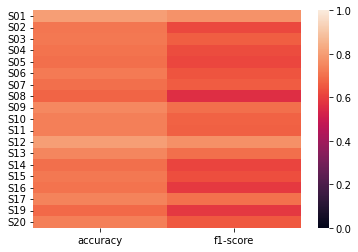

     class0 f1-score  class1 f1-score
S01         0.870968         0.567568
S02         0.827338         0.172414
S03         0.822695         0.285714
S04         0.820847         0.179104
S05         0.817518         0.137931
S06         0.831615         0.169492
S07         0.802867         0.337349
S08         0.805195         0.032258
S09         0.845902         0.338028
S10         0.835526         0.305556
S11         0.836364         0.237288
S12         0.872727         0.545455
S13         0.842105         0.383562
S14         0.814815         0.153846
S15         0.827815         0.187500
S16         0.825806         0.035714
S17         0.835249         0.394366
S19         0.809211         0.093750
S20         0.838926         0.225806


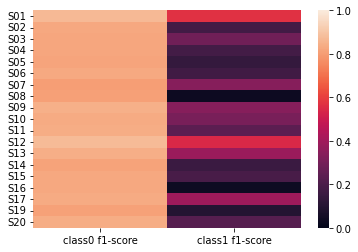

In [7]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)
